In [2]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Lena\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Übergeordnete Fragestellung: 
> Welche technisch – ökonomischen Parametergrenzwerte sind im Kontext des Energieträgerwandels (Fossil-zu-Wasserstoff) für einen Um- oder Zubau einer saisonalen Speicher- und Versorgungsanlage in Eigenheimen und am Beispiel eines Einfamilienhauses mit Gasheizung oder einem erneuerbaren Energiesystem in Wesseling für einen Betrachtungszeitraum von 20 Jahren relevant, um eine Investition in ein saisonales Wasserstoffsystem zu bewerten?

# Auswertungs- und Grafische Darstellungsfunktionen
Grundfunktionen der nachfolgenden Funktionen. Für eine Detailbeschreibung der Argumente und Returns, kann der Docstring eingesehen werden

##### opt_series_summary()
Funktion fasst wahlweise eines Netzwerkpaares (Referenz und H2) für den Typ Gas oder EE, oder aller 4 Netzwerke die time series Daten der Optimierungsergebnisse in eine Übersicht zusammen.

##### plot_series_data()
Funktion stellt die time series der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### plot_opt_data()
Funktion stellt die p_nom_opt der Optimierungsergebnisse eines Netzwerks grafisch dar.

##### result_summary_single_network()
Funktion fasst alle Ergebnisse Netzwerk-Ergebnisse und Berechneten Ergebnisse in einen Datensatz aus 3 DataFrames in einem Tuple zusammen

##### cost_reduction_calculation()
Funktion ermittelt ein Learning Curve Modell Datensatz zur Kostenreduktion von Wasserstoffsystemen auf Basis von Studien zur Kostenanalyse von Elektrolyseuren. Ergebnis sind drei Kostenreduktionsszenarien mit unterschiedlich starker Reduktion der Kapitalkosten für ein Wasserstoffsystem.

##### extract_specific_data()
Funktion extrahiert aus erzeugten Datensätzen einer Parametervariation alle Daten zu einem spezifischen Parameter.

##### start_capital_cost()
Funktion ermittelt für einen spezifischen Startwert die Kapitalkostenanteile der H2-Systemkomponenten.

##### compare_paypack_period()
Funktion vergleicht die Amortisationszeiten eines Wasserstoffnetzwerkes mit der Amortisationszeit des zugehörigen Referenz-Netzwerkes und berechnet eine korrigierte Amortisationszeit des Wasserstoffnetzwerkes im Fall eines zeitlich späteren Zubaus des Wasserstoff-Systems zu bestehenden Referenzkomponenten.

##### create_multi_index()
Funktion erzeugt einen Multi-Index anhand eines definierten Betrachtungszeitraumes.

##### reindex_data()
Funktion reindexiert einen Datensatz für einen neuen Betrachtungszeitraum.

In [2]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False, MI_series_summary=False):
    """
        This function sums up all optimized time series data for each component of the given network.

        Parameters:
            network (PyPSA.Network()): The Network for that a summary of the time_series data is requested
            h2, h2_gas, ref_gas, ref (bool, 1 required): Bool choice variable for decision about the passed network 
                                                         for a correct output of summarized data according to different
                                                         network components
            MI_series_summary (bool, optional): A Flag that controlls the chosen index for parameter summary 

        Returns:
            df_res_series (DataFrame): DataFrame with network specific time series data
    """
    # create index according to the networks periods
    if MI_series_summary == True:           
        date_index = create_multi_index(multi_years, freq)
    else: 
        date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
    
    
    # network choice
    if h2 == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), 
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), 
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                    index=date_index, columns=['WP']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), 
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                        index=date_index, columns=['Grid']),
                                           pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                        index=date_index, columns=['PV']),
                                           pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                        index=date_index, columns=['Einspeisung']),
                                           pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                        index=date_index, columns=['WP']),
                                           pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                        index=date_index, columns=['Electric Load']),
                                           pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                        index=date_index, columns=['Heat load']),
                                           pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                        index=date_index, columns=['WW load']),
                                           pd.DataFrame(data=(network.stores_t.e.h2_storage
                                                              + network.stores_t.e.h2_storage_1
                                                              + network.stores_t.e.h2_storage_2).to_numpy(),
                                                        index=date_index, columns=['H2 Storage']),
                                           pd.DataFrame(data=(network.links_t.p0.fc 
                                                              + network.links_t.p0.fc_1 
                                                              + network.links_t.p0.fc_2).to_numpy(), 
                                                        index=date_index, columns=['Fuel Cell']),
                                           pd.DataFrame(data=(network.links_t.p0.ely
                                                              + network.links_t.p0.ely_1 
                                                              + network.links_t.p0.ely_2).to_numpy(),
                                                        index=date_index, columns=['Electrolysis']),
                                           pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                        index=date_index, columns=['Battery OUT']),
                                           pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore IN']),
                                           pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                        index=date_index, columns=['Heatstore OUT']),
                                           pd.DataFrame(data=(network.stores_t.e.battery 
                                                              + network.stores_t.e.battery_1 
                                                              + network.stores_t.e.battery_2).to_numpy(),
                                                        index=date_index, columns=['Battery']),
                                           pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                        index=date_index, columns=['Heat Storage'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                            index=date_index, columns=['Grid']),
                                               pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                            index=date_index, columns=['PV']),
                                               pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                            index=date_index, columns=['Einspeisung']),
                                               pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                            index=date_index, columns=['WP']),
                                               pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), 
                                                            index=date_index, columns=['Electric Load']),
                                               pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                            index=date_index, columns=['Heat load']),
                                               pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                            index=date_index, columns=['WW load']),
                                               pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                                  + network.stores_t.e.h2_storage_1).to_numpy(),
                                                            index=date_index, columns=['H2 Storage']),
                                               pd.DataFrame(data=(network.links_t.p0.fc 
                                                                  + network.links_t.p0.fc_1).to_numpy(),
                                                            index=date_index, columns=['Fuel Cell']),
                                               pd.DataFrame(data=(network.links_t.p0.ely
                                                                  + network.links_t.p0.ely_1).to_numpy(),
                                                            index=date_index, columns=['Electrolysis']),
                                               pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                            index=date_index, columns=['Battery OUT']),
                                               pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore IN']),
                                               pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                            index=date_index, columns=['Heatstore OUT']),
                                               pd.DataFrame(data=(network.stores_t.e.battery 
                                                                  + network.stores_t.e.battery_1).to_numpy(),
                                                            index=date_index, columns=['Battery']),
                                               pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                            index=date_index, columns=['Heat Storage'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), 
                                                                index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), 
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), 
                                                                index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WP']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif h2_gas == True:
        try:
            df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2 
                                                          + network.stores_t.e.battery_3).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2 
                                                          + network.stores_t.e.h2_storage_3).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2 
                                                          + network.links_t.p0.fc_3).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2 
                                                          + network.links_t.p0.ely_3).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
        except:
            try:
                df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1
                                                          + network.stores_t.e.battery_2).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1 
                                                          + network.stores_t.e.h2_storage_2).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1 
                                                          + network.links_t.p0.fc_2).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1
                                                          + network.links_t.p0.ely_2).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
            except:
                try:
                    df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                    index=date_index, columns=['Grid']),
                                       pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                    index=date_index, columns=['Gas Grid']),
                                       pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                    index=date_index, columns=['PV']),
                                       pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                    index=date_index, columns=['Einspeisung']),
                                       pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                    index=date_index, columns=['Electric Load']),
                                       pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                    index=date_index, columns=['Heat load']),
                                       pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                    index=date_index, columns=['WW load']),
                                       pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                    index=date_index, columns=['Heating Rod']),
                                       pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                    index=date_index, columns=['Battery OUT']),
                                       pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                    index=date_index, columns=['Heatstore IN']),
                                       pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                    index=date_index, columns=['Heatstore OUT']), 
                                       pd.DataFrame(data=(network.stores_t.e.battery 
                                                          + network.stores_t.e.battery_1).to_numpy(), 
                                                    index=date_index, columns=['Battery']),
                                       pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                    index=date_index, columns=['Boiler']),
                                       pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                    index=date_index, columns=['Heat Storage']),
                                       pd.DataFrame(data=(network.stores_t.e.h2_storage 
                                                          + network.stores_t.e.h2_storage_1).to_numpy(),
                                                    index=date_index, columns=['H2 Storage']),
                                       pd.DataFrame(data=(network.links_t.p0.fc 
                                                          + network.links_t.p0.fc_1).to_numpy(),
                                                    index=date_index, columns=['Fuel Cell']),
                                       pd.DataFrame(data=(network.links_t.p0.ely 
                                                          + network.links_t.p0.ely_1).to_numpy(),
                                                    index=date_index, columns=['Electrolysis'])], axis=1)
                except:
                    try:
                        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                                index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                                index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                                index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                                index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                                index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                                index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), 
                                                                index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                                index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                                index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                                index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                                index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(),
                                                                index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                                index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(),
                                                                index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(),
                                                                index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(),
                                                                index=date_index, columns=['Electrolysis'])], axis=1)
                    except:
                        network_error_data = [0 for i in range(0, date_index.shape[0])]
                        df_res_series = pd.concat([pd.DataFrame(data=network_error_data, index=date_index, columns=['Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Gas Grid']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['PV']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Einspeisung']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electric Load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['WW load']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heating Rod']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery OUT']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore IN']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heatstore OUT']), 
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Battery']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Boiler']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Heat Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['H2 Storage']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Fuel Cell']),
                                                   pd.DataFrame(data=network_error_data, index=date_index, columns=['Electrolysis'])], axis=1)
    
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(),
                                                index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), 
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(),
                                                index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), 
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), 
                                                index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(),
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(),
                                                index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(),
                                                index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(),
                                                index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(),
                                                index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(),
                                                index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(),
                                                index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(),
                                                index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), 
                                                index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(),
                                                index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(),
                                                index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(),
                                                index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), 
                                                index=date_index, columns=['Heat Storage'])], axis=1)
    
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [3]:
def plot_series_data(df_series_t, MI_plot_series=False):
    """
    This function generates plots to visualize time series data from the provided
    DataFrame `df_series_t`. Each column in the DataFrame represents a different
    time series alle time series are plotted in an overview in 5:4 or 4:4 Matrix.

    Parameters:
        df_series_t (pandas.DataFrame): The DataFrame containing time series data of each networks components.
        multiinvest (bool, optional): A Flag with the decicion on the x_axes format and the time period 
        of the plot summary. Default is False.

    Returns:
        None
    """
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        if MI_plot_series == True:
            ax.plot(df_series_t.reset_index().index, df_series_t[col], color=c)
            ax.set_xticks(np.linspace(0, df_series_t.shape[0], len(multi_years)), labels=multi_years)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
        else:
            ax.plot(df_series_t.index, df_series_t[col], color=c)
            ax.set_xticks([])
            ax.set_xlabel("hours per year")
        ax.set_title(col)
        
        plt.subplots_adjust(wspace=.3, hspace=.65) 

In [4]:
def plot_opt_data(df_opt):
    """
    Plot overview of network optimization values for power and capacity.
    This function generates a plot to visualize the optimization values for power
    and capacity from the provided DataFrame.

    Parameters:
        df_opt (pandas.DataFrame): The DataFrame contains all optimized values (p_nom_opt;e_nom_opt).

    Returns:
        None
    """
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot, if only 1 dataset just 1 plot
    if df_opt.shape[1] == 2:
        rows = 1
        cols = 2
        size_w = 14
        size_h = 8
    elif df_opt.shape[1] == 1:
        rows = 1
        cols = 1
        size_w = 14
        size_h = 6
    else:
        rows = 2
        cols = 2
        size_w = 14
        size_h = 8
    
    # reform the h2_storage value by /100 and rename the indicator
    if 'h2_storage' in df_opt.index:
        df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    if 'h2_storage_1' in df_opt.index:
        df_opt.loc['h2_storage_1'] = df_opt.loc['h2_storage_1'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_1': 'h2_store_1*100'})
    if 'h2_storage_2' in df_opt.index:
        df_opt.loc['h2_storage_2'] = df_opt.loc['h2_storage_2'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_2': 'h2_store_2*100'})
    if 'h2_storage_3' in df_opt.index:
        df_opt.loc['h2_storage_3'] = df_opt.loc['h2_storage_3'].apply(lambda x: x/100)
        df_opt = df_opt.rename(index={'h2_storage_3': 'h2_store_3*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(size_w, size_h), squeeze=False)
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=30)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [5]:
def result_summary_single_network(n, h2=False, h2_gas=False, ref_gas=False, ref=False, sensitivity_variable=None,
                                  plots=False, MI_analyse_network=False):
    '''METHODS DOCSTRING
        This Methods gives a summary for a network passed as argument->(n)
        By setting the choice variable it generates datasets explicit for the given network
        Data shown by the function:
            1. Summarized energies and percentages for Grid(Electric/Gas) and Self Sufficiency Rate
            2. All p_nom_opt and e_nom_opt Values of the network
            3. Additional Plot Grafik for optimized values
            4. Time Series overview of all components as Plot Matrix
            5. Sensitivity evaluation when sensitivity variable != 0

        Returns: 
        If sensitivity variable = 0 return datasets -> print results and plots directly with argument ->(plots=True)
        pandas.DataFrame: series_data (summary of time series data)
        pandas.DataFrame: df_n_opt (Networks optimized values)    
        pandas.DataFrame: analysis data (Sums of components and percentages like Self Sufficiency)
            
            use: df1, df2, df3 = analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True)
        otherwise:
        pandas.DataFrame: df_sensitivity_results (Sensitivity DataFrame as output)
            use: df1 = df1.append(analyse_single_network(NETWORK_NAME, CHOICE_VARIABLE=True, sensitivity_variable))
    '''
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    
    # calculate multi_factor for calculation of analysis values 
    # for results on yearly basis
    if MI_analyse_network == True:
        multi_factor = freq / support_year_amount
    else:
        multi_factor = 1.0
        
    # co2, capex, total_loads, pv_yield, pv_used calculation (equal for all networks)
    co2_val = (n.generators_t.p.sum() * multi_factor / n.generators.efficiency *
               pd.merge(n.carriers, n.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    capex = ((n.stores.e_nom_opt * n.stores.capital_cost).sum() 
             + (n.generators.p_nom_opt * n.generators.capital_cost).sum() 
             + (n.links.p_nom_opt * n.links.capital_cost).sum())
    total_load = ((n.loads_t.p_set.electric_load.sum() + n.loads_t.p_set.heat_load.sum() 
                   + n.loads_t.p_set.ww_load.sum()) * multi_factor)
    pv_yield = n.generators_t.p.pv.sum() * multi_factor
    pv_used = n.generators_t.p.pv.sum() * multi_factor - n.generators_t.p.infeed.sum() * multi_factor
    
    # network choice
    if h2 == True:
        
        # decide about multiinvest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2=True)
            
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=['H2 EE optimized'])], axis=0)
        
        # summary of analytic value sums
        # side calculation
        
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
                    
        opex = (n.generators_t.p.grid.sum() * multi_factor * electricity_rate)
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))
        
        self_sufficiency = (((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100)
                            

        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)

        
    elif h2_gas == True:
        
        # decide about multi_invest flag; generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, h2_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, h2_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2),
                                           index=n.generators.p_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['H2 Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["H2 Gas optimized"])], axis=0)
        
        # summary of analytic value sums
        # side calculations
        try:
            h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2 + n.links_t.p1.ely_3).sum()
            conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2 + n.links_t.p0.ely_3).sum()
            h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2 + n.links_t.p0.fc_3).sum()
            heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2 + n.links_t.p2.ely_3).sum() 
                       + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2 + n.links_t.p2.fc_3).sum())
        except:
            try:
                h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1 + n.links_t.p1.ely_2).sum()
                conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1 + n.links_t.p0.ely_2).sum()
                h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1 + n.links_t.p0.fc_2).sum()
                heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1 + n.links_t.p2.ely_2).sum()
                           + (n.links_t.p2.fc + n.links_t.p2.fc_1 + n.links_t.p2.fc_2).sum())
            except:
                try:
                    h2_stored = -(n.links_t.p1.ely + n.links_t.p1.ely_1).sum()
                    conv_to_h2 = (n.links_t.p0.ely + n.links_t.p0.ely_1).sum()
                    h2_used = (n.links_t.p0.fc + n.links_t.p0.fc_1).sum()
                    heat_h2 = ((n.links_t.p2.ely + n.links_t.p2.ely_1).sum() 
                               + (n.links_t.p2.fc + n.links_t.p2.fc_1).sum())
                except:
                    h2_stored = -n.links_t.p1.ely.sum()
                    conv_to_h2 = n.links_t.p0.ely.sum()
                    h2_used = n.links_t.p0.fc.sum()
                    heat_h2 = n.links_t.p2.ely.sum() + n.links_t.p2.fc.sum()
                    
        
        
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
        
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))             
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          h2_stored*multi_factor,
                                          conv_to_h2*multi_factor,
                                          h2_used*multi_factor,
                                          -heat_h2*multi_factor, 
                                          self_sufficiency, 
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save,
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
        
        
    elif ref_gas == True:
        
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref_gas=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref_gas=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref Gas optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref Gas optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        el_ratio = (n.generators_t.p.grid.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        gas_ratio = (n.generators_t.p.gas.sum()*multi_factor/(n.generators_t.p.grid.sum()*multi_factor 
                                                              + n.generators_t.p.gas.sum()*multi_factor))
        
        opex = ((n.generators_t.p.grid.sum() * multi_factor * electricity_rate) 
                + (n.generators_t.p.gas.sum() * multi_factor * gas_price))
        
        rev_save = (n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate)
                                          
        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save))    
        
        self_sufficiency = (((total_load - ((n.generators_t.p.grid.sum() * multi_factor)
                                            + (n.generators_t.p.gas.sum() * multi_factor))) / total_load) * 100)
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          n.generators_t.p.gas.sum()*multi_factor, 
                                          el_ratio*100,
                                          gas_ratio*100, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0,
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    elif ref == True:
        # generate series data
        if MI_analyse_network == True:
            series_data = opt_series_summary(n, ref=True, MI_series_summary=True)
        else:
            series_data = opt_series_summary(n, ref=True)
        
        # summary of optimized values
        df_n_opt = pd.concat([pd.DataFrame(data=n.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.generators.p_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.stores.e_nom_opt.to_numpy().round(decimals=2),
                                           index=n.stores.e_nom_opt.index, columns=['Ref EE optimized']),
                              pd.DataFrame(data=n.links.p_nom_opt.to_numpy().round(decimals=2), 
                                           index=n.links.p_nom_opt.index, columns=["Ref EE optimized"])], axis=0)
        # summary of analytic value sums
        # side calculation
        opex = n.generators_t.p.grid.sum() * multi_factor * electricity_rate
        rev_save = ((n.generators_t.p.pv.sum()*multi_factor - n.generators_t.p.infeed.sum()*multi_factor) * -(electricity_rate))

        payback_period = ((capex + (opex * observation_period))
                          /-((n.generators_t.p.infeed.sum() * multi_factor * n.generators.marginal_cost.infeed)
                             + rev_save)) 
        
        self_sufficiency = ((total_load - (n.generators_t.p.grid.sum() * multi_factor)) / total_load) * 100
        
        df_analysis = pd.DataFrame(data={'analytic values':
                                         [co2_val,
                                          pv_yield,
                                          pv_used,
                                          (pv_used / pv_yield) * 100,
                                          n.generators_t.p.infeed.sum()*multi_factor,
                                          total_load,
                                          n.generators_t.p.grid.sum()*multi_factor, 
                                          0, 
                                          100,
                                          0, 
                                          -n.links_t.p1.charge_bat.sum()*multi_factor,
                                          -n.links_t.p1.charge_heat.sum()*multi_factor, 
                                          0,
                                          0,
                                          0,
                                          0, 
                                          self_sufficiency,
                                          capex,
                                          opex,
                                          n.generators_t.p.infeed.sum()*multi_factor * n.generators.marginal_cost.infeed, 
                                          rev_save, 
                                          payback_period]},
                                   index=['CO2-Emission [kg/a]',
                                          'PV generated [kWh/a]', 
                                          'PV used [kWh/a]',
                                          'PV own consumption ratio [%]',
                                          'Amount Infeed [kWh/a]',
                                          'Load Total [kWh/a]',
                                          'Grid electric [kWh/a]',
                                          'Grid gas [kWh/a]',
                                          'Ratio electric [%]',
                                          'Ratio gas [%]', 
                                          'Battery stored [kWh/a]', 
                                          'Heat Storage stored [kWh/a]', 
                                          'H2 stored [kWh/a]', 
                                          'converted to H2 [kWh/a]',
                                          'H2 used [kWh/a]',
                                          'Heat from H2 [kWh/a]', 
                                          'Self Sufficiency [%]',
                                          'CAPEX [€]',
                                          'OPEX [€/a]',
                                          'Revenue Infeed [€/a]',
                                          'Revenue Savings [€/a]',
                                          'Payback Period [a]']).round(decimals=2)
    
    
    else:
        # if no choice variable set -> 
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
    
        
    # decide for return values and output
    if sensitivity_variable != None:
        # generate sensitivity results
        df_sensitivity_results = pd.concat([pd.DataFrame(data=df_analysis.loc['CO2-Emission [kg/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['CO2-Emission [kg/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV generated [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['PV generated [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['PV used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV used [kWh/a]']),                                            
                                            pd.DataFrame(data=df_analysis.loc['PV own consumption ratio [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['PV own consumption ratio [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Amount Infeed [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Amount Infeed [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Load Total [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Load Total [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid electric [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Grid electric [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Grid gas [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Grid gas [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio electric [%]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Ratio electric [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Ratio gas [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Ratio gas [%]']),
                                            pd.DataFrame(data=df_analysis.loc['Battery stored [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Battery stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat Storage stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Heat Storage stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 stored [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 stored [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['converted to H2 [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['converted to H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['H2 used [kWh/a]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['H2 used [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Heat from H2 [kWh/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Heat from H2 [kWh/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Self Sufficiency [%]', 'analytic values'], 
                                                         index=[sensitivity_variable], columns=['Self Sufficiency [%]']),
                                            pd.DataFrame(data=df_analysis.loc['CAPEX [€]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['CAPEX [€]']),
                                            pd.DataFrame(data=df_analysis.loc['OPEX [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['OPEX [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Infeed [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Infeed [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Revenue Savings [€/a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Revenue Savings [€/a]']),
                                            pd.DataFrame(data=df_analysis.loc['Payback Period [a]', 'analytic values'],
                                                         index=[sensitivity_variable], columns=['Payback Period [a]'])], axis=1)
    
        return df_sensitivity_results
    else:
        if plots == True:
            print("\nNetwork analytics: \n", df_analysis, "\n\nOptimized p_nom and e_nom and equivalent plot: \n", df_n_opt)
            plot_opt_data(df_n_opt)
            if MI_analyse_network == True:
                plot_series_data(series_data, MI_plot_series=True)
            else:
                plot_series_data(series_data)
            return (series_data, df_n_opt, df_analysis)
        else:
            return (series_data, df_n_opt, df_analysis)

In [6]:
def cost_reduction_calculation(initial_cost):
    """
    Calculate cost reduction scenarios for a hydrogen components over time (2020 - 2050).
    This function calculates cost reduction scenarios for a component over a specified time range,
    based on initial_cost, production quantities, and price data for three time points (2020 and 2030, 2050).
    It considers three price scenarios and estimates cost reductions accordingly by building learning curve model.

    Parameters:
        initial_cost (float): Component cost before price reduction.

    Returns:
        pandas.DataFrame: A DataFrame containing cost reduction scenarios over the specified time range.

    References:
        - Price and Quantity Data Source: 
          https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
          https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
        - Learning Curve Information:
          https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    """
    # Values Cost and Quantity (estimated by graphic): https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/cost-forecast-for-low-temperature-electrolysis.pdf
    # mean value after calculation 4 datasets für assumption of the learning_rate or cost_reduction assumption
    Qt_2020 = 4 #GW
    Qt_2030 = 6100 #GW
    prices_2020 = [980, 720, 380, 290] #€/kW
    prices_2030 = [740, 500, 330, 220] #€/kW

    df_costred = pd.DataFrame(data={'year': [2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030],
                                     'Qts' : [4, 9, 25, 35, 55, 105, 500, 750, 1800, 3500, 6100]}) #GW

    # calculation first from base year 2020
    # determine the learning_rate, value(b) and progress_ratio for 2020 - 2030
    # dtermine the Costs in between for all 4 price scenarios
    b = [] # innovation rate
    learning_rate = [] # (1 - progress rate); percent
    progress_ratio = [] # factorial

    for i in range(4):
        b.append(np.log(prices_2030[i]/prices_2020[0])/np.log(Qt_2030/Qt_2020))
        progress_ratio.append(np.power(2, b[i]))
        learning_rate.append(1 - progress_ratio[i])

    params_dict = {'b' : b,
                  'PR': progress_ratio,
                  'LR': learning_rate}

    # cases from 2020 up -> Calculation of Ct    
    Ct_case1 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][0]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case2 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][1]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case3 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][2]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case4 = list(map(lambda x: prices_2020[0] * np.power((x / Qt_2020), params_dict['b'][3]), df_costred['Qts'].tolist()[1:-1]))
    Ct_case1.append(prices_2030[0])
    Ct_case2.append(prices_2030[1])
    Ct_case3.append(prices_2030[2])
    Ct_case4.append(prices_2030[3])
    Ct_case1.insert(0, prices_2020[0])
    Ct_case2.insert(0, prices_2020[0])
    Ct_case3.insert(0, prices_2020[0])
    Ct_case4.insert(0, prices_2020[0])

    df_costred['Ct1'] = Ct_case1
    df_costred['Ct2'] = Ct_case2
    df_costred['Ct3'] = Ct_case3
    df_costred['Ct4'] = Ct_case4
    # additional value for 2050 forecast (Europe): https://www.ieg.fraunhofer.de/content/dam/ieg/documents/pressemitteilungen/2019-10_Fraunhofer_Wasserstoff-Roadmap_fuer_Deutschland.pdf
    neu1 = prices_2020[0] * np.power((50000 / Qt_2020), params_dict['b'][0])
    neu2 = prices_2020[1] * np.power((50000 / Qt_2020), params_dict['b'][1])
    neu3 = prices_2020[2] * np.power((50000 / Qt_2020), params_dict['b'][2])
    neu4 = prices_2020[3] * np.power((50000 / Qt_2020), params_dict['b'][3])
    df_costred = df_costred.append({'year': 2050, 'Qts': 50000, 'Ct1': neu1, 'Ct2': neu2, 'Ct3': neu3, 'Ct4': neu4}, ignore_index=True)

    # Typical Learning Rates are estimated by 10-20%. Learning Rates for case 2 - 4 seem to fit this estimation 
    # In logarithmic scale the curve is rather correct compared to literature: https://www.researchgate.net/figure/Learning-curve-for-energy-technologies-IEA-2000_fig1_5216285
    df_costred['mean_Ct'] = (df_costred['Ct1'] + df_costred['Ct2'] + df_costred['Ct3'] + df_costred['Ct4']) / 4 
    df_costred['red1'] = df_costred['Ct1'] / prices_2020[0]
    df_costred['red2'] = df_costred['Ct2'] / prices_2020[0]
    df_costred['red3'] = df_costred['Ct3'] / prices_2020[0]
    df_costred['red4'] = df_costred['Ct4'] / prices_2020[0]

    #linear fitting of 2030 - 2050 (Faktoren aus Geogebra anhand der bekannten Punkte)
    def linear_cost(x, m=-2.484173, b=5542.871799):
        return m * x + b
    def linear_quant(x, m=2195, b=-4449750):
        return m * x + b
    
    
    x_vals = [i for i in range(2020, 2051, 1)]
    yq_vals = []
    y_vals = []
    for x in x_vals:
        y_vals.append(linear_cost(x))
        yq_vals.append(linear_quant(x))

    
    df_capex_reduction = pd.DataFrame()
    df_capex_reduction['year'] = x_vals
    df_capex_reduction['quantities'] = list(df_costred['Qts'][:11])+[x for x in yq_vals[-20:]]
    df_capex_reduction['capex_model1'] = list(df_costred['Ct1'][:11])+[x + 238 for x in y_vals[-20:]]
    df_capex_reduction['capex_model2'] = list(df_costred['Ct2'][:11])+list(y_vals[-20:])
    df_capex_reduction['capex_model3'] = list(df_costred['Ct3'][:11])+[x - 172 for x in y_vals[-20:]] 
    df_capex_reduction['reduced_percentage1'] = df_capex_reduction['capex_model1'] / df_capex_reduction['capex_model1'][0]
    df_capex_reduction['reduced_percentage2'] = df_capex_reduction['capex_model2'] / df_capex_reduction['capex_model2'][0]
    df_capex_reduction['reduced_percentage3'] = df_capex_reduction['capex_model3'] / df_capex_reduction['capex_model3'][0]

    #df_capex_reduction.plot(x='quantities', y=['capex_model1', 'capex_model2', 'capex_model3'], logx=True, logy=True, figsize=(18,8))
    #print(df_capex_reduction)
    #print(df_costred)
    #print(params_dict)
    
    #factor_max = 1
    #factor_std = df_capex_reduction['capex_model2'][0] / df_capex_reduction['capex_model1'][0] 
    #factor_min = df_capex_reduction['capex_model3'][0] / df_capex_reduction['capex_model1'][0] 
    #print(factor_min, factor_std)
    df_cost_reduction = pd.DataFrame()
    df_cost_reduction['year'] = x_vals
    df_cost_reduction["max"] = initial_cost * df_capex_reduction['reduced_percentage1']
    df_cost_reduction["std"] = initial_cost * df_capex_reduction['reduced_percentage2']
    df_cost_reduction["min"] = initial_cost * df_capex_reduction['reduced_percentage3']
    df_cost_reduction['[%]_1'] = df_capex_reduction['reduced_percentage1']
    df_cost_reduction['[%]_2'] = df_capex_reduction['reduced_percentage2']
    df_cost_reduction['[%]_3'] = df_capex_reduction['reduced_percentage3']
    
    return df_cost_reduction

In [7]:
def extract_specific_data(extract_value, data, dataset_index=2):
    """
        Extract specific data based on the provided parameters.

        Parameters:
        - extract_value (str): The value to extract can be the column or index name of the specified dataset.
        - data (dict): A dictionary containing result datasets.
        - dataset_index (int, optional): The index of the dataset to extract data from.
            - 0: Concatenated time series data.
            - 1: p_nom_opt values dataset.
            - 2: DataFrame analysis dataset (default).

        Returns:
        - If dataset_index is 0, returns a DataFrame containing specific time series data.
        - If dataset_index is 1, returns a list of specific values from p_nom_opt dataset.
        - If dataset_index is 2, returns a list of specific values from df_analysis dataset.
    """
    # empty base data list for extracted values
    extracted_data = []
        
    # asked concatenated dataframe of specific times_series data over all analysed key values
    if dataset_index == 0:
        series_lst = []
        key_lst = list(data.keys())
        for i in range(len(key_lst)):
            key_lst[i] = extract_value + "_" + str(key_lst[i])
        for value in data.values():
            series_lst.append(value[0][extract_value])
        df_filter = pd.concat(series_lst, ignore_index=True, axis=1)
        range_index = [i for i in range(df_filter.shape[0])]
        df_filter.columns = key_lst
        df_filter.index = range_index
        return df_filter
    
    # asked for specific value from p_nom_opt values dataset
    elif dataset_index == 1:
        try:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 Gas optimized'])
        except:
            for dataset in data.values():
                extracted_data.append(dataset[dataset_index].loc[extract_value, 'H2 EE optimized'])
        return extracted_data
    
    # asked for specific value from df_analysis dataset
    elif dataset_index == 2:
        for dataset in data.values():
            extracted_data.append(dataset[dataset_index].loc[extract_value, 'analytic values'])
        return extracted_data
    else:
        print("Die Funktion benötigt einen dataset_index aus folgender Auswahl: 0, 1, 2")

In [8]:
def start_capital_cost(start_cap):
    """
        Calculate the capital costs for different components based on the specified capital.
        The capital costs for each component are calculated by multiplying the specified capital
        with the corresponding specific capital share obtained from the 'specific_cap_share' dictionary

        Parameters:
            start_cap (float): The initial capital to be allocated.

        Returns:
            list: A list containing the capital costs for hydrogen storage (start_cap_h2_storage),
                  electrolysis (start_cap_ely), fuel cells (start_cap_fc), and batteries (start_cap_battery).
    """
    start_cap_h2_storage = start_cap * specific_cap_share['h2_storage']
    start_cap_ely = start_cap * specific_cap_share['ely']
    start_cap_fc = start_cap * specific_cap_share['fc']
    start_cap_battery = start_cap * specific_cap_share['battery']
    cap_lst = [start_cap_h2_storage, start_cap_ely, start_cap_fc, start_cap_battery]
    return cap_lst

In [5]:
def compare_paypack_period(dataset_ref, dataset_h2, h2_installation_year=2020, ref_installation_year=2020):
    """
        Compare the payback periods of two datasets representing different scenarios.
        In case of a later installation year of hydrogen components it will recalculate a corrected payback period
        by difference of the previous revenues.

        Parameters:
            dataset_ref (pandas.DataFrame): DataFrame containing data for the reference result.
            dataset_h2 (pandas.DataFrame): DataFrame containing data for the hydrogen result.
            h2_installation_year (int, optional): The year of installation for the hydrogen scenario.
                Defaults to 2020.
            ref_installation_year (int, optional): The year of installation for the reference scenario.
                Defaults to 2020.

        Returns:
            payback_ratio (float): the ratio between hydrogen and reference payback times
            payback_period2 (float): corrected payback period of hydrogen networks results
    """   
    # observation period and support years
    observation_period = multi_years[-1] - multi_years[0]
    support_year_amount = len(multi_years)
    observation_period_passed = h2_installation_year - ref_installation_year
 
    df_analysis_ref = dataset_ref
    df_analysis_h2 = dataset_h2
        
    capex1 = df_analysis_ref.loc['CAPEX [€]', 'analytic values']
    opex1 = df_analysis_ref.loc['OPEX [€/a]', 'analytic values']
    rev_save1 = df_analysis_ref.loc['Revenue Savings [€/a]', 'analytic values']
    rev_infeed1 = df_analysis_ref.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_total1 = rev_infeed1 + rev_save1
    payback_period1 = (capex1 + (opex1 * observation_period))/-(rev_total1)
    print(payback_period1)

    rev_infeed2 = df_analysis_h2.loc['Revenue Infeed [€/a]', 'analytic values']
    rev_save2 = df_analysis_h2.loc['Revenue Savings [€/a]', 'analytic values']
    rev_total1_until_h2_installation = (rev_total1 * observation_period_passed)
    rev_total2 = rev_infeed2 + rev_save2
    capex2 = df_analysis_h2.loc['CAPEX [€]', 'analytic values']
    opex2 = df_analysis_h2.loc['OPEX [€/a]', 'analytic values']

    payback_period2 = np.round(((capex2 + opex2 * (observation_period - observation_period_passed)
                                 + rev_total1_until_h2_installation)
                                /-(rev_total2)), 2)
    print(payback_period2)
    payback_ratio = payback_period2 / payback_period1
    print("\n Current Payback_ratio: ", payback_ratio)

    return payback_ratio, payback_period2

In [10]:
def create_multi_index(years_lst, freq):
    """
        this function creates a multi-index for pandas.Series snapshots of PyPSA.network() and for Input Data
    """
    snapshots = pd.DatetimeIndex([])
    for year in years_lst:
        period = pd.date_range(start='{}-01-01 00:00'.format(year),
                               freq='{}H'.format(str(freq)),
                               periods=8760 / float(freq),
                              )
        snapshots = snapshots.append(period)

    multi_index = pd.MultiIndex.from_arrays([snapshots.year, snapshots])
    return multi_index

In [11]:
def reindex_data(data_xy, new_period):
    """
        this function performes a reindexing of a given pandas.DataFrame according a new observation period
    """
    multi_index = create_multi_index(new_period, freq)
    data_xy.index = multi_index
    return data_xy

# Import der Basisdaten

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 4 Personen Haushalt in einem EFH

In [12]:
# data imports

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])


# load loadprofile data
# 2 Residents EFH
el_2p = pd.read_csv('data/loads/2Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_2p = pd.read_csv('data/loads/2Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_2p = pd.read_csv('data/loads/2Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 4 Residents EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 6 Residents EFH
el_6p = pd.read_csv('data/loads/6Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_6p = pd.read_csv('data/loads/6Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_6p = pd.read_csv('data/loads/6Pers/neighbourhood_htg.csv', comment='#', sep=';')

# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()
df_data['ww_load_2p'] = dhw_2p['total']
df_data['ww_load_4p'] = dhw_4p['total']
df_data['ww_load_6p'] = dhw_6p['total']
df_data['e_load_2p'] = el_2p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['e_load_6p'] = el_6p['total']
df_data['h_load_2p'] = htg_2p['total_htg']
df_data['h_load_4p'] = htg_4p['total_htg']
df_data['h_load_6p'] = htg_6p['total_htg']

# season operation of hydrogen system (use ely thw whole year, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely'] = [1 for x in range(8760)]
df_season['fc'] = [0 if 3624 <= x <= 6552 else 1 for x in range(8760)]

In [13]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)

df_data

pv  temp  ww_load_2p  ww_load_4p  ww_load_6p  e_load_2p  e_load_4p  \
0     0.0  12.6    0.000000         0.0    1.518594   0.087042   0.108191   
1     0.0  13.0    0.000000         0.0    0.000000   0.087303   0.086217   
2     0.0  12.6    0.000000         0.0    0.000000   0.086005   0.085922   
3     0.0  12.2    0.000000         0.0    0.000000   0.082747   0.109169   
4     0.0  12.8    0.000000         0.0    0.000000   0.075984   0.108558   
...   ...   ...         ...         ...         ...        ...        ...   
8755  0.0  15.1    0.000000         0.0    0.000000   0.143545   0.545067   
8756  0.0  15.9    0.000000         0.0    0.035994   0.142139   0.228792   
8757  0.0  15.9    0.000000         0.0    0.000000   0.142010   0.291029   
8758  0.0  15.6    2.712356         0.0    0.971850   0.141723   0.330328   
8759  0.0  15.4    0.000000         0.0    1.829137   0.093288   0.226008   

      e_load_6p  h_load_2p  h_load_4p  h_load_6p  wp_COP_interp  
0      0.136886   1.287577   1.274003   1.295842          3.315  
1      0.135976   1.799948   1.798675   1.809386          3.325  
2      0.135816   2.128495   2.127315   2.138208          3.315  
3      0.181411   2.381928   2.364143   2.376183          3.305  
4      0.179553   2.553156   2.529228   2.542549          3.320  
...         ...        ...        ...        ...            ...  
8755   0.574078   1.614701   1.330839   1.452981          3.378  
8756   1.003943   1.681241   1.550685   1.110155          3.398  
8757   0.977002   1.713969   1.539984   1.098378          3.398  
8758   0.473260   1.708129   1.495063   1.420826          3.390  
8759   0.482663   1.787524   1.590020   1.512540          3.385  

[8760 rows x 12 columns]

In [14]:
# globals for multi investment periods
multi_years = range(2023, 2044, 2)
observation_period = multi_years[-1] - multi_years[0]
max_lifetime = observation_period + 1
freq = 1

In [15]:
# reform data for multi investment periods

# Multi Year Datasets
# copy data
df_mdata = df_data.copy() # standard data
df_mseason = df_season.copy() # data p_max_pu for ely and fc

# reindex datasets
df_mdata.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')
df_mseason.index = pd.date_range(start='{}-01-01 00:00:00'.format(multi_years[0]), periods=8760, freq='H')

# rescale if frequency > 1
if freq > 1:
    df_mdata = df_mdata.resample(rule='{}H'.format(str(freq))).mean()
    df_mseason = df_mseason.resample(rule='{}H'.format(str(freq))).mean()
    

# multi period dataframe
# df_mdata_1h_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mdata_xy = pd.concat([df_mdata]*len(multi_years), ignore_index=True)
df_mseason_xy = pd.concat([df_mseason]*len(multi_years), ignore_index=True)

# indexing
multi_index = create_multi_index(multi_years, freq)
df_mdata_xy.index = multi_index
df_mseason_xy.index = multi_index


#print(df_data['e_load_4p'].sum())
#print(df_mdata_3h['e_load_4p'].sum()*freq)
#print(df_mdata_4h['e_load_4p'].sum()*4)
#print(df_mdata_5h['e_load_4p'].sum()*5)
#df_mdata_xy['pv']

# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis werden in einfachen globalen Variablen gespeichert

In [16]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.071    # €/kWh
gas_price = 0.158 # €/kWh


# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# weightings of h2 components from total system price
# specific cost assumptions
capital_cost_picea = 85000 # €
cap_h2_storage = 3891 # €/stück [€/bündel / (Nm³/bündel * kWh/Nm³)] https://www.linde-gas.de/shop/de/de-ig/wasserstoff-50-bündel-wasserstoff-50-buendel
cap_ely = 8065.25 # €/kW https://h2-batarow.com/elektrolyseure/ely-8 (Durchschnitt von 2,4 und 10kW elektrolyseur)
cap_fc = 5000 # €/kW https://www.haus.de/smart-home/brennstoffzellenheizung-funktion-und-kosten-28912 (Stackkosten)
cap_battery = 1200 # €/kWh
cap_total_system = cap_h2_storage + cap_battery + cap_ely + cap_fc
specific_cap_share = {'h2_storage': cap_h2_storage / cap_total_system,
                      'battery': cap_battery / cap_total_system,
                      'ely': cap_ely / cap_total_system,
                      'fc' : cap_fc / cap_total_system} 

# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'p_max_pu_multi': df_mdata_xy['pv'],
    'capital_cost': 1750, #€/kWp
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'p_max_pu': df_season['fc'],
    'p_max_pu_multi': df_mseason_xy['fc'],
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': (capital_cost_picea * specific_cap_share['fc'])/1.5,
    'lifetime' : 10,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'p_max_pu': df_season['ely'],
    'p_max_pu_multi': df_mseason_xy['ely'],
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': (capital_cost_picea * specific_cap_share['ely'])/2.3,
    'lifetime' : 10,
}

# H2 gas storage
h2_storage_params = {
    'e_nom_max': 1500/fc_params['el_efficiency'], #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min': 300/fc_params['el_efficiency'],
    'e_nom': 300/fc_params['el_efficiency'],
    'capital_cost': (capital_cost_picea * specific_cap_share['h2_storage'])/(300/fc_params['el_efficiency']), # €/kWh picea system spezifisch auf die durchschnittliche Kapazität(Mittelwert von min und max)
    'standing_loss': 0.00001,
    'lifetime' : 10,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    'capital_cost': (capital_cost_picea * specific_cap_share['battery'])/20,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}



# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,
    'capital_cost': 2630/5,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'efficiency_multi': df_mdata_xy['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}


# load specifications globals
# loads single year apporach
eload4 = df_data['e_load_4p']
hload4 = df_data['h_load_4p']
wwload4 = df_data['ww_load_4p']

# loads multi invest period
eload4m = df_mdata_xy['e_load_4p']
hload4m = df_mdata_xy['h_load_4p']
wwload4m = df_mdata_xy['ww_load_4p']



# Referenz-Netzwerke
Die Referenz-Netzwerke dienen einerseits dem Vergleich mit der Wasserstofflösung. Andererseits können diese Dazu genutzt werden Komponenten wie Wärmepumpe oder Gas Boiler zu optimieren und diese Werte anschließend als Startpunkt für die H2-Netzwerke vorzugeben.

##### Referenz Network Gas
Das Referenz-Netzwerk Gas ist ein Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + Gas Boiler und Heizstab.

##### Referenz Network EE
Das Referenz-Netzwerk Gas ist ein Bestandshaus in erster erneuerbarer Ausbaustufe mit einer PV Anlage und einem Speicher, der entsprechend (1 kWh Kapazität / MWh Verbrauch) für p_nom_min vordimensioniert ist. Frei zur Optimierung sind beide Speicher + eine Wärmepumpe, die anstelle des Boilers und Heizstabes zur Abdeckung der gesamten Heizlast optimiert werden soll.

In [17]:
def build_ref_network_gas(electric_load, heat_load, ww_load):
    
    """
    Build a reference network for a hybrid electricity, heat and gas system.
    This function initializes a PyPSA network and adds various components to create a model
    of a hybrid energy system that includes electricity, heat, and gas components. 
    It sets up a complete model with specific parameters for each component in order to represent
    a partly renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing a reference gas network.  
    """
    
    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              p_nom_max = gas_boiler_params['p_nom'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable = True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [18]:
def build_ref_network_ee(electric_load, heat_load, ww_load):
    """
    Build a reference network for an electricity and heat hybrid system based on renewable components.
    This function initializes a PyPSA network and adds various components to create a model 
    of a hybrid energy system that includes electricity, heat related renewable components. 
    It sets up a complete model with specific parameters for each component in order to 
    represent a fully renewables powered residential building.
    
    Parameters:
    - electric_load (pandas.Series): Electrical load profile.
    - heat_load (pandas.Series): Heat load profile.
    - ww_load (pandas.Series): Warm water load profile.

    Returns:
    pypsa.Network: A PyPSA network object representing the electricity and heat hybrid system.
    """
    
    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              standing_loss = battery_params['standing_loss'],
              e_nom_min = electric_load.sum()//1000,
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name='heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom = heat_storage_params['e_nom_min'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              p_nom_max = wp_params['p_nom'],
              p_nom_extendable = True)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom = wp_params["p_nom"],
              p_nom_extendable = True)
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

# Wasserstoff-Netzwerke

##### H2 Network Gas multi analysis + default
**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

##### H2 Network EE multi analysis + default 
**multi analysis:**
Das Netzwerk entspricht dem default Netzwerk, jedoch mit dem Unterschied, dass die vom Hersteller angegebene Lebenszeit der Wasserstoff Komponenten in die Betrachtung einfließt. Über die Eingabevariable (init_build_year) wird der Bau einer Mindestauslegung für die Wasserstoffkomponenten und das Jahr des ersten Zu- bzw. Umbaus festgelegt. Nach Ablauf der Lebenszeit und zu den Stützjahren entscheidet das Netzwerk, wie viel Leistung des Wasserstoffsystems benötigt wird. Das Netzwerk unterliegt einer der 3. Kostenreduktionsszenarien(max, std, min) wonach die Kapitalkosten über die Zeit, entsprechend einer modellierten Learning Curve abnehmen.</br>
**default:**
Netzwerk wird **NICHT** mit Mindestwerten (p_nom_min) für das Picea Home System belegt. Es soll selber entscheiden ob die Komponenten gebaut werden. Jedoch können durch eine Eingabevariable (init_build_year) die Kapitalkosten nach Kostenreduktion vorgegeben werden

In [19]:
def build_h2_network_gas_m(electric_load, heat_load, ww_load, 
                           multi_invest_h2g=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                           init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a natural gas and pv powered system.
        For single-year networks (multi_invest_h2g=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2g=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2g (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - lifetime_h2 (int:float): to specify the lifetime of h2 components in scenarios 
                                    where the lifetime is not default.

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and natural gas energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2g, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year, 
          "\nLifetime H2 (None=default): ", lifetime_h2)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    # define cost data
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
        
    
    # build and return multi-investment period Network
    if multi_invest_h2g == True:
        # initialyze network
        n_h2gm = pypsa.Network(override_component_attrs=override_component_attrs)
        multi_index = create_multi_index(multi_years, freq)
        
        n_h2gm.snapshots = multi_index
        n_h2gm.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2gm.add('Carrier', name = 'grid_electricity', 
                   co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2gm.add('Carrier', name = 'pv_electricity', 
                   co2_emissions = pv_params['pv_co2'])
        n_h2gm.add('Carrier', name = 'gas',
                   co2_emissions = co2_params['co2_emissions_gas'])
        n_h2gm.add('Carrier', name = 'h2', 
                   co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2gm.add('Bus', name='electricity')
        n_h2gm.add('Bus', name='bat_bus')    
        # heat buses
        n_h2gm.add('Bus', name='heat')
        n_h2gm.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2gm.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2gm.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2gm.add('Load', name='electric_load', bus='electricity',
                   p_set = electric_load)
        # heat
        n_h2gm.add('Load', name='heat_load', bus='heat', 
                   p_set = heat_load)
        # warm water
        n_h2gm.add('Load', name='ww_load', bus='heat_storage_bus', 
                   p_set = ww_load)

        # Generators
        # PV
        n_h2gm.add('Generator', name='pv', bus='electricity',
                   p_nom = pv_params['p_nom'],
                   p_max_pu = pv_params['p_max_pu_multi'],
                   capital_cost = pv_params['capital_cost'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   carrier='pv_electricity')
        # Grid
        n_h2gm.add('Generator', name='infeed', bus='electricity',
                   marginal_cost = infeed_rate,
                   sign = -1,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)
        
        n_h2gm.add('Generator', name='grid', bus='electricity',
                   marginal_cost = electricity_rate,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'grid_electricity')
        # Gas Grid
        n_h2gm.add('Generator', name='gas', bus='gas_bus',
                   marginal_cost = gas_price,
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   p_nom_extendable = True,
                   carrier = 'gas')
        

        # Storages
        n_h2gm.add('Store', name='battery', bus='bat_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                   standing_loss = battery_picea_params['standing_loss'],
                   build_year = init_build_year,
                   lifetime = lifetime_bat_picea,
                   e_nom = battery_picea_params['e_nom'],
                   e_nom_extendable = False,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='heat_storage', bus='heat_storage_bus',
                   capital_cost = heat_storage_params['capital_cost'],
                   standing_loss = heat_storage_params['standing_loss'],
                   build_year = multi_years[0], 
                   lifetime = max_lifetime,
                   e_nom_min = heat_storage_params['e_nom_min'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)
        n_h2gm.add('Store', name='h2_storage', bus='h2_bus',
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                   standing_loss = h2_storage_params['standing_loss'], 
                   build_year = init_build_year,
                   lifetime = lifetime_h2_storage,
                   e_nom_min = h2_storage_params['e_nom_min'],
                   e_nom_max = h2_storage_params['e_nom_max'],
                   e_nom_extendable = True,
                   e_cyclic = True,
                   e_cyclic_per_period = True)

        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_h2_storage = replace_component(lifetime_h2)
        print("Battery_replacement years: ", rep_battery,"\nH2 Storage_replacement years: ", rep_h2_storage)
        
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2gm.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                           /battery_picea_params['e_nom']),
                           standing_loss = battery_picea_params['standing_loss'],
                           lifetime = lifetime_bat_picea,
                           e_nom = battery_picea_params['e_nom'],
                           e_nom_max = battery_picea_params['e_nom'],
                           e_nom_extendable = True,
                           build_year = year,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2gm.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                           /h2_storage_params['e_nom_min']),
                           standing_loss = h2_storage_params['standing_loss'],
                           e_nom = h2_storage_params['e_nom'],
                           e_nom_max = h2_storage_params['e_nom_max'],
                           build_year = year,
                           lifetime = lifetime_h2_storage,
                           e_nom_extendable = True,
                           e_cyclic = True,
                           e_cyclic_per_period = True)
        # Links
        # Boiler and Heating Rod
        n_h2gm.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                   efficiency = heating_rod_params['efficiency'],
                   capital_cost = heating_rod_params['capital_cost_picea'],
                   p_nom_max = heating_rod_params['p_nom_picea'], 
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable = True)

        n_h2gm.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                   efficiency = gas_boiler_params['efficiency'],
                   capital_cost = gas_boiler_params['capital_cost'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   carrier = 'gas',
                   p_nom_max = gas_boiler_params['p_nom'],
                   p_nom_extendable = True)

        # Charge and Discharge
        n_h2gm.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                   p_nom = battery_picea_params['charge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['charge_efficiency'])
        n_h2gm.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                   p_nom = battery_picea_params['discharge_power'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   efficiency = battery_picea_params['discharge_efficiency'])
        n_h2gm.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                   efficiency = heat_storage_params['charge_efficiency'],
                   p_nom_extendable=True,
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_max = gas_boiler_params['p_nom'])
        n_h2gm.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                   efficiency = heat_storage_params['discharge_efficiency'],
                   build_year = multi_years[0],
                   lifetime = max_lifetime,
                   p_nom_extendable=True,
                   p_nom_max = gas_boiler_params['p_nom'])
        

        # Multilinks
        # electrolysis
        n_h2gm.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                   efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']), 
                   build_year = init_build_year,
                   lifetime = lifetime_ely,
                   p_nom_min = ely_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = ely_params['p_max_pu_multi'],
                   carrier='h2')
        # fuel cell
        n_h2gm.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                   efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                   capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                   lifetime = lifetime_fc,
                   build_year = init_build_year,
                   p_nom_min = fc_params['p_nom'],
                   p_nom_extendable = True,
                   p_max_pu = fc_params['p_max_pu_multi'],
                   carrier='h2')

        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print("Electrolyser replacement years: ", rep_ely,"\nFuel Cell replacement years: ", rep_fc)
        
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2gm.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat',
                           efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                           /ely_params['p_nom']),
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = ely_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_ely,
                           carrier='h2')
        # fuel cell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2gm.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                           efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                           capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                           /fc_params['p_nom']),
                           p_nom = ely_params['p_nom'],
                           p_nom_extendable = True,
                           p_max_pu = fc_params['p_max_pu_multi'],
                           build_year = year,
                           lifetime = lifetime_fc,
                           carrier='h2')


        # Global Constraints
        n_h2gm.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                   carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2gm
        
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)   
    elif multi_invest_h2g == False:
    
        # initialyze network
        n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
        #n_h2 = pypsa.Network()
        n_h2g.set_snapshots(range(8760))

        # add components

        # Carrier
        n_h2g.add('Carrier', name = 'grid_electricity', 
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2g.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2g.add('Carrier', name = 'gas',
                  co2_emissions = co2_params['co2_emissions_gas'])
        n_h2g.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2g.add('Bus', name='electricity')
        n_h2g.add('Bus', name='bat_bus')    
        # heat buses
        n_h2g.add('Bus', name='heat')
        n_h2g.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
        n_h2g.add('Bus', name='gas_bus') 

        # Loads
        # electrical
        n_h2g.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2g.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)

        # Generators
        n_h2g.add('Generator', name='pv', bus='electricity',
                 p_set = pv_params['p_nom'] * pv_params['p_max_pu'],
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 carrier='pv_electricity')
        # grid
        n_h2g.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1, 
                  p_nom_extendable = True)
        n_h2g.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')
        # gas grid
        n_h2g.add('Generator', name='gas', bus='gas_bus',
                  marginal_cost = gas_price,
                  carrier = 'gas',
                  p_nom_extendable = True)

        # Storages
        n_h2g.add('Store', name='battery', bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  standing_loss = battery_picea_params['standing_loss'],
                  e_nom = battery_picea_params['e_nom'],
                  e_nom_max = battery_picea_params['e_nom'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'], 
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True)
        n_h2g.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                   /h2_storage_params['e_nom_min']),
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom = h2_storage_params['e_nom'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  e_nom_extendable = True,
                  e_cyclic = True)


        # Links
        n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                  p_nom = battery_picea_params['charge_power'],
                  efficiency = battery_picea_params['charge_efficiency'])
        n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                  p_nom = battery_picea_params['discharge_power'],
                  efficiency = battery_picea_params['discharge_efficiency'])

        n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
                  efficiency = heating_rod_params['efficiency'],
                  capital_cost = heating_rod_params['capital_cost_picea'],
                  p_nom_max = heating_rod_params['p_nom_picea'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
                  efficiency = gas_boiler_params['efficiency'],
                  capital_cost = gas_boiler_params['capital_cost'],
                  carrier = 'gas',
                  p_nom_max = gas_boiler_params['p_nom'],
                  p_nom_extendable = True)

        n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                  efficiency = heat_storage_params['charge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])
        n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                  efficiency = heat_storage_params['discharge_efficiency'],
                  p_nom_extendable=True,
                  p_nom_max = gas_boiler_params['p_nom'])


        # Multilinks
        # electrolysis
        n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                   /ely_params['p_nom']),
                  p_nom = ely_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = ely_params['p_max_pu'],
                  carrier='h2')
        # fuel cell
        n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                   /fc_params['p_nom']),
                  p_nom = fc_params['p_nom'],
                  p_nom_extendable = True,
                  p_max_pu = fc_params['p_max_pu'],
                  carrier='h2')

        # Global Constraints
        n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
                  carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2g

In [20]:
def build_h2_network_ee_m(electric_load, heat_load, ww_load,
                          multi_invest_h2=False, cost_data=pd.DataFrame(), cost_scenario='max', 
                          init_build_year=multi_years[0], lifetime_h2=None):
    """
        Build a network for a hydrogen-expanded energy system from a renewable powered system with pv, battery and heat pump.
        For single-year networks (multi_invest_h2=False), it creates components with capital costs based on the chosen cost scenario.
        For multi-year networks (multi_invest_h2=True), it iteratively adds components for each year in the multi_years list,
        including replacements based on component lifetimes. The function also allows customization of cost scenarios and 
        initial build years.

        Parameters:
        - electric_load (pandas.Series): Electrical load profile.
        - heat_load (pandas.Series): Heat load profile.
        - ww_load (pandas.Series): Warm water load profile.
        - multi_invest_h2 (bool, optional): Whether to create a multi-investment network (default is False).
        - cost_data (pandas.DataFrame, optional): cost reduction data if not default
        - cost_scenario (str, optional): The cost reduction scenario ('min', 'std', 'max', or 'max' for default).
        - init_build_year (int, optional): The initial year for building hydrogen components 
                                            (default is the first year in observation period).
        - lifetime_h2 (int:float): to specify the lifetime of h2 components in scenarios 
                                    where the lifetime is not default.

        Returns:
            pypsa.Network: A PyPSA network object representing the hydrogen-expanded and renewable powered energy system.
    """
    
    print("Settings: \n","Multi-Invest ON?: ",multi_invest_h2, 
          "\n cost reduction scenario: ", cost_scenario, 
          "\n Start year for H2-Components: ", init_build_year, 
          "\nLifetime H2 (None=default): ", lifetime_h2)
    
    def replace_component(lifetime_temp=50):
        '''This function gives the replacement years for a component based on its lifetime'''
        replacements = []
        support_years = len(multi_years)
        observ_period = multi_years[-1] - multi_years[0]
        replacement_times = np.floor((multi_years[-1] - init_build_year) / lifetime_temp)
        if replacement_times >= 1.0:
            replacements.append(init_build_year + lifetime_temp)
            if replacement_times >= 2.0:
                replacements.append(init_build_year + 2 * lifetime_temp)
                if replacement_times >= 3.0:
                    replacements.append(init_build_year + 3 * lifetime_temp)
            return replacements
        else: 
            return multi_years[-1] + 1
    
    # setup Multilinks   
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ] 
    
    # define cost data
    if cost_data.empty:
        df_capex_choice = cost_reduction_calculation(initial_cost=capital_cost_picea)
        df_capex_choice.index = df_capex_choice['year']
    else:
        df_capex_choice = cost_data
        df_capex_choice.index = df_capex_choice['year']
    
    # build and return multi-investment period Network
    if multi_invest_h2 == True:
        # initialyze network
        n_h2m = pypsa.Network(override_component_attrs=override_component_attrs)
        multi_index = create_multi_index(multi_years, freq)
        n_h2m.snapshots = multi_index
        n_h2m.investment_periods = multi_years
        
        # set lifetime if lifetime_h2 parameter is set
        if lifetime_h2 == None:
            lifetime_bat_picea = battery_picea_params['lifetime']
            lifetime_h2_storage = h2_storage_params['lifetime']
            lifetime_ely = ely_params['lifetime']
            lifetime_fc = fc_params['lifetime']
        else:
            lifetime_bat_picea = lifetime_h2_storage = lifetime_ely = lifetime_fc = lifetime_h2
            
        # add components
        # Carrier
        n_h2m.add('Carrier', name = 'grid_electricity',
                  co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2m.add('Carrier', name = 'pv_electricity', 
                  co2_emissions = pv_params['pv_co2'])
        n_h2m.add('Carrier', name = 'h2', 
                  co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2m.add('Bus', name='electricity')
        n_h2m.add('Bus', name='bat_bus')
        # heat buses
        n_h2m.add('Bus', name='heat')
        n_h2m.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2m.add('Bus', name='h2_bus', carrier='h2_electricity')

        # Loads
        # electrical
        n_h2m.add('Load', name='electric_load', bus='electricity',
                  p_set = electric_load)
        # heat
        n_h2m.add('Load', name='heat_load', bus='heat', 
                  p_set = heat_load)
        # warm water
        n_h2m.add('Load', name='ww_load', bus='heat_storage_bus', 
                  p_set = ww_load)
        
        # Generators
        # PV
        n_h2m.add('Generator', name='pv', bus='electricity',
                  p_nom = pv_params['p_nom'],
                  p_max_pu = pv_params['p_max_pu_multi'],
                  capital_cost = pv_params['capital_cost'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  carrier='pv_electricity')
        # Grid  
        n_h2m.add('Generator', name='infeed', bus='electricity',
                  marginal_cost = infeed_rate,
                  sign = -1,
                  build_year = multi_years[0], 
                  lifetime = max_lifetime,
                  p_nom_extendable = True)
        n_h2m.add('Generator', name='grid', bus='electricity',
                  marginal_cost = electricity_rate,
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  p_nom_extendable = True,
                  carrier = 'grid_electricity')        
        
        # Storages
        n_h2m.add('Store', name='battery',  bus='bat_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                   /battery_picea_params['e_nom']),
                  standing_loss = battery_picea_params['standing_loss'],
                  lifetime = lifetime_bat_picea,
                  e_nom = battery_picea_params['e_nom'],
                  build_year = init_build_year,
                  e_nom_extendable = False,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='heat_storage', bus='heat_storage_bus',
                  capital_cost = heat_storage_params['capital_cost'],
                  standing_loss = heat_storage_params['standing_loss'],
                  build_year = multi_years[0],
                  lifetime = max_lifetime,
                  e_nom_min = heat_storage_params['e_nom_min'],
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        n_h2m.add('Store', name='h2_storage', bus='h2_bus',
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                  /h2_storage_params['e_nom_min']),
                  standing_loss = h2_storage_params['standing_loss'],
                  e_nom_min = h2_storage_params['e_nom_min'],
                  e_nom_max = h2_storage_params['e_nom_max'],
                  build_year = init_build_year,
                  lifetime = lifetime_h2_storage,
                  e_nom_extendable = True,
                  e_cyclic = True,
                  e_cyclic_per_period = True)
        
        # Storage component replacement
        if lifetime_h2 == None:
            rep_battery = replace_component(battery_picea_params['lifetime'])
            rep_h2_storage = replace_component(h2_storage_params['lifetime'])
        else:
            rep_battery = replace_component(lifetime_h2)
            rep_h2_storage = replace_component(lifetime_h2)
        print("Battery replacement years: ", rep_battery,"\nH2 Storage replacement years: ", rep_h2_storage)
        
        if type(rep_battery) == list:
            for i, year in enumerate(rep_battery):
                n_h2m.add('Store', name='battery_{}'.format(i+1),  bus='bat_bus',
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['battery'])
                                          /battery_picea_params['e_nom']),
                          standing_loss = battery_picea_params['standing_loss'],
                          lifetime = lifetime_bat_picea,
                          e_nom = battery_picea_params['e_nom'],
                          e_nom_max = battery_picea_params['e_nom'],
                          e_nom_extendable = True,
                          build_year = year,
                          e_cyclic = True,
                          e_cyclic_per_period = True)
        if type(rep_h2_storage) == list:
            for i, year in enumerate(rep_h2_storage):
                n_h2m.add('Store', name='h2_storage_{}'.format(i+1), bus='h2_bus',
                         capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['h2_storage'])
                                         /h2_storage_params['e_nom_min']),
                         standing_loss = h2_storage_params['standing_loss'],
                         e_nom = h2_storage_params['e_nom'],
                         e_nom_max = h2_storage_params['e_nom_max'],
                         build_year = year,
                         lifetime = lifetime_h2_storage,
                         e_nom_extendable = True,
                         e_cyclic = True,
                         e_cyclic_per_period = True)
        
        # Links
        # WP
        n_h2m.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency_multi'],
                 capital_cost = wp_params['capital_cost'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])      
        # Charge and Discharge
        n_h2m.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2m.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2m.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_max = wp_params["p_nom"])
        n_h2m.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 build_year = multi_years[0],
                 lifetime = max_lifetime,
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        
        # Multilinks
        # electrolyser
        n_h2m.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                  efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                  /ely_params['p_nom']),
                  p_nom_min = ely_params['p_nom'],
                  p_max_pu = ely_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_ely,
                  p_nom_extendable=True,
                  carrier='h2')
        # fuel cell
        n_h2m.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                  efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                  capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                  /fc_params['p_nom']),
                  p_nom_min = fc_params['p_nom'],
                  p_max_pu = fc_params['p_max_pu_multi'],
                  build_year = init_build_year,
                  lifetime = lifetime_fc,
                  p_nom_extendable=True,
                  carrier='h2')
        
        # Multilink component replacement
        if lifetime_h2 == None:
            rep_ely = replace_component(ely_params['lifetime'])
            rep_fc = replace_component(fc_params['lifetime'])
        else:
            rep_ely = replace_component(lifetime_h2)
            rep_fc = replace_component(lifetime_h2)
        print("Electrolyser replacement years: ", rep_ely,"\nFuel Cell replacement years: ", rep_fc)
        
        # electrolyser
        if type(rep_ely) == list:
            for i, year in enumerate(rep_ely):
                n_h2m.add('Link', name='ely_{}'.format(i+1), bus0='electricity', bus1='h2_bus', bus2='heat', 
                          efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['ely'])
                                          /ely_params['p_nom']),
                          p_nom = ely_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = ely_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_ely,
                          carrier='h2')
        # fuellcell
        if type(rep_fc) == list:
            for i, year in enumerate(rep_fc):
                n_h2m.add('Link', name='fc_{}'.format(i+1), bus0='h2_bus', bus1='electricity', bus2='heat',
                          efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                          capital_cost = ((df_capex_choice.loc[year, cost_scenario] * specific_cap_share['fc'])
                                          /fc_params['p_nom']),
                          p_nom = fc_params['p_nom'],
                          p_nom_extendable = True,
                          p_max_pu = fc_params['p_max_pu_multi'],
                          build_year = year,
                          lifetime = lifetime_fc,
                          carrier='h2')
        
        
        # Global Constraints
        n_h2m.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf,)            
        
        return n_h2m
    
    
    # build and return single year Network with capital cost from 
    # Cost Reduction function for H2-Components(all H2-components, WP scalable)
    elif multi_invest_h2 == False:
        # initialyze network
        n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
        
        # set snapshots
        n_h2.set_snapshots(range(8760))
        
        # add components
        # Carrier
        n_h2.add('Carrier', name = 'grid_electricity', 
                 co2_emissions = co2_params['co2_emissions_germany_electricity'])
        n_h2.add('Carrier', name = 'pv_electricity', 
                 co2_emissions = pv_params['pv_co2'])
        n_h2.add('Carrier', name = 'h2', 
                 co2_emissions = h2_storage_params['h2_co2'])

        # Buses 
        # electrical buses
        n_h2.add('Bus', name='electricity')
        n_h2.add('Bus', name='bat_bus')
        # heat buses
        n_h2.add('Bus', name='heat')
        n_h2.add('Bus', name='heat_storage_bus')
        # gas bus
        n_h2.add('Bus', name='h2_bus')

        # Loads
        # electrical
        n_h2.add('Load', name='electric_load', bus='electricity',
                 p_set = electric_load)
        # heat
        n_h2.add('Load', name='heat_load', bus='heat', 
                 p_set = heat_load)
        # warm water
        n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
                 p_set = ww_load)

        # Generators
        # PV
        n_h2.add('Generator', name='pv', bus='electricity',
                 p_nom = pv_params['p_nom'],
                 p_max_pu = pv_params['p_max_pu'],
                 capital_cost = pv_params['capital_cost'],
                 carrier='pv_electricity')
        # Grid
        n_h2.add('Generator', name='infeed', bus='electricity',
                 marginal_cost = infeed_rate,
                 sign = -1,
                 p_nom_extendable = True)

        n_h2.add('Generator', name='grid', bus='electricity', 
                 marginal_cost = electricity_rate,
                 p_nom_extendable = True,
                 carrier = 'grid_electricity')        
        
        # Storages
        n_h2.add('Store', name='battery',  bus='bat_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['battery'])
                                 /battery_picea_params['e_nom']),
                 standing_loss = battery_picea_params['standing_loss'],
                 e_nom = battery_picea_params['e_nom'],
                 e_nom_max = battery_picea_params['e_nom'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
                 capital_cost = heat_storage_params['capital_cost'],
                 standing_loss = heat_storage_params['standing_loss'],
                 e_nom_min = heat_storage_params['e_nom_min'],
                 e_nom_extendable = True,
                 e_cyclic = True)
        n_h2.add('Store', name='h2_storage', bus='h2_bus',
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['h2_storage'])
                                 /h2_storage_params['e_nom_min']),
                 standing_loss = h2_storage_params['standing_loss'],
                 e_nom_max = h2_storage_params['e_nom_max'],
                 e_nom_extendable = True,
                 e_cyclic = True)

        # Links
        # WP
        n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
                 efficiency = wp_params['efficiency'],
                 capital_cost = wp_params['capital_cost'],
                 p_nom_extendable = True,
                 p_nom_max = wp_params['p_nom'])
        # Charge and Discharge
        n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
                 p_nom = battery_picea_params['charge_power'],
                 efficiency = battery_picea_params['charge_efficiency'])
        n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
                 p_nom = battery_picea_params['discharge_power'],
                 efficiency = battery_picea_params['discharge_efficiency'])
        n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
                 efficiency = heat_storage_params['charge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])
        n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
                 efficiency = heat_storage_params['discharge_efficiency'],
                 p_nom_extendable=True,
                 p_nom_max = wp_params["p_nom"])

        # Multilinks
        # electrolyser
        n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat',
                 efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['ely'])
                                 /ely_params['p_nom']),
                 p_nom = ely_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = ely_params['p_max_pu'],
                 carrier='h2')
        # fuel cell
        n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
                 efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
                 capital_cost = ((df_capex_choice.loc[init_build_year, cost_scenario] * specific_cap_share['fc'])
                                 /fc_params['p_nom']),
                 p_nom = fc_params['p_nom'],
                 p_nom_extendable = True,
                 p_max_pu = fc_params['p_max_pu'],
                 carrier='h2')

        # Global Constraints
        n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=',
                 carrier_attribute = 'co2_emissions', constant = np.inf)
        return n_h2

### Setup Referenz-Netzwerke

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.01it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-xtlvfc4s.lp
Reading time = 0.57 seconds
obj: 271573 rows, 122650 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271573 rows, 122650 columns and 516852 nonzeros
Model fingerprint: 0xb56dcd25
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201493 rows and 35046 columns
Presolve time: 0.27s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271573 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.40it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ow4aw685.lp
Reading time = 0.46 seconds
obj: 227769 rows, 105128 columns, 429248 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227769 rows, 105128 columns and 429248 nonzeros
Model fingerprint: 0xf93a0788
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170179 rows and 33745 columns
Presolve time: 0.28s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2



!----------------------------references set up------------------------------!

Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3846.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5091.08
PV own consumption ratio [%]            47.47
Amount Infeed [kWh/a]                 5633.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1255.58
Grid gas [kWh/a]                     16343.16
Ratio electric [%]                       7.13
Ratio gas [%]                           92.87
Battery stored [kWh/a]                1047.20
Heat Storage stored [kWh/a]            933.09
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    26.37
CAPEX [€]                            20854.39
OPEX [€/a]                

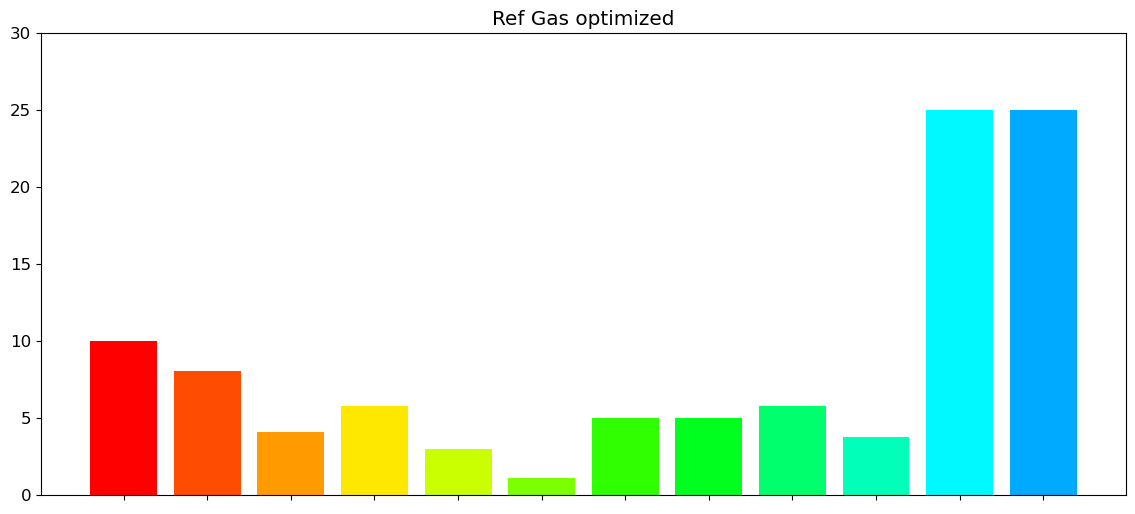

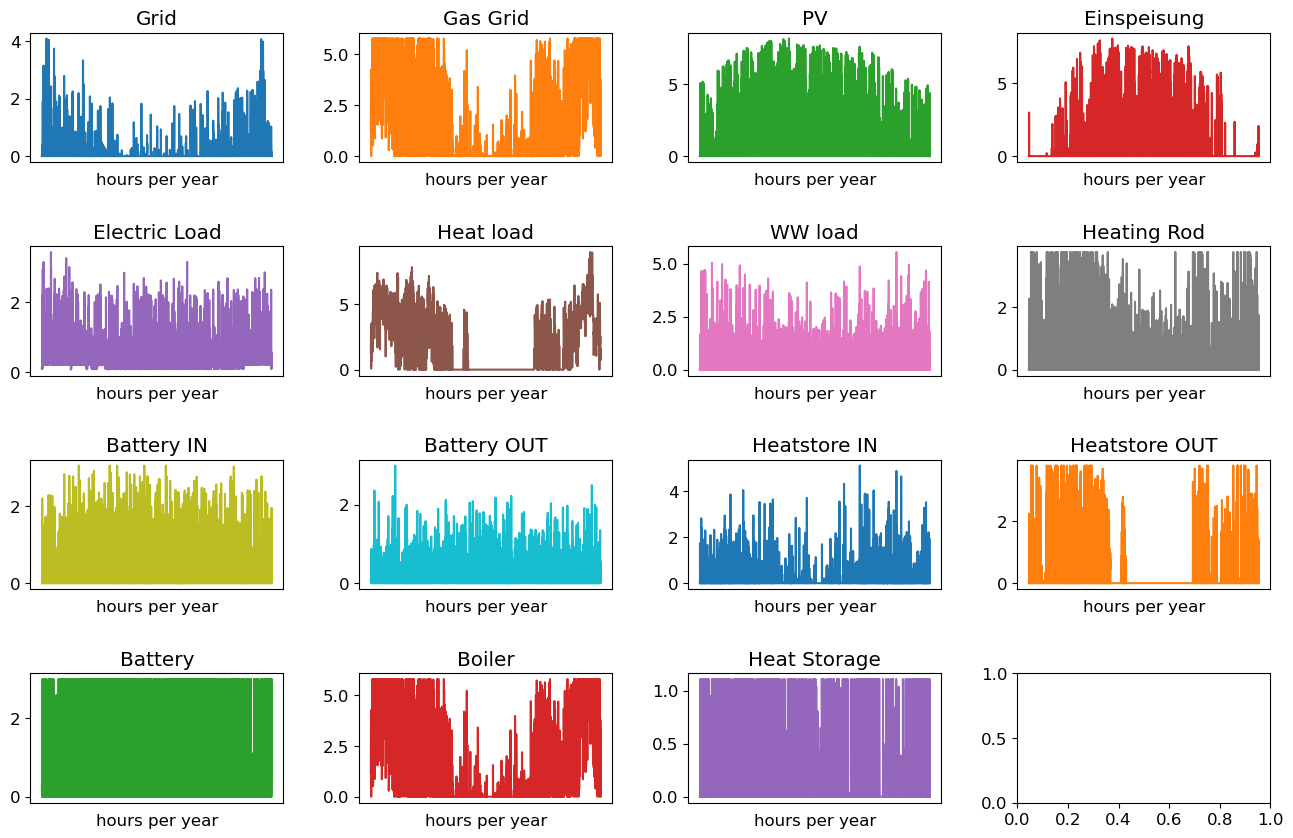

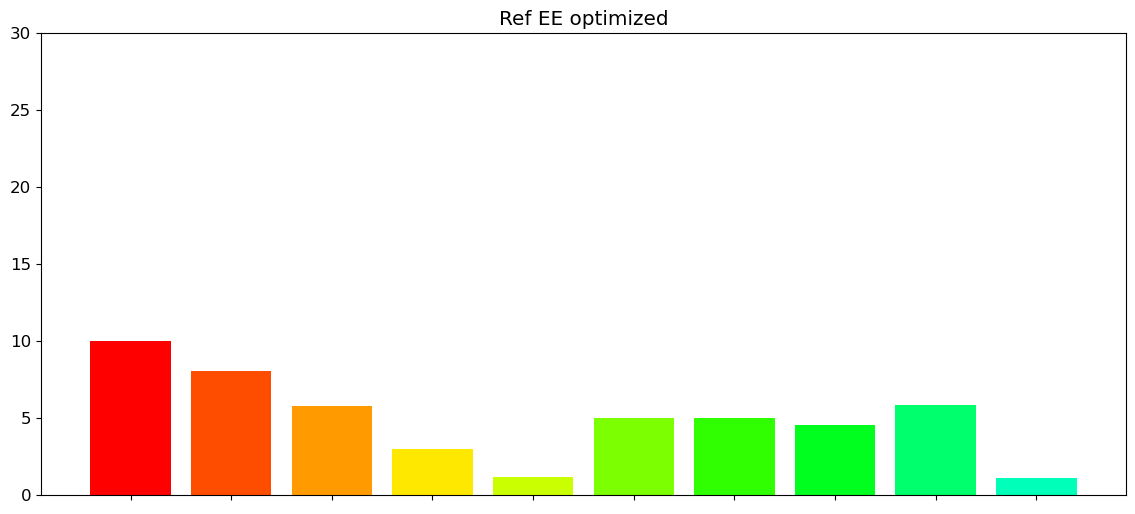

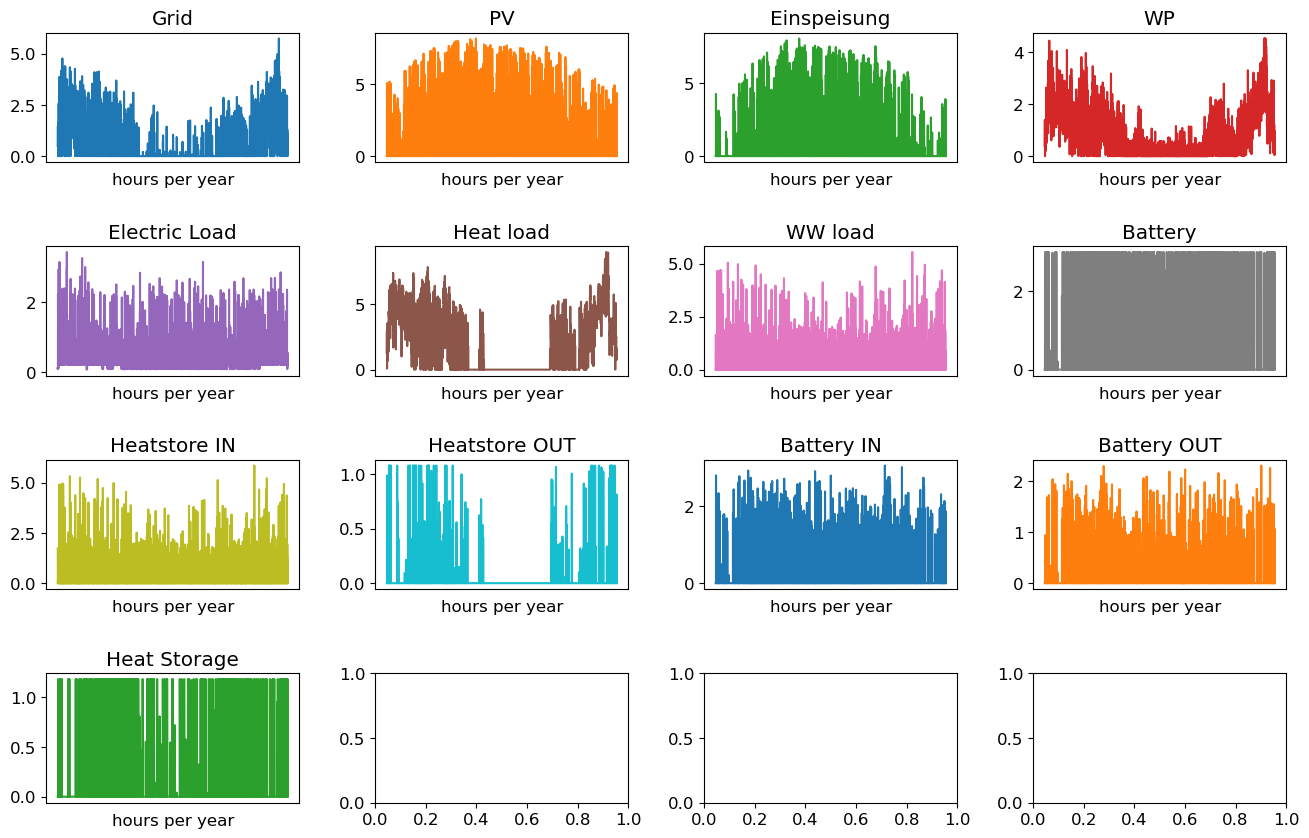

In [29]:
# setup reference networks and optimize
reference_gas = build_ref_network_gas(eload4, hload4, wwload4)
reference_ee = build_ref_network_ee(eload4, hload4, wwload4)
reference_gas.optimize(solver_name='gurobi')
reference_ee.optimize(solver_name='gurobi')
p_nom_opt_gas_boiler = reference_gas.links.p_nom_opt.gas_boiler
p_nom_opt_wp = reference_ee.links.p_nom_opt.wp
print("!----------------------------references set up------------------------------!")

ref_res_gas = result_summary_single_network(reference_gas, ref_gas=True, plots=True)
ref_res_ee = result_summary_single_network(reference_ee, ref=True, plots=True)
ref_gas_pp = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
ref_ee_pp = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
co2_start_ref_gas = ref_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
co2_start_ref_ee = ref_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']

print("!----------------------------results summarized------------------------------!")

del reference_gas
del reference_ee

%store ref_res_gas
%store ref_res_ee
%store ref_gas_pp
%store ref_ee_pp
%store co2_start_ref_gas
%store co2_start_ref_ee
%store p_nom_opt_gas_boiler
%store p_nom_opt_wp
print("\nPayback Period EE: ", ref_ee_pp, " Jahre")
print("\nPayback Period Gas: ", ref_gas_pp, " Jahre")

# Sensitivität Netzwerkverhalten
### Prequalifizierung

**Einfluss...** 
1) H2_Speichergröße
2) Leistung des Elektrolyseurs und der Brennstoffzellen
3) Reduzierung der CO2 (Referenz)
4) Gas-Netzwerk Boiler+Heating Rod (Referenz + H2)
5) EE-Netzwerk Wärmepumpe (Referenz + H2)



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------networks initialized------------------------------!
Current Capacity:  500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-i3o_9c57.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x26f4e080
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 256986 rows and 46735 columns
Presolve time: 0.40s
Presolved: 93431 rows, 110957 columns, 309475 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.17e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-eqltljg_.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x0b598b24
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 213183 rows and 37974 columns
Presolve time: 0.36s
Presolved: 84671 rows, 102196 columns, 283195 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.90e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Capacity:  1500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.79it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-a5tf42qw.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x24b7748e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 256986 rows and 46735 columns
Presolve time: 0.36s
Presolved: 93431 rows, 110957 columns, 309475 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.35e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-g1u4fe4r.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x4e5889d6
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 213183 rows and 37974 columns
Presolve time: 0.33s
Presolved: 84671 rows, 102196 columns, 283195 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.72e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Capacity:  2500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-sbils8vf.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x06ef9201
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 256986 rows and 46735 columns
Presolve time: 0.38s
Presolved: 93431 rows, 110957 columns, 309475 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.37e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-a4k7mw66.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xe87f664f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 213183 rows and 37974 columns
Presolve time: 0.35s
Presolved: 84671 rows, 102196 columns, 283195 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.65e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2812252948.py:34: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------results generated------------------------------!


EE Network: H2 Storage Capacity 500 kWh vs. 2500 kWh

EE Network: 500 kWh

EE Network: 2500 kWh


Gas Network: H2 Storage Capacity 500 kWh vs. 2500 kWh

Gas Network: 500 kWh

Gas Network: 2500 kWh
Stored 's_pq1_res_gas' (dict)
Stored 's_pq1_res_ee' (dict)
Stored 'df_s_pq1_res_gas' (DataFrame)
Stored 'df_s_pq1_res_ee' (DataFrame)


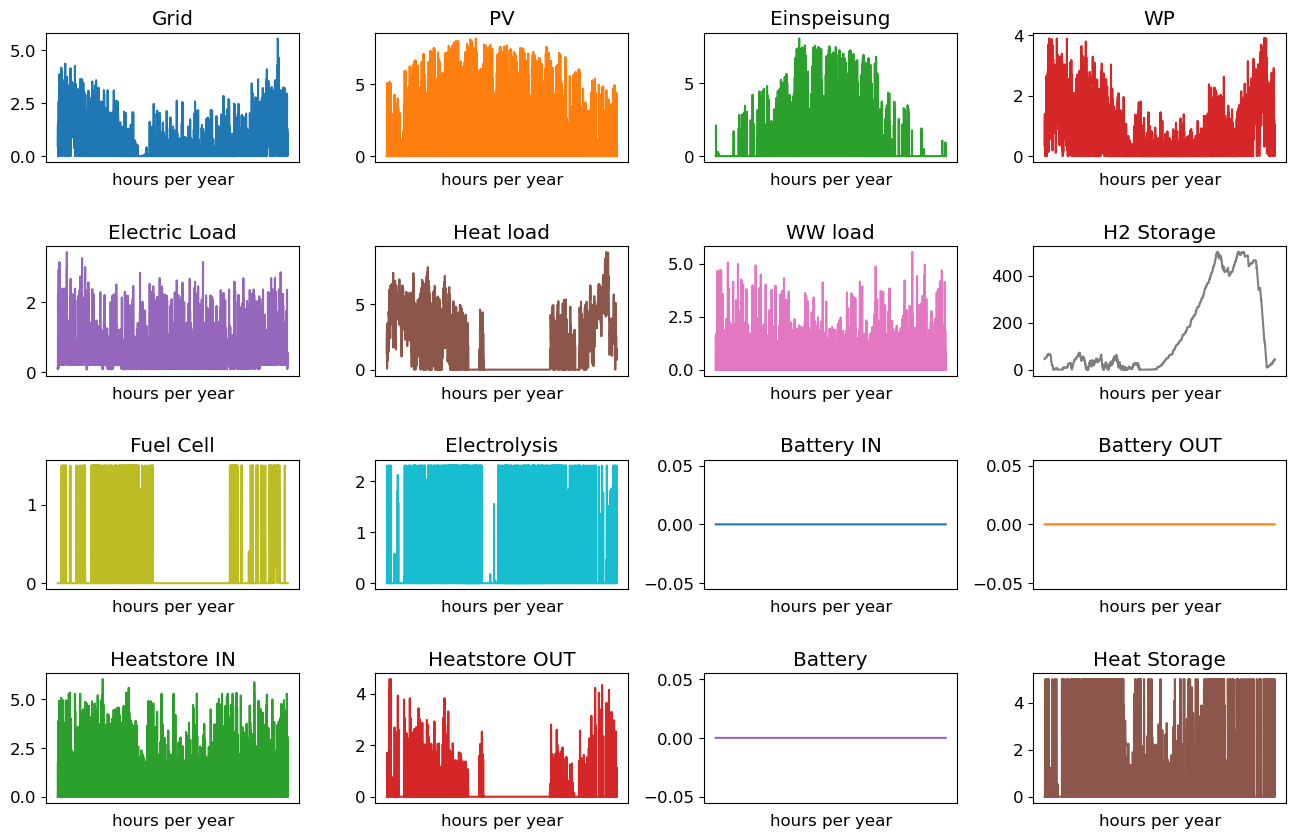

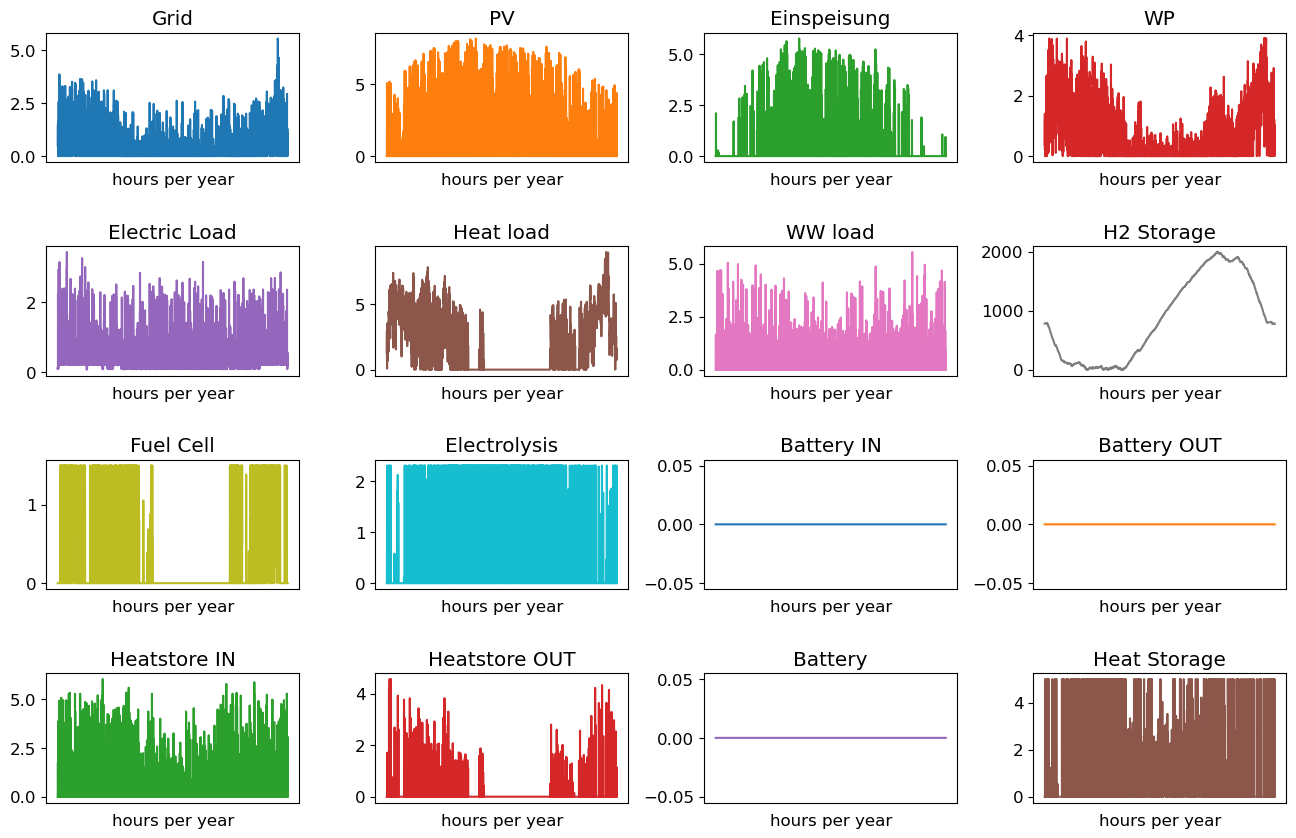

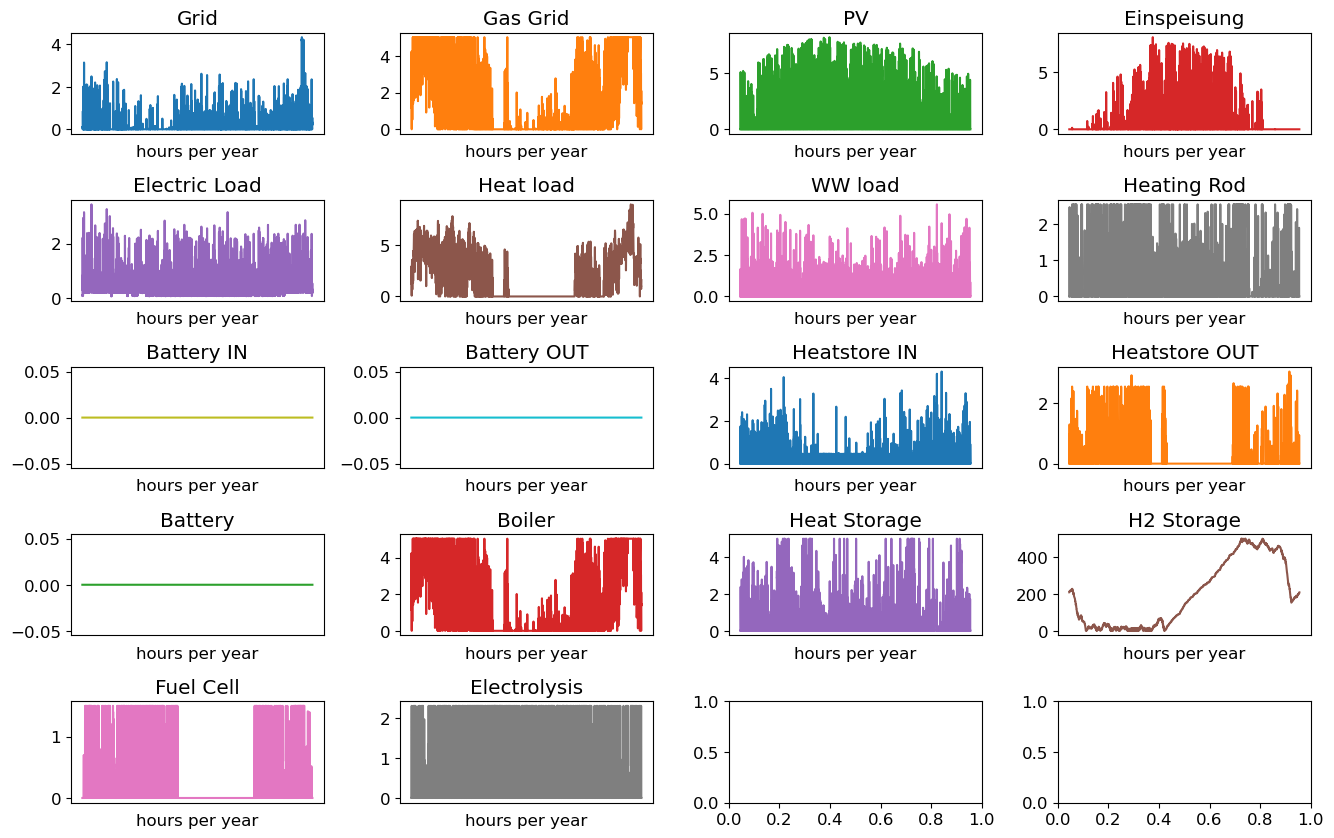

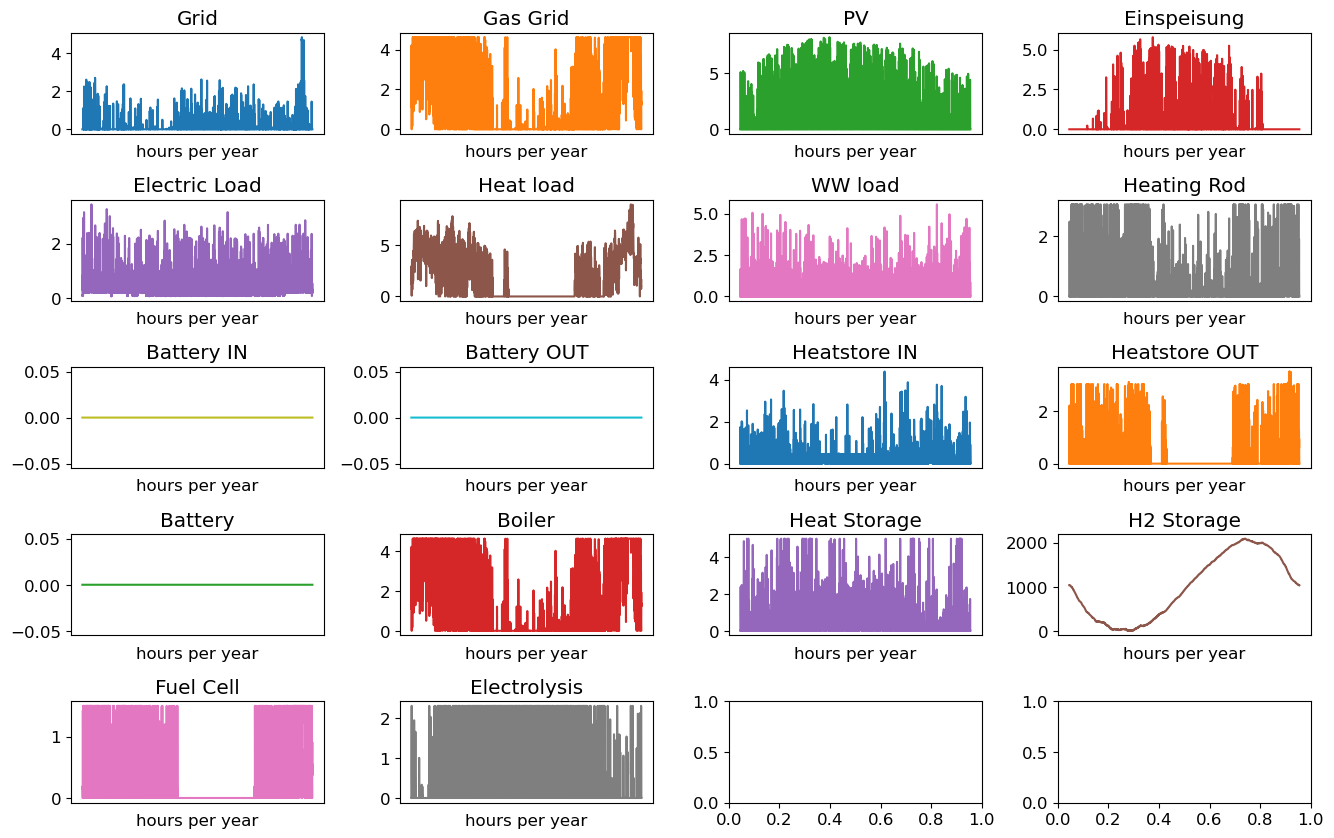

In [30]:
# 1) H2_Speichergröße (s_pq1)
# define result datasets
df_s_pq1_res_gas = pd.DataFrame()
df_s_pq1_res_ee = pd.DataFrame()

# setup networks
s_pq1_gas = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_gas.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_gas.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_gas.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_gas.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

s_pq1_ee = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq1_ee.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq1_ee.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s_pq1_ee.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s_pq1_ee.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']

print("!----------------------------networks initialized------------------------------!")

s_pq1_res_gas = {}
s_pq1_res_ee = {}
# looping over h2_storage capacity
for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+1, 1000):
    print('Current Capacity: ', capacity)
    s_pq1_gas.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_gas.optimize(solver_name='gurobi')
    s_pq1_res_gas[capacity] = result_summary_single_network(s_pq1_gas, h2_gas=True)
    df_s_pq1_res_gas = df_s_pq1_res_gas.append(result_summary_single_network(s_pq1_gas, h2_gas=True, sensitivity_variable=capacity))
    
    s_pq1_ee.stores.loc['h2_storage', 'e_nom'] = capacity
    s_pq1_ee.optimize(solver_name='gurobi')
    s_pq1_res_ee[capacity] = result_summary_single_network(s_pq1_ee, h2=True)
    df_s_pq1_res_ee = df_s_pq1_res_ee.append(result_summary_single_network(s_pq1_ee, h2=True, sensitivity_variable=capacity))

print("!----------------------------results generated------------------------------!")



print("\n\nEE Network: H2 Storage Capacity 500 kWh vs. 2500 kWh")
print("\nEE Network: 500 kWh")
plot_series_data(s_pq1_res_ee[500][0])
print("\nEE Network: 2500 kWh")
plot_series_data(s_pq1_res_ee[2500][0])

print("\n\nGas Network: H2 Storage Capacity 500 kWh vs. 2500 kWh")
print("\nGas Network: 500 kWh")
plot_series_data(s_pq1_res_gas[500][0])
print("\nGas Network: 2500 kWh")
plot_series_data(s_pq1_res_gas[2500][0])

%store s_pq1_res_gas
%store s_pq1_res_ee
%store df_s_pq1_res_gas
%store df_s_pq1_res_ee

del s_pq1_gas
del s_pq1_ee
del s_pq1_res_gas
del s_pq1_res_ee
del df_s_pq1_res_gas
del df_s_pq1_res_ee

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------networks initialized------------------------------!
Current H2 component Power Multiplier:  1


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-fk82ktj1.lp
Reading time = 0.80 seconds
obj: 350415 rows, 157690 columns, 665774 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350415 rows, 157690 columns and 665774 nonzeros
Model fingerprint: 0x2bffed2c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 3e+02]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 271575 rows and 46735 columns
Presolve time: 0.36s
Presolved: 78840 rows, 110955 columns, 280293 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157690 primals, 350415 duals
Objective: -1.37e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3444.20
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8127.27
PV own consumption ratio [%]            75.78
Amount Infeed [kWh/a]                 2597.55
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  959.79
Grid gas [kWh/a]                     14988.38
Ratio electric [%]                       6.02
Ratio gas [%]                           93.98
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           1468.67
H2 stored [kWh/a]                     3202.18
converted to H2 [kWh/a]               4574.55
H2 used [kWh/a]                       3115.39
Heat from H2 [kWh/a]                  1849.53
Self Sufficiency [%]                    33.28
CAPEX [€]                           171422.52
OPEX [€/a]                            2752.08
Revenue Infeed [€/a]                  -184.43
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.66it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-cdt34857.lp
Reading time = 0.63 seconds
obj: 297852 rows, 140168 columns, 569411 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297852 rows, 140168 columns and 569411 nonzeros
Model fingerprint: 0x49fc4a8b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 227772 rows and 37974 columns
Presolve time: 0.32s
Presolved: 70080 rows, 102194 columns, 254013 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140168 primals, 297852 duals
Objective: 2.65e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   2285.85
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7651.68
PV own consumption ratio [%]            71.35
Amount Infeed [kWh/a]                 3073.14
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5266.94
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2964.46
H2 stored [kWh/a]                     3294.28
converted to H2 [kWh/a]               4706.12
H2 used [kWh/a]                       3218.89
Heat from H2 [kWh/a]                  1906.89
Self Sufficiency [%]                    77.96
CAPEX [€]                           176124.48
OPEX [€/a]                            2106.78
Revenue Infeed [€/a]                  -218.19
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current H2 component Power Multiplier:  5


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.69it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-o4nj0oic.lp
Reading time = 0.73 seconds
obj: 350415 rows, 157690 columns, 665774 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350415 rows, 157690 columns and 665774 nonzeros
Model fingerprint: 0xce1d5fe3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 3e+02]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 271575 rows and 46735 columns
Presolve time: 0.36s
Presolved: 78840 rows, 110955 columns, 280293 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157690 primals, 350415 duals
Objective: -1.71e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3119.78
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9798.75
PV own consumption ratio [%]            91.37
Amount Infeed [kWh/a]                  926.07
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  408.30
Grid gas [kWh/a]                     14567.19
Ratio electric [%]                       2.73
Ratio gas [%]                           97.27
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2204.57
H2 stored [kWh/a]                     5598.93
converted to H2 [kWh/a]               7998.46
H2 used [kWh/a]                       5502.11
Heat from H2 [kWh/a]                  3250.33
Self Sufficiency [%]                    37.35
CAPEX [€]                           415920.92
OPEX [€/a]                            2464.94
Revenue Infeed [€/a]                   -65.75
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ubnub87a.lp
Reading time = 0.64 seconds
obj: 297852 rows, 140168 columns, 569411 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297852 rows, 140168 columns and 569411 nonzeros
Model fingerprint: 0xae9c9c0c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 227772 rows and 37974 columns
Presolve time: 0.32s
Presolved: 70080 rows, 102194 columns, 254013 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140168 primals, 297852 duals
Objective: -2.58e+02
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   2115.92
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9162.25
PV own consumption ratio [%]            85.43
Amount Infeed [kWh/a]                 1562.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4875.38
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           3109.05
H2 stored [kWh/a]                     5096.92
converted to H2 [kWh/a]               7281.31
H2 used [kWh/a]                       4995.09
Heat from H2 [kWh/a]                  2954.79
Self Sufficiency [%]                    79.60
CAPEX [€]                           417931.65
OPEX [€/a]                            1950.15
Revenue Infeed [€/a]                  -110.94
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current H2 component Power Multiplier:  9


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.33it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-u81d8r0g.lp
Reading time = 0.76 seconds
obj: 350415 rows, 157690 columns, 665774 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350415 rows, 157690 columns and 665774 nonzeros
Model fingerprint: 0xbd1d8e38
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 3e+02]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 271575 rows and 46735 columns
Presolve time: 0.34s
Presolved: 78840 rows, 110955 columns, 280293 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157690 primals, 350415 duals
Objective: -1.71e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3120.73
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9802.04
PV own consumption ratio [%]            91.40
Amount Infeed [kWh/a]                  922.78
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  402.66
Grid gas [kWh/a]                     14584.06
Ratio electric [%]                       2.69
Ratio gas [%]                           97.31
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2220.24
H2 stored [kWh/a]                     5660.63
converted to H2 [kWh/a]               8086.61
H2 used [kWh/a]                       5563.91
Heat from H2 [kWh/a]                  3286.50
Self Sufficiency [%]                    37.30
CAPEX [€]                           660581.60
OPEX [€/a]                            2465.35
Revenue Infeed [€/a]                   -65.52
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-qymip434.lp
Reading time = 0.63 seconds
obj: 297852 rows, 140168 columns, 569411 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297852 rows, 140168 columns and 569411 nonzeros
Model fingerprint: 0x558735bf
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [6e+03, 6e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 227772 rows and 37974 columns
Presolve time: 0.30s
Presolved: 70080 rows, 102194 columns, 254013 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140168 primals, 297852 duals
Objective: -4.18e+02
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   2433.54
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9163.34
PV own consumption ratio [%]            85.44
Amount Infeed [kWh/a]                 1561.48
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5607.24
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           3034.83
H2 stored [kWh/a]                     6315.34
converted to H2 [kWh/a]               9021.91
H2 used [kWh/a]                       6224.25
Heat from H2 [kWh/a]                  3671.66
Self Sufficiency [%]                    76.54
CAPEX [€]                           662143.02
OPEX [€/a]                            2242.89
Revenue Infeed [€/a]                  -110.86
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\4268373417.py:36: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



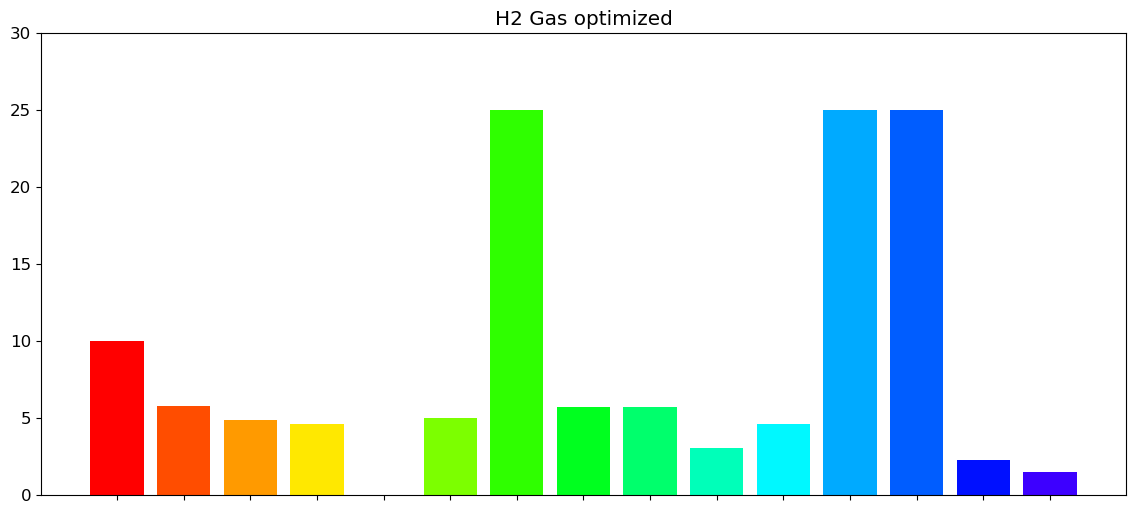

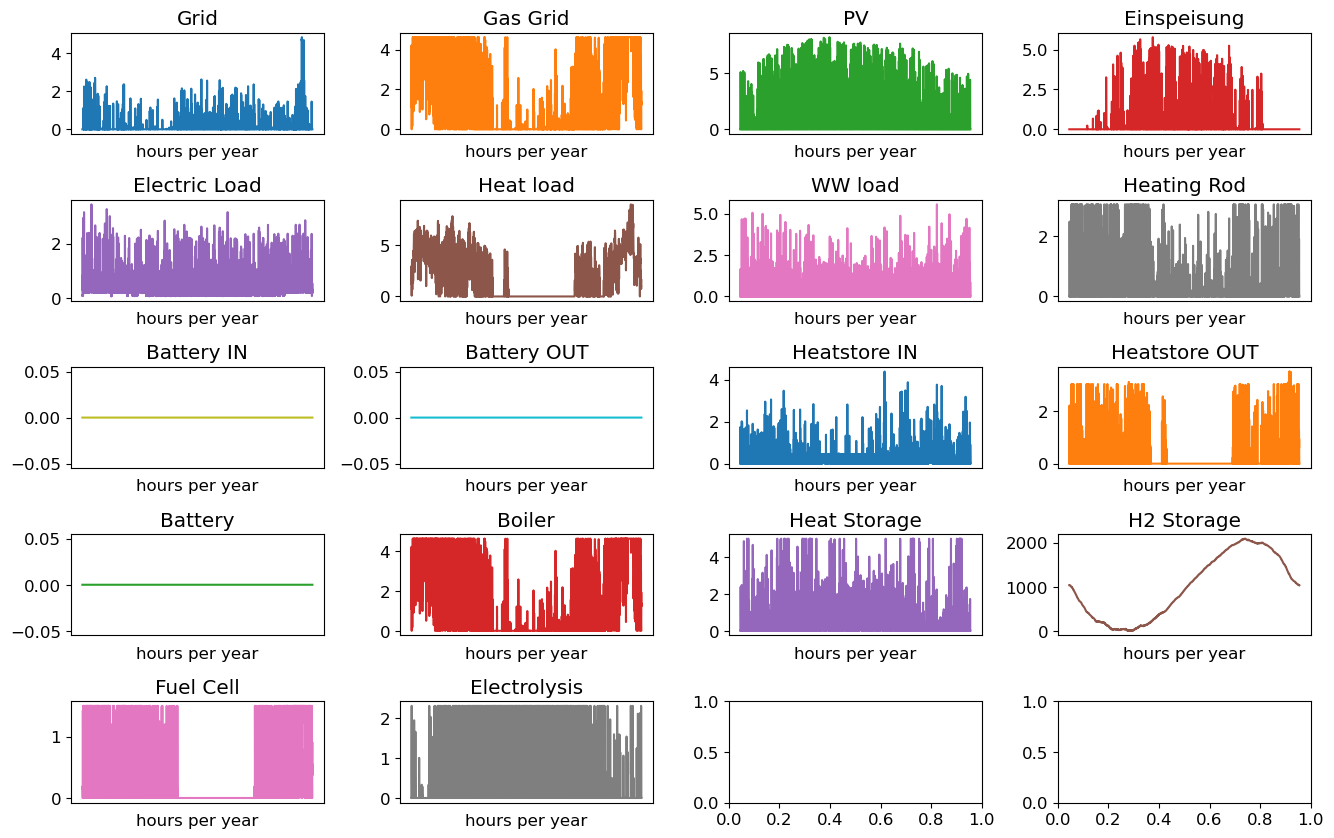

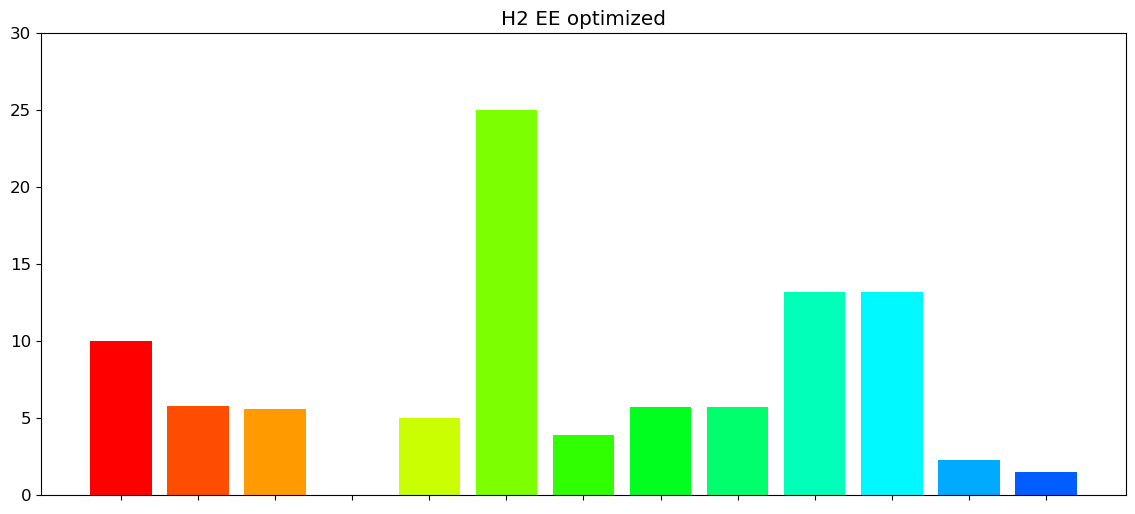

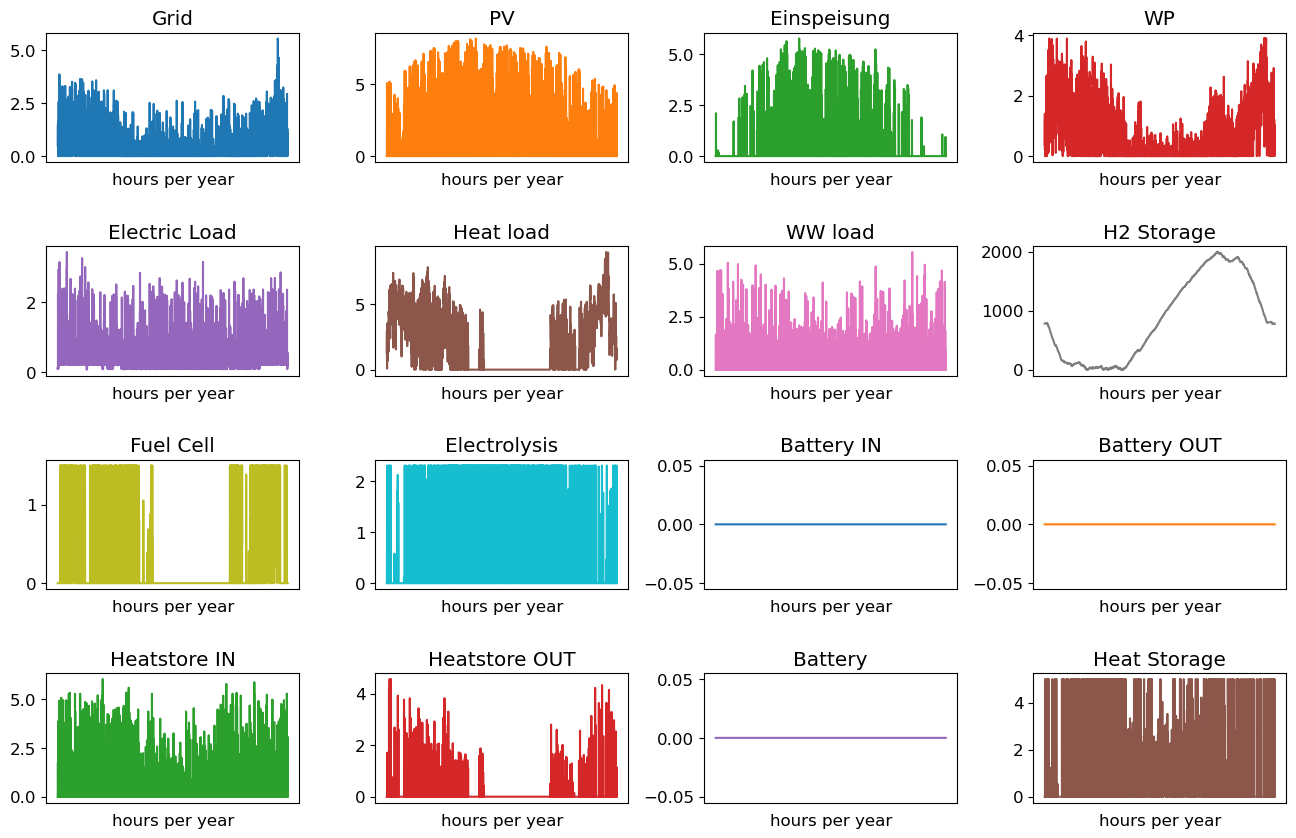

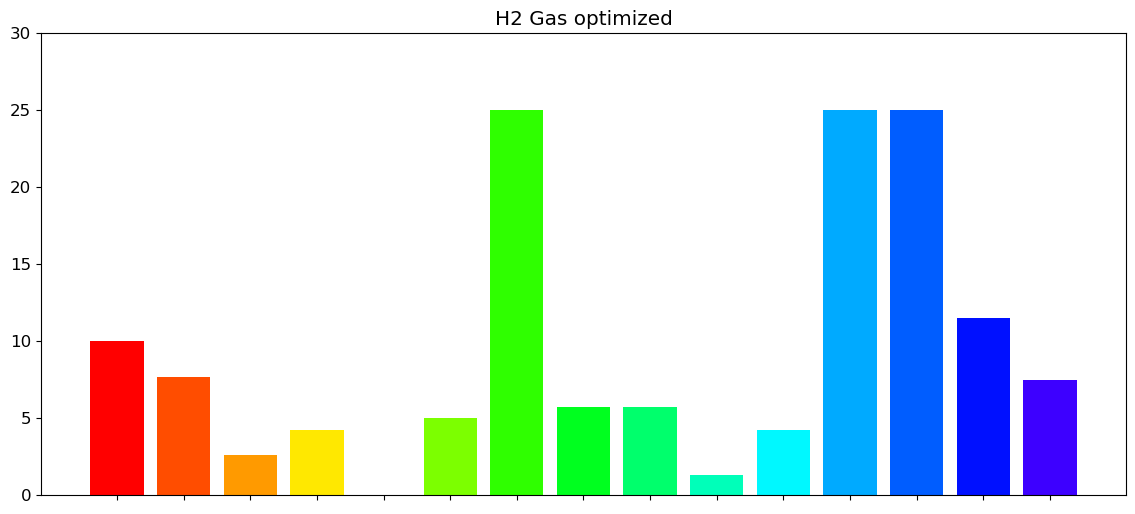

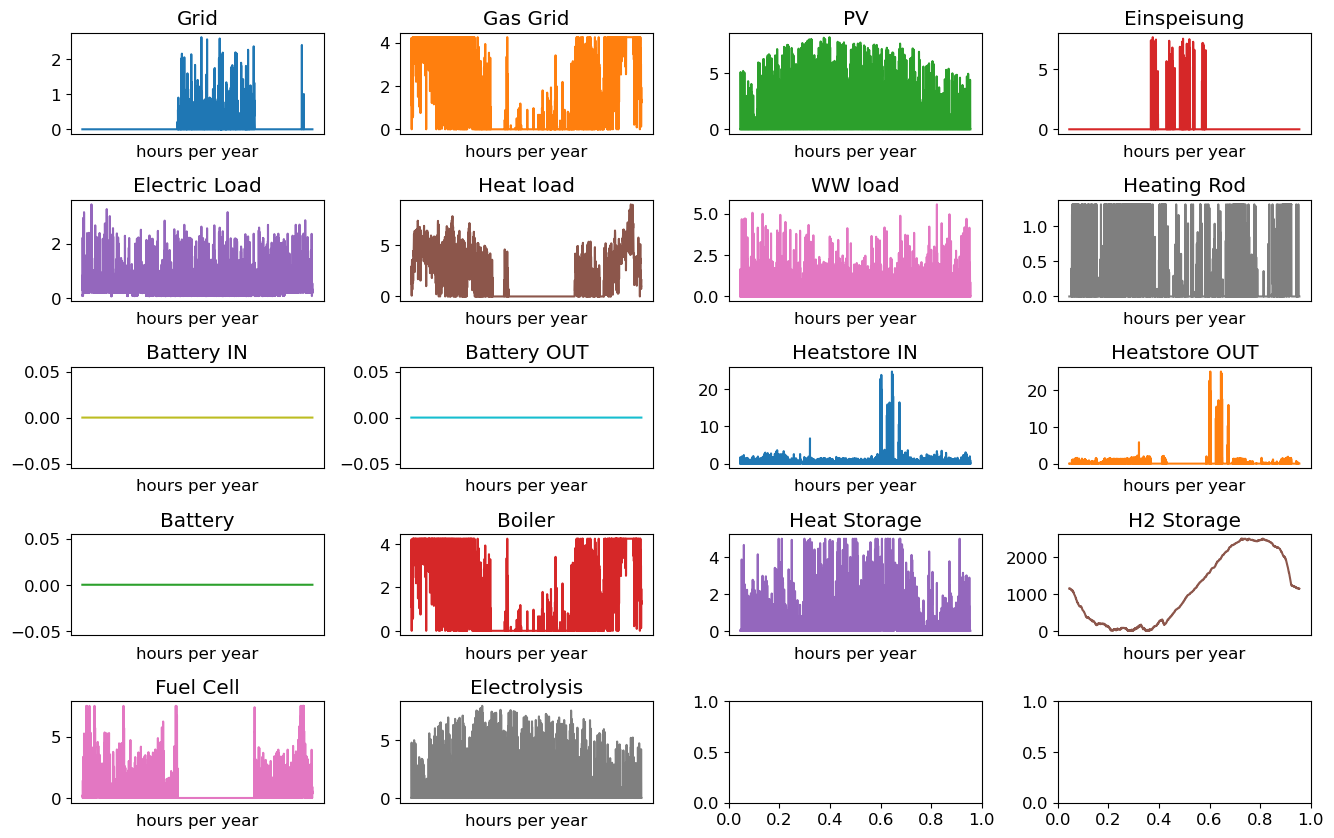

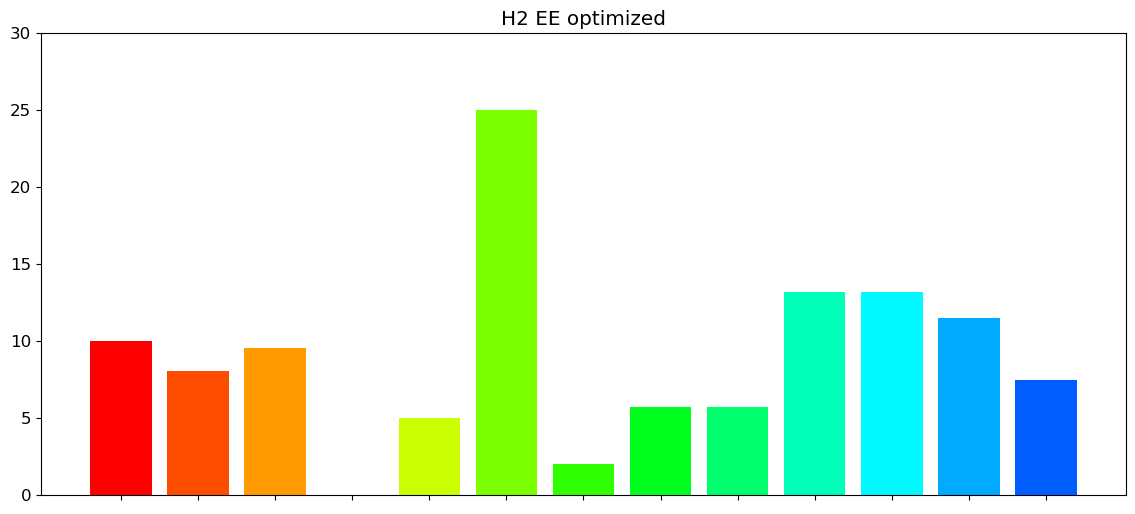

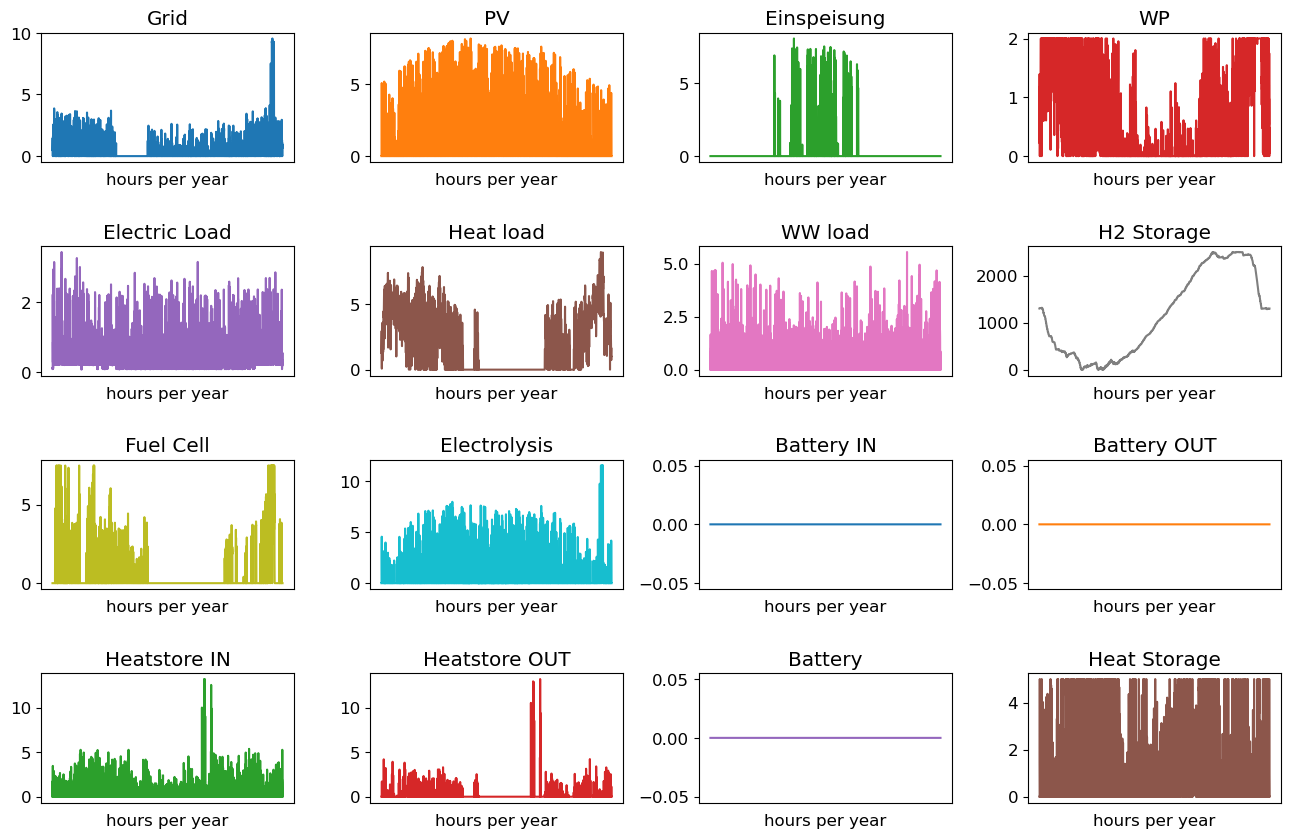

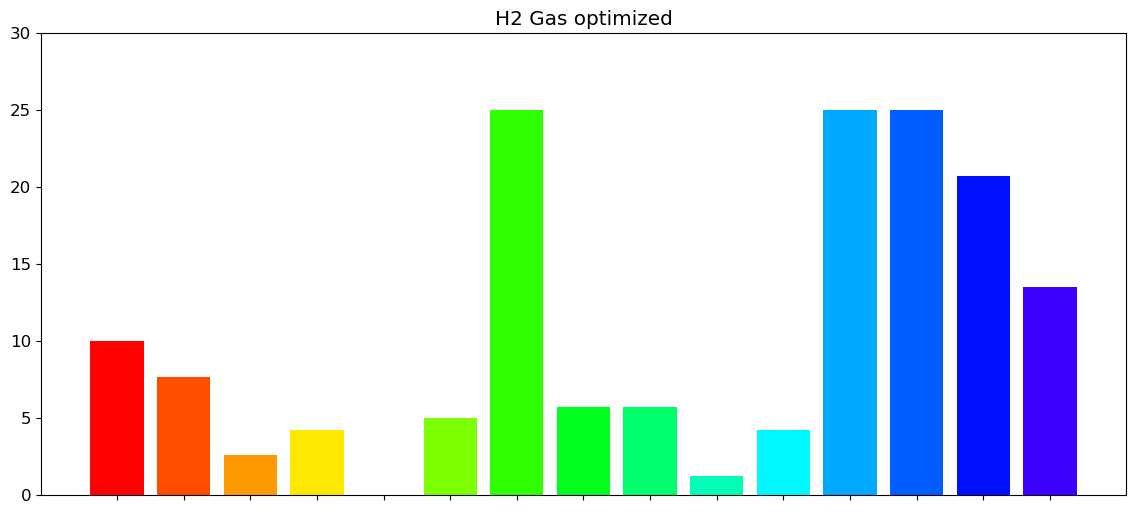

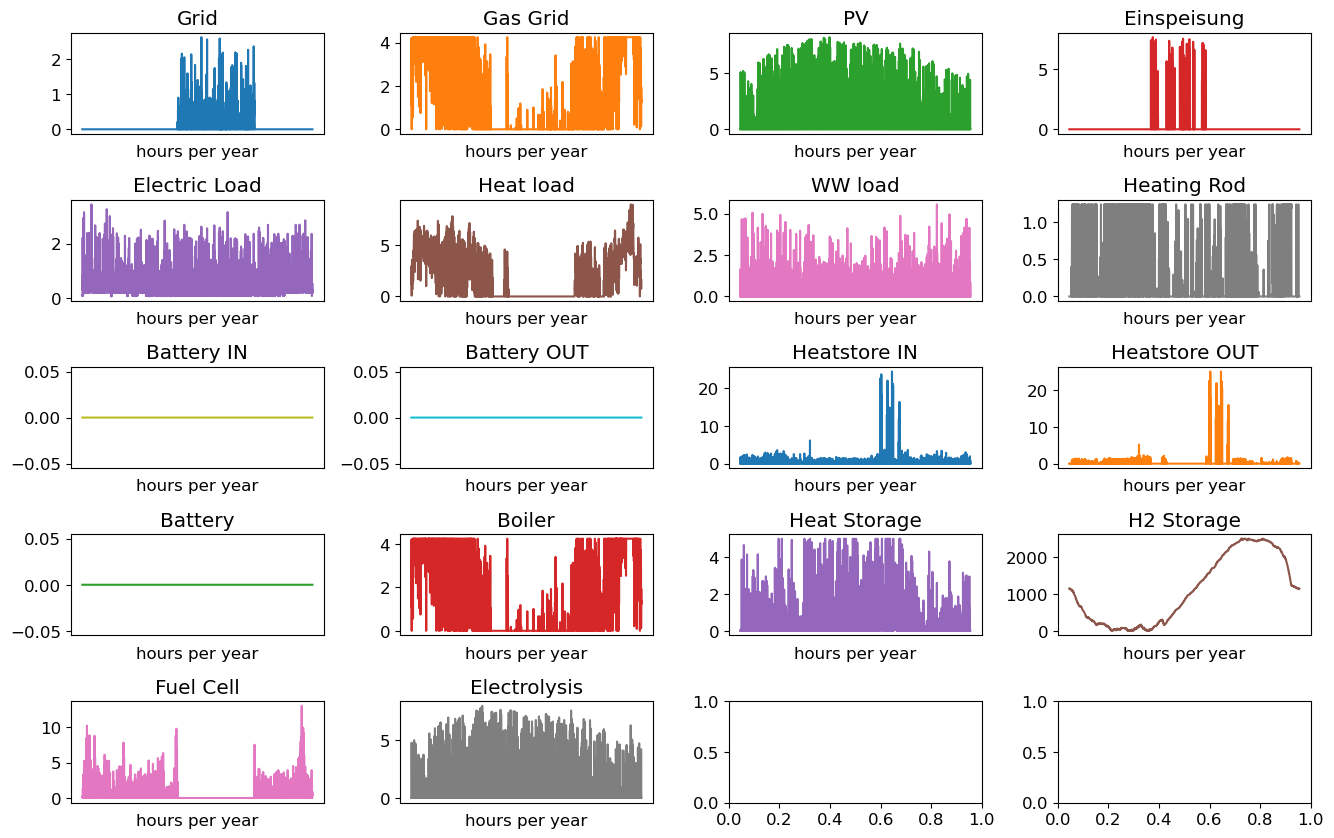

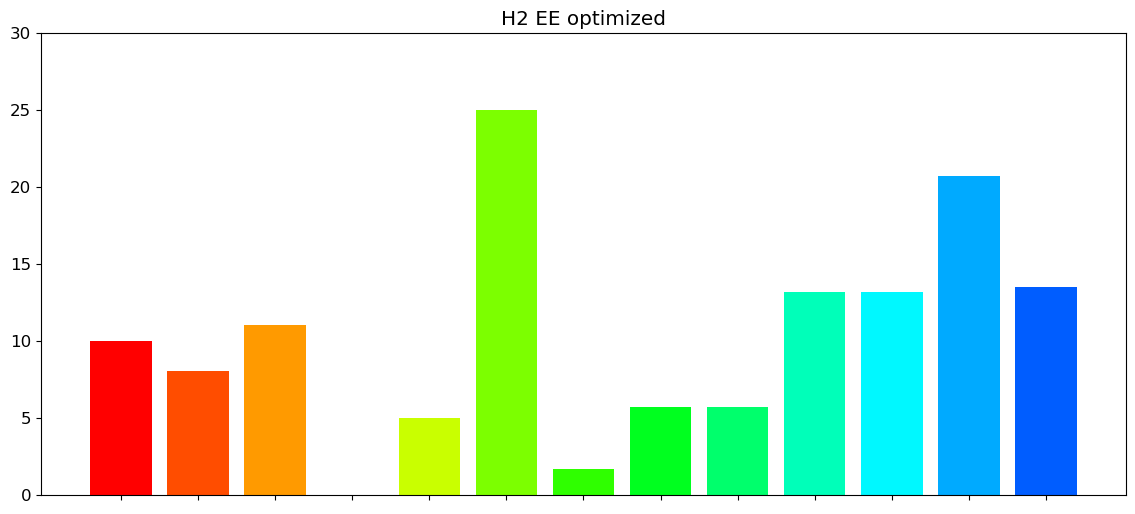

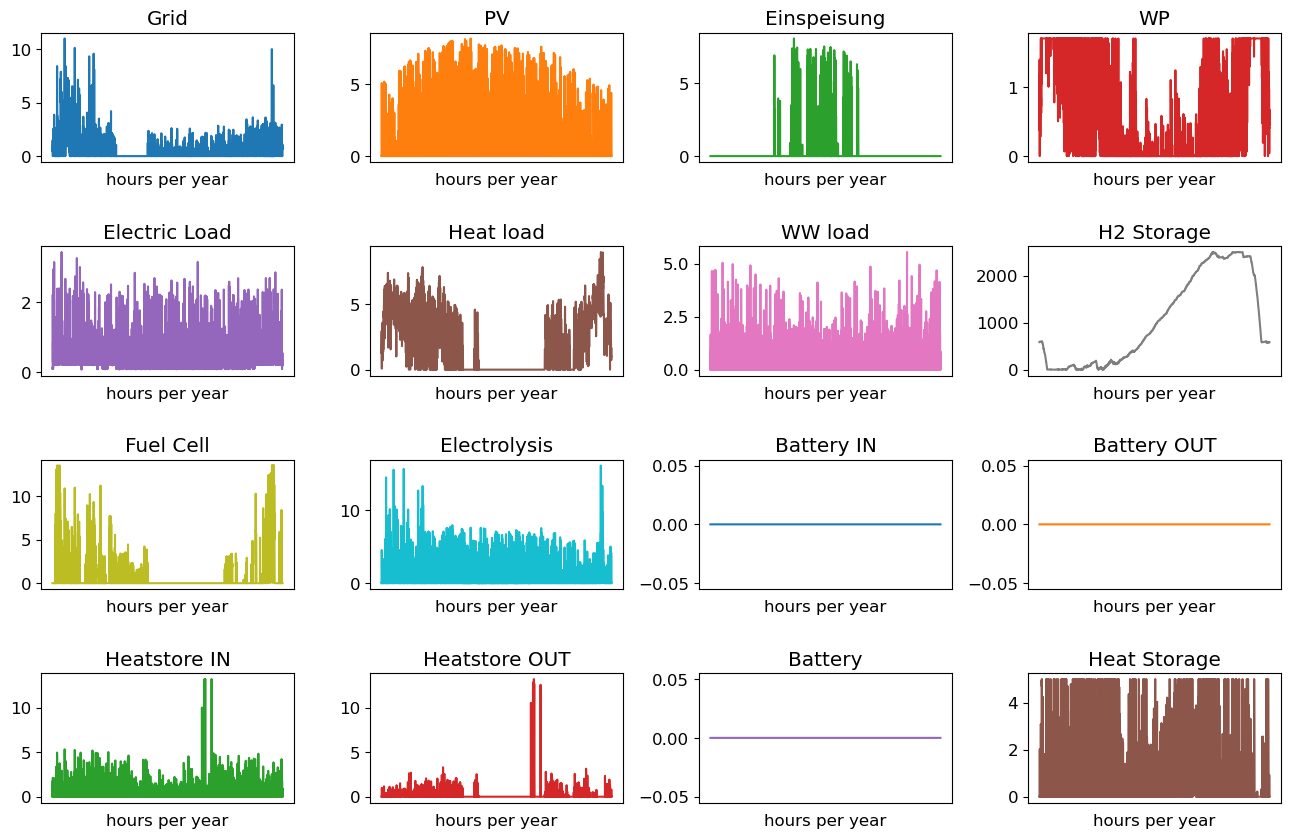

In [31]:
# 2) Leistung des Elektrolyseurs und der Brennstoffzellen (s_pq2)
# define result datasets
df_s_pq2_res_gas = pd.DataFrame()
df_s_pq2_res_ee = pd.DataFrame()

# setup networks
s_pq2_gas = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq2_gas.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq2_gas.stores.loc['h2_storage', 'e_nom'] = h2_storage_params['e_nom_max']
s_pq2_gas.links.loc['ely', 'p_nom_extendable'] = False
s_pq2_gas.links.loc['fc', 'p_nom_extendable'] = False

s_pq2_ee = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq2_ee.stores.loc['h2_storage', 'e_nom_extendable'] = False
s_pq2_ee.stores.loc['h2_storage', 'e_nom'] = h2_storage_params['e_nom_max']
s_pq2_ee.links.loc['ely', 'p_nom_extendable'] = False
s_pq2_ee.links.loc['fc', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")

s_pq2_res_gas = {}
s_pq2_res_ee = {}
# looping over h2_storage capacity
for h2_power in np.arange(1, 10, 4):
    print('Current H2 component Power Multiplier: ', h2_power)
    s_pq2_gas.links.loc['ely', 'p_nom'] = ely_params['p_nom'] * h2_power
    s_pq2_gas.links.loc['fc', 'p_nom'] = fc_params['p_nom'] * h2_power
    s_pq2_gas.optimize(solver_name='gurobi')
    s_pq2_res_gas[h2_power] = result_summary_single_network(s_pq2_gas, h2_gas=True, plots=True)
    df_s_pq2_res_gas = df_s_pq2_res_gas.append(result_summary_single_network(s_pq2_gas, h2_gas=True, sensitivity_variable=h2_power))
    
    s_pq2_ee.links.loc['ely', 'p_nom'] = ely_params['p_nom'] * h2_power
    s_pq2_ee.links.loc['fc', 'p_nom'] = fc_params['p_nom'] * h2_power
    s_pq2_ee.optimize(solver_name='gurobi')
    s_pq2_res_ee[h2_power] = result_summary_single_network(s_pq2_ee, h2=True, plots=True)
    df_s_pq2_res_ee = df_s_pq2_res_ee.append(result_summary_single_network(s_pq2_ee, h2=True, sensitivity_variable=h2_power))

print("!----------------------------results generated------------------------------!")
print('\n Gas: ', df_s_pq2_res_gas)
print('\n\n\n\n EE: ', df_s_pq2_res_ee)

%store s_pq2_res_gas
%store s_pq2_res_ee
%store df_s_pq2_res_gas
%store df_s_pq2_res_ee

del s_pq2_gas
del s_pq2_ee
del s_pq2_res_gas
del s_pq2_res_ee
del df_s_pq2_res_gas
del df_s_pq2_res_ee

In [32]:
# 3) CO2-Emissionen Referenz (s_pq3)
# define result datasets
df_s_pq3_res_gas = pd.DataFrame()
df_s_pq3_res_ee = pd.DataFrame()

# setup networks
s_pq3_gas = build_ref_network_gas(eload4, hload4, wwload4)
s_pq3_gas.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq3_gas.links.loc['heating_rod', 'p_nom_max'] = np.inf

s_pq3_ee = build_ref_network_ee(eload4, hload4, wwload4)
s_pq3_ee.links.loc['wp', 'p_nom_max'] = np.inf
print("!----------------------------networks initialized------------------------------!")

# loop reduce CO2 percentage and stop optimizing, when not feasible anymore
for co2_lim in np.arange(1, 0.09, -0.1):
    co2_id = np.round(co2_lim * 100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_gas)
    s_pq3_gas.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_gas
    s_pq3_gas.optimize(solver_name='gurobi')
    df_s_pq3_res_gas = df_s_pq3_res_gas.append(result_summary_single_network(s_pq3_gas, ref_gas=True, sensitivity_variable=co2_id))
    if df_s_pq3_res_gas.shape[0] >= 2:
        if df_s_pq3_res_gas['CO2-Emission [kg/a]'].min() == df_s_pq3_res_gas.loc[df_s_pq3_res_gas.index[-2], 'CO2-Emission [kg/a]']:
             break
for co2_lim in np.arange(1, 0.09, -0.1):
    co2_id = np.round(co2_lim * 100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_ee)
    s_pq3_ee.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_ee
    s_pq3_ee.optimize(solver_name='gurobi')
    df_s_pq3_res_ee = df_s_pq3_res_ee.append(result_summary_single_network(s_pq3_ee, ref=True, sensitivity_variable=co2_id))
    if df_s_pq3_res_ee.shape[0] >= 2:
        if df_s_pq3_res_ee['CO2-Emission [kg/a]'].min() == df_s_pq3_res_ee.loc[df_s_pq3_res_ee.index[-2], 'CO2-Emission [kg/a]']:
             break            
print("!----------------------------results generated------------------------------!")
print('\n Gas: ', df_s_pq3_res_gas)
print('\n\n\n\n EE: ', df_s_pq3_res_ee)

%store df_s_pq3_res_gas
%store df_s_pq3_res_ee

del s_pq3_gas
del s_pq3_ee
del df_s_pq3_res_gas
del df_s_pq3_res_ee


!----------------------------networks initialized------------------------------!
Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  3846.24


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-goecfia9.lp
Reading time = 0.71 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x6680a740
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 4e+03]
Presolve removed 201491 rows and 35046 columns
Presolve time: 0.31s
Presolved: 70081 rows, 87604 columns, 236520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.664e+05
 Factor NZ  : 9.635e+05 (roughly 70 MB of memory)
 Factor Ops : 1.37

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 90.0%: 
Current CO2 Value [kg/a]:  3461.616


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 20.95it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-8024ixo4.lp
Reading time = 0.58 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x2e845f82
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+03]
Presolve removed 201491 rows and 35046 columns
Presolve time: 0.29s
Presolved: 70081 rows, 87604 columns, 236520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.664e+05
 Factor NZ  : 9.635e+05 (roughly 70 MB of memory)
 Factor Ops : 1.37

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 8.83e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 80.0%: 
Current CO2 Value [kg/a]:  3076.992


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 20.90it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-tk3r86gj.lp
Reading time = 0.59 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x76bcb506
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+03]
Presolve removed 201491 rows and 35046 columns
Presolve time: 0.28s
Presolved: 70081 rows, 87604 columns, 236520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.664e+05
 Factor NZ  : 9.635e+05 (roughly 70 MB of memory)
 Factor Ops : 1.37


Solved in 21849 iterations and 11.22 seconds (3.46 work units)
Optimal objective  2.842146178e+05


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 2.84e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 70.0%: 
Current CO2 Value [kg/a]:  2692.368


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.55it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-cjz0lzev.lp
Reading time = 0.55 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x6c76ae3d
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+03]
Presolve removed 201491 rows and 35046 columns
Presolve time: 0.26s
Presolved: 70081 rows, 87604 columns, 236520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.664e+05
 Factor NZ  : 9.635e+05 (roughly 70 MB of memory)
 Factor Ops : 1.37

Optimal objective  1.457006026e+06


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 1.46e+06
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 60.0%: 
Current CO2 Value [kg/a]:  2307.744


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.46it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-xoex5q7o.lp
Reading time = 0.56 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x7ee92b0f
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 2e+03]
Presolve removed 201491 rows and 35046 columns
Presolve time: 0.27s
Presolved: 70081 rows, 87604 columns, 236520 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 1.664e+05
 Factor NZ  : 9.635e+05 (roughly 70 MB of memory)
 Factor Ops : 1.37

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  2983.21


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:21: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-idr3nsp_.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x8b282a3f
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.28s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 90.0%: 
Current CO2 Value [kg/a]:  2684.889


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.68it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-nujus9oz.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x40561a0b
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.30s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.18e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 80.0%: 
Current CO2 Value [kg/a]:  2386.568


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.30it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bwedd84k.lp
Reading time = 0.49 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x3ec91ab4
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 2e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.31s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.58e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 70.0%: 
Current CO2 Value [kg/a]:  2088.2470000000003


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.04it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-y2mi0dse.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x5ecd20a4
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 2e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.30s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

  95   6.98571895e+04  7.00280991e+04  4.29e-01 5.91e-13  9.97e-05    11s
  96   6.98649052e+04  7.00291586e+04  4.09e-01 3.15e-12  9.48e-05    11s
  97   6.98656309e+04  7.00319710e+04  4.07e-01 4.17e-12  9.57e-05    11s
  98   6.98656979e+04  7.00291485e+04  4.07e-01 3.77e-12  9.41e-05    11s
  99   6.98728241e+04  7.00295440e+04  3.90e-01 9.44e-12  9.81e-05    12s
 100   6.99279944e+04  7.00275907e+04  2.54e-01 1.98e-12  7.45e-05    12s
 101   6.99809973e+04  7.00293998e+04  1.28e-01 7.32e-12  5.24e-05    12s
 102   7.00031907e+04  7.00304303e+04  7.34e-02 1.10e-11  3.61e-05    12s
 103   7.00154172e+04  7.00308954e+04  4.67e-02 6.48e-12  3.97e-05    12s
 104   7.00206972e+04  7.00307616e+04  3.23e-02 1.81e-12  3.14e-05    12s
 105   7.00230801e+04  7.00316876e+04  2.64e-02 7.87e-12  2.30e-05    12s
 106   7.00261289e+04  7.00324018e+04  1.80e-02 2.51e-12  1.27e-05    12s
 107   7.00275674e+04  7.00325223e+04  1.57e-02 1.42e-12  1.53e-05    13s
 108   7.00309504e+04  7.00326340e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 7.00e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 60.0%: 
Current CO2 Value [kg/a]:  1789.9260000000004


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.42it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-dgwri39_.lp
Reading time = 0.46 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x21f987bd
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 2e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.29s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 4.43e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 50.0%: 
Current CO2 Value [kg/a]:  1491.6050000000002


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.55it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-qntrxf4o.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x4c4cb327
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.28s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 8.19e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 40.0%: 
Current CO2 Value [kg/a]:  1193.2840000000003


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.34it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-wrpelhtq.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x05e86c3d
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+03]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.28s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.20e+06
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 30.0%: 
Current CO2 Value [kg/a]:  894.9630000000004


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.86it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-m6m2veew.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0xe851aa4b
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 9e+02]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.29s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.58e+06
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 20.0%: 
Current CO2 Value [kg/a]:  596.6420000000005


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.32it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-qmiw5998.lp
Reading time = 0.46 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x76c7445b
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 6e+02]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.27s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.96e+06
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current CO2: 10.0%: 
Current CO2 Value [kg/a]:  298.3210000000006


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.63it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-2e9dglck.lp
Reading time = 0.46 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0xbae2c533
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 3e+02]
Presolve removed 170177 rows and 33745 columns
Presolve time: 0.27s
Presolved: 57591 rows, 71383 columns, 186560 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 3
 AA' NZ     : 1.277e+05
 Factor NZ  : 7.460e+05 (roughly 60 MB of memory)
 Factor Ops : 1.01

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



!----------------------------results generated------------------------------!

 Gas:         CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
100.0              3846.24              10724.82          5091.08   
90.0               3461.62              10724.82          6411.35   
80.0               3076.99              10724.82          7662.74   
70.0               2692.37              10724.82          9992.41   
60.0               2692.37              10724.82          9992.41   

       PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
100.0                         47.47                5633.74   
90.0                          59.78                4313.47   
80.0                          71.45                3062.08   
70.0                          93.17                 732.41   
60.0                          93.17                 732.41   

       Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
100.0            23901.99                1255.58        

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3896433937.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 20.90it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-gdxhr8_f.lp
Reading time = 0.58 seconds
obj: 271573 rows, 122650 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271573 rows, 122650 columns and 516852 nonzeros
Model fingerprint: 0xb56dcd25
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201493 rows and 35046 columns
Presolve time: 0.27s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271573 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bs8pxvfa.lp
Reading time = 0.75 seconds
obj: 350419 rows, 157693 columns, 689129 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350419 rows, 157693 columns and 689129 nonzeros
Model fingerprint: 0xff06d740
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 250426 rows and 48933 columns
Presolve time: 0.44s
Presolved: 99993 rows, 108760 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157693 primals, 350419 duals
Objective: -8.01e+04
Solver model: available
Solver message: 2



!----------------------------networks base initialized------------------------------!
Current Power Multiplier:  1


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 20.68it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-sa4rqlwm.lp
Reading time = 0.57 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0xff21cfca
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201492 rows and 35046 columns
Presolve time: 0.27s
Presolved: 70080 rows, 87604 columns, 219000 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 5.55e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3846.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5091.08
PV own consumption ratio [%]            47.47
Amount Infeed [kWh/a]                 5633.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1255.58
Grid gas [kWh/a]                     16343.16
Ratio electric [%]                       7.13
Ratio gas [%]                           92.87
Battery stored [kWh/a]                1047.20
Heat Storage stored [kWh/a]            933.09
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    26.37
CAPEX [€]                            20854.39
OPEX [€/a]                            3084.45
Revenue Infeed [€/a]                  -400.00
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.37it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-zo1hpuys.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157693 columns, 689127 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157693 columns and 689127 nonzeros
Model fingerprint: 0x042eb60d
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 250424 rows and 48933 columns
Presolve time: 0.40s
Presolved: 99993 rows, 108760 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157693 primals, 350417 duals
Objective: -8.01e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   4235.23
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4705.83
PV own consumption ratio [%]            43.88
Amount Infeed [kWh/a]                 6018.99
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2344.10
Grid gas [kWh/a]                     15930.16
Ratio electric [%]                      12.83
Ratio gas [%]                           87.17
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]            912.95
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    23.54
CAPEX [€]                            19343.71
OPEX [€/a]                            3454.61
Revenue Infeed [€/a]                  -427.35
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Power Multiplier:  5


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.29it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-l3pz1xtg.lp
Reading time = 0.58 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0xacdb3413
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 210018 rows and 35046 columns
Presolve time: 0.26s
Presolved: 61554 rows, 87604 columns, 201948 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 1.20e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3776.93
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4927.04
PV own consumption ratio [%]            45.94
Amount Infeed [kWh/a]                 5797.78
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  904.62
Grid gas [kWh/a]                     16754.08
Ratio electric [%]                       5.12
Ratio gas [%]                           94.88
Battery stored [kWh/a]                1056.00
Heat Storage stored [kWh/a]           1142.19
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    26.12
CAPEX [€]                            27418.07
OPEX [€/a]                            3008.99
Revenue Infeed [€/a]                  -411.64
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.61it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-21p96wkd.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157693 columns, 689127 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157693 columns and 689127 nonzeros
Model fingerprint: 0x59cdab28
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 257074 rows and 48933 columns
Presolve time: 0.39s
Presolved: 93343 rows, 108760 columns, 313696 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157693 primals, 350417 duals
Objective: -7.49e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   4046.47
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4927.72
PV own consumption ratio [%]            45.95
Amount Infeed [kWh/a]                 5797.10
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1841.71
Grid gas [kWh/a]                     16075.08
Ratio electric [%]                      10.28
Ratio gas [%]                           89.72
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]            859.83
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    25.04
CAPEX [€]                            24765.22
OPEX [€/a]                            3276.55
Revenue Infeed [€/a]                  -411.59
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Power Multiplier:  9


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.23it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-jzy4sk9o.lp
Reading time = 0.57 seconds
obj: 271572 rows, 122650 columns, 516851 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 271572 rows, 122650 columns and 516851 nonzeros
Model fingerprint: 0x22a5ecf3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 210252 rows and 35047 columns
Presolve time: 0.29s
Presolved: 61320 rows, 87603 columns, 201480 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122650 primals, 271572 duals
Objective: 1.87e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3776.93
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4927.04
PV own consumption ratio [%]            45.94
Amount Infeed [kWh/a]                 5797.78
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  904.62
Grid gas [kWh/a]                     16754.08
Ratio electric [%]                       5.12
Ratio gas [%]                           94.88
Battery stored [kWh/a]                1056.00
Heat Storage stored [kWh/a]           1142.19
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    26.12
CAPEX [€]                            34090.12
OPEX [€/a]                            3008.99
Revenue Infeed [€/a]                  -411.64
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:33: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-gx_dwb2d.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157693 columns, 689127 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157693 columns and 689127 nonzeros
Model fingerprint: 0x185a8902
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48934 columns
Presolve time: 0.39s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157693 primals, 350417 duals
Objective: -6.94e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   4046.47
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4927.72
PV own consumption ratio [%]            45.95
Amount Infeed [kWh/a]                 5797.10
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1841.71
Grid gas [kWh/a]                     16075.08
Ratio electric [%]                      10.28
Ratio gas [%]                           89.72
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]            859.83
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    25.04
CAPEX [€]                            30186.72
OPEX [€/a]                            3276.55
Revenue Infeed [€/a]                  -411.59
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3369318243.py:39: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



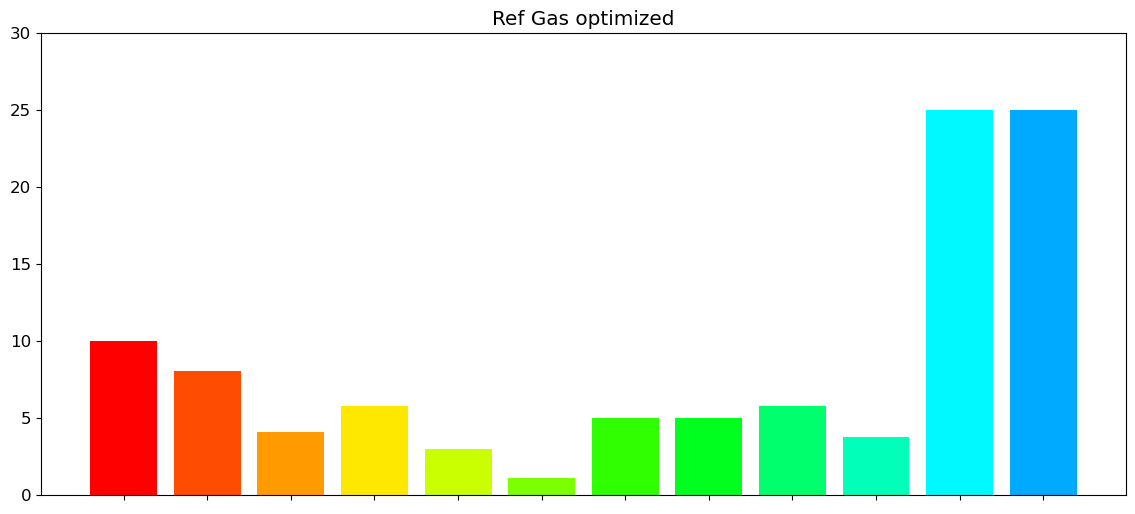

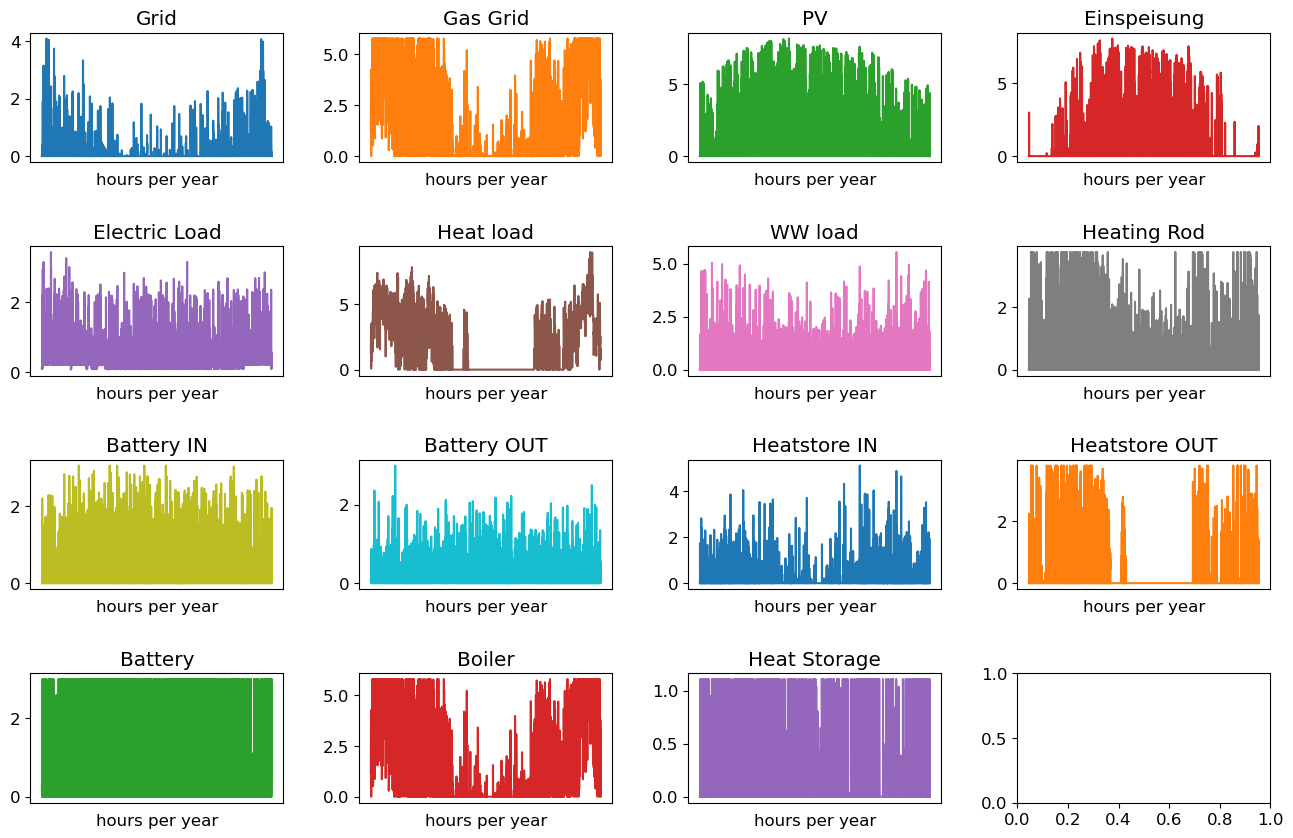

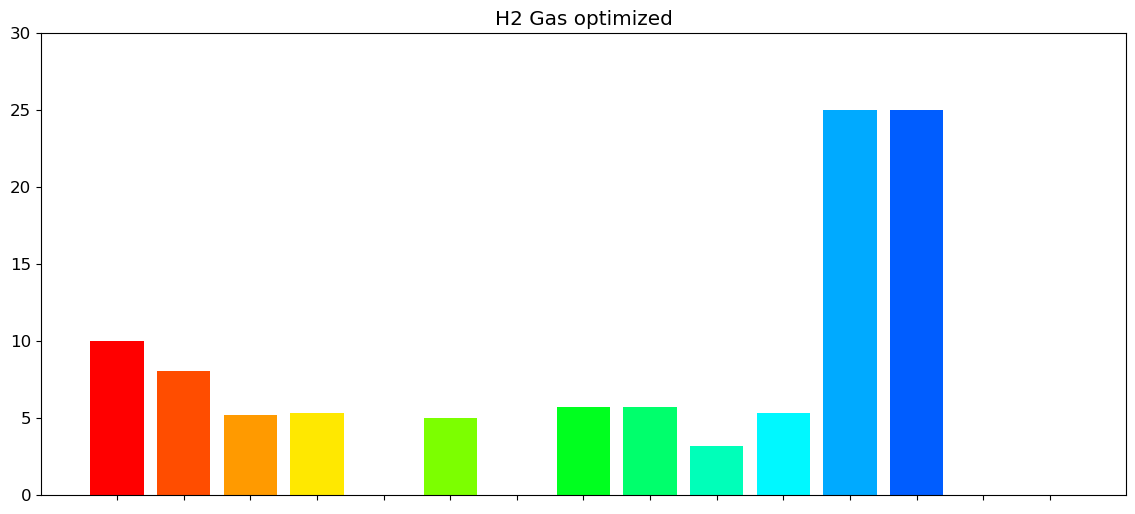

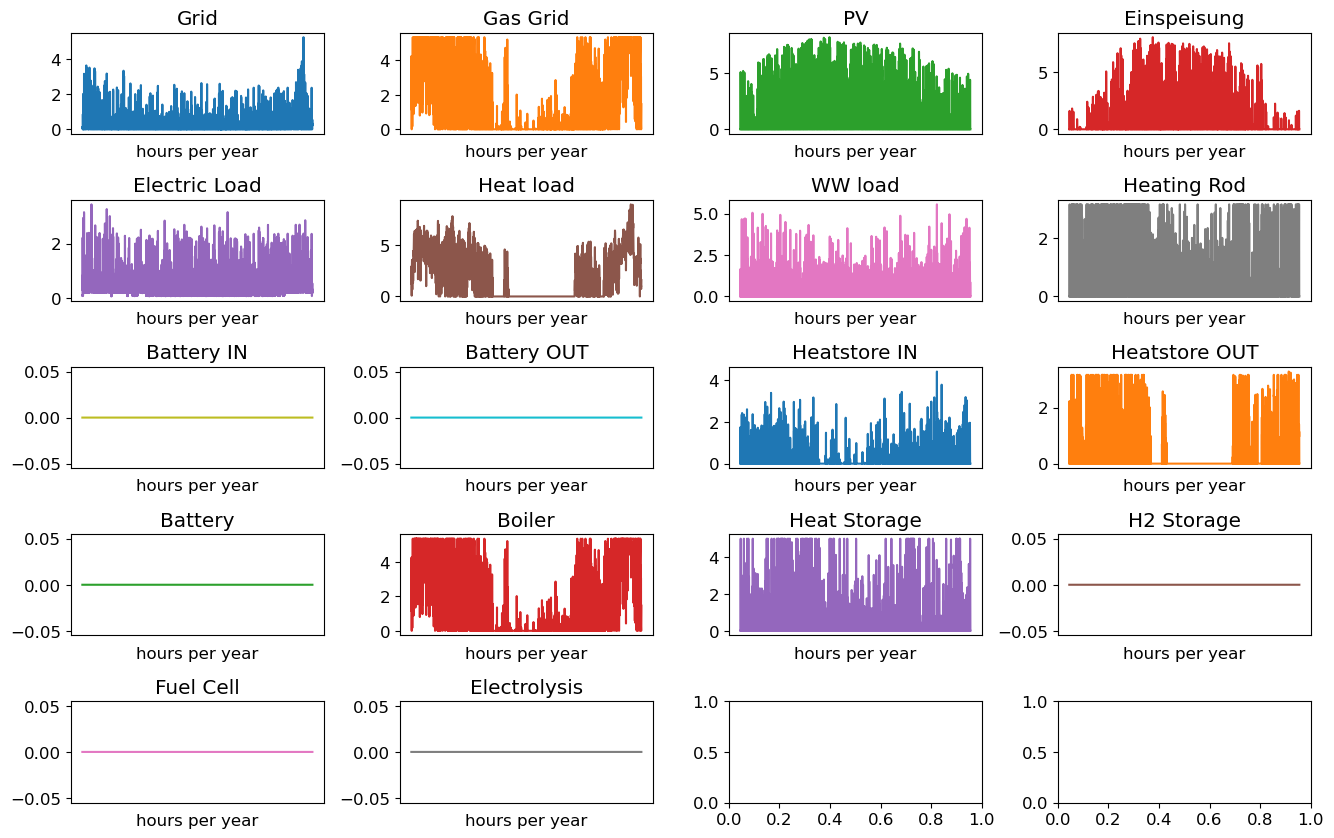

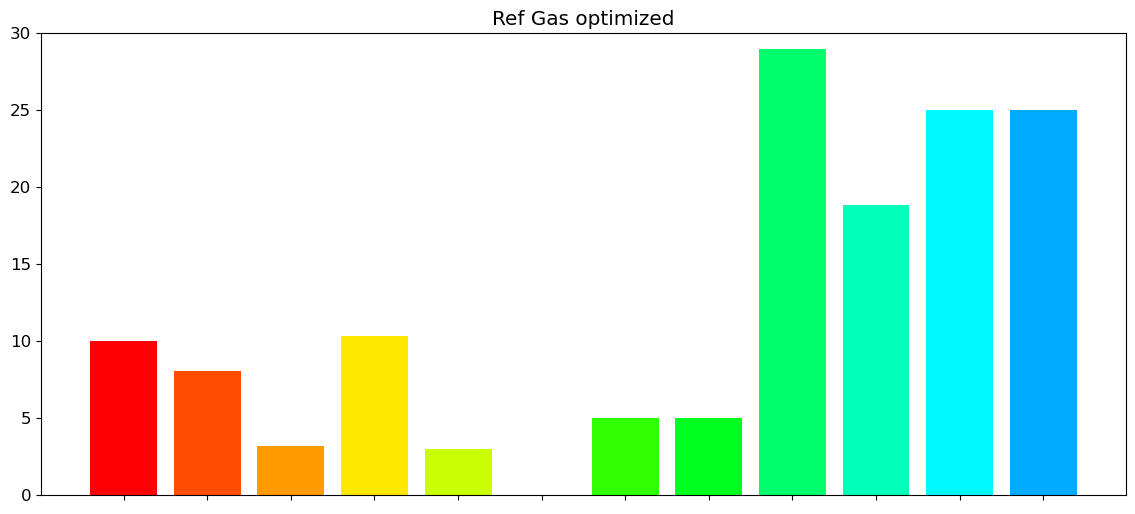

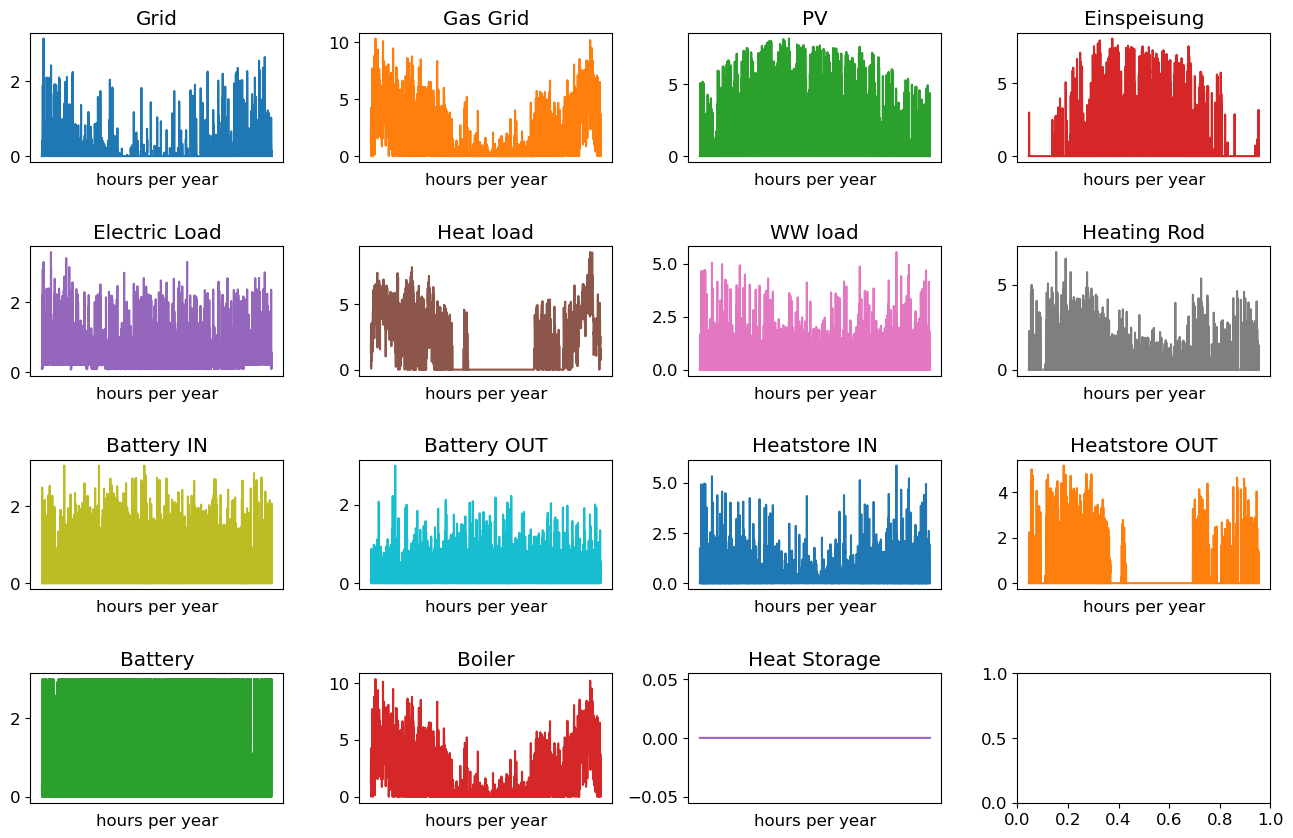

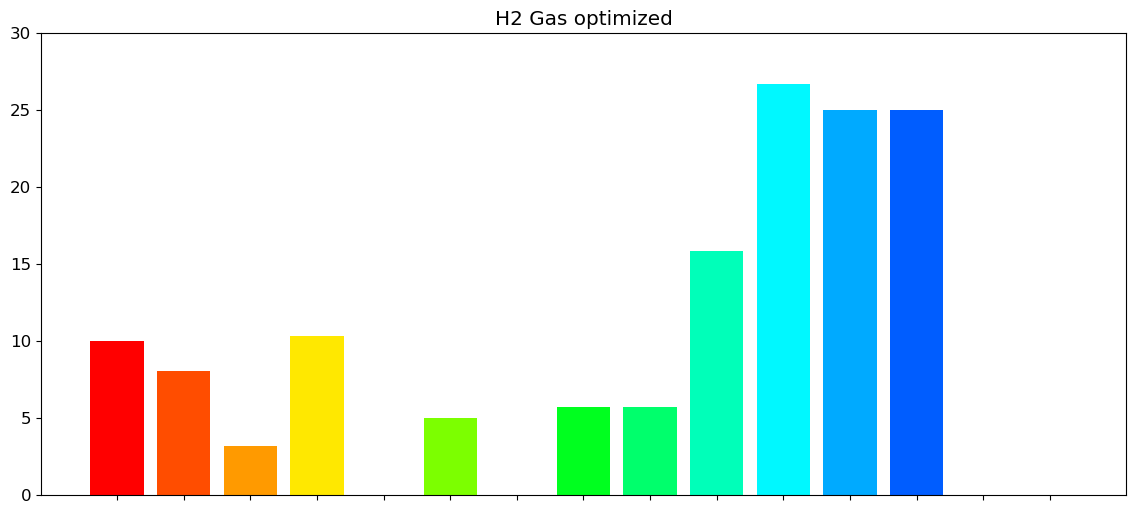

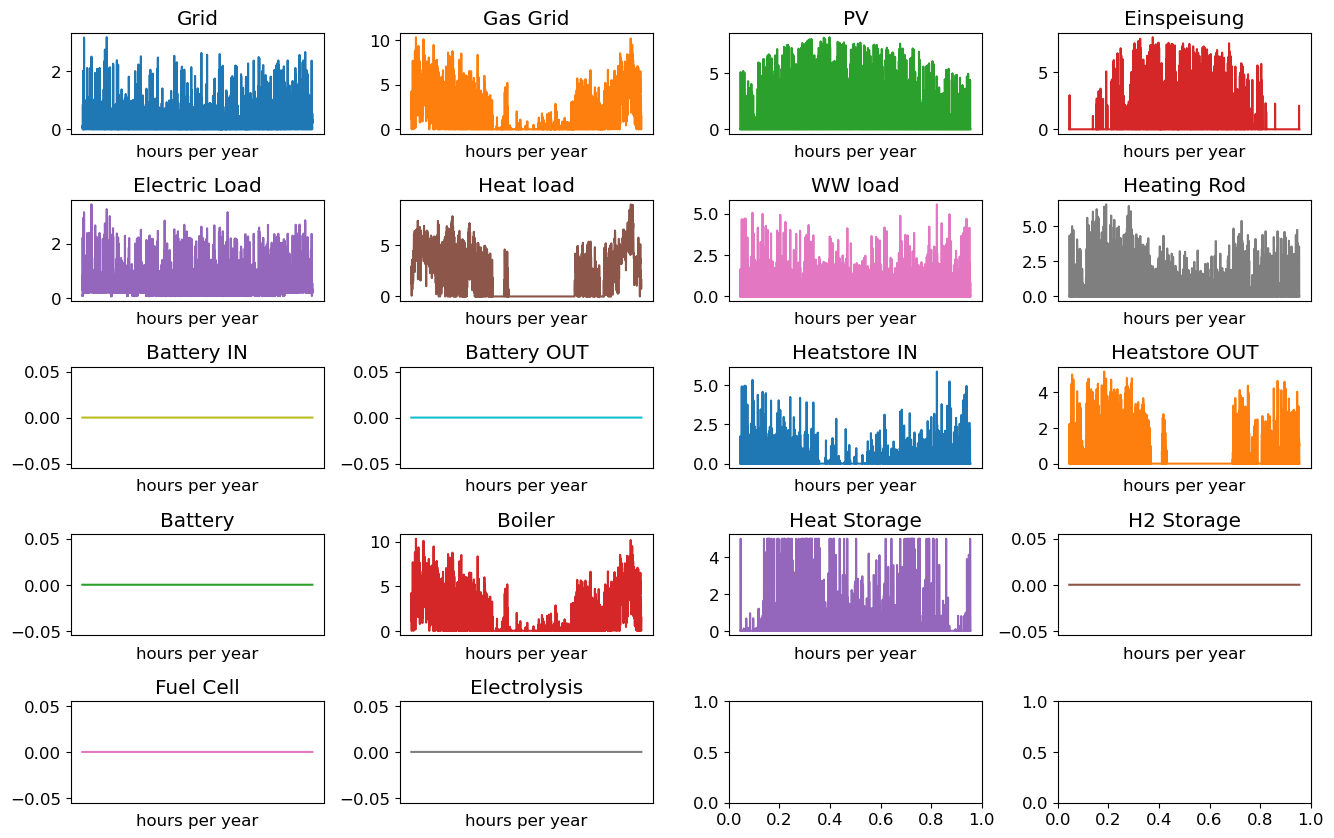

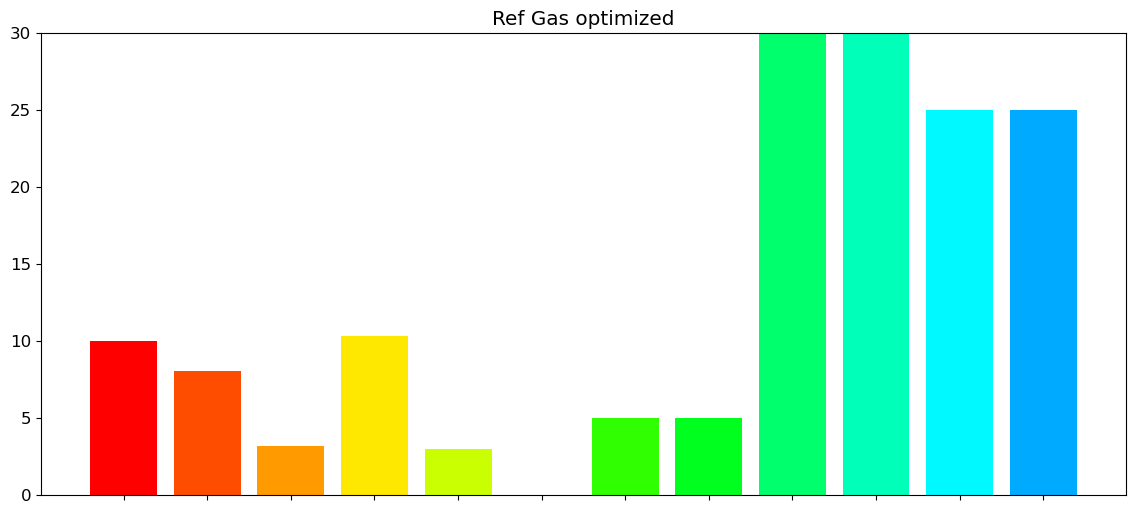

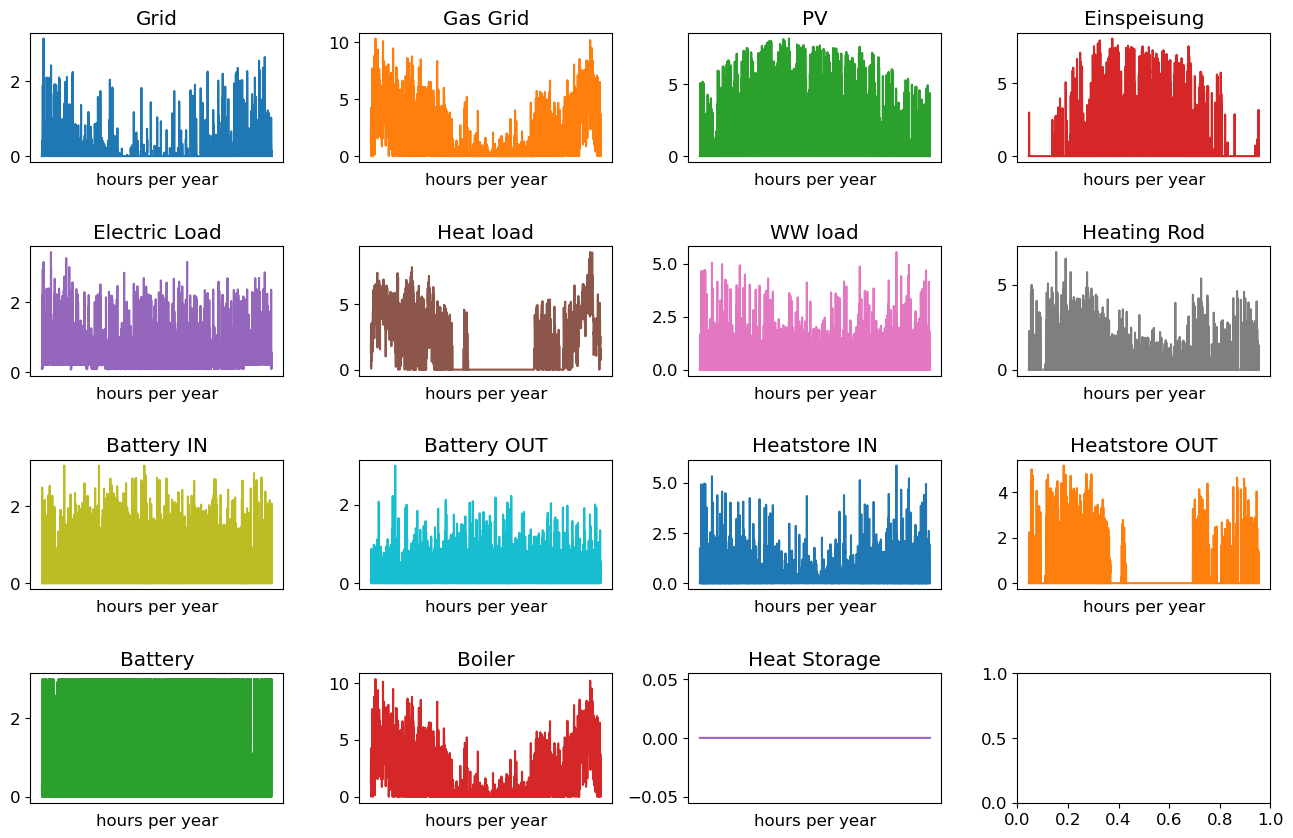

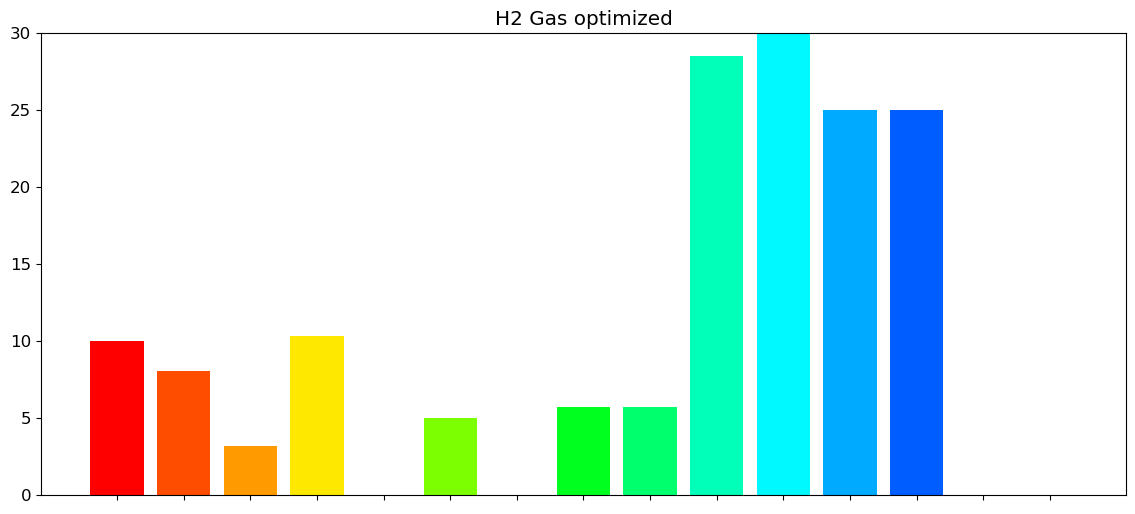

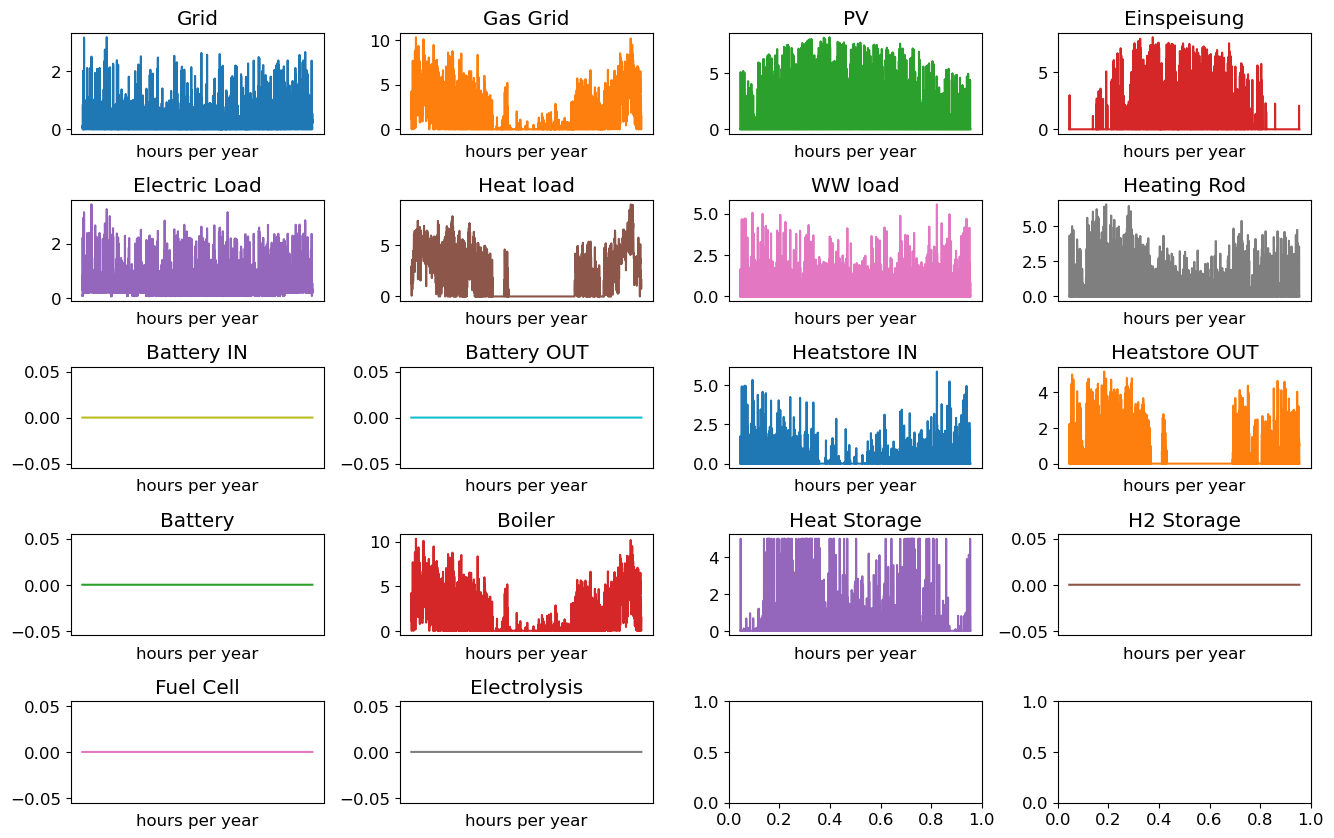

In [33]:
# 4) Gas-Netzwerk Boiler+Heating Rod (Referenz + H2) (s_pq4)
# define result datasets
df_s_pq4_res_gas_ref = pd.DataFrame()
df_s_pq4_res_gas_h2 = pd.DataFrame()

# setup networks
s_pq4_ref = build_ref_network_gas(eload4, hload4, wwload4)
s_pq4_ref.optimize(solver_name='gurobi')
s_pq4_ref.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq4_ref.links.loc['heating_rod', 'p_nom_max'] = np.inf
boiler_base_ref = s_pq4_ref.links.p_nom_opt.gas_boiler
heating_rod_base_ref = s_pq4_ref.links.p_nom_opt.heating_rod

s_pq4_h2 = build_h2_network_gas_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq4_h2.optimize(solver_name='gurobi')
s_pq4_h2.links.loc['gas_boiler', 'p_nom_max'] = np.inf
s_pq4_h2.links.loc['heating_rod', 'p_nom_max'] = np.inf
boiler_base_h2 = s_pq4_h2.links.p_nom_opt.gas_boiler
heating_rod_base_h2 = s_pq4_h2.links.p_nom_opt.heating_rod


print("!----------------------------networks base initialized------------------------------!")

s_pq4_res_gas_ref = {}
s_pq4_res_gas_h2 = {}
# loop over multiplier for 
for heat_power in range(1, 10, 4):
    print('Current Power Multiplier: ', heat_power)
    s_pq4_ref.links.loc['gas_boiler', 'p_nom_min'] = boiler_base_ref * heat_power
    s_pq4_ref.links.loc['heating_rod', 'p_nom_min'] = heating_rod_base_ref * heat_power
    s_pq4_ref.optimize(solver_name='gurobi')
    s_pq4_res_gas_ref[heat_power] = result_summary_single_network(s_pq4_ref, ref_gas=True, plots=True)
    df_s_pq4_res_gas_ref = df_s_pq4_res_gas_ref.append(result_summary_single_network(s_pq4_ref, ref_gas=True, sensitivity_variable=heat_power))
    
    s_pq4_h2.links.loc['gas_boiler', 'p_nom_min'] = boiler_base_h2 * heat_power
    s_pq4_h2.links.loc['heating_rod', 'p_nom_min'] = heating_rod_base_h2 * heat_power
    s_pq4_h2.optimize(solver_name='gurobi')
    s_pq4_res_gas_h2[heat_power] = result_summary_single_network(s_pq4_h2, h2_gas=True, plots=True)
    df_s_pq4_res_gas_h2 = df_s_pq4_res_gas_h2.append(result_summary_single_network(s_pq4_h2, h2_gas=True, sensitivity_variable=heat_power))

print("!----------------------------results generated------------------------------!")
print('\n Ref: ', df_s_pq4_res_gas_ref)
print('\n\n\n\n H2: ', df_s_pq4_res_gas_h2)

%store df_s_pq4_res_gas_ref
%store df_s_pq4_res_gas_h2
%store s_pq4_res_gas_ref
%store s_pq4_res_gas_h2

del s_pq4_ref
del s_pq4_h2
del df_s_pq4_res_gas_ref
del df_s_pq4_res_gas_h2
del s_pq4_res_gas_ref
del s_pq4_res_gas_h2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 24.33it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1wrf_w07.lp
Reading time = 0.56 seconds
obj: 227769 rows, 105128 columns, 429248 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227769 rows, 105128 columns and 429248 nonzeros
Model fingerprint: 0xf93a0788
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170179 rows and 33745 columns
Presolve time: 0.31s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227769 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2020 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.46it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vrw42ou6.lp
Reading time = 0.63 seconds
obj: 297856 rows, 140171 columns, 592766 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297856 rows, 140171 columns and 592766 nonzeros
Model fingerprint: 0xa0b6155d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 206623 rows and 40172 columns
Presolve time: 0.36s
Presolved: 91233 rows, 99999 columns, 300716 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140171 primals, 297856 duals
Objective: -5.72e+04
Solver model: available
Solver message: 2



!----------------------------networks base initialized------------------------------!
Current Power Multiplier:  1


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-q2jjut51.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x1671e6d4
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170178 rows and 33745 columns
Presolve time: 0.29s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 1.03e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   2983.21
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3751.48
PV own consumption ratio [%]            34.98
Amount Infeed [kWh/a]                 6973.34
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 6873.74
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                 890.20
Heat Storage stored [kWh/a]           1962.35
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    71.24
CAPEX [€]                            26061.88
OPEX [€/a]                            2749.50
Revenue Infeed [€/a]                  -495.11
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.71it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-uwynq4xj.lp
Reading time = 0.70 seconds
obj: 297855 rows, 140171 columns, 592765 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297855 rows, 140171 columns and 592765 nonzeros
Model fingerprint: 0x4e787d3d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 210797 rows and 40172 columns
Presolve time: 0.43s
Presolved: 87058 rows, 99999 columns, 292366 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140171 primals, 297855 duals
Objective: -5.72e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3263.40
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7519.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2733.95
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    68.54
CAPEX [€]                            24595.78
OPEX [€/a]                            3007.74
Revenue Infeed [€/a]                  -535.74
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Power Multiplier:  5


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 21.44it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-9keufoj7.lp
Reading time = 0.50 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x340de829
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170178 rows and 33745 columns
Presolve time: 0.32s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 3.77e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3009.98
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3673.60
PV own consumption ratio [%]            34.25
Amount Infeed [kWh/a]                 7051.22
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 6935.44
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                 890.29
Heat Storage stored [kWh/a]           1832.17
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    70.98
CAPEX [€]                            53420.61
OPEX [€/a]                            2774.17
Revenue Infeed [€/a]                  -500.64
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-wcs06qjk.lp
Reading time = 0.67 seconds
obj: 297855 rows, 140171 columns, 592765 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297855 rows, 140171 columns and 592765 nonzeros
Model fingerprint: 0x11b6c3e0
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215382 rows and 40173 columns
Presolve time: 0.37s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140171 primals, 297855 duals
Objective: -3.08e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3262.61
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2727.06
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    68.55
CAPEX [€]                            51025.59
OPEX [€/a]                            3007.01
Revenue Infeed [€/a]                  -535.74
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Current Power Multiplier:  9


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 23.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-a9159h6n.lp
Reading time = 0.47 seconds
obj: 227768 rows, 105128 columns, 429247 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 227768 rows, 105128 columns and 429247 nonzeros
Model fingerprint: 0x7d2fc132
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [7e-02, 2e+03]
  Bounds range     [5e+02, 5e+02]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 170178 rows and 33745 columns
Presolve time: 0.30s
Presolved: 57590 rows, 71383 columns, 177800 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 227768 duals
Objective: 6.52e+04
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3009.98
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3673.60
PV own consumption ratio [%]            34.25
Amount Infeed [kWh/a]                 7051.22
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 6935.44
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                 890.29
Heat Storage stored [kWh/a]           1832.17
H2 stored [kWh/a]                        0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                     0.00
Self Sufficiency [%]                    70.98
CAPEX [€]                            80894.69
OPEX [€/a]                            2774.17
Revenue Infeed [€/a]                  -500.64
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.93it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ho3ii9ph.lp
Reading time = 0.62 seconds
obj: 297855 rows, 140171 columns, 592765 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297855 rows, 140171 columns and 592765 nonzeros
Model fingerprint: 0xaa0ca7c5
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215382 rows and 40173 columns
Presolve time: 0.34s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140171 primals, 297855 duals
Objective: -4.36e+03
Solver model: available
Solver message: 2




Network analytics: 
                               analytic values
CO2-Emission [kg/a]                   3262.61
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Battery stored [kWh/a]                  -0.00
Heat Storage stored [kWh/a]           2727.06
H2 stored [kWh/a]                       -0.00
converted to H2 [kWh/a]                  0.00
H2 used [kWh/a]                          0.00
Heat from H2 [kWh/a]                    -0.00
Self Sufficiency [%]                    68.55
CAPEX [€]                            77455.39
OPEX [€/a]                            3007.01
Revenue Infeed [€/a]                  -535.74
Revenue Savi

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2402267154.py:31: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



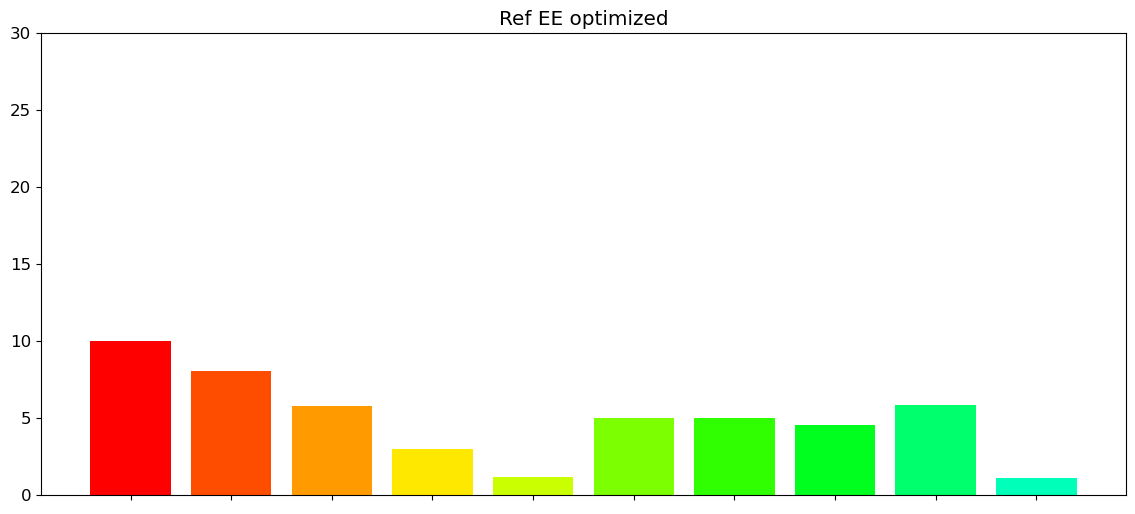

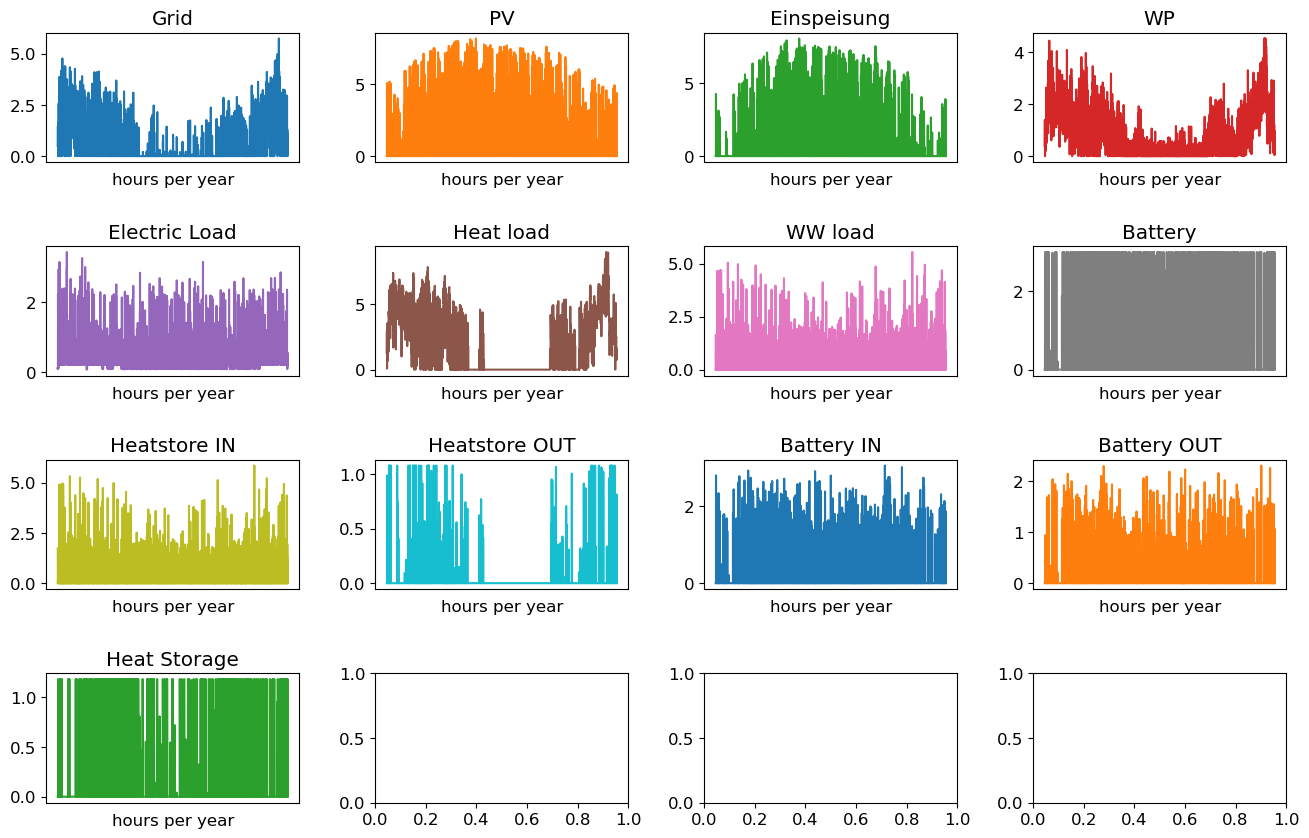

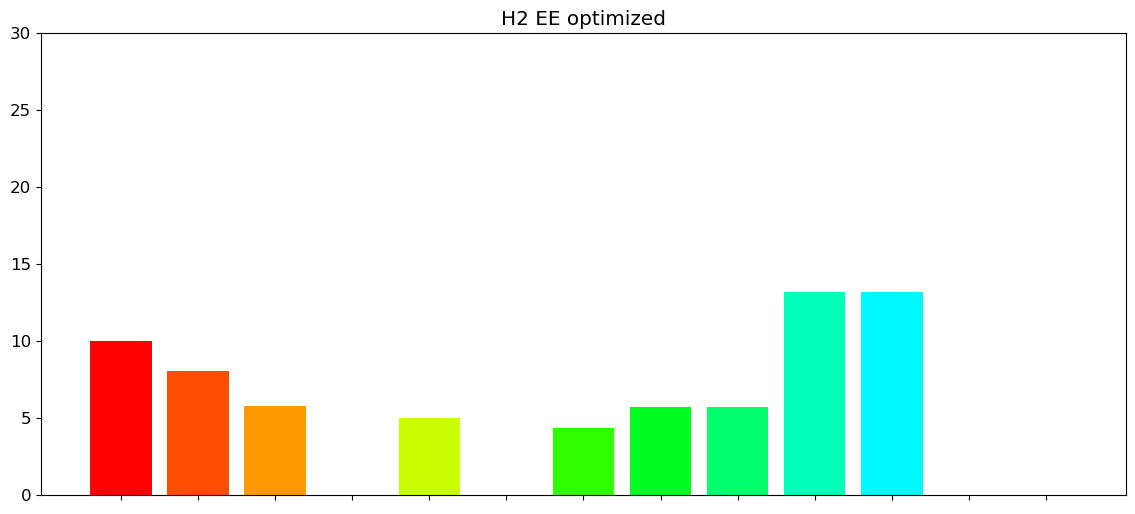

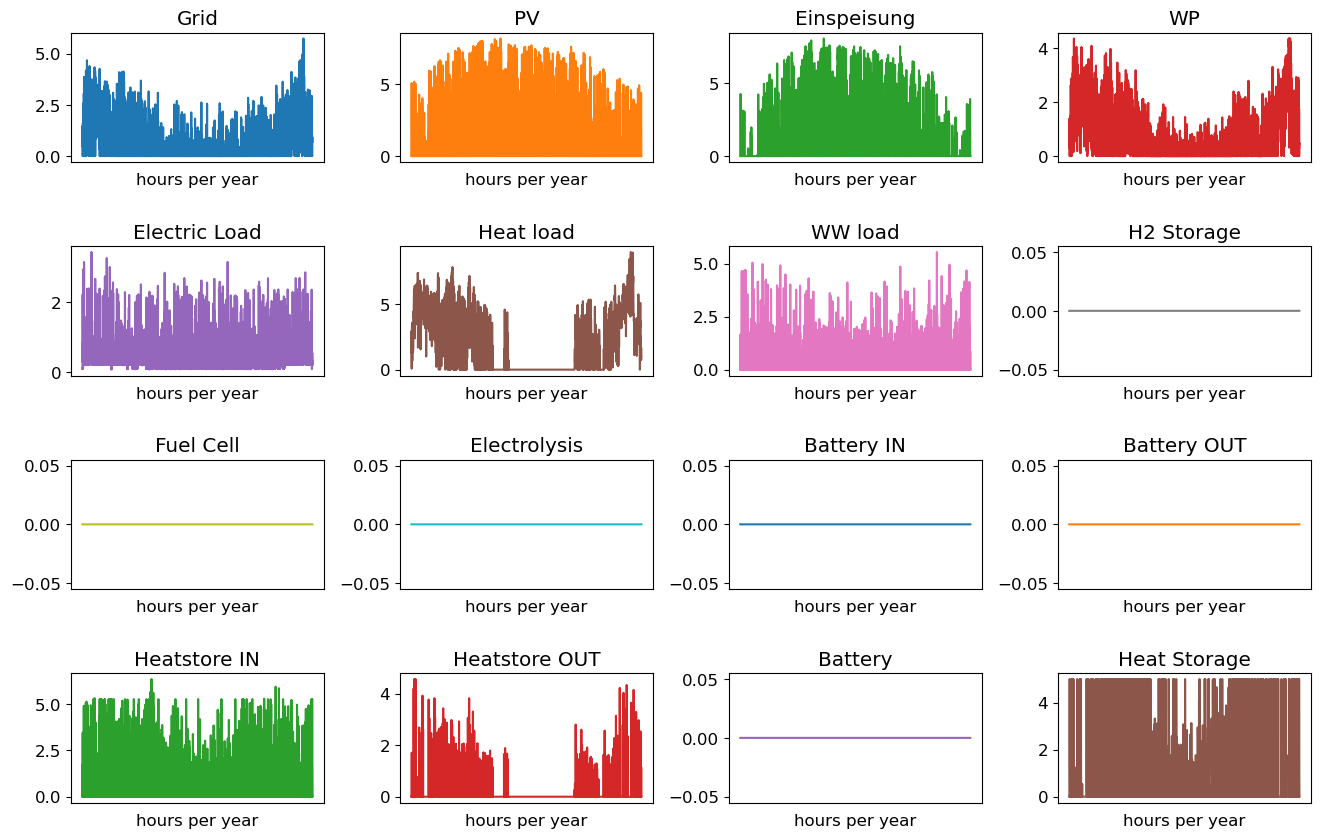

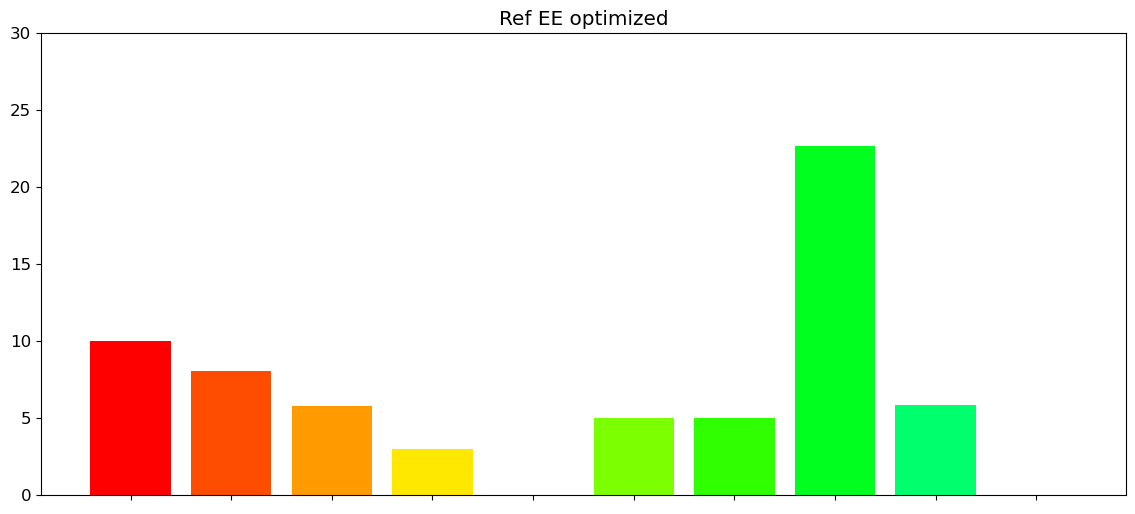

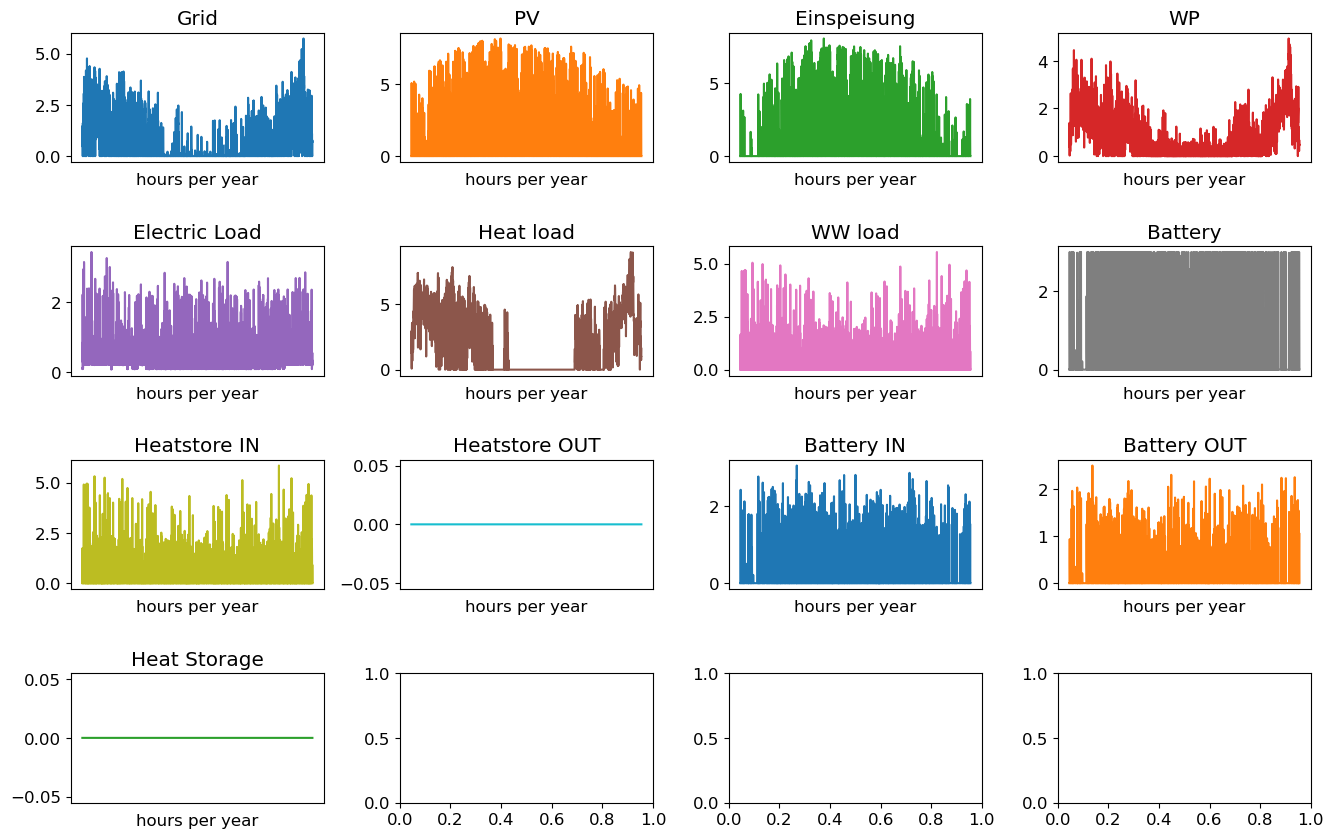

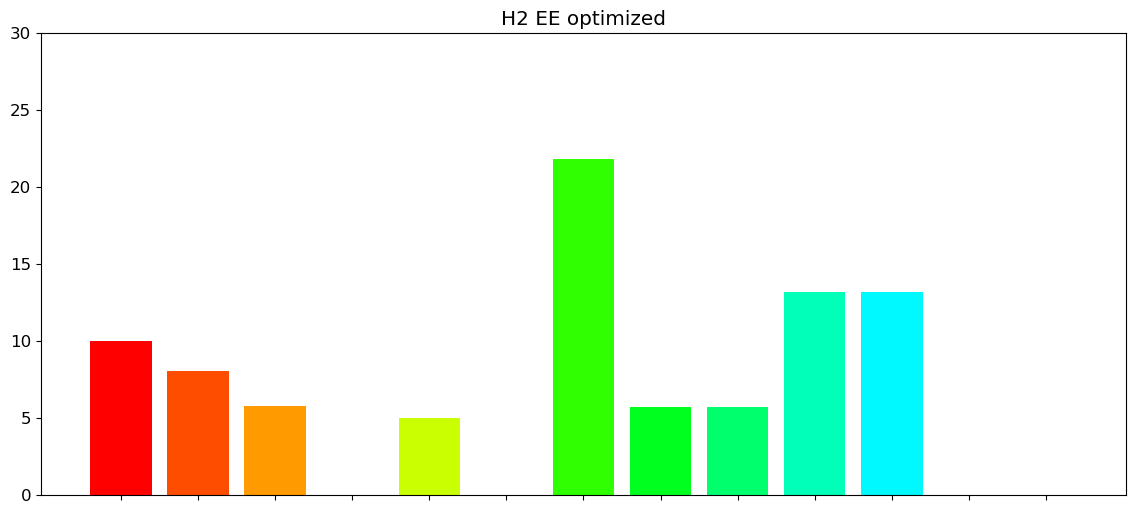

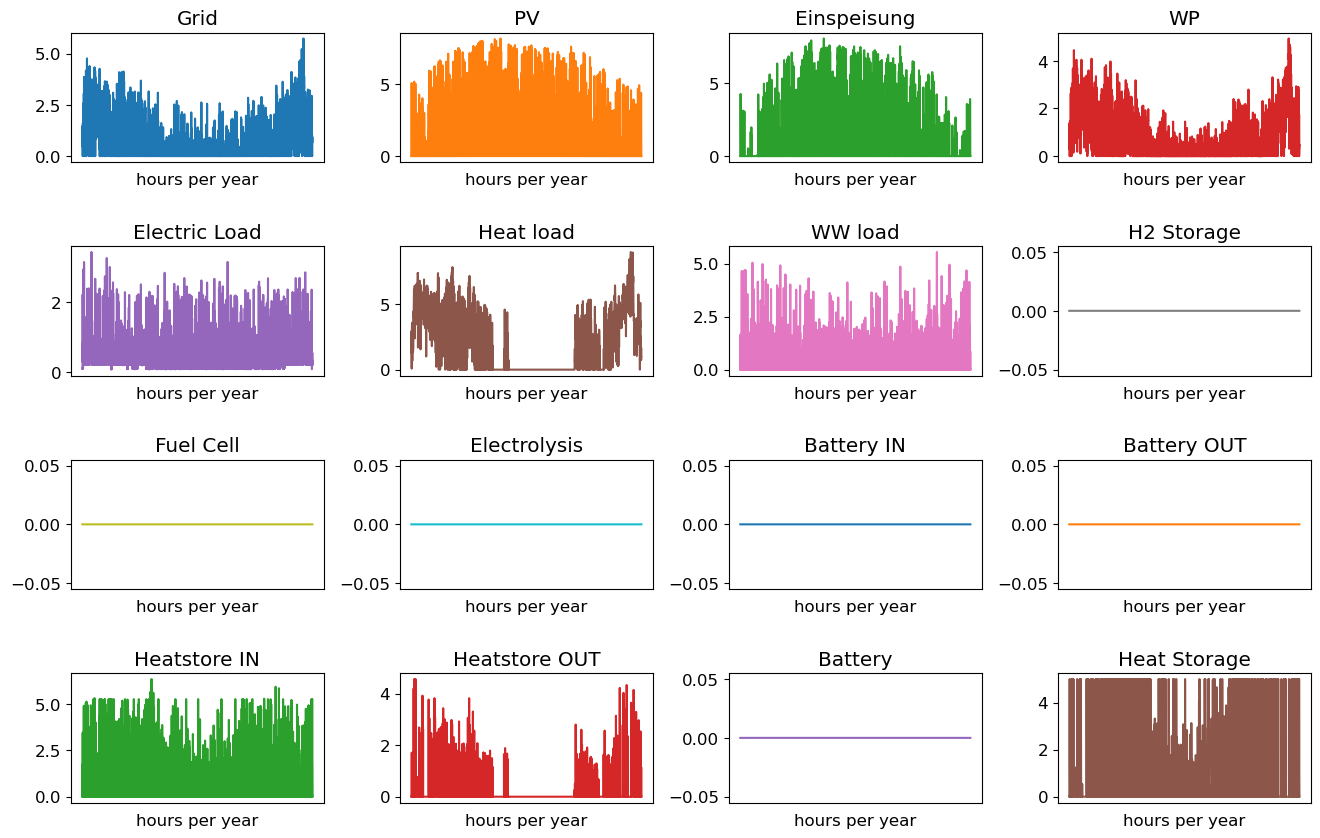

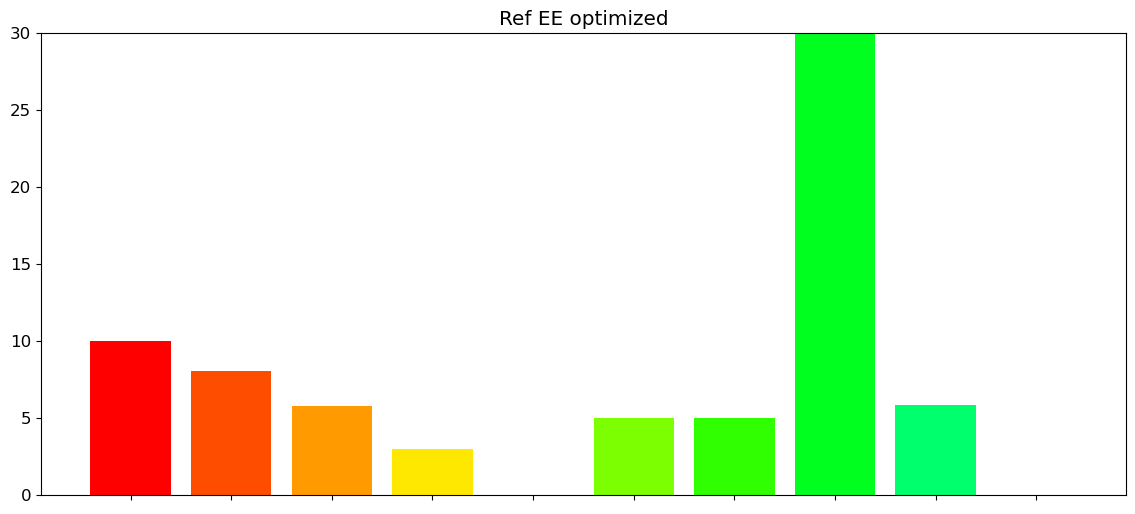

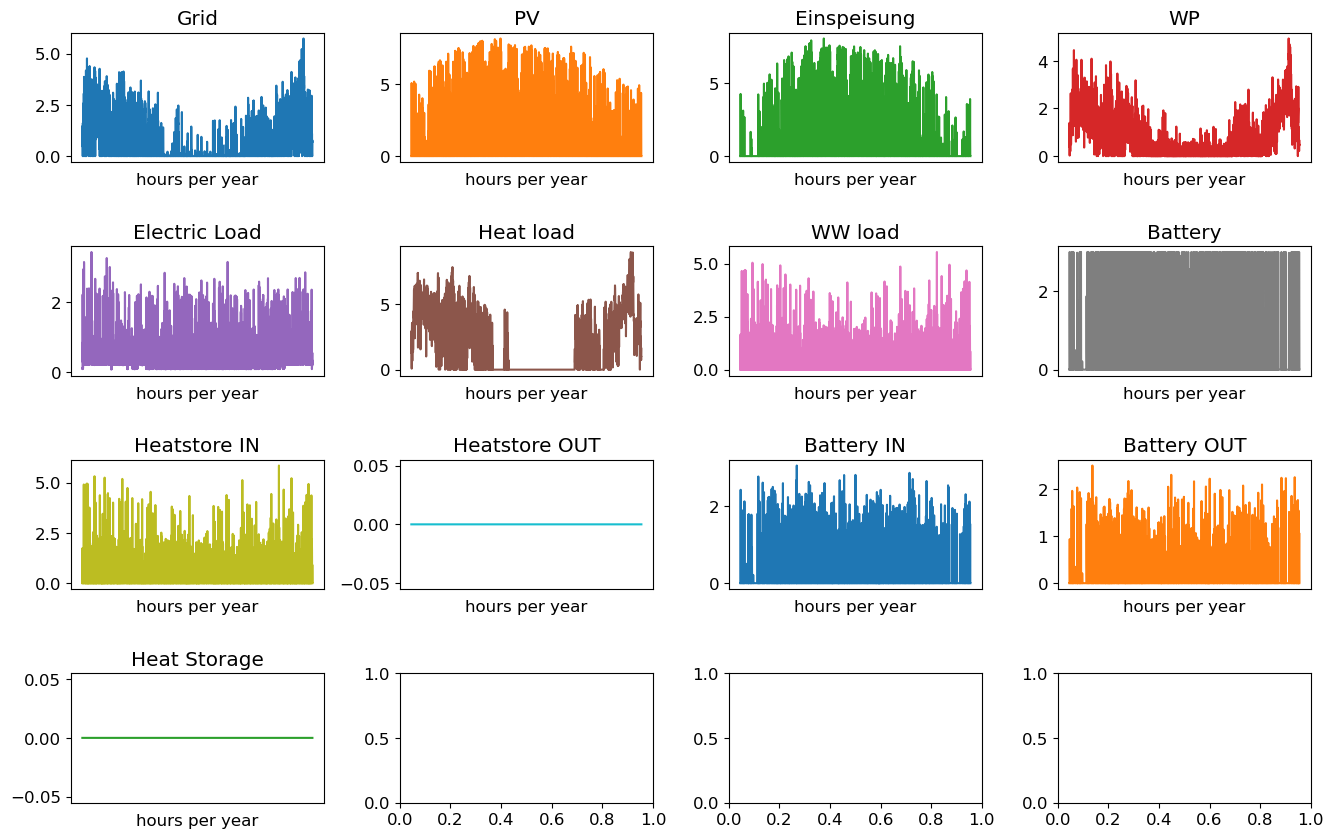

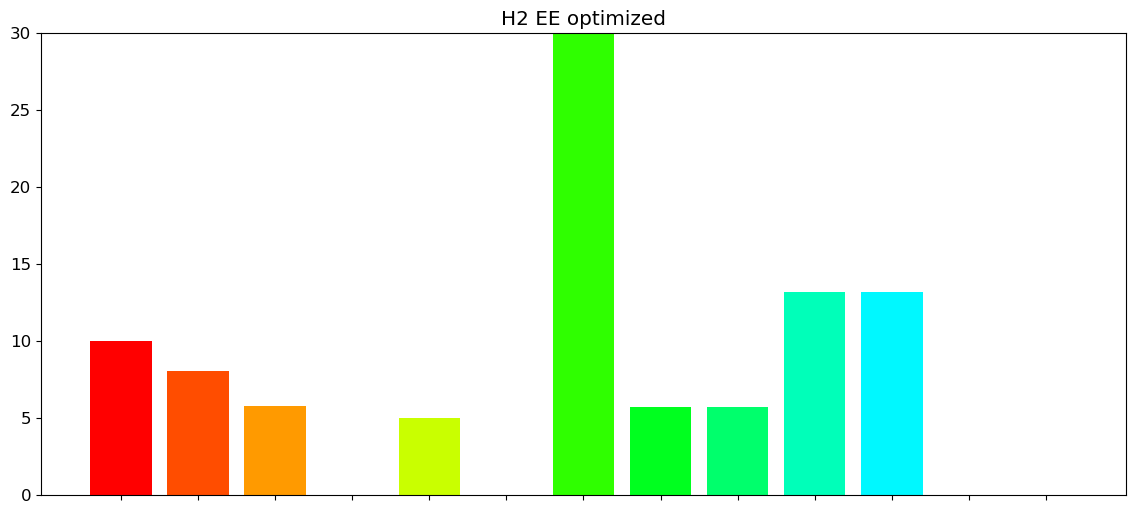

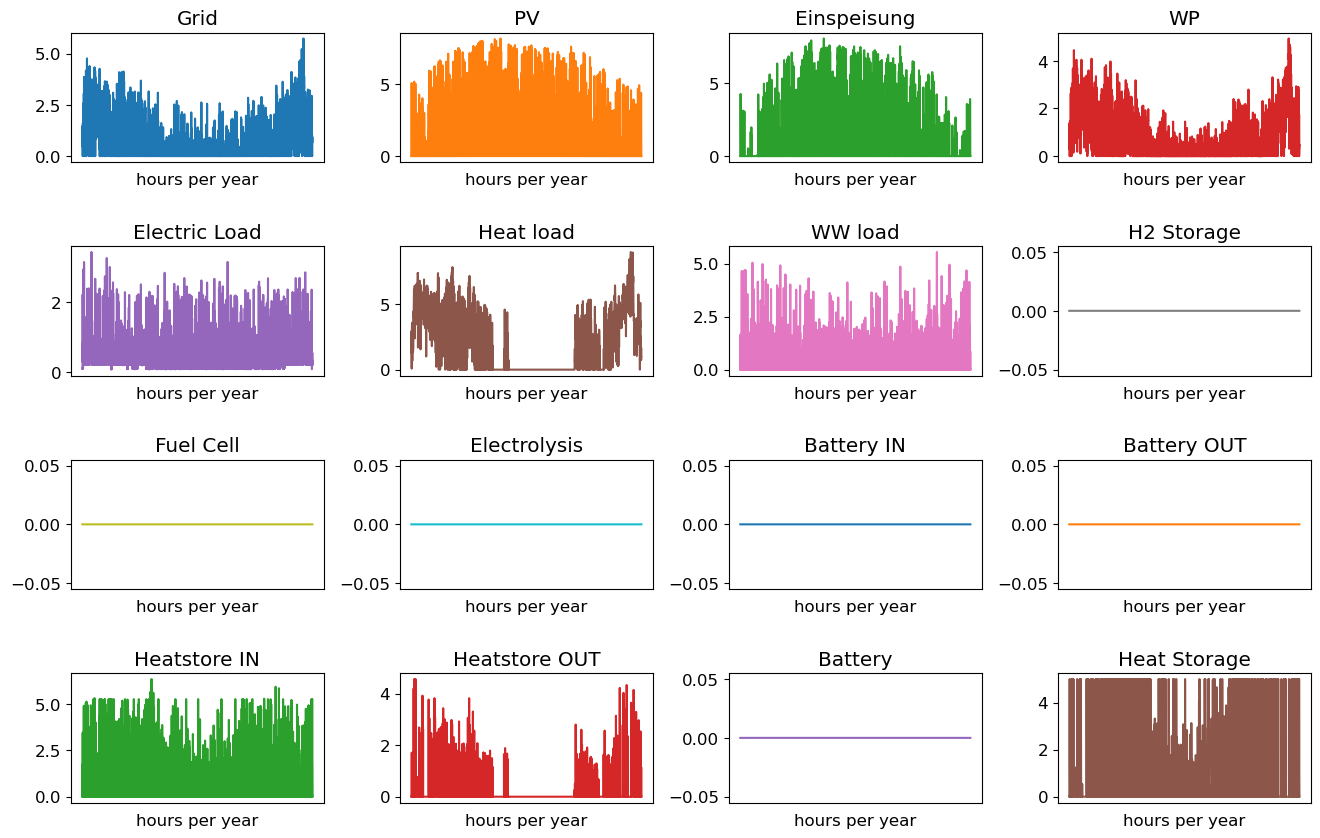

In [34]:
# 5) EE-Netzwerk WP (Referenz + H2) (s_pq5)
# define result datasets
df_s_pq5_res_ee_ref = pd.DataFrame()
df_s_pq5_res_ee_h2 = pd.DataFrame()

# setup networks
s_pq5_ref = build_ref_network_ee(eload4, hload4, wwload4)
s_pq5_ref.optimize(solver_name='gurobi')
s_pq5_ref.links.loc['wp', 'p_nom_max'] = np.inf
wp_base_ref = s_pq5_ref.links.p_nom_opt.wp

s_pq5_h2 = build_h2_network_ee_m(eload4, hload4, wwload4, init_build_year=2020)
s_pq5_h2.optimize(solver_name='gurobi')
s_pq5_h2.links.loc['wp', 'p_nom_max'] = np.inf
wp_base_h2 = s_pq5_h2.links.p_nom_opt.wp
print("!----------------------------networks base initialized------------------------------!")

s_pq5_res_ee_ref = {}
s_pq5_res_ee_h2 = {}
# loop over multiplier for 
for heat_power in range(1, 10, 4):
    print('Current Power Multiplier: ', heat_power)
    s_pq5_ref.links.loc['wp', 'p_nom_min'] = wp_base_ref * heat_power
    s_pq5_ref.optimize(solver_name='gurobi')
    s_pq5_res_ee_ref[heat_power] = result_summary_single_network(s_pq5_ref, ref=True, plots=True)
    df_s_pq5_res_ee_ref = df_s_pq5_res_ee_ref.append(result_summary_single_network(s_pq5_ref, ref=True, sensitivity_variable=heat_power))
    
    s_pq5_h2.links.loc['wp', 'p_nom_min'] = wp_base_h2 * heat_power
    s_pq5_h2.optimize(solver_name='gurobi')
    s_pq5_res_ee_h2[heat_power] = result_summary_single_network(s_pq5_h2, h2=True, plots=True)
    df_s_pq5_res_ee_h2 = df_s_pq5_res_ee_h2.append(result_summary_single_network(s_pq5_h2, h2=True, sensitivity_variable=heat_power))

print("!----------------------------results generated------------------------------!")
print('\n Ref: ', df_s_pq5_res_ee_ref)
print('\n\n\n\n H2: ', df_s_pq5_res_ee_h2)

%store df_s_pq5_res_ee_ref
%store df_s_pq5_res_ee_h2
%store s_pq5_res_ee_ref
%store s_pq5_res_ee_h2

del s_pq5_ref
del s_pq5_h2
del df_s_pq5_res_ee_ref
del df_s_pq5_res_ee_h2
del s_pq5_res_ee_ref
del s_pq5_res_ee_h2

# Sensitivität Auswertung

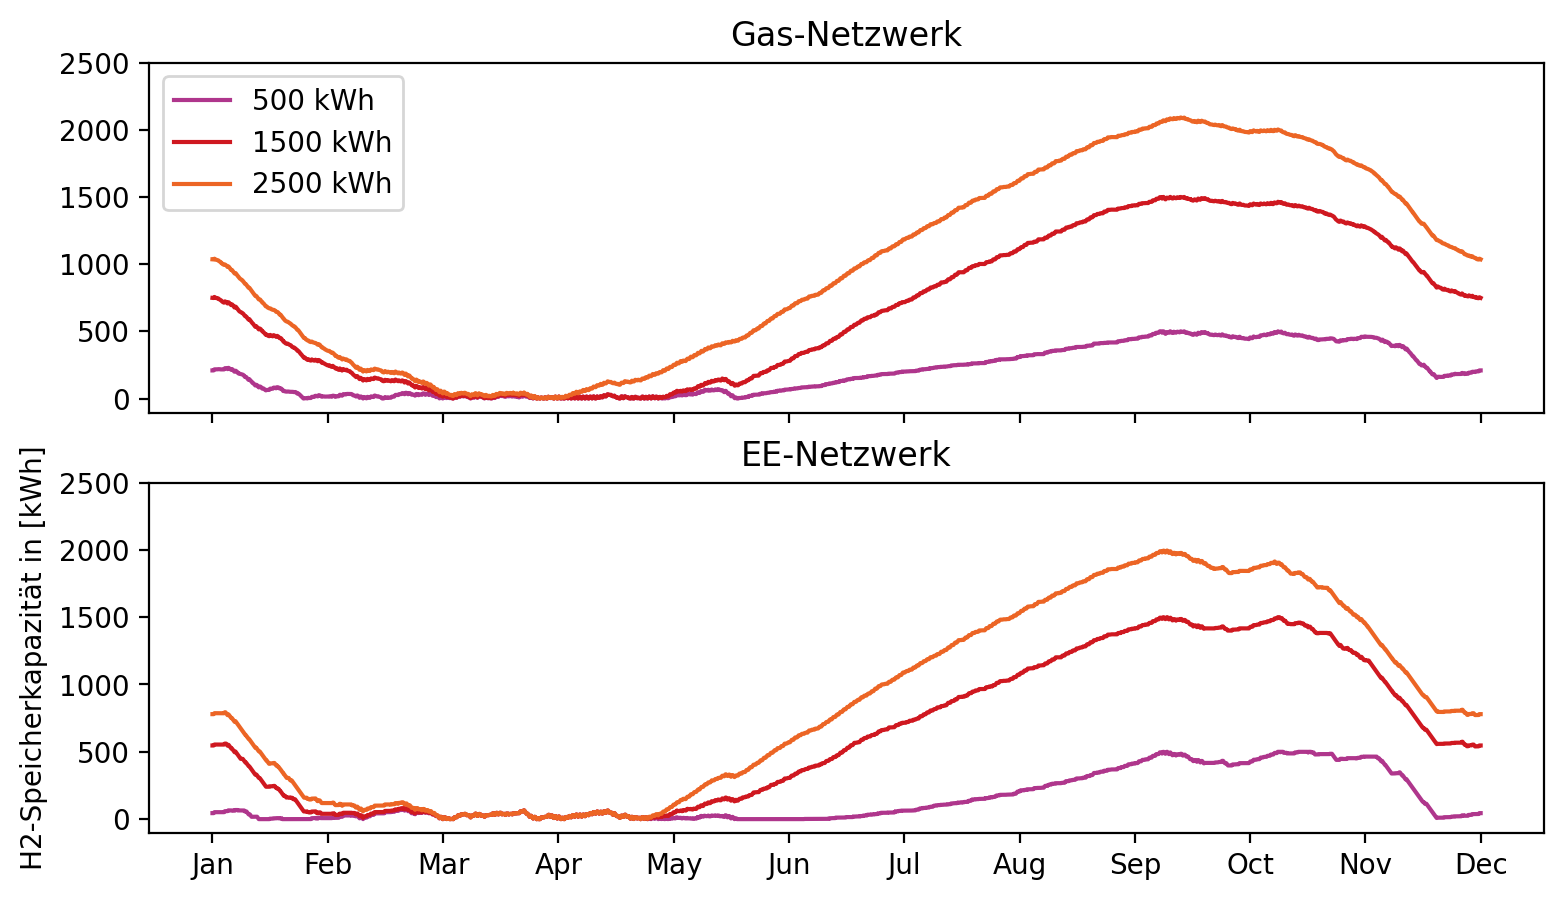

In [4]:
# s_pq1
%store -r s_pq1_res_gas
%store -r s_pq1_res_ee
%store -r df_s_pq1_res_gas
%store -r df_s_pq1_res_ee

fig_h2_storage, (ax1,ax2) = plt.subplots(2, 1, figsize=(9, 5), dpi=200, sharex=True)

x_ticks = range(8760)
y_ticks = range(0,2501,500)

ax1.plot(x_ticks, s_pq1_res_gas[500][0]['H2 Storage'], '#af368c', label="500 kWh")
ax1.plot(x_ticks, s_pq1_res_gas[1500][0]['H2 Storage'], '#cf1820', label="1500 kWh")
ax1.plot(x_ticks, s_pq1_res_gas[2500][0]['H2 Storage'], '#ec6525', label="2500 kWh")
ax1.set_title("Gas-Netzwerk")
ax1.set_yticks(y_ticks)

ax2.plot(x_ticks, s_pq1_res_ee[500][0]['H2 Storage'], '#af368c', label="500 kWh")
ax2.plot(x_ticks, s_pq1_res_ee[1500][0]['H2 Storage'], '#cf1820', label="1500 kWh")
ax2.plot(x_ticks, s_pq1_res_ee[2500][0]['H2 Storage'], '#ec6525', label="2500 kWh")
ax2.set_title("EE-Netzwerk")
ax2.set_yticks(y_ticks)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(np.linspace(0,8760,len(months)), labels=months)
plt.ylabel('H2-Speicherkapazität in [kWh]')
ax1.legend()


In [36]:
# s_pq2
%store -r s_pq2_res_gas
%store -r s_pq2_res_ee
%store -r df_s_pq2_res_gas
%store -r df_s_pq2_res_ee

#df_infeed = extract


In [37]:
# s_pq3
%store -r df_s_pq3_res_gas
%store -r df_s_pq3_res_ee


In [38]:
# s_pq4
%store -r df_s_pq4_res_gas_ref
%store -r df_s_pq4_res_gas_h2
%store -r s_pq4_res_gas_ref
%store -r s_pq4_res_gas_h2


In [39]:
# s_pq5
%store -r df_s_pq5_res_ee_ref
%store -r df_s_pq5_res_ee_h2
%store -r s_pq5_res_ee_ref
%store -r s_pq5_res_ee_h2

# Szenario-Analyse
### (zur ermittlung der Parameter aus der Fragestellung)

**Szenario 1: Kapitalkostenreduktion**
- 1a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells
- 1b: Kostenreduktion der Wasserstoffkomponenten prozentual vom Minimum des Learning Curve Modells (Kostenreduzierung um weitere 90%)

**Szenario 2: CO2-Emissionsminimum**
- 2a: CO2-Emissionsminimum des Wasserstofferweiterten Gas-Modells
- 2b: CO2-Emissionsminimum des Wasserstofferweiterten EE-Modells

**Szenario 3: Kapitalkostenreduktion bei definiertem CO2-Emissionsminimum**
- 3a: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Emissionsminimum
- 3b: Kostenreduktion der Wasserstoffkomponenten entlang eines definierten Learning Curve Modells bei definiertem CO2-Wert, an welchem das H2-System erstmalig in der größe der Mindestdimensionierung nach Herstellerangabe ausgelegt wird

**Szenario 4: Minimum der Lebensdauer**
- 4a: Ermittlung der notwendigen Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im Gas-Modell (bei ermitteltem CO2-Minimum und einem CO2-Wert ab welchem das Wasserstoffsystem in der Herstellerdimensionierung skalliert wird bei notwendiger Kapitalkostenreduktion aus (3))
- 4b: Minimale Lebensdauer des Wasserstoffsystems für eine wirtschaftliche Machbarkeit im EE-Modell (bei ermitteltem CO2-Minimum und einem CO2-Wert ab welchem das Wasserstoffsystem in der Herstellerdimensionierung skalliert wird bei notwendiger Kapitalkostenreduktion aus (3))

**Szenario 5: H2-Speichergröße bei definierten Kapitalkosten und vollständiger Lebensdauer**
- 5: Ermittlung der Parameter: Autarkiegrad, CO2-Einsparung, Amortisationszeit für einen Zubau eines H2-Systems im Jahr der ermittelten notwendigen Kapitalkostenreduktion


### Szenario 1

> **Notwendige Bedingung:** alle 4 Komponenten müssen eine optimierte Leistung oder Kapazität aufweisen

In [40]:
# Setup time intervall and cost data
sa_periods = multi_years
df_cost = cost_reduction_calculation(capital_cost_picea)
df_cost.drop(df_cost.tail(3).index, inplace=True)
df_cost['year'] = range(2023, 2051, 1)
df_cost.index = df_cost['year']
df_cost_all_years = df_cost.copy()
df_cost = df_cost[df_cost['year'].isin(sa_periods)]

%store df_cost_all_years
%store df_cost
df_cost

Stored 'df_cost_all_years' (DataFrame)
Stored 'df_cost' (DataFrame)


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



year           max           std           min     [%]_1     [%]_2  \
year                                                                       
2023  2023  85000.000000  85000.000000  85000.000000  1.000000  1.000000   
2025  2025  79235.160018  71837.161639  64748.781844  0.932178  0.845143   
2027  2027  76876.759716  66820.747716  57594.657993  0.904432  0.786126   
2029  2029  70641.154426  54563.418678  41498.275747  0.831072  0.641923   
2031  2031  67257.121173  48509.570449  34309.922041  0.791260  0.570701   
2033  2033  64183.673469  43367.346939  28622.448980  0.755102  0.510204   
2035  2035  63579.328934  42936.471791  28018.104444  0.747992  0.505135   
2037  2037  63148.400964  42505.543821  27587.176474  0.742922  0.500065   
2039  2039  62717.472995  42074.615852  27156.248505  0.737853  0.494995   
2041  2041  62286.545026  41643.687883  26725.320536  0.732783  0.489926   
2043  2043  61855.617056  41212.759913  26294.392566  0.727713  0.484856   

         [%]_3  
year            
2023  1.000000  
2025  0.761750  
2027  0.677584  
2029  0.488215  
2031  0.403646  
2033  0.336735  
2035  0.329625  
2037  0.324555  
2039  0.319485  
2041  0.314416  
2043  0.309346

In [41]:
# scenario 1a
# scenario datasets
s1a_res_gas = {}
s1a_res_ee = {}
s1a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s1a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4,
                                         multi_invest_h2g=False,
                                         cost_data = df_cost,
                                         cost_scenario='min')
s1a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s1a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4,
                                       multi_invest_h2=False,
                                       cost_data = df_cost,
                                       cost_scenario='min')
s1a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for year in df_cost['year']:
    print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, 'min'])
    s1a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_gas_network.optimize(solver_name='gurobi')
    s1a_res_gas[year] = result_summary_single_network(s1a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {}: \n\n".format(year), s1a_res_gas[year][1], "\n\n", s1a_res_gas[year][2])
    
    s1a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
    s1a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['battery']) / battery_picea_params['e_nom']
    s1a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['ely']) / ely_params['p_nom']
    s1a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, 'min'] * specific_cap_share['fc']) / fc_params['p_nom']
    s1a_ee_network.optimize(solver_name='gurobi')
    s1a_res_ee[year] = result_summary_single_network(s1a_ee_network, h2=True)
    print("EE Network interim Result for {}: \n\n".format(year), s1a_res_ee[year][1], "\n\n", s1a_res_ee[year][2])
      
    s1a_current_cost.loc[year] = [s1a_ee_network.stores.capital_cost.battery,
                                  s1a_ee_network.stores.capital_cost.h2_storage,
                                  s1a_ee_network.links.capital_cost.ely,
                                  s1a_ee_network.links.capital_cost.fc]

del s1a_gas_network
del s1a_ee_network
print("!----------------------------results generated------------------------------!")

# results scenario 1
df_s1a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s1a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for key, val in s1a_res_gas.items():
    df_s1a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                          val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for key, val in s1a_res_ee.items():
    df_s1a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                         val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s1a_gas = pd.concat([df_s1a_gas, s1a_current_cost.round(decimals=0)], axis=1)
df_s1a_ee = pd.concat([df_s1a_ee, s1a_current_cost.round(decimals=0)], axis=1)

print("!----------------------------results scenario 1:------------------------------!")

%store df_s1a_ee
%store df_s1a_gas
%store s1a_res_ee
%store s1a_res_gas

print(df_s1a_gas, "\n\n\n\n",  df_s1a_ee)
#print(s1a_res_gas, "\n\n", s1a_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None
Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  min 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None
!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System for 2023:  85000.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-up6kuk2v.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xe3a7e476
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -8.14e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.91it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ib0suhml.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x63e7922e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -6.38e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-oi5jz3yc.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x0b5483cb
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -6.12e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-a883wu9d.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa552678f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.79e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.66it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-7doe_cqp.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5e584d35
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -5.40e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.92it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ckwwsyxv.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x17b6aea3
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.23e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-8rw2kf42.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x95fa3887
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.79e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.00
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4194.68
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4546.07
PV own consumption ratio [%]            42.39
Amount Infeed [kWh/a]                 6178.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 2110.47
Grid gas [kWh/a]                     16231.37
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.80it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-jelh424n.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x1dff77cb
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.96e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-3ybn05_s.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x770d2918
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.07e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     0.38
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   4137.59
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       4659.98
PV own consumption ratio [%]            43.45
Amount Infeed [kWh/a]                 6064.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1965.48
Grid gas [kWh/a]                     16260.24
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.17it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4p3ftv7k.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x53e4ae86
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.40e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3262.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3179.23
PV own consumption ratio [%]            29.64
Amount Infeed [kWh/a]                 7545.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7517.90
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.18it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-2kb_nj7p.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5bee61e0
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.51e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.85
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3943.88
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5050.72
PV own consumption ratio [%]            47.09
Amount Infeed [kWh/a]                 5674.10
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1473.26
Grid gas [kWh/a]                     16358.83
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.04it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1diee2ed.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xfa1dab5f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.95e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    0.94
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3138.17
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3470.37
PV own consumption ratio [%]            32.36
Amount Infeed [kWh/a]                 7254.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7230.82
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bivgq6li.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5af55d0c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.44s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.45e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.93
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3935.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5067.79
PV own consumption ratio [%]            47.25
Amount Infeed [kWh/a]                 5657.03
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1451.27
Grid gas [kWh/a]                     16363.32
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.84it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-c2briyff.lp
Reading time = 0.68 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x9a2904b7
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.91e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.18
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3108.95
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3539.02
PV own consumption ratio [%]            33.00
Amount Infeed [kWh/a]                 7185.80
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7163.48
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-tnbuakmy.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x7d9a6c26
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.40e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     1.97
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3930.34
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5077.39
PV own consumption ratio [%]            47.34
Amount Infeed [kWh/a]                 5647.43
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1438.77
Grid gas [kWh/a]                     16365.89
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.43it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-icwqbkgs.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x8733a10b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.87e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.37
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3085.19
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3594.67
PV own consumption ratio [%]            33.52
Amount Infeed [kWh/a]                 7130.15
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7108.74
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.86it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1aj3nw7n.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x7fa44b09
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.36e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.02
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3924.73
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5088.25
PV own consumption ratio [%]            47.44
Amount Infeed [kWh/a]                 5636.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1424.48
Grid gas [kWh/a]                     16368.85
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.72it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-joyipw9a.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xaa0a347d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.38s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.84e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.44
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3077.50
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3612.63
PV own consumption ratio [%]            33.68
Amount Infeed [kWh/a]                 7112.19
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7091.02
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.73it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-7dr9vqhd.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc7a428ca
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.32e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.04
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3921.85
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5093.86
PV own consumption ratio [%]            47.50
Amount Infeed [kWh/a]                 5630.96
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1417.15
Grid gas [kWh/a]                     16370.33
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.37it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-sfao96qq.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd383b305
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.81e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.56
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3063.64
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3644.68
PV own consumption ratio [%]            33.98
Amount Infeed [kWh/a]                 7080.14
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7059.08
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.87it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-yvjth35e.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x9c2a30f4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.28e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.14
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3911.54
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5114.10
PV own consumption ratio [%]            47.68
Amount Infeed [kWh/a]                 5610.72
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1391.03
Grid gas [kWh/a]                     16375.41
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.94it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-n48_s_sk.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd33c1470
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.77e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.61
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3057.78
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3658.11
PV own consumption ratio [%]            34.11
Amount Infeed [kWh/a]                 7066.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7045.58
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

In [42]:
# scenario 1b

# scenario datasets
s1b_cap_lst = start_capital_cost(df_cost['min'].min())
df_s1b_gas = pd.DataFrame()
df_s1b_ee = pd.DataFrame()
s1b_res_gas = {}
s1b_res_ee = {}

# setup networks
s1b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s1b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s1b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False

s1b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s1b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s1b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
print("!----------------------------networks initialized------------------------------!")

for i in np.arange(1, 0, -0.9):
    i_id = np.round(i*100, 0)
    print("Current Capital Cost H2-System: ", np.round(sum(s1b_cap_lst) * i, 0))
    
    s1b_gas_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_gas_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_gas_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_gas_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_gas_network.optimize(solver_name='gurobi')
    df_s1b_gas = df_s1b_gas.append(result_summary_single_network(s1b_gas_network, h2_gas=True, sensitivity_variable=i_id))
    s1b_res_gas[i_id] = result_summary_single_network(s1b_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(i_id), s1b_res_gas[i_id][1], "\n\n", s1b_res_gas[i_id][2])
    
    s1b_ee_network.stores.loc['h2_storage', 'capital_cost'] = s1b_cap_lst[0] / h2_storage_params['e_nom_min'] * i
    s1b_ee_network.links.loc['ely', 'capital_cost'] = s1b_cap_lst[1] / ely_params['p_nom'] * i
    s1b_ee_network.links.loc['fc', 'capital_cost'] = s1b_cap_lst[2] / fc_params['p_nom'] * i
    s1b_ee_network.stores.loc['battery', 'capital_cost'] = s1b_cap_lst[3] / battery_picea_params['e_nom'] * i
    s1b_ee_network.optimize(solver_name='gurobi')
    df_s1b_ee = df_s1b_ee.append(result_summary_single_network(s1b_ee_network, h2=True, sensitivity_variable=i_id))
    s1b_res_ee[i_id] = result_summary_single_network(s1b_ee_network, h2=True)
    print("EE Network interim Result for {} %: \n\n".format(i_id), s1b_res_ee[i_id][1], "\n\n", s1b_res_ee[i_id][2])
    

print("!----------------------------results generated------------------------------!")

%store df_s1b_ee
%store df_s1b_gas
%store s1b_res_ee
%store s1b_res_gas
# print(s1b_res_ee, "\n\n\n\n", s1b_res_gas)
print(df_s1b_ee, "\n\n\n\n", df_s1b_gas)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System:  26294.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-q3sci13o.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x9c2a30f4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.28e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1780501964.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 100.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                     2.14
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3911.54
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5114.10
PV own consumption ratio [%]            47.68
Amount Infeed [kWh/a]                 5610.72
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1391.03
Grid gas [kWh/a]                     16375.41
Ratio electr

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-orxi07h9.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd33c1470
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.77e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1780501964.py:38: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



EE Network interim Result for 100.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                    1.61
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   3057.78
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       3658.11
PV own consumption ratio [%]            34.11
Amount Infeed [kWh/a]                 7066.71
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 7045.58
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.40it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-_do6ii6y.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x779f753d
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [3e+03, 3e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 259184 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91233 rows, 108759 columns, 309476 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 5.24e+02
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1780501964.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 10.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.71
gas                         5.79
battery                    13.86
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 2.66
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3459.03
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6289.03
PV own consumption ratio [%]            58.64
Amount Infeed [kWh/a]                 4435.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  503.33
Grid gas [kWh/a]                     16042.50
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.78it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-f1ov8k90.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2d9a9104
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+02]
  Bounds range     [2e+03, 2e+03]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 215381 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82473 rows, 99998 columns, 283196 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:


Solved in 74178 iterations and 10.58 seconds (8.95 work units)
Optimal objective  3.368938403e+02


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.37e+02
Solver model: available
Solver message: 2



EE Network interim Result for 10.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   20.00
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2299.52
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5391.46
PV own consumption ratio [%]            50.27
Amount Infeed [kWh/a]                 5333.36
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5298.44
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Ba

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1780501964.py:38: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [43]:
# delete datasets from RAM temporary
del df_s1a_ee
del df_s1a_gas
del s1a_res_ee
del s1a_res_gas

del df_s1b_ee
del df_s1b_gas
del s1b_res_ee
del s1b_res_gas

### Szenario 2

> **Notwendige Bedingung:** Netzwerk wird infeasible, da keine weitere CO2-Einsparung mehr möglich ist.

In [44]:
# scenario 2a - CO2-minimum H2-Gas-model
# DataFrame for sensitivity results
df_s2a_res_gas = pd.DataFrame()

# Setup H2-Gas Network with minimum design properties for hydrogen Network but with extendable components
s2a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4)
s2a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler # set gas_boiler power from reference network 
s2a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False # set gas_boiler not extendable
print("!----------------------------network initialized------------------------------!")

'''
# optimize for base CO2-value
s2a_gas_network.optimize(solver_name='gurobi')
s2a_base_res_gas = result_summary_single_network(s2a_gas_network, h2_gas=True)
s2a_baseCO2_gas = s2a_base_res_gas[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")
'''

s2a_res_gas_sum = {}
# lowering CO2-Emissions for each run and append results
for co2_lim in np.arange(1, 0.59, -0.02):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_gas)
    s2a_gas_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_gas
    s2a_gas_network.optimize(solver_name='gurobi')
    df_s2a_res_gas = df_s2a_res_gas.append(result_summary_single_network(s2a_gas_network, h2_gas=True, sensitivity_variable=co2_id))
    s2a_res_gas_sum[co2_id] = result_summary_single_network(s2a_gas_network, h2_gas=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2a_res_gas_sum[co2_id][1], "\n\n", s2a_res_gas_sum[co2_id][2])
    if df_s2a_res_gas.shape[0] >= 2:
        if df_s2a_res_gas['CO2-Emission [kg/a]'].min() == df_s2a_res_gas.loc[df_s2a_res_gas.index[-2], 'CO2-Emission [kg/a]']:
            break
print("!----------------------------results scenario 2a:------------------------------!")

del s2a_gas_network

%store df_s2a_res_gas
%store s2a_res_gas_sum

df_s2a_res_gas

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------network initialized------------------------------!
Current CO2: 100.0%: 
Current CO2 Value [kg/a]:  3846.24


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.82it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-5b2yumpl.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xb59644c5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.42e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 100.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        3.99
gas                         5.79
battery                     2.28
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 3.60
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3846.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5564.16
PV own consumption ratio [%]            51.88
Amount Infeed [kWh/a]                 5160.66
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1359.14
Grid gas [kWh/a]                     16120.65
Ratio electr

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.25it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ae394pij.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x3a7eb86c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.41e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 98.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.01
gas                         5.79
battery                     3.13
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 3.67
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3769.32
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5681.86
PV own consumption ratio [%]            52.98
Amount Infeed [kWh/a]                 5042.96
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 1160.27
Grid gas [kWh/a]                     16167.13
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.62it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-7xyoytmd.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xfa8472da
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.39e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 96.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.18
gas                         5.79
battery                     4.23
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 3.86
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3692.39
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5800.90
PV own consumption ratio [%]            54.09
Amount Infeed [kWh/a]                 4923.92
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  967.24
Grid gas [kWh/a]                     16201.03
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.94it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4fcgu31y.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x68a509ab
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.35e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 94.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.35
gas                         5.79
battery                     5.78
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.03
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3615.47
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5956.43
PV own consumption ratio [%]            55.54
Amount Infeed [kWh/a]                 4768.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  796.87
Grid gas [kWh/a]                     16186.25
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.73it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-8_54wzd4.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x3d779060
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 4e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.29e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 92.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.42
gas                         5.79
battery                     8.31
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.12
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3538.54
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6113.08
PV own consumption ratio [%]            57.00
Amount Infeed [kWh/a]                 4611.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  654.11
Grid gas [kWh/a]                     16112.15
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.74it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rd4polyz.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x74cb08b0
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.19e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 90.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.51
gas                         5.79
battery                    12.25
heat_storage                5.00
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.21
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3461.62
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6344.40
PV own consumption ratio [%]            59.16
Amount Infeed [kWh/a]                 4380.42
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  539.28
Grid gas [kWh/a]                     15978.06
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.31it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bso54ukc.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x2ba4f261
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -7.03e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 88.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        4.54
gas                         5.79
battery                    18.12
heat_storage                6.22
h2_storage                  0.00
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.24
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.00
fc                          0.00 

                               analytic values
CO2-Emission [kg/a]                   3384.69
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6651.61
PV own consumption ratio [%]            62.02
Amount Infeed [kWh/a]                 4073.21
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  453.58
Grid gas [kWh/a]                     15781.38
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.53it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-5ip2jjqs.lp
Reading time = 1.14 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xf1fae457
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.53s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -6.25e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 86.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      8.02
grid                        4.72
gas                         5.79
battery                    20.00
heat_storage               16.37
h2_storage                115.84
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.06
fc                          0.11 

                               analytic values
CO2-Emission [kg/a]                   3307.77
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7162.82
PV own consumption ratio [%]            66.79
Amount Infeed [kWh/a]                 3562.00
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  346.04
Grid gas [kWh/a]                     15631.61
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.72it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mwgk6h29.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x3cb6c339
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -5.04e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 84.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.91
grid                        4.58
gas                         5.79
battery                    20.00
heat_storage               16.56
h2_storage                324.14
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.17
fc                          0.35 

                               analytic values
CO2-Emission [kg/a]                   3230.84
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7495.36
PV own consumption ratio [%]            69.89
Amount Infeed [kWh/a]                 3229.46
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  207.58
Grid gas [kWh/a]                     15548.29
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-zyd4aauz.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x1b94f914
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.51e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 82.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.80
h2_storage                606.92
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3153.92
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7948.25
PV own consumption ratio [%]            74.11
Amount Infeed [kWh/a]                 2776.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15323.84
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.93it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-t9jzoz1i.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x6e447c15
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.69e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 80.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.53
grid                        4.41
gas                         5.79
battery                    20.00
heat_storage               16.84
h2_storage               1032.30
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.56
fc                          0.63 

                               analytic values
CO2-Emission [kg/a]                   3076.99
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8586.17
PV own consumption ratio [%]            80.06
Amount Infeed [kWh/a]                 2138.65
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  128.65
Grid gas [kWh/a]                     14956.23
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.89it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-__205j4e.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd6a35812
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.56e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 78.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.26
grid                        4.21
gas                         5.79
battery                    20.00
heat_storage               16.67
h2_storage               1446.84
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.83
fc                          0.73 

                               analytic values
CO2-Emission [kg/a]                   3000.07
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9143.49
PV own consumption ratio [%]            85.26
Amount Infeed [kWh/a]                 1581.33
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  110.87
Grid gas [kWh/a]                     14613.61
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-iucdbjtj.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x86283f71
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.46s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.33e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 76.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      6.92
grid                        3.22
gas                         5.79
battery                    20.00
heat_storage               15.02
h2_storage               1852.74
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.16
fc                          0.89 

                               analytic values
CO2-Emission [kg/a]                   2923.14
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9681.97
PV own consumption ratio [%]            90.28
Amount Infeed [kWh/a]                 1042.85
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   83.89
Grid gas [kWh/a]                     14290.76
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-velxipt8.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xbd3ba49c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.76e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 74.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.26
h2_storage               2243.94
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2846.22
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10192.01
PV own consumption ratio [%]            95.03
Amount Infeed [kWh/a]                  532.81
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13976.24
Ratio electri

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-l8rd_n02.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xbba5d16e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.44s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



Gas Network interim Result for 72.0 %: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.26
h2_storage               2243.94
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2846.22
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10192.01
PV own consumption ratio [%]            95.03
Amount Infeed [kWh/a]                  532.81
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13976.24
Ratio electri

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\1555543960.py:26: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
100.0              3846.24              10724.82          5564.16   
98.0               3769.32              10724.82          5681.86   
96.0               3692.39              10724.82          5800.90   
94.0               3615.47              10724.82          5956.43   
92.0               3538.54              10724.82          6113.08   
90.0               3461.62              10724.82          6344.40   
88.0               3384.69              10724.82          6651.61   
86.0               3307.77              10724.82          7162.82   
84.0               3230.84              10724.82          7495.36   
82.0               3153.92              10724.82          7948.25   
80.0               3076.99              10724.82          8586.17   
78.0               3000.07              10724.82          9143.49   
76.0               2923.14              10724.82          9681.97   
74.0               2846.22              10724.82         10192.01   
72.0               2846.22              10724.82         10192.01   

       PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
100.0                         51.88                5160.66   
98.0                          52.98                5042.96   
96.0                          54.09                4923.92   
94.0                          55.54                4768.39   
92.0                          57.00                4611.74   
90.0                          59.16                4380.42   
88.0                          62.02                4073.21   
86.0                          66.79                3562.00   
84.0                          69.89                3229.46   
82.0                          74.11                2776.57   
80.0                          80.06                2138.65   
78.0                          85.26                1581.33   
76.0                          90.28                1042.85   
74.0                          95.03                 532.81   
72.0                          95.03                 532.81   

       Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
100.0            23901.99                1359.14          16120.65   
98.0             23901.99                1160.27          16167.13   
96.0             23901.99                 967.24          16201.03   
94.0             23901.99                 796.87          16186.25   
92.0             23901.99                 654.11          16112.15   
90.0             23901.99                 539.28          15978.06   
88.0             23901.99                 453.58          15781.38   
86.0             23901.99                 346.04          15631.61   
84.0             23901.99                 207.58          15548.29   
82.0             23901.99                 134.79          15323.84   
80.0             23901.99                 128.65          14956.23   
78.0             23901.99                 110.87          14613.61   
76.0             23901.99                  83.89          14290.76   
74.0             23901.99                  53.04          13976.24   
72.0             23901.99                  53.04          13976.24   

       Ratio electric [%]  Ratio gas [%]  ...  H2 stored [kWh/a]  \
100.0                7.78          92.22  ...              -0.00   
98.0                 6.70          93.30  ...              -0.00   
96.0                 5.63          94.37  ...              -0.00   
94.0                 4.69          95.31  ...              -0.00   
92.0                 3.90          96.10  ...              -0.00   
90.0                 3.26          96.74  ...              -0.00   
88.0                 2.79          97.21  ...              -0.00   
86.0                 2.17          97.83  ...             175.96   
84.0                 1.32          98.68  ...             455.30   
82.0                 0.87          99.13  ...             780.64   
80.0                 0.85          99.15

In [45]:
# scenario 2b - CO2-minimum H2-EE-model
# DataFrame for sensitivity results
df_s2b_res_ee = pd.DataFrame()

# Setup H2-EE Network with minimum design properties for hydrogen Network but with extendable components
s2b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4)
s2b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp # set heat-pump(wp) power from reference network 
s2b_ee_network.links.loc['wp', 'p_nom_extendable'] = False # set heat-pump(wp) not extendable
print("!----------------------------network initialized------------------------------!")

# optimize for base CO2-value
'''
s2b_ee_network.optimize(solver_name='gurobi')
s2b_base_res_ee = result_summary_single_network(s2b_ee_network, h2=True)
s2b_baseCO2_ee = s2b_base_res_ee[2].loc['CO2-Emission [kg/a]', 'analytic values']
print("!----------------------------base CO2 calculated------------------------------!")
'''
s2b_res_ee_sum = {}
# lowering CO2-Emissions for each run and append results 
for co2_lim in np.arange(0.8, 0.29, -0.02):
    co2_id = np.round(co2_lim*100, 0)
    print('Current CO2: {}%:'.format(co2_id), "\nCurrent CO2 Value [kg/a]: ", co2_lim * co2_start_ref_ee)
    s2b_ee_network.global_constraints.loc['co2-limit', 'constant'] = co2_lim * co2_start_ref_ee
    s2b_ee_network.optimize(solver_name='gurobi')
    df_s2b_res_ee = df_s2b_res_ee.append(result_summary_single_network(s2b_ee_network, h2=True, sensitivity_variable=co2_id))
    s2b_res_ee_sum[co2_id] = result_summary_single_network(s2b_ee_network, h2=True)
    print("Gas Network interim Result for {} %: \n\n".format(co2_id), s2b_res_ee_sum[co2_id][1], "\n\n", s2b_res_ee_sum[co2_id][2])
    if df_s2b_res_ee.shape[0] >= 2:
        if df_s2b_res_ee['CO2-Emission [kg/a]'].min() == df_s2b_res_ee.loc[df_s2b_res_ee.index[-2], 'CO2-Emission [kg/a]']:
            break
print("!----------------------------results scenario 2b:------------------------------!")

del s2b_ee_network

%store df_s2b_res_ee
%store s2b_res_ee_sum

df_s2b_res_ee

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------network initialized------------------------------!
Current CO2: 80.0%: 
Current CO2 Value [kg/a]:  2386.568


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.63it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-wfu78680.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5042ab02
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

       0 PPushes remaining with PInf 0.0000000e+00                13s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1264895e-04     13s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   23937   -5.5336122e+04   0.000000e+00   1.126489e-04     13s

Solved with barrier
   23938   -5.5336122e+04   0.000000e+00   0.000000e+00     13s

Solved in 23938 iterations and 12.78 seconds (4.31 work units)
Optimal objective -5.533612172e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.53e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 80.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   14.80
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2386.57
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5191.74
PV own consumption ratio [%]            48.41
Amount Infeed [kWh/a]                 5533.08
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5499.00
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.34it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-l3mtflsd.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcf37106d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95


   40158 DPushes remaining with DInf 1.2595421e-02                11s
       0 DPushes remaining with DInf 0.0000000e+00                11s

     975 PPushes remaining with PInf 0.0000000e+00                11s
       0 PPushes remaining with PInf 0.0000000e+00                11s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4288955e-11     11s


Solved with barrier
Iteration    Objective       Primal Inf.    Dual Inf.      Time
   23170   -5.4519513e+04   0.000000e+00   0.000000e+00     11s

Solved in 23170 iterations and 11.12 seconds (4.28 work units)
Optimal objective -5.451951284e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.45e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 78.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   18.13
heat_storage               5.00
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2326.90
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5327.97
PV own consumption ratio [%]            49.68
Amount Infeed [kWh/a]                 5396.85
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5361.53
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-sl7m5pxf.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2cf67e6e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -5.26e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 76.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       5.75
battery                   20.00
heat_storage              19.82
h2_storage                 0.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.00
fc                         0.00 

                               analytic values
CO2-Emission [kg/a]                   2267.24
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5536.66
PV own consumption ratio [%]            51.62
Amount Infeed [kWh/a]                 5188.16
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5224.05
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ei7cpk4m.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x12d5ecad
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -4.54e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 74.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     8.03
grid                       5.72
battery                   20.00
heat_storage              32.62
h2_storage               137.10
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.05
fc                         0.04 

                               analytic values
CO2-Emission [kg/a]                   2207.58
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       5852.92
PV own consumption ratio [%]            54.57
Amount Infeed [kWh/a]                 4871.90
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 5086.58
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rwx6np4i.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x82700ba6
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.77e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 72.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.96
grid                       5.68
battery                   20.00
heat_storage              32.12
h2_storage               315.91
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.13
fc                         0.09 

                               analytic values
CO2-Emission [kg/a]                   2147.91
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6139.06
PV own consumption ratio [%]            57.24
Amount Infeed [kWh/a]                 4585.76
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4949.10
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.05it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4aft51or.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x1accc225
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.00e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 70.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.55
h2_storage               495.14
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2088.25
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6426.44
PV own consumption ratio [%]            59.92
Amount Infeed [kWh/a]                 4298.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4811.63
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.25it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-538xpexm.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2efa9606
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.22e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 68.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.81
grid                       5.61
battery                   20.00
heat_storage              30.32
h2_storage               675.91
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.27
fc                         0.19 

                               analytic values
CO2-Emission [kg/a]                   2028.58
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6728.77
PV own consumption ratio [%]            62.74
Amount Infeed [kWh/a]                 3996.05
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4674.15
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.42it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ngevlsxm.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd491072f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.45e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 66.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.74
grid                       5.57
battery                   20.00
heat_storage              29.06
h2_storage               856.93
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.35
fc                         0.24 

                               analytic values
CO2-Emission [kg/a]                   1968.92
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7025.01
PV own consumption ratio [%]            65.50
Amount Infeed [kWh/a]                 3699.81
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4536.68
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4mcrc_nm.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x177cba81
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -6.56e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 64.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.66
grid                       5.53
battery                   20.00
heat_storage              27.74
h2_storage              1040.64
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.42
fc                         0.29 

                               analytic values
CO2-Emission [kg/a]                   1909.25
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7320.36
PV own consumption ratio [%]            68.26
Amount Infeed [kWh/a]                 3404.46
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4399.20
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-6kc76zes.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x919d1b1e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 1.61e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 62.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.58
grid                       5.49
battery                   20.00
heat_storage              26.33
h2_storage              1229.44
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.51
fc                         0.35 

                               analytic values
CO2-Emission [kg/a]                   1849.59
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7613.22
PV own consumption ratio [%]            70.99
Amount Infeed [kWh/a]                 3111.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4261.73
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-c60f7gb9.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x03754265
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 9.95e+03
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 60.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.49
grid                       5.46
battery                   20.00
heat_storage              26.87
h2_storage              1416.49
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.59
fc                         0.40 

                               analytic values
CO2-Emission [kg/a]                   1789.93
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7942.53
PV own consumption ratio [%]            74.06
Amount Infeed [kWh/a]                 2782.29
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4124.25
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-91smwhe9.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd144276e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 1.84e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 58.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.39
grid                       5.42
battery                   20.00
heat_storage              26.20
h2_storage              1606.94
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.69
fc                         0.45 

                               analytic values
CO2-Emission [kg/a]                   1730.26
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8245.50
PV own consumption ratio [%]            76.88
Amount Infeed [kWh/a]                 2479.32
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3986.78
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.74it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-xhg0i6mb.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa211ae31
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 2.70e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 56.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.29
grid                       5.38
battery                   20.00
heat_storage              25.04
h2_storage              1797.52
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.79
fc                         0.50 

                               analytic values
CO2-Emission [kg/a]                   1670.60
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8555.07
PV own consumption ratio [%]            79.77
Amount Infeed [kWh/a]                 2169.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3849.30
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.55it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-96fh5c50.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2a92da9a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.59e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 54.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.17
grid                       5.34
battery                   20.00
heat_storage              24.08
h2_storage              1988.08
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.91
fc                         0.56 

                               analytic values
CO2-Emission [kg/a]                   1610.93
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       8844.70
PV own consumption ratio [%]            82.47
Amount Infeed [kWh/a]                 1880.12
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3711.83
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-2z69zlug.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5ae3ce9b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.50e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 52.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     7.04
grid                       5.30
battery                   20.00
heat_storage              23.14
h2_storage              2179.79
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.04
fc                         0.62 

                               analytic values
CO2-Emission [kg/a]                   1551.27
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9129.66
PV own consumption ratio [%]            85.13
Amount Infeed [kWh/a]                 1595.16
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3574.35
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-zkj2ekuo.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x7bcd7341
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 5.45e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 50.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     6.89
grid                       5.26
battery                   20.00
heat_storage              22.34
h2_storage              2375.66
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.19
fc                         0.68 

                               analytic values
CO2-Emission [kg/a]                   1491.60
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9396.95
PV own consumption ratio [%]            87.62
Amount Infeed [kWh/a]                 1327.87
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3436.88
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-epcbuj9v.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xb14c8a04
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   8.30450387e+04  8.47447511e+04  6.15e-01 2.09e-10  1.98e-02    11s
  96   8.30642591e+04  8.47525125e+04  6.08e-01 1.80e-11  1.96e-02    11s
  97   8.30759088e+04  8.47591723e+04  6.05e-01 6.66e-11  1.95e-02    11s
  98   8.31040798e+04  8.47814965e+04  5.96e-01 4.22e-10  1.92e-02    12s
  99   8.31101760e+04  8.47843735e+04  5.94e-01 1.31e-11  1.91e-02    12s
 100   8.32016269e+04  8.48018593e+04  5.65e-01 1.25e-11  1.82e-02    12s
 101   8.32250077e+04  8.48071853e+04  5.57e-01 3.06e-10  1.80e-02    12s
 102   8.32548453e+04  8.48185201e+04  5.48e-01 2.06e-10  1.76e-02    12s
 103   8.32866663e+04  8.48282121e+04  5.38e-01 1.97e-10  1.73e-02    12s
 104   8.33155664e+04  8.48427984e+04  5.29e-01 1.84e-10  1.70e-02    12s
 105   8.33433039e+04  8.48545030e+04  5.21e-01 1.79e-10  1.67e-02    12s
 106   8.33842776e+04  8.48705084e+04  5.08e-01 1.46e-11  1.63e-02    13s
 107   8.33988674e+04  8.48902478e+04  5.04e-01 2.76e-10  1.61e-02    13s
 108   8.34371843e+04  8.48945477e+04 

 206   8.52558319e+04  8.52558321e+04  1.03e-07 3.08e-09  5.85e-09    24s

Barrier solved model in 206 iterations and 23.53 seconds (8.84 work units)
Optimal objective 8.52558319e+04

Crossover log...

    7235 DPushes remaining with DInf 0.0000000e+00                24s
       0 DPushes remaining with DInf 0.0000000e+00                24s

    3607 PPushes remaining with PInf 2.3017795e-01                24s
       0 PPushes remaining with PInf 0.0000000e+00                24s

  Push phase complete: Pinf 0.0000000e+00, Dinf 1.4946850e-03     24s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   10845    8.5255833e+04   0.000000e+00   1.494681e-03     24s

Solved with barrier
   10855    8.5255833e+04   0.000000e+00   0.000000e+00     24s

Solved in 10855 iterations and 24.45 seconds (10.29 work units)
Optimal objective  8.525583268e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 8.53e+04
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Gas Network interim Result for 48.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     6.50
grid                       4.27
battery                   20.00
heat_storage              34.97
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1431.94
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.76
PV own consumption ratio [%]            88.10
Amount Infeed [kWh/a]                 1276.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.40
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.77it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-8mnzajc5.lp
Reading time = 0.69 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd0587e0d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



Gas Network interim Result for 46.0 %: 

                 H2 EE optimized
pv                        10.00
infeed                     6.50
grid                       4.27
battery                   20.00
heat_storage              34.97
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1431.94
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.76
PV own consumption ratio [%]            88.10
Amount Infeed [kWh/a]                 1276.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.40
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
B

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\234382499.py:25: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Stored 's2b_res_ee_sum' (dict)


CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
80.0              2386.57              10724.82          5191.74   
78.0              2326.90              10724.82          5327.97   
76.0              2267.24              10724.82          5536.66   
74.0              2207.58              10724.82          5852.92   
72.0              2147.91              10724.82          6139.06   
70.0              2088.25              10724.82          6426.44   
68.0              2028.58              10724.82          6728.77   
66.0              1968.92              10724.82          7025.01   
64.0              1909.25              10724.82          7320.36   
62.0              1849.59              10724.82          7613.22   
60.0              1789.93              10724.82          7942.53   
58.0              1730.26              10724.82          8245.50   
56.0              1670.60              10724.82          8555.07   
54.0              1610.93              10724.82          8844.70   
52.0              1551.27              10724.82          9129.66   
50.0              1491.60              10724.82          9396.95   
48.0              1431.94              10724.82          9448.76   
46.0              1431.94              10724.82          9448.76   

      PV own consumption ratio [%]  Amount Infeed [kWh/a]  Load Total [kWh/a]  \
80.0                         48.41                5533.08            23901.99   
78.0                         49.68                5396.85            23901.99   
76.0                         51.62                5188.16            23901.99   
74.0                         54.57                4871.90            23901.99   
72.0                         57.24                4585.76            23901.99   
70.0                         59.92                4298.38            23901.99   
68.0                         62.74                3996.05            23901.99   
66.0                         65.50                3699.81            23901.99   
64.0                         68.26                3404.46            23901.99   
62.0                         70.99                3111.60            23901.99   
60.0                         74.06                2782.29            23901.99   
58.0                         76.88                2479.32            23901.99   
56.0                         79.77                2169.75            23901.99   
54.0                         82.47                1880.12            23901.99   
52.0                         85.13                1595.16            23901.99   
50.0                         87.62                1327.87            23901.99   
48.0                         88.10                1276.06            23901.99   
46.0                         88.10                1276.06            23901.99   

      Grid electric [kWh/a]  Grid gas [kWh/a]  Ratio electric [%]  \
80.0                5499.00               0.0               100.0   
78.0                5361.53               0.0               100.0   
76.0                5224.05               0.0               100.0   
74.0                5086.58               0.0               100.0   
72.0                4949.10               0.0               100.0   
70.0                4811.63               0.0               100.0   
68.0                4674.15               0.0               100.0   
66.0                4536.68               0.0               100.0   
64.0                4399.20               0.0               100.0   
62.0                4261.73               0.0               100.0   
60.0                4124.25               0.0               100.0   
58.0                3986.78               0.0               100.0   
56.0                3849.30               0.0               100.0   
54.0                3711.83               0.0               100.0   
52.0                3574.35               0.0               100.0   
50.0                3436.88               0.0               100.0   


### Szenario 3

> **Notwendige Bedingung:** Amortisationszeit der H2-Netzwerke muss die der Referenz-Netzwerke unterschreiten

In [46]:
# define CO2-limit minimum
s3a_co2_lim_gas = np.ceil(df_s2a_res_gas['CO2-Emission [kg/a]'].min())
s3a_co2_lim_ee = np.ceil(df_s2b_res_ee['CO2-Emission [kg/a]'].min()) 
# define CO2-limit for minimal H2-System use
s3b_co2_lim_gas = np.ceil(df_s2a_res_gas[(df_s2a_res_gas['Payback Period [a]'] <= ref_gas_pp) & (df_s2a_res_gas['H2 stored [kWh/a]'] >= 500)]['CO2-Emission [kg/a]'].max())
s3b_co2_lim_ee = np.ceil(df_s2b_res_ee[(df_s2b_res_ee['Payback Period [a]'] <= ref_ee_pp) & (df_s2b_res_ee['H2 stored [kWh/a]'] >= 500)]['CO2-Emission [kg/a]'].max()) 

# set cost scenario for s3
s3_cost_scenarios = ['min', 'std', 'max']

%store s3a_co2_lim_gas
%store s3a_co2_lim_ee
%store s3b_co2_lim_gas
%store s3b_co2_lim_ee

del df_s2a_res_gas
del s2a_res_gas_sum
del df_s2b_res_ee
del s2b_res_ee_sum

print("\nCO2-Limit EE minimum: ", s3a_co2_lim_ee, "\nCO2-Limit Gas minimum: ", s3a_co2_lim_gas)
print("\nCO2-Limit EE for minimal H2-System use: ", s3b_co2_lim_ee, "\nCO2-Limit Gas for minimal H2-System use: ", s3b_co2_lim_gas)
print("\nCO2-Emissions Reference EE: ", co2_start_ref_ee, "\nCO2-Emissions Reference Gas: ", co2_start_ref_gas)

Stored 's3a_co2_lim_gas' (float64)
Stored 's3a_co2_lim_ee' (float64)
Stored 's3b_co2_lim_gas' (float64)
Stored 's3b_co2_lim_ee' (float64)

CO2-Limit EE minimum:  1432.0 
CO2-Limit Gas minimum:  2847.0

CO2-Limit EE for minimal H2-System use:  2089.0 
CO2-Limit Gas for minimal H2-System use:  3154.0

CO2-Emissions Reference EE:  2983.21 
CO2-Emissions Reference Gas:  3846.24


In [47]:
# scenario 3a

# scenario datasets
s3a_res_gas_min = {}
s3a_res_gas_std = {}
s3a_res_gas_max = {}
s3a_res_ee_min = {}
s3a_res_ee_std = {}
s3a_res_ee_max = {}
s3a_res_gas = [s3a_res_gas_min, s3a_res_gas_std, s3a_res_gas_max]
s3a_res_ee = [s3a_res_ee_min, s3a_res_ee_std, s3a_res_ee_max]
s3a_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s3a_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s3a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s3a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s3a_gas_network.global_constraints.loc['co2-limit', 'constant'] = s3a_co2_lim_gas
s3a_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s3a_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s3a_ee_network.links.loc['wp', 'p_nom_extendable'] = False
s3a_ee_network.global_constraints.loc['co2-limit', 'constant'] = s3a_co2_lim_ee
print("!----------------------------networks initialized------------------------------!")

for i in range(len(s3_cost_scenarios)):
    for year in sa_periods:
        print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, s3_cost_scenarios[i]])
        s3a_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3a_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3a_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3a_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3a_gas_network.optimize(solver_name='gurobi')
        s3a_res_gas[i][year] = result_summary_single_network(s3a_gas_network, h2_gas=True)
        print("Gas Network interim Result for {}: \n\n".format(year), s3a_res_gas[i][year][1], "\n\n", s3a_res_gas[i][year][2])

        s3a_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3a_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3a_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3a_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3a_ee_network.optimize(solver_name='gurobi')
        s3a_res_ee[i][year] = result_summary_single_network(s3a_ee_network, h2=True)
        print("EE Network interim Result for {}: \n\n".format(year), s3a_res_ee[i][year][1], "\n\n", s3a_res_ee[i][year][2])

        s3a_current_cost.loc[year] = [s3a_ee_network.stores.capital_cost.battery,
                                      s3a_ee_network.stores.capital_cost.h2_storage,
                                      s3a_ee_network.links.capital_cost.ely,
                                      s3a_ee_network.links.capital_cost.fc]   
print("!----------------------------results generated------------------------------!")


# results scenario 3a
df_s3a_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3a_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for i in range(len(s3a_res_gas)):
    for key, val in s3a_res_gas[i].items():
        df_s3a_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                               val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for i in range(len(s3a_res_ee)):
    for key, val in s3a_res_ee[i].items():
        df_s3a_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                              val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3a_gas = pd.concat([df_s3a_gas, s3a_current_cost.round(decimals=0)], axis=1)
df_s3a_ee = pd.concat([df_s3a_ee, s3a_current_cost.round(decimals=0)], axis=1)

del s3a_gas_network
del s3a_ee_network
print("!----------------------------results scenario 3a:------------------------------!")

%store df_s3a_ee
%store df_s3a_gas
%store s3a_res_ee
%store s3a_res_gas

print("\n Gas-Network: ", df_s3a_gas, "\n\n\n EE-Network: ",  df_s3a_ee)
# print(s3a_res_gas, "\n\n", s3a_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System for 2023:  85000.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 14.98it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-d7u8bo9p.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x949ad207
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  5.105764212e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.31
h2_storage               2239.41
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10187.48
PV own consumption ratio [%]            94.99
Amount Infeed [kWh/a]                  537.34
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.24it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-e61j9lfs.lp
Reading time = 0.97 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x06ef9143
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   9.02621127e+04  9.14504590e+04  3.67e-01 1.12e-11  1.28e-02    17s
  96   9.02768421e+04  9.14793219e+04  3.63e-01 1.23e-11  1.25e-02    17s
  97   9.03402870e+04  9.15010844e+04  3.49e-01 1.03e-11  1.20e-02    17s
  98   9.03807932e+04  9.15142885e+04  3.40e-01 6.11e-10  1.17e-02    17s
  99   9.04083736e+04  9.15511223e+04  3.33e-01 2.04e-10  1.14e-02    17s
 100   9.04170992e+04  9.15568771e+04  3.32e-01 1.06e-11  1.14e-02    17s
 101   9.04879141e+04  9.15657539e+04  3.16e-01 1.10e-11  1.09e-02    17s
 102   9.05074821e+04  9.15752702e+04  3.12e-01 1.17e-11  1.07e-02    17s
 103   9.05420629e+04  9.15936387e+04  3.04e-01 1.21e-11  1.04e-02    17s
 104   9.05649404e+04  9.15995140e+04  2.99e-01 1.16e-11  1.03e-02    18s
 105   9.05803163e+04  9.16404663e+04  2.95e-01 5.82e-11  1.00e-02    18s
 106   9.05930718e+04  9.16533869e+04  2.92e-01 2.91e-10  9.87e-03    18s
 107   9.06657148e+04  9.16599973e+04  2.76e-01 1.91e-11  9.40e-03    18s
 108   9.06831853e+04  9.16653876e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 9.21e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     6.52
grid                       4.26
battery                   20.00
heat_storage              35.50
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.56
fc                         2.04 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9451.26
PV own consumption ratio [%]            88.13
Amount Infeed [kWh/a]                 1273.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.45it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-7cqnq46j.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x27d227b2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  3.975142724e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.98e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.22
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.44it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rlz6ekad.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xacabe472
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.89122854e+04  7.06356997e+04  7.81e-01 5.53e-12  2.05e-02    15s
  96   6.89349706e+04  7.06415371e+04  7.72e-01 5.46e-12  2.02e-02    15s
  97   6.89533533e+04  7.06480846e+04  7.64e-01 5.91e-12  2.00e-02    15s
  98   6.89686987e+04  7.06598574e+04  7.58e-01 5.91e-12  1.98e-02    15s
  99   6.89972335e+04  7.06737852e+04  7.46e-01 3.93e-10  1.95e-02    15s
 100   6.90207950e+04  7.06844384e+04  7.37e-01 1.24e-10  1.93e-02    15s
 101   6.90510502e+04  7.07136862e+04  7.24e-01 3.73e-11  1.89e-02    15s
 102   6.90757551e+04  7.07216637e+04  7.15e-01 6.37e-12  1.87e-02    16s
 103   6.91054704e+04  7.07314026e+04  7.03e-01 5.57e-12  1.84e-02    16s
 104   6.91121074e+04  7.07365605e+04  7.00e-01 2.27e-11  1.83e-02    16s
 105   6.91335846e+04  7.07494382e+04  6.90e-01 3.73e-11  1.80e-02    16s
 106   6.91771886e+04  7.07572204e+04  6.73e-01 6.78e-12  1.75e-02    16s
 107   6.92102060e+04  7.07714489e+04  6.60e-01 6.60e-12  1.72e-02    16s
 108   6.92364038e+04  7.07819259e+04 

 206   7.11315337e+04  7.12220540e+04  2.13e-02 2.28e-09  4.34e-04    29s
 207   7.11349695e+04  7.12222164e+04  2.04e-02 2.14e-09  4.14e-04    29s
 208   7.11365664e+04  7.12224805e+04  2.00e-02 2.10e-09  4.05e-04    30s
 209   7.11466018e+04  7.12224422e+04  1.77e-02 2.23e-09  3.57e-04    30s
 210   7.11480707e+04  7.12227803e+04  1.74e-02 2.10e-09  3.49e-04    30s
 211   7.11508169e+04  7.12228114e+04  1.73e-02 1.70e-09  3.49e-04    30s
 212   7.11599553e+04  7.12227149e+04  1.52e-02 1.91e-09  3.06e-04    30s
 213   7.11608648e+04  7.12229903e+04  1.50e-02 8.97e-11  3.01e-04    30s
 214   7.11640602e+04  7.12230941e+04  1.41e-02 3.11e-10  2.83e-04    31s
 215   7.11659212e+04  7.12233137e+04  1.36e-02 1.92e-10  2.72e-04    31s
 216   7.11687240e+04  7.12233476e+04  1.35e-02 5.42e-10  2.68e-04    31s
 217   7.11620917e+04  7.12233024e+04  1.35e-02 3.22e-10  2.69e-04    31s
 218   7.11668422e+04  7.12222493e+04  1.25e-02 6.00e-11  2.53e-04    31s
 219   7.11676335e+04  7.12225162e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.12e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.19it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-r9yy58q3.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x9ad8ccd1
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.58e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.26
h2_storage               2238.44
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10178.33
PV own consumption ratio [%]            94.90
Amount Infeed [kWh/a]                  546.49
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.53it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-2sdo2mmy.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x4d06c333
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.28417820e+04  6.35637532e+04  2.95e-01 1.31e-10  6.74e-03    12s
  96   6.28555318e+04  6.35873005e+04  2.91e-01 2.62e-10  6.58e-03    13s
  97   6.29011478e+04  6.35930978e+04  2.77e-01 4.15e-12  6.29e-03    13s
  98   6.29078186e+04  6.36058503e+04  2.75e-01 1.75e-10  6.21e-03    13s
  99   6.29889814e+04  6.36214470e+04  2.48e-01 4.95e-12  5.60e-03    13s
 100   6.30138662e+04  6.36363833e+04  2.40e-01 7.28e-11  5.40e-03    13s
 101   6.30394658e+04  6.36509598e+04  2.33e-01 8.73e-11  5.21e-03    13s
 102   6.30663605e+04  6.36547454e+04  2.25e-01 3.73e-11  5.04e-03    13s
 103   6.30925646e+04  6.36648064e+04  2.17e-01 1.46e-11  4.86e-03    14s
 104   6.31161607e+04  6.36713493e+04  2.10e-01 2.18e-11  4.70e-03    14s
 105   6.31401784e+04  6.36768037e+04  2.03e-01 1.55e-11  4.55e-03    14s
 106   6.31586661e+04  6.36848109e+04  1.97e-01 4.49e-12  4.39e-03    14s
 107   6.32105158e+04  6.36931432e+04  1.80e-01 1.31e-10  4.01e-03    14s
 108   6.32452824e+04  6.37029601e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.38e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-dfgav_i1.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xa30a5165
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.67e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.21
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.61it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-woucj69q.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xe4265c87
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.53829391e+04  4.66743317e+04  9.48e-01 1.23e-11  1.52e-02    11s
  96   4.54011294e+04  4.66840983e+04  9.35e-01 3.91e-11  1.50e-02    11s
  97   4.54166452e+04  4.66938327e+04  9.25e-01 2.91e-11  1.48e-02    11s
  98   4.54367745e+04  4.67033290e+04  9.11e-01 6.35e-12  1.46e-02    11s
  99   4.54509549e+04  4.67175203e+04  8.99e-01 6.22e-12  1.44e-02    11s
 100   4.54596500e+04  4.67203547e+04  8.93e-01 5.99e-12  1.43e-02    11s
 101   4.54841387e+04  4.67385498e+04  8.77e-01 6.05e-12  1.40e-02    11s
 102   4.54955201e+04  4.67463189e+04  8.69e-01 1.49e-11  1.39e-02    12s
 103   4.55151692e+04  4.67544106e+04  8.56e-01 6.99e-11  1.37e-02    12s
 104   4.55718251e+04  4.67641136e+04  8.20e-01 4.41e-11  1.31e-02    12s
 105   4.55800658e+04  4.67733997e+04  8.14e-01 5.89e-12  1.30e-02    12s
 106   4.56031818e+04  4.67875974e+04  8.00e-01 6.37e-12  1.28e-02    12s
 107   4.56219069e+04  4.67998299e+04  7.88e-01 5.65e-12  1.26e-02    12s
 108   4.56391608e+04  4.68081177e+04 

 206   4.69290075e+04  4.72200916e+04  1.21e-01 7.71e-10  1.71e-03    24s
 207   4.69342671e+04  4.72209868e+04  1.18e-01 7.71e-10  1.67e-03    24s
 208   4.69496844e+04  4.72237510e+04  1.12e-01 6.69e-10  1.58e-03    24s
 209   4.69712130e+04  4.72237522e+04  1.03e-01 2.91e-10  1.45e-03    24s
 210   4.69975317e+04  4.72250303e+04  9.31e-02 7.57e-10  1.30e-03    24s
 211   4.70024511e+04  4.72253960e+04  9.08e-02 1.16e-09  1.27e-03    24s
 212   4.70156578e+04  4.72254781e+04  8.52e-02 4.80e-10  1.19e-03    24s
 213   4.70359846e+04  4.72257152e+04  7.61e-02 1.35e-09  1.05e-03    25s
 214   4.70388782e+04  4.72267770e+04  7.50e-02 7.86e-10  1.03e-03    25s
 215   4.70462168e+04  4.72272682e+04  7.20e-02 6.98e-10  9.90e-04    25s
 216   4.70497180e+04  4.72275598e+04  7.06e-02 7.71e-10  9.69e-04    25s
 217   4.70584983e+04  4.72275612e+04  6.66e-02 8.15e-10  9.08e-04    25s
 218   4.70618479e+04  4.72279352e+04  6.52e-02 8.15e-10  8.88e-04    25s
 219   4.70664100e+04  4.72280311e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.72e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.46it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-x38m0kh0.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xfb9c7a59
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  2.268706899e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.27e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.95
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                9.45
h2_storage               2248.35
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.43
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.72
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10129.76
PV own consumption ratio [%]            94.45
Amount Infeed [kWh/a]                  595.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.58
Grid gas [kWh/a]                     13976.79
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-f9ff5sbo.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x7aa05300
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.84826489e+04  3.94366519e+04  8.34e-01 2.65e-12  1.14e-02    12s
  96   3.84889650e+04  3.94589675e+04  8.29e-01 2.80e-12  1.13e-02    12s
  97   3.84911461e+04  3.94593314e+04  8.27e-01 1.46e-11  1.13e-02    12s
  98   3.85071717e+04  3.94623721e+04  8.15e-01 2.78e-12  1.11e-02    12s
  99   3.85128281e+04  3.94683486e+04  8.10e-01 1.51e-10  1.11e-02    12s
 100   3.85151102e+04  3.94701397e+04  8.08e-01 3.95e-11  1.10e-02    12s
 101   3.85290601e+04  3.94806549e+04  7.98e-01 1.16e-10  1.09e-02    12s
 102   3.85559913e+04  3.94978811e+04  7.77e-01 3.07e-12  1.06e-02    13s
 103   3.85580290e+04  3.94986277e+04  7.75e-01 3.12e-12  1.06e-02    13s
 104   3.85709134e+04  3.95006744e+04  7.66e-01 2.96e-12  1.04e-02    13s
 105   3.85960023e+04  3.95185365e+04  7.47e-01 3.18e-12  1.02e-02    13s
 106   3.86078648e+04  3.95226440e+04  7.38e-01 3.18e-12  1.00e-02    13s
 107   3.86170909e+04  3.95253611e+04  7.31e-01 3.18e-12  9.95e-03    13s
 108   3.86327272e+04  3.95300427e+04 

 206   3.96788539e+04  3.98117296e+04  6.57e-02 9.17e-10  7.68e-04    24s
 207   3.96792087e+04  3.98117683e+04  6.55e-02 8.88e-10  7.66e-04    25s
 208   3.96821763e+04  3.98119982e+04  6.42e-02 7.49e-10  7.51e-04    25s
 209   3.96870337e+04  3.98124629e+04  6.20e-02 3.83e-12  7.23e-04    25s
 210   3.96876990e+04  3.98126694e+04  6.16e-02 2.62e-10  7.18e-04    25s
 211   3.96952236e+04  3.98130746e+04  5.80e-02 3.64e-10  6.72e-04    26s
 212   3.96972533e+04  3.98131350e+04  5.70e-02 3.63e-12  6.61e-04    26s
 213   3.96994494e+04  3.98132686e+04  5.60e-02 3.99e-12  6.48e-04    26s
 214   3.97030390e+04  3.98136549e+04  5.42e-02 2.18e-10  6.25e-04    26s
 215   3.97116648e+04  3.98137364e+04  5.02e-02 4.99e-12  5.80e-04    26s
 216   3.97138694e+04  3.98143329e+04  4.89e-02 3.78e-10  5.61e-04    26s
 217   3.97179865e+04  3.98144880e+04  4.68e-02 4.37e-10  5.35e-04    26s
 218   3.97191000e+04  3.98146501e+04  4.63e-02 2.33e-10  5.29e-04    27s
 219   3.97224861e+04  3.98143655e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.98e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-6wh10m4h.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xe71e81bc
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 9503 iterations and 14.35 seconds (12.64 work units)
Optimal objective  1.946471151e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.95e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.23
h2_storage               2253.34
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.38
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.43
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.70
Grid gas [kWh/a]                     13976.54
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-w0eqla1k.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x0688e2f7
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.29431201e+04  3.37150499e+04  7.61e-01 6.51e-11  8.75e-03    11s
  96   3.29537186e+04  3.37221639e+04  7.51e-01 1.18e-11  8.63e-03    11s
  97   3.29650231e+04  3.37275639e+04  7.41e-01 2.53e-12  8.51e-03    12s
  98   3.29899561e+04  3.37338129e+04  7.19e-01 3.18e-12  8.25e-03    12s
  99   3.29974015e+04  3.37393916e+04  7.12e-01 5.68e-11  8.17e-03    12s
 100   3.30179858e+04  3.37445465e+04  6.94e-01 3.03e-12  7.96e-03    12s
 101   3.30281740e+04  3.37513088e+04  6.85e-01 1.31e-10  7.85e-03    12s
 102   3.30398285e+04  3.37565732e+04  6.75e-01 2.18e-11  7.73e-03    12s
 103   3.30499312e+04  3.37610352e+04  6.66e-01 3.66e-12  7.63e-03    12s
 104   3.30652185e+04  3.37656064e+04  6.53e-01 3.93e-11  7.48e-03    12s
 105   3.30758608e+04  3.37772597e+04  6.44e-01 2.27e-11  7.37e-03    12s
 106   3.30836264e+04  3.37802958e+04  6.38e-01 4.73e-11  7.29e-03    12s
 107   3.30888978e+04  3.37832749e+04  6.33e-01 1.31e-10  7.24e-03    13s
 108   3.30939498e+04  3.37893458e+04 

 206   3.39005758e+04  3.39476882e+04  2.51e-02 3.27e-10  2.28e-04    25s
 207   3.39051216e+04  3.39477306e+04  2.26e-02 4.58e-10  2.04e-04    25s
 208   3.39077748e+04  3.39476275e+04  2.11e-02 2.11e-10  1.90e-04    25s
 209   3.39102987e+04  3.39477059e+04  1.98e-02 3.80e-10  1.77e-04    25s
 210   3.39119036e+04  3.39477576e+04  1.88e-02 2.84e-10  1.67e-04    25s
 211   3.39146189e+04  3.39478211e+04  1.74e-02 5.31e-10  1.55e-04    25s
 212   3.39156550e+04  3.39477969e+04  1.69e-02 4.07e-10  1.51e-04    25s
 213   3.39200943e+04  3.39478450e+04  1.48e-02 3.00e-11  1.30e-04    25s
 214   3.39214287e+04  3.39479583e+04  1.40e-02 3.64e-10  1.21e-04    26s
 215   3.39225075e+04  3.39479627e+04  1.32e-02 9.62e-11  1.14e-04    26s
 216   3.39295993e+04  3.39480862e+04  9.67e-03 2.14e-11  8.25e-05    26s
 217   3.39305631e+04  3.39479517e+04  9.11e-03 2.27e-12  7.79e-05    26s
 218   3.39313798e+04  3.39479577e+04  8.76e-03 1.09e-10  7.49e-05    26s
 219   3.39322207e+04  3.39480593e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.39e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bb0kii9s.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x99c53b26
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.91e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.22
h2_storage               2253.62
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.37
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.21
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.82
Grid gas [kWh/a]                     13976.27
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.31it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-lsn147cl.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd00ad54f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.25245618e+04  3.31323018e+04  6.00e-01 1.47e-10  6.87e-03    11s
  96   3.25310673e+04  3.31361131e+04  5.93e-01 3.09e-11  6.78e-03    11s
  97   3.25506837e+04  3.31424025e+04  5.76e-01 2.89e-12  6.59e-03    11s
  98   3.25572015e+04  3.31471732e+04  5.71e-01 2.84e-12  6.52e-03    12s
  99   3.25662342e+04  3.31605007e+04  5.63e-01 5.91e-12  6.41e-03    12s
 100   3.25695431e+04  3.31622477e+04  5.60e-01 2.81e-12  6.37e-03    12s
 101   3.26003696e+04  3.31683184e+04  5.28e-01 4.55e-12  5.99e-03    12s
 102   3.26054043e+04  3.31750126e+04  5.24e-01 7.68e-11  5.92e-03    12s
 103   3.26172651e+04  3.31808070e+04  5.14e-01 5.82e-11  5.80e-03    12s
 104   3.26295396e+04  3.31848807e+04  5.05e-01 2.95e-12  5.69e-03    12s
 105   3.26374186e+04  3.31879754e+04  4.98e-01 2.95e-12  5.61e-03    12s
 106   3.26490798e+04  3.31925025e+04  4.89e-01 1.09e-11  5.51e-03    12s
 107   3.26538679e+04  3.31943437e+04  4.85e-01 7.28e-12  5.46e-03    12s
 108   3.26718157e+04  3.31997913e+04 

 206   3.33131005e+04  3.33247528e+04  2.75e-03 1.24e-10  2.24e-05    27s
 207   3.33132007e+04  3.33247961e+04  2.72e-03 5.46e-12  2.21e-05    27s
 208   3.33126892e+04  3.33247845e+04  6.08e-04 7.28e-11  5.44e-06    27s
 209   3.33118235e+04  3.33247845e+04  5.93e-04 5.82e-11  5.32e-06    28s
 210   3.33114584e+04  3.33247864e+04  5.80e-04 1.89e-10  5.19e-06    28s
 211   3.33118043e+04  3.33248001e+04  5.64e-04 4.58e-10  5.02e-06    28s
 212   3.33122255e+04  3.33248013e+04  5.45e-04 1.75e-10  4.86e-06    28s
 213   3.33127037e+04  3.33248152e+04  5.25e-04 9.46e-11  4.66e-06    28s
 214   3.33152377e+04  3.33248579e+04  4.14e-04 1.03e-10  3.47e-06    29s
 215   3.33139152e+04  3.33248645e+04  3.82e-04 2.62e-10  3.21e-06    29s
 216   3.33143987e+04  3.33248634e+04  3.09e-04 1.38e-09  2.58e-06    29s
 217   3.33155708e+04  3.33248877e+04  2.36e-04 4.73e-10  1.93e-06    29s
 218   3.33159345e+04  3.33248938e+04  2.84e-04 1.78e-09  1.77e-07    29s
 219   3.33159257e+04  3.33249106e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.33e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.47it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-tm1__wgt.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xcc371bba
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.89e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.22
h2_storage               2253.62
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.37
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.20
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.62
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.82
Grid gas [kWh/a]                     13976.27
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.38it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-sb7y52l6.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x6c7ece21
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.18981829e+04  3.26504556e+04  7.48e-01 1.24e-10  8.22e-03    11s
  96   3.19117928e+04  3.26620035e+04  7.36e-01 2.81e-12  8.07e-03    12s
  97   3.19249299e+04  3.26653986e+04  7.24e-01 3.08e-12  7.95e-03    12s
  98   3.19386464e+04  3.26695266e+04  7.12e-01 3.11e-12  7.81e-03    12s
  99   3.19417061e+04  3.26721772e+04  7.09e-01 3.34e-12  7.77e-03    12s
 100   3.19509131e+04  3.26779378e+04  6.99e-01 2.90e-12  7.65e-03    12s
 101   3.19707608e+04  3.26815546e+04  6.82e-01 3.12e-12  7.47e-03    12s
 102   3.19856893e+04  3.26878143e+04  6.69e-01 2.92e-12  7.32e-03    12s
 103   3.19973712e+04  3.26923022e+04  6.59e-01 6.55e-11  7.21e-03    12s
 104   3.20141340e+04  3.27039741e+04  6.42e-01 6.55e-11  7.00e-03    12s
 105   3.20222222e+04  3.27056019e+04  6.35e-01 3.18e-12  6.93e-03    13s
 106   3.20336945e+04  3.27103078e+04  6.25e-01 3.18e-12  6.82e-03    13s
 107   3.20512047e+04  3.27136750e+04  6.11e-01 1.02e-10  6.66e-03    13s
 108   3.20567439e+04  3.27160042e+04 

 206   3.28491127e+04  3.28783456e+04  1.76e-02 1.36e-10  1.59e-04    25s
 207   3.28534033e+04  3.28784027e+04  1.47e-02 5.10e-11  1.33e-04    25s
 208   3.28562864e+04  3.28785712e+04  1.31e-02 3.86e-10  1.19e-04    25s
 209   3.28635194e+04  3.28787139e+04  9.19e-03 4.09e-12  8.47e-05    25s
 210   3.28652608e+04  3.28793647e+04  8.17e-03 1.55e-09  7.22e-05    25s
 211   3.28659399e+04  3.28794104e+04  7.76e-03 1.47e-09  6.84e-05    26s
 212   3.28614517e+04  3.28795227e+04  6.48e-03 8.44e-10  5.59e-05    26s
 213   3.28648531e+04  3.28797212e+04  5.24e-03 3.64e-10  4.41e-05    26s
 214   3.28649667e+04  3.28797879e+04  5.20e-03 4.07e-10  4.36e-05    26s
 215   3.28657275e+04  3.28798061e+04  4.94e-03 1.51e-10  4.14e-05    26s
 216   3.28601278e+04  3.28798032e+04  3.96e-03 7.06e-10  3.28e-05    27s
 217   3.28622839e+04  3.28798272e+04  3.54e-03 4.51e-10  2.93e-05    27s
 218   3.28633839e+04  3.28798706e+04  3.29e-03 2.69e-10  2.72e-05    27s
 219   3.28654274e+04  3.28798929e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.29e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-u3ps3t2l.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xb2260635
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 9378 iterations and 14.18 seconds (12.59 work units)
Optimal objective  1.863122538e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.86e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.22
h2_storage               2253.62
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.37
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.20
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.62
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.82
Grid gas [kWh/a]                     13976.27
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.65it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ncvrk05a.lp
Reading time = 0.69 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x78250e11
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.16660624e+04  3.22328538e+04  5.41e-01 6.55e-11  5.84e-03    11s
  96   3.16723003e+04  3.22395429e+04  5.36e-01 5.09e-11  5.78e-03    12s
  97   3.16772576e+04  3.22496834e+04  5.32e-01 1.02e-10  5.71e-03    12s
  98   3.16873952e+04  3.22516080e+04  5.24e-01 1.50e-11  5.63e-03    12s
  99   3.16976231e+04  3.22557004e+04  5.16e-01 4.55e-12  5.54e-03    12s
 100   3.17073781e+04  3.22674071e+04  5.08e-01 2.51e-12  5.43e-03    12s
 101   3.17270628e+04  3.22703320e+04  4.93e-01 8.64e-12  5.27e-03    12s
 102   3.17497338e+04  3.22752539e+04  4.75e-01 1.24e-10  5.09e-03    12s
 103   3.17659768e+04  3.22819864e+04  4.63e-01 2.73e-12  4.95e-03    12s
 104   3.17756231e+04  3.22881605e+04  4.56e-01 5.82e-11  4.86e-03    12s
 105   3.17879915e+04  3.22926775e+04  4.47e-01 9.46e-11  4.75e-03    13s
 106   3.17997230e+04  3.22986799e+04  4.38e-01 2.73e-12  4.65e-03    13s
 107   3.18137172e+04  3.23044822e+04  4.27e-01 2.18e-11  4.53e-03    13s
 108   3.18208163e+04  3.23108422e+04 

 206   3.24256658e+04  3.24352912e+04  5.98e-03 3.64e-11  4.80e-05    27s
 207   3.24252320e+04  3.24352898e+04  5.93e-03 4.11e-11  4.76e-05    28s
 208   3.24248403e+04  3.24353014e+04  3.11e-03 5.24e-10  2.58e-05    28s
 209   3.24252182e+04  3.24353506e+04  3.00e-03 1.67e-10  2.48e-05    28s
 210   3.24263713e+04  3.24354302e+04  2.68e-03 2.04e-10  2.19e-05    28s
 211   3.24265962e+04  3.24354663e+04  2.61e-03 2.62e-10  2.11e-05    28s
 212   3.24280743e+04  3.24355090e+04  2.18e-03 8.73e-11  1.77e-05    29s
 213   3.24275088e+04  3.24354961e+04  1.15e-03 8.31e-11  9.61e-06    29s
 214   3.24276658e+04  3.24355623e+04  1.13e-03 2.18e-09  9.20e-06    29s
 215   3.24274418e+04  3.24355568e+04  4.53e-04 2.67e-10  3.88e-06    29s
 216   3.24280486e+04  3.24355713e+04  4.40e-04 2.32e-10  3.78e-06    29s
 217   3.24315131e+04  3.24355803e+04  2.34e-04 1.10e-09  2.12e-06    29s
 218   3.24315931e+04  3.24356097e+04  2.29e-04 4.36e-10  1.96e-06    30s
 219   3.24313292e+04  3.24356210e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.24e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-67vxhfr7.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x6ad4f42c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.84e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.22
h2_storage               2253.62
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.37
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.20
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.62
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.82
Grid gas [kWh/a]                     13976.27
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bvr7lz7i.lp
Reading time = 0.67 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x31070d9e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.12794272e+04  3.18050515e+04  5.29e-01 7.28e-12  5.77e-03    13s
  96   3.12833264e+04  3.18106718e+04  5.26e-01 1.82e-10  5.72e-03    13s
  97   3.13101278e+04  3.18164406e+04  5.04e-01 2.11e-10  5.49e-03    14s
  98   3.13168186e+04  3.18210390e+04  4.98e-01 5.91e-12  5.42e-03    14s
  99   3.13305483e+04  3.18281343e+04  4.87e-01 2.51e-12  5.29e-03    14s
 100   3.13454821e+04  3.18323294e+04  4.75e-01 2.64e-12  5.16e-03    14s
 101   3.13517542e+04  3.18371730e+04  4.70e-01 2.43e-12  5.09e-03    14s
 102   3.13640806e+04  3.18416862e+04  4.60e-01 4.37e-11  4.98e-03    14s
 103   3.13713028e+04  3.18447067e+04  4.54e-01 2.61e-12  4.92e-03    15s
 104   3.13752303e+04  3.18473660e+04  4.51e-01 7.73e-12  4.88e-03    15s
 105   3.13935749e+04  3.18501845e+04  4.36e-01 3.09e-11  4.73e-03    15s
 106   3.13982305e+04  3.18528826e+04  4.33e-01 6.74e-11  4.68e-03    15s
 107   3.14143798e+04  3.18585633e+04  4.20e-01 1.02e-10  4.54e-03    15s
 108   3.14331296e+04  3.18639370e+04 

 206   3.19743031e+04  3.19906980e+04  1.89e-03 1.24e-10  1.55e-05    32s
 207   3.19743570e+04  3.19907094e+04  1.89e-03 2.38e-12  1.54e-05    32s
 208   3.19755361e+04  3.19907193e+04  1.71e-03 2.27e-12  1.38e-05    33s
 209   3.19780169e+04  3.19907549e+04  1.43e-03 4.98e-11  1.15e-05    33s
 210   3.19783074e+04  3.19908363e+04  1.40e-03 1.69e-12  1.09e-05    33s
 211   3.19793651e+04  3.19908640e+04  1.28e-03 1.40e-10  9.90e-06    34s
 212   3.19794527e+04  3.19908894e+04  1.27e-03 7.43e-11  9.74e-06    34s
 213   3.19789518e+04  3.19908921e+04  2.56e-04 6.84e-10  2.23e-06    34s
 214   3.19795076e+04  3.19909333e+04  2.44e-04 1.09e-10  1.98e-06    34s
 215   3.19824572e+04  3.19909434e+04  1.81e-04 5.82e-11  1.44e-06    34s
 216   3.19821040e+04  3.19909434e+04  1.80e-04 1.68e-10  1.43e-06    34s
 217   3.19824833e+04  3.19909213e+04  1.72e-04 3.25e-10  1.48e-06    35s
 218   3.19823583e+04  3.19909587e+04  2.03e-04 8.73e-10  1.29e-06    35s
 219   3.19831379e+04  3.19909476e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.20e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ly0o7oys.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x64781cc1
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


  Push phase complete: Pinf 1.6197357e+00, Dinf 5.3694756e-02     16s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    6914    1.8141293e+04   0.000000e+00   5.369476e-02     16s

Solved with barrier
    6995    1.8141286e+04   0.000000e+00   0.000000e+00     16s

Solved in 6995 iterations and 16.26 seconds (8.90 work units)
Optimal objective  1.814128598e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 1.81e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.94
grid                        3.02
gas                         5.79
battery                    20.00
heat_storage                8.22
h2_storage               2253.62
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.37
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.73
fc                          1.11 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10108.07
PV own consumption ratio [%]            94.25
Amount Infeed [kWh/a]                  616.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   54.82
Grid gas [kWh/a]                     13976.27
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-d7rg_hti.lp
Reading time = 0.71 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd4fbb983
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   3.10423130e+04  3.14404715e+04  3.93e-01 6.55e-11  4.27e-03    13s
  96   3.10483241e+04  3.14447942e+04  3.88e-01 5.82e-11  4.21e-03    13s
  97   3.10530307e+04  3.14483974e+04  3.84e-01 8.00e-11  4.16e-03    13s
  98   3.10565784e+04  3.14511190e+04  3.81e-01 1.46e-10  4.12e-03    13s
  99   3.10663448e+04  3.14520573e+04  3.73e-01 1.46e-10  4.04e-03    13s
 100   3.10835148e+04  3.14571924e+04  3.56e-01 8.73e-11  3.85e-03    13s
 101   3.10871430e+04  3.14612818e+04  3.53e-01 4.84e-11  3.80e-03    13s
 102   3.11111786e+04  3.14662595e+04  3.31e-01 2.94e-12  3.55e-03    14s
 103   3.11159214e+04  3.14702408e+04  3.27e-01 2.52e-12  3.50e-03    14s
 104   3.11394473e+04  3.14762639e+04  3.08e-01 2.53e-12  3.29e-03    14s
 105   3.11437015e+04  3.14768675e+04  3.05e-01 2.61e-12  3.26e-03    14s
 106   3.11588168e+04  3.14806318e+04  2.91e-01 5.09e-11  3.10e-03    14s
 107   3.11642679e+04  3.14830925e+04  2.87e-01 2.46e-12  3.05e-03    14s
 108   3.11748577e+04  3.14857687e+04 

 206   3.15380137e+04  3.15463434e+04  1.41e-03 3.55e-09  3.92e-12    30s
 207   3.15379857e+04  3.15463434e+04  7.32e-06 7.35e-10  2.30e-15    30s
 208   3.15379772e+04  3.15463434e+04  1.30e-04 3.27e-11  2.00e-15    30s
 209   3.15379727e+04  3.15463434e+04  3.43e-04 4.00e-11  1.85e-15    30s
 210   3.15379637e+04  3.15463434e+04  7.25e-04 4.00e-11  1.54e-15    30s
 211   3.15379485e+04  3.15463434e+04  1.37e-03 2.18e-11  1.04e-15    30s
 212   3.15379290e+04  3.15463434e+04  2.18e-03 5.82e-11  4.11e-16    30s
 213   3.15379176e+04  3.15463435e+04  2.75e-03 4.00e-11  2.50e-17    30s

Barrier performed 213 iterations in 30.38 seconds (9.79 work units)
Sub-optimal termination - objective 3.15379772e+04

Crossover log...

    7232 DPushes remaining with DInf 0.0000000e+00                30s
       0 DPushes remaining with DInf 0.0000000e+00                31s

     706 PPushes remaining with PInf 4.1467909e-01                31s
       0 PPushes remaining with PInf 4.0196431e-01        

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 3.15e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.58it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4it_ev5f.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x949ad207
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  5.105764212e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.31
h2_storage               2239.41
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10187.48
PV own consumption ratio [%]            94.99
Amount Infeed [kWh/a]                  537.34
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.40it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-09jr5i9k.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x06ef9143
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   9.02621127e+04  9.14504590e+04  3.67e-01 1.12e-11  1.28e-02    12s
  96   9.02768421e+04  9.14793219e+04  3.63e-01 1.23e-11  1.25e-02    13s
  97   9.03402870e+04  9.15010844e+04  3.49e-01 1.03e-11  1.20e-02    13s
  98   9.03807932e+04  9.15142885e+04  3.40e-01 6.11e-10  1.17e-02    13s
  99   9.04083736e+04  9.15511223e+04  3.33e-01 2.04e-10  1.14e-02    13s
 100   9.04170992e+04  9.15568771e+04  3.32e-01 1.06e-11  1.14e-02    13s
 101   9.04879141e+04  9.15657539e+04  3.16e-01 1.10e-11  1.09e-02    13s
 102   9.05074821e+04  9.15752702e+04  3.12e-01 1.17e-11  1.07e-02    13s
 103   9.05420629e+04  9.15936387e+04  3.04e-01 1.21e-11  1.04e-02    13s
 104   9.05649404e+04  9.15995140e+04  2.99e-01 1.16e-11  1.03e-02    13s
 105   9.05803163e+04  9.16404663e+04  2.95e-01 5.82e-11  1.00e-02    14s
 106   9.05930718e+04  9.16533869e+04  2.92e-01 2.91e-10  9.87e-03    14s
 107   9.06657148e+04  9.16599973e+04  2.76e-01 1.91e-11  9.40e-03    14s
 108   9.06831853e+04  9.16653876e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 9.21e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     6.52
grid                       4.26
battery                   20.00
heat_storage              35.50
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.56
fc                         2.04 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9451.26
PV own consumption ratio [%]            88.13
Amount Infeed [kWh/a]                 1273.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-i9b4vxvz.lp
Reading time = 0.81 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd9f85fdd
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.44s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved with barrier
Extra simplex iterations after uncrush: 1
    6997    4.3709088e+04   0.000000e+00   0.000000e+00     14s

Solved in 6997 iterations and 14.10 seconds (9.58 work units)
Optimal objective  4.370908821e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.37e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.28
h2_storage               2239.46
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10185.83
PV own consumption ratio [%]            94.97
Amount Infeed [kWh/a]                  538.99
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.54it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-av5o15oa.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd3c3ef6b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   7.63758487e+04  7.78964388e+04  5.86e-01 1.00e-11  1.68e-02    11s
  96   7.64078409e+04  7.79149016e+04  5.74e-01 1.11e-11  1.65e-02    12s
  97   7.64326301e+04  7.79363839e+04  5.66e-01 1.09e-11  1.62e-02    12s
  98   7.64653231e+04  7.79554400e+04  5.55e-01 1.89e-10  1.58e-02    12s
  99   7.64901187e+04  7.79739061e+04  5.47e-01 1.16e-11  1.56e-02    12s
 100   7.65139804e+04  7.79819097e+04  5.40e-01 1.16e-11  1.54e-02    12s
 101   7.65719895e+04  7.80136367e+04  5.18e-01 1.17e-11  1.47e-02    12s
 102   7.65943494e+04  7.80203266e+04  5.12e-01 1.33e-11  1.45e-02    12s
 103   7.66077631e+04  7.80335004e+04  5.08e-01 1.31e-11  1.44e-02    13s
 104   7.66460754e+04  7.80442832e+04  4.96e-01 1.31e-11  1.41e-02    13s
 105   7.66732164e+04  7.80637011e+04  4.88e-01 1.47e-11  1.38e-02    13s
 106   7.66854369e+04  7.80706409e+04  4.85e-01 1.52e-11  1.37e-02    13s
 107   7.67135414e+04  7.80814044e+04  4.76e-01 1.46e-11  1.34e-02    13s
 108   7.67451218e+04  7.81001083e+04 

Optimal objective 7.85194745e+04

Crossover log...

    7217 DPushes remaining with DInf 0.0000000e+00                26s
       0 DPushes remaining with DInf 0.0000000e+00                26s

    2524 PPushes remaining with PInf 1.8168700e-02                26s
       0 PPushes remaining with PInf 5.3200745e-03                26s

  Push phase complete: Pinf 5.3200745e-03, Dinf 3.8533549e-03     26s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    9744    7.8519478e+04   0.000000e+00   3.853349e-03     26s

Solved with barrier
    9760    7.8519477e+04   0.000000e+00   0.000000e+00     26s

Solved in 9760 iterations and 26.20 seconds (9.81 work units)
Optimal objective  7.851947708e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.85e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.29
battery                   20.00
heat_storage              34.86
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.01 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.24
PV own consumption ratio [%]            88.10
Amount Infeed [kWh/a]                 1276.58
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.59it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-prem5voo.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xf88f7157
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved with barrier
Extra simplex iterations after uncrush: 1
    6738    4.0908275e+04   0.000000e+00   0.000000e+00     13s

Solved in 6738 iterations and 12.91 seconds (6.46 work units)
Optimal objective  4.090827513e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.09e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.78
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10181.96
PV own consumption ratio [%]            94.94
Amount Infeed [kWh/a]                  542.86
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vgy4keip.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xdaf6024f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   7.20844764e+04  7.30247211e+04  3.55e-01 7.28e-12  9.63e-03    11s
  96   7.20958113e+04  7.30331877e+04  3.51e-01 6.78e-11  9.52e-03    11s
  97   7.21448438e+04  7.30396280e+04  3.37e-01 4.37e-10  9.15e-03    11s
  98   7.21685229e+04  7.30481369e+04  3.30e-01 2.91e-11  8.96e-03    12s
  99   7.22020557e+04  7.30609805e+04  3.20e-01 1.60e-10  8.68e-03    12s
 100   7.22382928e+04  7.30732199e+04  3.09e-01 1.09e-11  8.39e-03    12s
 101   7.22574810e+04  7.30997800e+04  3.04e-01 2.00e-11  8.18e-03    12s
 102   7.22694214e+04  7.31125200e+04  3.00e-01 1.36e-11  8.05e-03    12s
 103   7.23833284e+04  7.31322525e+04  2.64e-01 3.82e-11  7.05e-03    12s
 104   7.23977423e+04  7.31519317e+04  2.60e-01 3.64e-11  6.88e-03    12s
 105   7.24404379e+04  7.31691966e+04  2.48e-01 6.58e-12  6.54e-03    12s
 106   7.24865109e+04  7.31828221e+04  2.33e-01 7.65e-12  6.13e-03    12s
 107   7.24980677e+04  7.31925308e+04  2.30e-01 1.46e-11  6.02e-03    13s
 108   7.25088877e+04  7.32016849e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.34e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.29
battery                   20.00
heat_storage              34.70
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.01 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.03
PV own consumption ratio [%]            88.09
Amount Infeed [kWh/a]                 1276.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mwbowmli.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x70a5d5ae
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  3.406337199e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.41e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               11.85
h2_storage               2239.54
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10173.59
PV own consumption ratio [%]            94.86
Amount Infeed [kWh/a]                  551.23
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-m9h3usbi.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x4e922d10
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   5.90663574e+04  6.02694997e+04  5.44e-01 3.78e-10  1.14e-02    11s
  96   5.90923726e+04  6.02899671e+04  5.34e-01 8.19e-12  1.12e-02    11s
  97   5.91179065e+04  6.02969671e+04  5.25e-01 5.84e-12  1.10e-02    11s
  98   5.91346546e+04  6.03123023e+04  5.19e-01 2.18e-11  1.08e-02    12s
  99   5.91705670e+04  6.03207673e+04  5.05e-01 3.82e-11  1.06e-02    12s
 100   5.91992651e+04  6.03360439e+04  4.94e-01 6.31e-12  1.03e-02    12s
 101   5.92139268e+04  6.03441865e+04  4.89e-01 6.07e-12  1.02e-02    12s
 102   5.92417149e+04  6.03582750e+04  4.77e-01 1.09e-11  9.93e-03    12s
 103   5.92535235e+04  6.03770355e+04  4.73e-01 5.64e-12  9.81e-03    12s
 104   5.92752872e+04  6.03819605e+04  4.66e-01 3.18e-11  9.64e-03    12s
 105   5.92982993e+04  6.03930497e+04  4.57e-01 6.32e-12  9.45e-03    12s
 106   5.93138669e+04  6.03988579e+04  4.52e-01 1.18e-11  9.33e-03    12s
 107   5.93490969e+04  6.04097594e+04  4.39e-01 2.76e-10  9.07e-03    13s
 108   5.93708224e+04  6.04169238e+04 

 206   6.06973026e+04  6.07148149e+04  1.10e-03 1.75e-10  1.65e-05    27s
 207   6.06996670e+04  6.07148760e+04  9.48e-04 1.69e-10  1.38e-05    27s
 208   6.06950447e+04  6.07149044e+04  4.71e-04 2.24e-09  7.02e-06    27s
 209   6.06984295e+04  6.07149350e+04  3.91e-04 1.22e-09  5.79e-06    27s
 210   6.06973667e+04  6.07149395e+04  2.27e-04 1.64e-09  3.44e-06    27s
 211   6.06978328e+04  6.07149683e+04  1.70e-04 9.75e-10  2.40e-06    28s
 212   6.06964902e+04  6.07149682e+04  1.79e-04 2.76e-10  2.40e-06    28s
 213   6.06978162e+04  6.07149657e+04  1.65e-04 1.60e-10  2.23e-06    28s
 214   6.06947326e+04  6.07149956e+04  2.18e-04 1.19e-10  2.11e-06    28s
 215   6.06976550e+04  6.07150198e+04  2.93e-04 2.82e-10  1.30e-06    28s
 216   6.07035026e+04  6.07150228e+04  1.95e-04 4.67e-10  8.34e-07    29s
 217   6.07067509e+04  6.07150326e+04  1.40e-04 7.19e-11  5.73e-07    29s
 218   6.07070442e+04  6.07150357e+04  1.77e-04 1.22e-09  3.19e-07    29s
 219   6.07069595e+04  6.07150367e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.07e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.59it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-80hqb70j.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x8eec0150
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

    9328    3.0671148e+04   0.000000e+00   1.076633e-02     15s

Solved with barrier
    9372    3.0671146e+04   0.000000e+00   0.000000e+00     15s

Solved in 9372 iterations and 15.41 seconds (13.52 work units)
Optimal objective  3.067114554e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.07e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.82
h2_storage               2241.35
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10159.28
PV own consumption ratio [%]            94.73
Amount Infeed [kWh/a]                  565.54
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1931qrbs.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5d46f391
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   5.32614102e+04  5.40775391e+04  4.51e-01 5.24e-12  8.87e-03    11s
  96   5.32909912e+04  5.40915708e+04  4.39e-01 5.31e-12  8.63e-03    11s
  97   5.33209892e+04  5.41086426e+04  4.27e-01 5.20e-12  8.37e-03    11s
  98   5.33359925e+04  5.41237896e+04  4.21e-01 5.17e-12  8.21e-03    11s
  99   5.33618432e+04  5.41362881e+04  4.10e-01 5.01e-12  7.99e-03    11s
 100   5.33841798e+04  5.41467996e+04  4.01e-01 9.55e-12  7.80e-03    11s
 101   5.34045633e+04  5.41593875e+04  3.93e-01 9.55e-12  7.62e-03    11s
 102   5.34334001e+04  5.41711491e+04  3.81e-01 5.43e-12  7.39e-03    11s
 103   5.34775275e+04  5.41840191e+04  3.62e-01 5.30e-12  7.00e-03    11s
 104   5.34893111e+04  5.42023857e+04  3.57e-01 5.15e-12  6.86e-03    12s
 105   5.35438558e+04  5.42167057e+04  3.33e-01 5.54e-12  6.39e-03    12s
 106   5.35675424e+04  5.42255095e+04  3.24e-01 5.20e-12  6.20e-03    12s
 107   5.35886478e+04  5.42465962e+04  3.15e-01 1.32e-11  5.98e-03    12s
 108   5.36064283e+04  5.42508674e+04 

 206   5.44521532e+04  5.44685011e+04  4.76e-04 3.55e-09  3.60e-07    27s
 207   5.44584828e+04  5.44685019e+04  2.82e-04 1.06e-09  2.50e-07    27s
 208   5.44611649e+04  5.44685212e+04  2.06e-04 1.02e-10  1.34e-07    27s
 209   5.44617248e+04  5.44685257e+04  2.89e-04 6.40e-10  8.82e-08    27s
 210   5.44614115e+04  5.44685274e+04  7.28e-05 6.41e-09  3.62e-09    27s
 211   5.44613562e+04  5.44685277e+04  4.90e-05 5.78e-09  1.24e-09    27s
 212   5.44612791e+04  5.44685277e+04  2.46e-05 1.38e-08  9.96e-11    28s
 213   5.44613062e+04  5.44685278e+04  1.05e-04 5.59e-09  2.80e-13    28s
 214   5.44612249e+04  5.44685277e+04  5.71e-04 1.01e-08  1.03e-13    28s
 215   5.44615087e+04  5.44685277e+04  7.28e-04 1.38e-10  1.54e-16    28s
 216   5.44614842e+04  5.44685277e+04  1.09e-03 1.38e-10  4.63e-17    28s

Barrier performed 216 iterations in 27.95 seconds (10.04 work units)
Sub-optimal termination - objective 5.44615087e+04

Crossover log...

    7233 DPushes remaining with DInf 0.0000000

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 5.45e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1exmh9gv.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x76898bbd
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.78e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.22
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-zq5oz_kh.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5ba784d6
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.77473018e+04  4.87751783e+04  7.00e-01 2.33e-10  1.24e-02    14s
  96   4.77740528e+04  4.87875062e+04  6.84e-01 5.45e-12  1.21e-02    14s
  97   4.77852338e+04  4.87924187e+04  6.77e-01 2.47e-10  1.20e-02    14s
  98   4.77988310e+04  4.88019029e+04  6.68e-01 6.38e-12  1.18e-02    14s
  99   4.78139628e+04  4.88134526e+04  6.59e-01 3.06e-10  1.17e-02    14s
 100   4.78335355e+04  4.88247815e+04  6.46e-01 8.73e-11  1.14e-02    15s
 101   4.78472004e+04  4.88347703e+04  6.38e-01 5.66e-12  1.13e-02    15s
 102   4.78719889e+04  4.88429269e+04  6.24e-01 5.44e-12  1.10e-02    15s
 103   4.78966026e+04  4.88591260e+04  6.07e-01 1.16e-10  1.07e-02    15s
 104   4.79096235e+04  4.88641908e+04  6.00e-01 9.55e-12  1.05e-02    15s
 105   4.79248409e+04  4.88813007e+04  5.92e-01 5.57e-12  1.04e-02    15s
 106   4.79335483e+04  4.88930475e+04  5.87e-01 6.02e-12  1.03e-02    16s
 107   4.79482455e+04  4.88969597e+04  5.79e-01 5.92e-12  1.01e-02    16s
 108   4.79599806e+04  4.88996686e+04 

 206   4.91385832e+04  4.91621812e+04  7.63e-03 7.39e-11  9.69e-05    32s
 207   4.91418407e+04  4.91621639e+04  6.47e-03 4.21e-10  8.11e-05    32s
 208   4.91390860e+04  4.91621354e+04  5.81e-03 3.20e-10  7.32e-05    32s
 209   4.91401324e+04  4.91621013e+04  5.56e-03 1.46e-10  7.04e-05    32s
 210   4.91405735e+04  4.91621227e+04  5.56e-03 4.23e-10  7.04e-05    33s
 211   4.91372910e+04  4.91615590e+04  4.73e-03 2.60e-12  6.28e-05    33s
 212   4.91362288e+04  4.91615176e+04  4.73e-03 2.44e-10  6.27e-05    33s
 213   4.91374759e+04  4.91617455e+04  4.51e-03 3.66e-12  5.93e-05    33s
 214   4.91433271e+04  4.91620013e+04  3.41e-03 5.43e-10  4.38e-05    33s
 215   4.91482958e+04  4.91620020e+04  3.37e-03 5.43e-11  4.32e-05    34s
 216   4.91463991e+04  4.91620016e+04  3.37e-03 3.15e-12  4.32e-05    34s
 217   4.91471277e+04  4.91613068e+04  3.21e-03 3.73e-09  4.43e-05    35s
 218   4.91462979e+04  4.91624353e+04  2.30e-03 6.26e-10  2.85e-05    36s
 219   4.91495164e+04  4.91624865e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.92e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.38it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-inj1nvd1.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xfe0575aa
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  2.754444880e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.75e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.22
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.21it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-wqno3_8e.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x00efab99
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.78813637e+04  4.84535105e+04  3.43e-01 2.05e-11  5.96e-03    11s
  96   4.78923402e+04  4.84699831e+04  3.38e-01 1.55e-11  5.84e-03    12s
  97   4.79000225e+04  4.84756302e+04  3.34e-01 1.31e-10  5.76e-03    12s
  98   4.79258709e+04  4.84865921e+04  3.23e-01 1.75e-10  5.56e-03    12s
  99   4.79496693e+04  4.84936428e+04  3.13e-01 5.48e-12  5.38e-03    12s
 100   4.79621070e+04  4.85118607e+04  3.07e-01 5.37e-12  5.24e-03    12s
 101   4.79729333e+04  4.85151237e+04  3.02e-01 3.93e-10  5.15e-03    12s
 102   4.80181395e+04  4.85295342e+04  2.81e-01 1.89e-10  4.77e-03    12s
 103   4.80280834e+04  4.85414986e+04  2.77e-01 1.16e-10  4.67e-03    12s
 104   4.80627941e+04  4.85513179e+04  2.60e-01 5.50e-12  4.38e-03    12s
 105   4.80786694e+04  4.85669736e+04  2.54e-01 5.40e-12  4.23e-03    13s
 106   4.80835746e+04  4.85844469e+04  2.52e-01 1.16e-10  4.14e-03    13s
 107   4.81397637e+04  4.85912943e+04  2.29e-01 5.53e-10  3.78e-03    13s
 108   4.81513565e+04  4.85950840e+04 

 206   4.87118232e+04  4.87180609e+04  1.20e-03 1.02e-10  5.19e-16    27s
 207   4.87118264e+04  4.87180609e+04  1.21e-03 8.73e-11  4.89e-18    27s

Barrier performed 207 iterations in 27.26 seconds (9.56 work units)
Sub-optimal termination - objective 4.87118264e+04

Crossover log...

    7237 DPushes remaining with DInf 0.0000000e+00                27s
       0 DPushes remaining with DInf 0.0000000e+00                28s

     707 PPushes remaining with PInf 4.9944849e-02                28s
       0 PPushes remaining with PInf 3.9846508e-02                28s

  Push phase complete: Pinf 3.9846508e-02, Dinf 5.2049773e-02     28s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    7947    4.8718064e+04   0.000000e+00   5.204977e-02     28s

Solved with barrier
    7993    4.8718073e+04   0.000000e+00   0.000000e+00     28s

Solved in 7993 iterations and 28.01 seconds (10.58 work units)
Optimal objective  4.871807319e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.87e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.61it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-t_e2vaxw.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xb62c7b06
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved with barrier
    7597    2.7302682e+04   0.000000e+00   0.000000e+00     13s

Solved in 7597 iterations and 12.70 seconds (8.23 work units)
Optimal objective  2.730268154e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.73e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.22
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1vuhpet9.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x8322da8c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.73645888e+04  4.80220681e+04  4.42e-01 9.55e-12  7.92e-03    11s
  96   4.73759399e+04  4.80405315e+04  4.36e-01 2.00e-11  7.77e-03    11s
  97   4.73830543e+04  4.80479891e+04  4.32e-01 5.78e-12  7.69e-03    11s
  98   4.73866145e+04  4.80503461e+04  4.30e-01 5.57e-12  7.65e-03    11s
  99   4.73930955e+04  4.80527705e+04  4.27e-01 2.96e-11  7.59e-03    11s
 100   4.74058286e+04  4.80605677e+04  4.20e-01 5.34e-12  7.45e-03    11s
 101   4.74448031e+04  4.80699388e+04  4.00e-01 1.02e-10  7.09e-03    11s
 102   4.74579481e+04  4.80756256e+04  3.93e-01 3.20e-10  6.97e-03    11s
 103   4.74686465e+04  4.80796263e+04  3.87e-01 1.60e-10  6.86e-03    11s
 104   4.74775631e+04  4.80862557e+04  3.82e-01 5.86e-12  6.75e-03    12s
 105   4.75153727e+04  4.80944911e+04  3.62e-01 2.76e-10  6.42e-03    12s
 106   4.75280145e+04  4.81002169e+04  3.56e-01 5.38e-12  6.30e-03    12s
 107   4.75375944e+04  4.81046105e+04  3.51e-01 1.46e-11  6.21e-03    12s
 108   4.75474948e+04  4.81094978e+04 

 206   4.82605414e+04  4.82733418e+04  5.19e-04 2.07e-09  2.17e-06    27s
 207   4.82594548e+04  4.82733754e+04  2.41e-04 1.25e-09  6.89e-07    27s
 208   4.82588585e+04  4.82733765e+04  3.32e-04 1.37e-09  5.68e-07    27s
 209   4.82591654e+04  4.82733769e+04  3.25e-04 4.66e-10  5.56e-07    28s
 210   4.82593408e+04  4.82733773e+04  3.21e-04 1.09e-09  5.48e-07    28s
 211   4.82594605e+04  4.82733793e+04  3.18e-04 6.69e-10  5.40e-07    28s
 212   4.82594712e+04  4.82733929e+04  3.43e-04 1.16e-10  2.63e-07    28s
 213   4.82597911e+04  4.82733962e+04  2.87e-04 1.03e-09  7.31e-08    28s
 214   4.82598788e+04  4.82733998e+04  2.25e-04 2.18e-10  2.09e-08    28s
 215   4.82599129e+04  4.82734005e+04  1.72e-04 7.82e-10  3.39e-09    28s
 216   4.82599117e+04  4.82734014e+04  1.76e-04 1.46e-08  3.77e-10    29s
 217   4.82599169e+04  4.82734030e+04  2.25e-04 4.51e-09  2.60e-11    29s
 218   4.82604004e+04  4.82734033e+04  1.77e-04 2.60e-08  1.21e-11    29s
 219   4.82601250e+04  4.82734033e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.83e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.24it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-5zwv9nz7.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x64f54dcb
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  2.706091428e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.71e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.21
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-5n9shnp5.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xb40db73e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.63224128e+04  4.74090562e+04  8.39e-01 7.73e-12  1.47e-02    12s
  96   4.63569886e+04  4.74236600e+04  8.14e-01 1.18e-11  1.42e-02    12s
  97   4.63635039e+04  4.74335704e+04  8.10e-01 5.58e-12  1.41e-02    12s
  98   4.64055801e+04  4.74422718e+04  7.81e-01 5.76e-12  1.36e-02    12s
  99   4.64275786e+04  4.74525145e+04  7.66e-01 5.94e-12  1.34e-02    12s
 100   4.64367991e+04  4.74605169e+04  7.59e-01 6.08e-12  1.33e-02    12s
 101   4.64555425e+04  4.74702633e+04  7.47e-01 5.95e-12  1.30e-02    12s
 102   4.64713207e+04  4.74779585e+04  7.37e-01 6.05e-12  1.28e-02    12s
 103   4.64869542e+04  4.74908248e+04  7.26e-01 5.40e-12  1.27e-02    13s
 104   4.64961063e+04  4.74968210e+04  7.20e-01 5.45e-12  1.25e-02    13s
 105   4.65166253e+04  4.75088106e+04  7.07e-01 1.75e-10  1.23e-02    13s
 106   4.65330315e+04  4.75163256e+04  6.96e-01 5.21e-12  1.21e-02    13s
 107   4.65522709e+04  4.75247008e+04  6.84e-01 5.51e-12  1.19e-02    13s
 108   4.65713806e+04  4.75333101e+04 

 206   4.75718825e+04  4.77049021e+04  9.43e-02 1.55e-11  1.78e-03    24s
 207   4.75922595e+04  4.77125054e+04  8.67e-02 1.91e-11  1.65e-03    24s
 208   4.75987982e+04  4.77200003e+04  8.40e-02 2.32e-11  1.58e-03    25s
 209   4.76029459e+04  4.77236588e+04  8.25e-02 2.50e-11  1.54e-03    25s
 210   4.76214811e+04  4.77311262e+04  7.49e-02 2.59e-11  1.40e-03    25s
 211   4.76323467e+04  4.77394737e+04  6.99e-02 2.68e-11  1.29e-03    25s
 212   4.76435215e+04  4.77470894e+04  6.56e-02 2.96e-11  1.20e-03    25s
 213   4.76589615e+04  4.77546781e+04  5.95e-02 8.64e-12  1.08e-03    25s
 214   4.76639571e+04  4.77610509e+04  5.76e-02 2.76e-10  1.03e-03    25s
 215   4.76698186e+04  4.77670712e+04  5.56e-02 5.09e-10  9.78e-04    25s
 216   4.76745841e+04  4.77694816e+04  5.38e-02 1.46e-10  9.43e-04    25s
 217   4.76919774e+04  4.77810687e+04  4.78e-02 2.18e-11  8.20e-04    26s
 218   4.77047637e+04  4.77845678e+04  4.29e-02 2.55e-11  7.38e-04    26s
 219   4.77131772e+04  4.77885709e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.78e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.44it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vp_povdg.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xe673ea74
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.68e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.21
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-tq_k5wzs.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x9dffc01b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.61307546e+04  4.70308541e+04  6.47e-01 5.77e-12  1.12e-02    11s
  96   4.61508879e+04  4.70405347e+04  6.34e-01 5.30e-12  1.09e-02    11s
  97   4.61930908e+04  4.70523948e+04  6.09e-01 1.12e-11  1.05e-02    11s
  98   4.62007999e+04  4.70629886e+04  6.03e-01 6.57e-11  1.04e-02    12s
  99   4.62211471e+04  4.70791145e+04  5.89e-01 5.83e-12  1.01e-02    12s
 100   4.62309358e+04  4.70922862e+04  5.83e-01 5.97e-12  9.97e-03    12s
 101   4.62499244e+04  4.71059689e+04  5.72e-01 5.34e-12  9.77e-03    12s
 102   4.62584430e+04  4.71097609e+04  5.67e-01 5.29e-12  9.68e-03    12s
 103   4.62849632e+04  4.71163707e+04  5.52e-01 1.36e-11  9.42e-03    12s
 104   4.62917057e+04  4.71218197e+04  5.48e-01 9.10e-11  9.35e-03    12s
 105   4.62958775e+04  4.71254426e+04  5.45e-01 5.38e-12  9.29e-03    12s
 106   4.63038538e+04  4.71289282e+04  5.41e-01 5.71e-12  9.21e-03    13s
 107   4.63332412e+04  4.71347646e+04  5.24e-01 5.48e-12  8.94e-03    13s
 108   4.63453502e+04  4.71427290e+04 

 206   4.73456526e+04  4.73829939e+04  1.36e-02 4.80e-10  1.78e-04    30s
 207   4.73457928e+04  4.73830009e+04  1.36e-02 3.59e-12  1.78e-04    30s
 208   4.73514769e+04  4.73828585e+04  1.16e-02 8.73e-11  1.52e-04    31s
 209   4.73556225e+04  4.73834242e+04  9.61e-03 1.46e-11  1.19e-04    31s
 210   4.73629395e+04  4.73833428e+04  6.72e-03 4.79e-11  7.88e-05    32s
 211   4.73661995e+04  4.73836236e+04  5.51e-03 1.77e-11  6.23e-05    32s
 212   4.73651743e+04  4.73836192e+04  5.50e-03 3.92e-12  6.21e-05    32s
 213   4.73655802e+04  4.73836309e+04  5.47e-03 1.08e-10  6.18e-05    32s
 214   4.73668148e+04  4.73837089e+04  5.09e-03 2.73e-12  5.70e-05    33s
 215   4.73711280e+04  4.73837526e+04  3.68e-03 3.55e-11  3.96e-05    33s
 216   4.73721394e+04  4.73838830e+04  3.34e-03 1.09e-10  3.52e-05    33s
 217   4.73731564e+04  4.73839559e+04  3.04e-03 2.04e-11  3.17e-05    34s
 218   4.73729684e+04  4.73839291e+04  3.04e-03 5.09e-10  3.16e-05    34s
 219   4.73732282e+04  4.73838677e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.74e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.98it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-x5g_vplp.lp
Reading time = 0.81 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x16231e7f
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.48s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

Optimal objective  2.657737975e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 2.66e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.96
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               10.81
h2_storage               2242.70
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.70
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10160.21
PV own consumption ratio [%]            94.74
Amount Infeed [kWh/a]                  564.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.80
Grid gas [kWh/a]                     13978.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.53it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-n4pbaoif.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xf5fc4541
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   4.55369463e+04  4.65369398e+04  6.30e-01 2.68e-11  1.00e-02    15s
  96   4.55460299e+04  4.65471060e+04  6.25e-01 4.80e-12  9.90e-03    15s
  97   4.55657112e+04  4.65587081e+04  6.14e-01 5.28e-12  9.73e-03    15s
  98   4.55865549e+04  4.65708633e+04  6.04e-01 5.27e-12  9.54e-03    15s
  99   4.56099872e+04  4.65800225e+04  5.92e-01 8.73e-11  9.35e-03    16s
 100   4.56166305e+04  4.65900144e+04  5.88e-01 5.46e-12  9.28e-03    16s
 101   4.56277908e+04  4.65957784e+04  5.82e-01 5.27e-12  9.19e-03    16s
 102   4.56375440e+04  4.66018792e+04  5.77e-01 1.31e-10  9.10e-03    16s
 103   4.56482585e+04  4.66051422e+04  5.72e-01 9.43e-12  9.02e-03    16s
 104   4.56575527e+04  4.66120677e+04  5.67e-01 1.46e-11  8.92e-03    16s
 105   4.56717669e+04  4.66172062e+04  5.60e-01 5.71e-12  8.81e-03    16s
 106   4.57068270e+04  4.66249861e+04  5.42e-01 2.18e-10  8.54e-03    17s
 107   4.57146189e+04  4.66296041e+04  5.38e-01 1.46e-11  8.47e-03    17s
 108   4.57270006e+04  4.66363842e+04 

 206   4.68977720e+04  4.69384513e+04  1.42e-02 5.38e-10  1.68e-04    32s
 207   4.68991920e+04  4.69385755e+04  1.38e-02 2.33e-10  1.62e-04    32s
 208   4.69009968e+04  4.69385827e+04  1.32e-02 2.91e-10  1.55e-04    33s
 209   4.69021017e+04  4.69386489e+04  1.26e-02 3.61e-12  1.47e-04    33s
 210   4.69022951e+04  4.69387263e+04  1.26e-02 1.96e-10  1.47e-04    33s
 211   4.69019200e+04  4.69386793e+04  8.48e-03 3.35e-10  1.00e-04    33s
 212   4.69041920e+04  4.69387964e+04  7.94e-03 3.78e-12  9.33e-05    33s
 213   4.69080595e+04  4.69389697e+04  7.00e-03 4.41e-11  8.18e-05    34s
 214   4.69107781e+04  4.69390433e+04  6.39e-03 4.19e-11  7.47e-05    34s
 215   4.69112893e+04  4.69391188e+04  6.35e-03 6.69e-10  7.40e-05    34s
 216   4.69104841e+04  4.69391182e+04  5.48e-03 1.16e-10  6.42e-05    35s
 217   4.69117644e+04  4.69391141e+04  5.23e-03 2.72e-10  6.13e-05    35s
 218   4.69129949e+04  4.69391218e+04  5.02e-03 5.82e-11  5.89e-05    35s
 219   4.69114829e+04  4.69391138e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 4.69e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mk7popg9.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x949ad207
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 9227 iterations and 16.73 seconds (9.64 work units)
Optimal objective  5.105764212e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.31
h2_storage               2239.41
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10187.48
PV own consumption ratio [%]            94.99
Amount Infeed [kWh/a]                  537.34
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.19it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-uvgys3f6.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x06ef9143
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   9.02621127e+04  9.14504590e+04  3.67e-01 1.12e-11  1.28e-02    12s
  96   9.02768421e+04  9.14793219e+04  3.63e-01 1.23e-11  1.25e-02    12s
  97   9.03402870e+04  9.15010844e+04  3.49e-01 1.03e-11  1.20e-02    12s
  98   9.03807932e+04  9.15142885e+04  3.40e-01 6.11e-10  1.17e-02    12s
  99   9.04083736e+04  9.15511223e+04  3.33e-01 2.04e-10  1.14e-02    12s
 100   9.04170992e+04  9.15568771e+04  3.32e-01 1.06e-11  1.14e-02    12s
 101   9.04879141e+04  9.15657539e+04  3.16e-01 1.10e-11  1.09e-02    12s
 102   9.05074821e+04  9.15752702e+04  3.12e-01 1.17e-11  1.07e-02    12s
 103   9.05420629e+04  9.15936387e+04  3.04e-01 1.21e-11  1.04e-02    13s
 104   9.05649404e+04  9.15995140e+04  2.99e-01 1.16e-11  1.03e-02    13s
 105   9.05803163e+04  9.16404663e+04  2.95e-01 5.82e-11  1.00e-02    13s
 106   9.05930718e+04  9.16533869e+04  2.92e-01 2.91e-10  9.87e-03    13s
 107   9.06657148e+04  9.16599973e+04  2.76e-01 1.91e-11  9.40e-03    13s
 108   9.06831853e+04  9.16653876e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 9.21e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     6.52
grid                       4.26
battery                   20.00
heat_storage              35.50
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.56
fc                         2.04 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9451.26
PV own consumption ratio [%]            88.13
Amount Infeed [kWh/a]                 1273.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.22it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1xiad9d8.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc8649029
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved with barrier
    8604    4.7839266e+04   0.000000e+00   0.000000e+00     16s

Solved in 8604 iterations and 15.59 seconds (12.28 work units)
Optimal objective  4.783926561e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.78e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.31
h2_storage               2239.41
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10187.42
PV own consumption ratio [%]            94.99
Amount Infeed [kWh/a]                  537.40
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.33it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-dg4ku9s3.lp
Reading time = 0.68 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3e605f21
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   8.33446246e+04  8.53044228e+04  7.66e-01 2.65e-10  2.47e-02    14s
  96   8.33612141e+04  8.53310474e+04  7.60e-01 1.14e-11  2.45e-02    14s
  97   8.34200418e+04  8.53539964e+04  7.39e-01 2.46e-11  2.38e-02    14s
  98   8.34329983e+04  8.53909949e+04  7.34e-01 2.99e-11  2.35e-02    14s
  99   8.35091669e+04  8.54026238e+04  7.07e-01 1.18e-11  2.27e-02    14s
 100   8.35307993e+04  8.54251347e+04  7.00e-01 1.01e-11  2.24e-02    14s
 101   8.35659969e+04  8.54444551e+04  6.88e-01 1.53e-11  2.20e-02    14s
 102   8.36015225e+04  8.54620719e+04  6.77e-01 1.03e-11  2.16e-02    15s
 103   8.36483902e+04  8.54871533e+04  6.61e-01 8.73e-11  2.11e-02    15s
 104   8.36907151e+04  8.55134359e+04  6.45e-01 1.06e-11  2.05e-02    15s
 105   8.37294262e+04  8.55361133e+04  6.30e-01 1.10e-11  2.00e-02    15s
 106   8.37441214e+04  8.55506070e+04  6.25e-01 1.16e-10  1.98e-02    15s
 107   8.37973582e+04  8.55636094e+04  6.08e-01 1.13e-11  1.93e-02    15s
 108   8.38312270e+04  8.55909300e+04 

 206   8.58028891e+04  8.61170432e+04  6.71e-02 5.24e-10  1.85e-03    28s
 207   8.58179235e+04  8.61180050e+04  6.33e-02 1.19e-09  1.73e-03    28s
 208   8.58448030e+04  8.61191038e+04  5.73e-02 3.78e-10  1.55e-03    28s
 209   8.58840619e+04  8.61199554e+04  4.78e-02 1.48e-09  1.27e-03    29s
 210   8.58879884e+04  8.61199220e+04  4.71e-02 7.86e-10  1.25e-03    29s
 211   8.59101070e+04  8.61222866e+04  4.19e-02 1.37e-09  1.09e-03    29s
 212   8.59764210e+04  8.61221986e+04  2.75e-02 1.57e-09  6.83e-04    29s
 213   8.60092930e+04  8.61223916e+04  2.09e-02 2.07e-09  5.08e-04    29s
 214   8.60234895e+04  8.61227835e+04  1.82e-02 1.48e-09  4.41e-04    29s
 215   8.60309597e+04  8.61230196e+04  1.68e-02 2.21e-09  4.04e-04    29s
 216   8.60398303e+04  8.61230552e+04  1.50e-02 1.34e-09  3.58e-04    29s
 217   8.60431046e+04  8.61241905e+04  1.45e-02 1.31e-09  3.40e-04    30s
 218   8.60559312e+04  8.61243561e+04  1.22e-02 1.37e-09  2.86e-04    30s
 219   8.60698694e+04  8.61249011e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 8.61e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     6.51
grid                       4.27
battery                   20.00
heat_storage              35.24
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.57
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9450.03
PV own consumption ratio [%]            88.11
Amount Infeed [kWh/a]                 1274.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-nwuk5b4u.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x207f96a3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.65e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.31
h2_storage               2239.41
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10186.15
PV own consumption ratio [%]            94.98
Amount Infeed [kWh/a]                  538.67
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.04
Grid gas [kWh/a]                     13980.11
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.94it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ti_vqjax.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xc7f42e1d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   8.09633064e+04  8.29683866e+04  7.37e-01 2.47e-10  2.22e-02    13s
  96   8.09722379e+04  8.29853068e+04  7.34e-01 1.05e-10  2.21e-02    13s
  97   8.09817325e+04  8.30090246e+04  7.31e-01 1.09e-11  2.19e-02    13s
  98   8.10127280e+04  8.30361657e+04  7.20e-01 1.05e-11  2.16e-02    13s
  99   8.10176494e+04  8.30366017e+04  7.19e-01 4.53e-10  2.16e-02    13s
 100   8.10631711e+04  8.30425610e+04  7.04e-01 1.19e-11  2.11e-02    13s
 101   8.10794363e+04  8.30497716e+04  6.97e-01 2.13e-10  2.09e-02    13s
 102   8.11182643e+04  8.30663841e+04  6.85e-01 2.22e-10  2.05e-02    13s
 103   8.11500056e+04  8.30799482e+04  6.74e-01 4.37e-11  2.02e-02    13s
 104   8.11820234e+04  8.31001942e+04  6.64e-01 9.77e-11  1.99e-02    13s
 105   8.12179920e+04  8.31194972e+04  6.53e-01 7.44e-11  1.95e-02    14s
 106   8.12515414e+04  8.31342538e+04  6.42e-01 1.29e-11  1.92e-02    14s
 107   8.12667519e+04  8.31567199e+04  6.37e-01 1.34e-11  1.90e-02    14s
 108   8.12925709e+04  8.31652971e+04 

 206   8.32274589e+04  8.36867801e+04  1.02e-01 4.95e-10  2.70e-03    25s
 207   8.32343955e+04  8.36877783e+04  1.01e-01 9.62e-12  2.65e-03    25s
 208   8.32444730e+04  8.36883085e+04  9.84e-02 2.91e-10  2.59e-03    25s
 209   8.32607256e+04  8.36889951e+04  9.49e-02 1.05e-09  2.50e-03    25s
 210   8.32677840e+04  8.36892600e+04  9.34e-02 6.69e-10  2.46e-03    26s
 211   8.32733975e+04  8.36895609e+04  9.22e-02 4.66e-10  2.43e-03    26s
 212   8.32853718e+04  8.36908872e+04  8.97e-02 1.34e-09  2.36e-03    26s
 213   8.32997887e+04  8.36915519e+04  8.64e-02 6.11e-10  2.27e-03    26s
 214   8.33031748e+04  8.36920381e+04  8.56e-02 1.60e-09  2.24e-03    26s
 215   8.33210646e+04  8.36915734e+04  8.16e-02 1.34e-09  2.14e-03    26s
 216   8.33247371e+04  8.36919930e+04  8.06e-02 8.73e-10  2.12e-03    26s
 217   8.33437280e+04  8.36930170e+04  7.66e-02 6.40e-10  2.01e-03    26s
 218   8.33533130e+04  8.36931556e+04  7.48e-02 2.04e-10  1.96e-03    27s
 219   8.33594617e+04  8.36940545e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 8.37e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     6.51
grid                       4.28
battery                   20.00
heat_storage              35.20
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.58
fc                         2.02 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9449.81
PV own consumption ratio [%]            88.11
Amount Infeed [kWh/a]                 1275.01
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.29it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-k1xt0hhh.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x50ba9ba9
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2513703e-02     11s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    8863    4.3041327e+04   0.000000e+00   1.251370e-02     11s

Solved with barrier
Extra simplex iterations after uncrush: 1
    8876    4.3041327e+04   0.000000e+00   0.000000e+00     12s

Solved in 8876 iterations and 11.81 seconds (9.35 work units)
Optimal objective  4.304132700e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.30e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.78
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10181.97
PV own consumption ratio [%]            94.94
Amount Infeed [kWh/a]                  542.85
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-lv48engj.lp
Reading time = 0.60 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xedeee40e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   7.54860329e+04  7.67809806e+04  5.29e-01 1.75e-10  1.54e-02    10s
  96   7.55080044e+04  7.67921778e+04  5.22e-01 1.75e-10  1.52e-02    10s
  97   7.55355066e+04  7.68217051e+04  5.13e-01 7.71e-12  1.49e-02    10s
  98   7.55531348e+04  7.68368919e+04  5.07e-01 8.25e-12  1.47e-02    10s
  99   7.55795321e+04  7.68452341e+04  4.98e-01 1.16e-10  1.44e-02    10s
 100   7.55988402e+04  7.68544964e+04  4.92e-01 1.55e-11  1.43e-02    10s
 101   7.56268996e+04  7.68716866e+04  4.83e-01 8.57e-12  1.40e-02    10s
 102   7.56319800e+04  7.68766098e+04  4.81e-01 8.83e-12  1.39e-02    10s
 103   7.56601622e+04  7.68920136e+04  4.72e-01 2.27e-11  1.36e-02    11s
 104   7.56740056e+04  7.68953750e+04  4.68e-01 3.20e-10  1.35e-02    11s
 105   7.57098886e+04  7.69037306e+04  4.56e-01 1.04e-11  1.32e-02    11s
 106   7.57264352e+04  7.69151449e+04  4.51e-01 1.12e-11  1.30e-02    11s
 107   7.57473071e+04  7.69231470e+04  4.44e-01 1.03e-11  1.28e-02    11s
 108   7.57642319e+04  7.69293995e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.73e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.29
battery                   20.00
heat_storage              34.86
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.01 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.24
PV own consumption ratio [%]            88.10
Amount Infeed [kWh/a]                 1276.58
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vuwvbn4i.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x88903eba
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 9319 iterations and 13.47 seconds (13.18 work units)
Optimal objective  4.115191602e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 4.12e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.78
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10181.96
PV own consumption ratio [%]            94.94
Amount Infeed [kWh/a]                  542.86
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-3p_h7s7y.lp
Reading time = 0.60 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xc42260b1
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   7.14921616e+04  7.32018463e+04  7.02e-01 5.96e-12  1.87e-02    11s
  96   7.15233939e+04  7.32225961e+04  6.91e-01 5.50e-11  1.83e-02    11s
  97   7.15496392e+04  7.32376438e+04  6.81e-01 1.02e-10  1.81e-02    11s
  98   7.16012375e+04  7.32578712e+04  6.63e-01 4.87e-12  1.76e-02    11s
  99   7.16393077e+04  7.32814625e+04  6.50e-01 4.98e-12  1.72e-02    11s
 100   7.16510897e+04  7.32891233e+04  6.46e-01 2.91e-10  1.71e-02    11s
 101   7.17145868e+04  7.33063502e+04  6.23e-01 5.18e-12  1.65e-02    11s
 102   7.17289133e+04  7.33180765e+04  6.18e-01 5.52e-12  1.63e-02    11s
 103   7.17826082e+04  7.33305313e+04  5.99e-01 6.17e-12  1.58e-02    11s
 104   7.18086047e+04  7.33529415e+04  5.91e-01 2.91e-11  1.56e-02    11s
 105   7.18239325e+04  7.33672844e+04  5.85e-01 1.91e-11  1.54e-02    12s
 106   7.18451334e+04  7.33757073e+04  5.77e-01 1.89e-10  1.52e-02    12s
 107   7.18632279e+04  7.33820386e+04  5.71e-01 7.86e-10  1.50e-02    12s
 108   7.18869016e+04  7.33910087e+04 

 206   7.37938189e+04  7.38076510e+04  3.20e-03 8.10e-11  6.24e-05    22s
 207   7.37973262e+04  7.38078588e+04  2.20e-03 2.24e-10  4.23e-05    23s
 208   7.38030697e+04  7.38080747e+04  1.07e-03 1.80e-10  2.11e-05    23s
 209   7.38053634e+04  7.38081860e+04  5.94e-04 6.98e-10  1.19e-05    23s
 210   7.38063561e+04  7.38082925e+04  4.17e-04 3.68e-12  8.14e-06    23s
 211   7.38077482e+04  7.38083242e+04  1.29e-04 2.48e-10  2.70e-06    23s
 212   7.38079806e+04  7.38083497e+04  8.13e-05 6.18e-10  1.68e-06    23s
 213   7.38083182e+04  7.38083637e+04  1.08e-05 1.44e-10  2.76e-07    23s
 214   7.38083486e+04  7.38083692e+04  5.19e-06 3.67e-10  1.39e-07    24s
 215   7.38083666e+04  7.38083745e+04  1.43e-06 6.84e-10  3.93e-08    24s
 216   7.38083737e+04  7.38083752e+04  4.06e-07 9.41e-10  1.47e-08    24s
 217   7.38083753e+04  7.38083763e+04  1.62e-07 1.02e-08  4.62e-09    24s

Barrier solved model in 217 iterations and 23.91 seconds (9.42 work units)
Optimal objective 7.38083753e+04

Cr

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.38e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.29
battery                   20.00
heat_storage              34.70
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.01 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9448.03
PV own consumption ratio [%]            88.09
Amount Infeed [kWh/a]                 1276.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-k_c99o94.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xad245382
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved with barrier
    8333    3.9435903e+04   0.000000e+00   0.000000e+00     11s

Solved in 8333 iterations and 10.82 seconds (6.08 work units)
Optimal objective  3.943590319e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.94e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.22
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-bp7ou286.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x37713df3
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.77390051e+04  6.98278048e+04  9.92e-01 1.82e-11  2.48e-02    10s
  96   6.77797740e+04  6.98461326e+04  9.73e-01 5.51e-12  2.43e-02    11s
  97   6.78094521e+04  6.98906527e+04  9.59e-01 2.91e-11  2.40e-02    11s
  98   6.78292570e+04  6.99035010e+04  9.50e-01 5.77e-12  2.37e-02    11s
  99   6.78667464e+04  6.99081175e+04  9.33e-01 6.01e-12  2.33e-02    11s
 100   6.78886967e+04  6.99283772e+04  9.23e-01 5.93e-12  2.30e-02    11s
 101   6.79153317e+04  6.99414658e+04  9.11e-01 6.21e-12  2.27e-02    11s
 102   6.79484436e+04  6.99563463e+04  8.97e-01 2.64e-11  2.24e-02    11s
 103   6.79991218e+04  6.99763747e+04  8.74e-01 5.18e-11  2.18e-02    11s
 104   6.80221993e+04  7.00224063e+04  8.64e-01 5.14e-12  2.15e-02    11s
 105   6.80275744e+04  7.00244993e+04  8.62e-01 7.28e-11  2.15e-02    11s
 106   6.80551206e+04  7.00305226e+04  8.51e-01 1.27e-11  2.12e-02    12s
 107   6.80647267e+04  7.00394511e+04  8.46e-01 1.60e-10  2.11e-02    12s
 108   6.80752955e+04  7.00496866e+04 

 206   7.03526498e+04  7.06305359e+04  7.43e-02 9.46e-10  1.63e-03    22s
 207   7.03620010e+04  7.06312836e+04  7.19e-02 1.37e-09  1.58e-03    22s
 208   7.03646862e+04  7.06318845e+04  7.12e-02 1.31e-10  1.56e-03    23s
 209   7.03797421e+04  7.06337559e+04  6.66e-02 4.37e-10  1.44e-03    23s
 210   7.03818586e+04  7.06341030e+04  6.60e-02 2.47e-10  1.43e-03    23s
 211   7.03978286e+04  7.06347514e+04  6.13e-02 4.37e-10  1.31e-03    23s
 212   7.03993186e+04  7.06349288e+04  6.08e-02 5.20e-12  1.30e-03    23s
 213   7.04020191e+04  7.06355162e+04  6.01e-02 5.53e-10  1.29e-03    23s
 214   7.04069760e+04  7.06355788e+04  5.86e-02 5.91e-12  1.25e-03    24s
 215   7.04133055e+04  7.06356244e+04  5.69e-02 6.92e-12  1.21e-03    24s
 216   7.04220006e+04  7.06362202e+04  5.47e-02 6.10e-12  1.16e-03    24s
 217   7.04295515e+04  7.06364215e+04  5.27e-02 6.82e-12  1.12e-03    24s
 218   7.04363110e+04  7.06366144e+04  5.10e-02 6.57e-12  1.09e-03    24s
 219   7.04415250e+04  7.06366808e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.06e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-62mhf6xx.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x056e33af
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 8331 iterations and 10.98 seconds (6.91 work units)
Optimal objective  3.909847192e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.91e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.21
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.72it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-oxpt44ru.lp
Reading time = 0.60 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd95226b0
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.31s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.80654153e+04  6.94218347e+04  5.49e-01 8.19e-12  1.36e-02    11s
  96   6.81087902e+04  6.94366434e+04  5.35e-01 5.07e-12  1.33e-02    11s
  97   6.81425490e+04  6.94575960e+04  5.24e-01 5.41e-12  1.30e-02    11s
  98   6.81688835e+04  6.94694063e+04  5.16e-01 2.27e-11  1.28e-02    11s
  99   6.82167692e+04  6.94972915e+04  4.99e-01 3.35e-10  1.23e-02    11s
 100   6.82311509e+04  6.95103731e+04  4.94e-01 1.46e-11  1.22e-02    11s
 101   6.82627758e+04  6.95219823e+04  4.84e-01 5.47e-12  1.19e-02    11s
 102   6.82796299e+04  6.95380061e+04  4.79e-01 1.00e-11  1.18e-02    11s
 103   6.83022576e+04  6.95447745e+04  4.72e-01 4.46e-11  1.16e-02    11s
 104   6.83279660e+04  6.95578751e+04  4.64e-01 1.46e-11  1.14e-02    11s
 105   6.83531820e+04  6.95758020e+04  4.56e-01 5.47e-12  1.11e-02    12s
 106   6.83612377e+04  6.95785373e+04  4.53e-01 1.91e-11  1.11e-02    12s
 107   6.84099725e+04  6.95998402e+04  4.38e-01 4.64e-11  1.07e-02    12s
 108   6.84285345e+04  6.96175721e+04 

 206   6.99831748e+04  7.00171915e+04  7.09e-03 4.22e-10  1.26e-04    24s
 207   6.99861543e+04  7.00172648e+04  6.49e-03 1.19e-10  1.15e-04    24s
 208   6.99895464e+04  7.00174341e+04  5.78e-03 4.66e-10  1.02e-04    25s
 209   6.99896472e+04  7.00174498e+04  5.75e-03 1.21e-10  1.02e-04    25s
 210   6.99918163e+04  7.00174681e+04  5.29e-03 3.87e-10  9.29e-05    25s
 211   6.99930883e+04  7.00173958e+04  4.99e-03 2.33e-10  8.75e-05    25s
 212   6.99893010e+04  7.00173808e+04  4.84e-03 5.38e-10  8.49e-05    26s
 213   6.99873336e+04  7.00173814e+04  4.76e-03 4.95e-10  8.35e-05    26s
 214   6.99883485e+04  7.00174022e+04  4.61e-03 2.62e-10  8.10e-05    26s
 215   6.99913563e+04  7.00173856e+04  4.10e-03 6.84e-10  7.13e-05    26s
 216   6.99915389e+04  7.00174494e+04  4.07e-03 5.09e-10  7.07e-05    27s
 217   6.99860063e+04  7.00174073e+04  2.14e-03 4.95e-10  3.84e-05    27s
 218   6.99866661e+04  7.00174171e+04  2.09e-03 1.46e-10  3.76e-05    27s
 219   6.99898522e+04  7.00174928e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 7.00e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.54it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-6txb5fzf.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xd9266579
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 8874 iterations and 12.27 seconds (7.00 work units)
Optimal objective  3.885786650e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.89e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.21
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-lr0hbxnn.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x5aa32080
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.74846443e+04  6.90733836e+04  6.46e-01 5.33e-12  1.59e-02    12s
  96   6.75171615e+04  6.90981489e+04  6.35e-01 5.17e-12  1.56e-02    12s
  97   6.75359440e+04  6.91225090e+04  6.28e-01 5.15e-12  1.54e-02    12s
  98   6.75620635e+04  6.91292530e+04  6.19e-01 5.78e-12  1.52e-02    12s
  99   6.75901360e+04  6.91357784e+04  6.09e-01 8.73e-11  1.50e-02    12s
 100   6.76155544e+04  6.91472162e+04  5.99e-01 1.18e-11  1.47e-02    12s
 101   6.76818063e+04  6.91605326e+04  5.76e-01 5.53e-10  1.41e-02    12s
 102   6.76996162e+04  6.91687890e+04  5.70e-01 4.37e-10  1.40e-02    13s
 103   6.77243039e+04  6.91882329e+04  5.62e-01 5.66e-12  1.37e-02    13s
 104   6.77861084e+04  6.91971371e+04  5.41e-01 3.18e-11  1.32e-02    13s
 105   6.78287036e+04  6.92113122e+04  5.24e-01 6.05e-12  1.28e-02    13s
 106   6.78492332e+04  6.92167059e+04  5.18e-01 2.33e-10  1.26e-02    13s
 107   6.78804270e+04  6.92376444e+04  5.07e-01 5.58e-12  1.24e-02    13s
 108   6.79076987e+04  6.92448192e+04 

 206   6.95422820e+04  6.95720753e+04  5.23e-03 2.55e-11  9.77e-05    25s
 207   6.95427984e+04  6.95723351e+04  5.13e-03 2.03e-10  9.49e-05    25s
 208   6.95414800e+04  6.95723270e+04  2.46e-03 7.55e-11  4.83e-05    26s
 209   6.95435989e+04  6.95724880e+04  2.30e-03 4.08e-10  4.48e-05    26s
 210   6.95453592e+04  6.95726649e+04  2.11e-03 1.38e-10  4.03e-05    26s
 211   6.95525794e+04  6.95727406e+04  1.49e-03 4.95e-10  2.81e-05    26s
 212   6.95529266e+04  6.95728833e+04  1.46e-03 1.14e-09  2.71e-05    27s
 213   6.95527772e+04  6.95730112e+04  6.27e-04 5.84e-09  1.14e-05    27s
 214   6.95506091e+04  6.95730176e+04  4.20e-04 5.44e-09  7.89e-06    27s
 215   6.95525241e+04  6.95730673e+04  3.84e-04 2.97e-09  7.07e-06    27s
 216   6.95525355e+04  6.95730733e+04  3.82e-04 3.27e-09  7.01e-06    27s
 217   6.95517759e+04  6.95731201e+04  1.99e-04 4.87e-09  3.80e-06    27s
 218   6.95503259e+04  6.95731563e+04  2.33e-04 2.18e-10  3.28e-06    28s
 219   6.95586918e+04  6.95731878e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.96e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.21it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-5n2_4nb4.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xa0a663b7
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Iteration    Objective       Primal Inf.    Dual Inf.      Time
    8660    3.8617265e+04   0.000000e+00   4.052789e-03     11s

Solved with barrier
    8678    3.8617261e+04   0.000000e+00   0.000000e+00     11s

Solved in 8678 iterations and 11.38 seconds (6.90 work units)
Optimal objective  3.861726107e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.86e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.21
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.43it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-gh4f31z4.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa4d7312e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.65691795e+04  6.84663683e+04  7.87e-01 5.70e-12  1.86e-02    10s
  96   6.65934721e+04  6.84732953e+04  7.78e-01 7.28e-11  1.84e-02    10s
  97   6.66199193e+04  6.84838346e+04  7.67e-01 6.27e-12  1.82e-02    11s
  98   6.66397788e+04  6.85008700e+04  7.60e-01 5.78e-12  1.80e-02    11s
  99   6.67056847e+04  6.85332390e+04  7.34e-01 5.99e-12  1.74e-02    11s
 100   6.67136638e+04  6.85372986e+04  7.32e-01 6.54e-12  1.73e-02    11s
 101   6.67271590e+04  6.85680059e+04  7.27e-01 6.08e-12  1.71e-02    11s
 102   6.67535458e+04  6.85714750e+04  7.17e-01 6.05e-12  1.69e-02    11s
 103   6.67834888e+04  6.85852295e+04  7.06e-01 9.15e-11  1.66e-02    11s
 104   6.68069492e+04  6.85966248e+04  6.98e-01 6.98e-11  1.64e-02    11s
 105   6.68378436e+04  6.86077242e+04  6.87e-01 8.01e-11  1.61e-02    11s
 106   6.68997717e+04  6.86361628e+04  6.65e-01 1.98e-10  1.56e-02    11s
 107   6.69287065e+04  6.86559643e+04  6.55e-01 6.57e-11  1.53e-02    12s
 108   6.69549882e+04  6.86636110e+04 

 206   6.89542420e+04  6.91245939e+04  4.06e-02 1.47e-09  7.74e-04    22s
 207   6.89602688e+04  6.91248628e+04  3.90e-02 2.33e-10  7.42e-04    22s
 208   6.89632353e+04  6.91252045e+04  3.82e-02 6.55e-10  7.24e-04    22s
 209   6.89692849e+04  6.91255659e+04  3.67e-02 8.15e-10  6.90e-04    22s
 210   6.89787455e+04  6.91251150e+04  3.42e-02 1.53e-09  6.40e-04    22s
 211   6.89883354e+04  6.91256241e+04  3.16e-02 7.42e-10  5.87e-04    22s
 212   6.89954473e+04  6.91259722e+04  3.00e-02 9.02e-10  5.52e-04    23s
 213   6.90071162e+04  6.91265304e+04  2.71e-02 1.22e-09  4.93e-04    23s
 214   6.90166358e+04  6.91262381e+04  2.47e-02 7.28e-10  4.46e-04    23s
 215   6.90300933e+04  6.91263469e+04  2.16e-02 5.38e-10  3.86e-04    23s
 216   6.90348230e+04  6.91262897e+04  2.05e-02 9.31e-10  3.65e-04    23s
 217   6.90405024e+04  6.91266106e+04  1.93e-02 1.80e-09  3.42e-04    23s
 218   6.90416500e+04  6.91268031e+04  1.90e-02 1.32e-09  3.37e-04    24s
 219   6.90498130e+04  6.91267509e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.91e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-azn_d8gx.lp
Reading time = 0.71 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x2a683f03
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.84e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.21
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-k765ijo2.lp
Reading time = 0.60 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x184c2460
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   6.71569141e+04  6.82304929e+04  4.39e-01 5.54e-12  1.09e-02    10s
  96   6.72372706e+04  6.82511336e+04  4.13e-01 2.91e-10  1.02e-02    10s
  97   6.72623346e+04  6.82591817e+04  4.04e-01 1.46e-11  1.00e-02    10s
  98   6.72930488e+04  6.82891976e+04  3.95e-01 1.09e-11  9.72e-03    10s
  99   6.73162459e+04  6.83052202e+04  3.88e-01 2.76e-10  9.51e-03    10s
 100   6.73384016e+04  6.83169054e+04  3.81e-01 3.00e-11  9.33e-03    10s
 101   6.73846069e+04  6.83328250e+04  3.65e-01 1.31e-10  8.91e-03    10s
 102   6.74000985e+04  6.83549678e+04  3.60e-01 5.16e-12  8.74e-03    10s
 103   6.74113943e+04  6.83634645e+04  3.57e-01 4.88e-12  8.65e-03    11s
 104   6.74391836e+04  6.83858613e+04  3.49e-01 1.02e-10  8.40e-03    11s
 105   6.74663915e+04  6.84100640e+04  3.40e-01 4.74e-12  8.14e-03    11s
 106   6.75571421e+04  6.84255756e+04  3.10e-01 8.73e-11  7.41e-03    11s
 107   6.75783342e+04  6.84390576e+04  3.04e-01 1.00e-11  7.23e-03    11s
 108   6.76082854e+04  6.84547338e+04 

 206   6.86641312e+04  6.86839342e+04  8.93e-05 2.04e-08  3.12e-10    24s
 207   6.86641227e+04  6.86839343e+04  1.06e-03 2.61e-08  2.28e-10    24s
 208   6.86642918e+04  6.86839344e+04  2.06e-03 1.39e-08  1.22e-10    24s
 209   6.86639383e+04  6.86839346e+04  5.14e-04 9.42e-09  2.84e-12    24s
 210   6.86639589e+04  6.86839346e+04  2.53e-05 1.34e-09  2.48e-12    24s
 211   6.86639588e+04  6.86839346e+04  2.13e-05 6.55e-10  2.11e-12    24s
 212   6.86639584e+04  6.86839346e+04  2.13e-04 2.76e-10  1.94e-12    25s
 213   6.86639577e+04  6.86839346e+04  4.19e-04 1.89e-10  1.79e-12    25s
 214   6.86639573e+04  6.86839347e+04  6.66e-04 1.02e-10  1.54e-12    25s
 215   6.86639567e+04  6.86839347e+04  9.79e-04 5.82e-11  1.28e-12    25s
 216   6.86639555e+04  6.86839347e+04  1.36e-03 7.28e-11  1.00e-12    25s
 217   6.86639534e+04  6.86839347e+04  1.81e-03 6.55e-11  7.22e-13    25s
 218   6.86639532e+04  6.86839347e+04  2.23e-03 1.02e-10  2.44e-13    25s
 219   6.86639502e+04  6.86839347e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.87e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-t4q68ofi.lp
Reading time = 0.70 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x950c7f48
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.


Solved in 8265 iterations and 10.84 seconds (6.68 work units)
Optimal objective  3.813605022e+04


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: 3.81e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      5.97
grid                        3.01
gas                         5.79
battery                    20.00
heat_storage               12.27
h2_storage               2239.31
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         1.69
fc                          1.12 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                      10179.21
PV own consumption ratio [%]            94.91
Amount Infeed [kWh/a]                  545.61
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   53.19
Grid gas [kWh/a]                     13979.78
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-f3s2k_xu.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcde1da02
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

  95   5.57472757e+07 -2.89364670e+08  1.12e+05 1.13e+00  1.13e+04    11s
  96   8.74527296e+06 -1.44553568e+08  1.43e+04 1.74e-01  1.85e+03    11s
  97   4.37578843e+06 -7.26949593e+07  6.36e+03 2.73e-02  7.34e+02    11s
  98   2.43867475e+06 -3.49949973e+07  3.02e+03 5.57e-12  3.03e+02    11s
  99   1.43535555e+06 -1.60640622e+07  1.65e+03 8.73e-10  1.36e+02    11s
 100   8.74426077e+05 -7.95328071e+06  9.13e+02 3.00e-09  6.61e+01    11s
 101   5.40971907e+05 -3.63016810e+06  5.18e+02 1.46e-09  3.19e+01    11s
 102   2.90831138e+05 -1.57353374e+06  2.45e+02 1.06e-09  1.41e+01    11s
 103   1.94313505e+05 -9.22349570e+05  1.47e+02 3.93e-10  8.30e+00    11s
 104   1.42177031e+05 -5.75817472e+05  8.98e+01 7.28e-10  5.13e+00    11s
 105   1.24867775e+05 -2.89281719e+05  7.14e+01 5.23e-12  3.28e+00    11s
 106   1.08181534e+05 -1.82087263e+05  4.91e+01 2.59e-10  2.25e+00    11s
 107   8.90690560e+04 -1.02947053e+05  2.82e+01 5.15e-11  1.39e+00    12s
 108   8.78972228e+04 -5.70775940e+04 

 206   6.81224359e+04  6.81867416e+04  2.26e-02 9.90e-10  5.63e-04    22s
 207   6.81309079e+04  6.81952194e+04  2.10e-02 8.15e-10  5.03e-04    22s
 208   6.81431610e+04  6.82070746e+04  1.87e-02 5.53e-10  4.19e-04    22s
 209   6.81500185e+04  6.82105719e+04  1.72e-02 2.47e-10  3.79e-04    22s
 210   6.81574585e+04  6.82185162e+04  1.58e-02 1.46e-11  3.21e-04    22s
 211   6.81638576e+04  6.82216941e+04  1.44e-02 9.19e-11  2.84e-04    23s
 212   6.81659585e+04  6.82241534e+04  1.40e-02 6.69e-10  2.66e-04    23s
 213   6.81771426e+04  6.82259206e+04  1.17e-02 6.55e-10  2.25e-04    23s
 214   6.81803615e+04  6.82270955e+04  1.11e-02 1.60e-10  2.10e-04    23s
 215   6.81881851e+04  6.82284487e+04  9.61e-03 1.40e-10  1.83e-04    23s
 216   6.81991129e+04  6.82309182e+04  7.14e-03 4.80e-10  1.38e-04    23s
 217   6.82008521e+04  6.82325029e+04  6.81e-03 2.02e-10  1.26e-04    23s
 218   6.82143044e+04  6.82351692e+04  4.78e-03 8.44e-10  8.41e-05    23s
 219   6.82171638e+04  6.82363922e+04 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: 6.82e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     6.49
grid                       4.27
battery                   20.00
heat_storage              32.62
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        1.59
fc                         2.03 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9445.26
PV own consumption ratio [%]            88.07
Amount Infeed [kWh/a]                 1279.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

In [48]:
%store -r ref_res_gas
%store -r ref_res_ee
%store -r df_cost
%store -r df_s3a_ee
%store -r df_s3a_gas
%store -r s3a_res_ee
%store -r s3a_res_gas

%store -r df_s3b_ee
%store -r df_s3b_gas
%store -r s3b_res_ee
%store -r s3b_res_gas

no stored variable or alias df_s3b_ee
no stored variable or alias df_s3b_gas
no stored variable or alias s3b_res_ee
no stored variable or alias s3b_res_gas


In [49]:
# combine cost reduction df with Payback Periods(pp) in order to determine value for necessary H2-System Capital Cost
df_cap_cost_pp = df_cost.copy()

df_cap_cost_pp['pp_ref_ee'] = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_s3a_ee_min'] = extract_specific_data('Payback Period [a]', s3a_res_ee[0], dataset_index=2)
df_cap_cost_pp['pp_s3a_ee_std'] = extract_specific_data('Payback Period [a]', s3a_res_ee[1], dataset_index=2)
df_cap_cost_pp['pp_s3a_ee_max'] = extract_specific_data('Payback Period [a]', s3a_res_ee[2], dataset_index=2)
df_cap_cost_pp['pp_ref_gas'] = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
df_cap_cost_pp['pp_s3a_gas_min'] = extract_specific_data('Payback Period [a]', s3a_res_gas[0], dataset_index=2)
df_cap_cost_pp['pp_s3a_gas_std'] = extract_specific_data('Payback Period [a]', s3a_res_gas[1], dataset_index=2)
df_cap_cost_pp['pp_s3a_gas_max'] = extract_specific_data('Payback Period [a]', s3a_res_gas[2], dataset_index=2)

# find year and capital cost where the H2-Systems Payback Period is less than the reference one for the first time
# find years for Gas-Network
s3a_h2_by_gas_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_min']].index[0]
try:
    s3a_h2_by_gas_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_std']].index[0]
except:
    s3a_h2_by_gas_std = multi_years[-1]
try:
    s3a_h2_by_gas_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3a_gas_max']].index[0]
except:
    s3a_h2_by_gas_max = multi_years[-1]
s3a_h2_by_gas = [s3a_h2_by_gas_min, s3a_h2_by_gas_std, s3a_h2_by_gas_max]
# find years for EE-Network
s3a_h2_by_ee_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_min']].index[0]
try:
    s3a_h2_by_ee_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_std']].index[0]
except:
    s3a_h2_by_ee_std = multi_years[-1]
try:
    s3a_h2_by_ee_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3a_ee_max']].index[0]
except:
    s3a_h2_by_ee_max = multi_years[-1]
s3a_h2_by_ee = [s3a_h2_by_ee_min, s3a_h2_by_ee_std, s3a_h2_by_ee_max]

# find capital cost where H2-System is economically feasible
s3a_h2_cap_gas_min = df_cap_cost_pp.loc[s3a_h2_by_gas_min, 'min']
s3a_h2_cap_gas_std = df_cap_cost_pp.loc[s3a_h2_by_gas_std, 'std']
s3a_h2_cap_gas_max = df_cap_cost_pp.loc[s3a_h2_by_gas_max, 'max']

s3a_h2_cap_ee_min = df_cap_cost_pp.loc[s3a_h2_by_ee_min, 'min']
s3a_h2_cap_ee_std = df_cap_cost_pp.loc[s3a_h2_by_ee_std, 'std']
s3a_h2_cap_ee_max = df_cap_cost_pp.loc[s3a_h2_by_ee_max, 'max']

print("Results for CO2-Emission Minimum: \nGas-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_min), "€ in Year: ", s3a_h2_by_gas_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_std), "€ in Year: ", s3a_h2_by_gas_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_gas_max), "€ in Year: ", s3a_h2_by_gas_max, 
      "\n\n\nEE-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_min), "€ in Year: ", s3a_h2_by_ee_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_std), "€ in Year: ", s3a_h2_by_ee_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3a_h2_cap_ee_max), "€ in Year: ", s3a_h2_by_ee_max) 

%store s3a_h2_by_gas
%store s3a_h2_by_ee
df_cap_cost_pp

Results for CO2-Emission Minimum: 
Gas-Network: 

High cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  41499.0 € in Year:  2029 

Medium cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  43368.0 € in Year:  2033 

Low cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  61856.0 € in Year:  2043 


EE-Network: 

High cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  41499.0 € in Year:  2029 

Medium cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  54564.0 € in Year:  2029 

Low cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  61856.0 € in Year:  2043
Stored 's3a_h2_by_gas' (list)
Stored 's3a_h2_by_ee' (list)


year           max           std           min     [%]_1     [%]_2  \
year                                                                       
2023  2023  85000.000000  85000.000000  85000.000000  1.000000  1.000000   
2025  2025  79235.160018  71837.161639  64748.781844  0.932178  0.845143   
2027  2027  76876.759716  66820.747716  57594.657993  0.904432  0.786126   
2029  2029  70641.154426  54563.418678  41498.275747  0.831072  0.641923   
2031  2031  67257.121173  48509.570449  34309.922041  0.791260  0.570701   
2033  2033  64183.673469  43367.346939  28622.448980  0.755102  0.510204   
2035  2035  63579.328934  42936.471791  28018.104444  0.747992  0.505135   
2037  2037  63148.400964  42505.543821  27587.176474  0.742922  0.500065   
2039  2039  62717.472995  42074.615852  27156.248505  0.737853  0.494995   
2041  2041  62286.545026  41643.687883  26725.320536  0.732783  0.489926   
2043  2043  61855.617056  41212.759913  26294.392566  0.727713  0.484856   

         [%]_3  pp_ref_ee  pp_s3a_ee_min  pp_s3a_ee_std  pp_s3a_ee_max  \
year                                                                     
2023  1.000000      40.61          53.83          53.83          53.83   
2025  0.761750      40.61          44.36          47.67          51.13   
2027  0.677584      40.61          41.00          45.32          50.03   
2029  0.488215      40.61          33.44          39.58          47.11   
2031  0.403646      40.61          30.06          36.73          45.53   
2033  0.336735      40.61          27.39          34.32          44.10   
2035  0.329625      40.61          27.11          34.11          43.81   
2037  0.324555      40.61          26.90          33.91          43.61   
2039  0.319485      40.61          26.70          33.71          43.41   
2041  0.314416      40.61          26.50          33.51          43.20   
2043  0.309346      40.61          26.30          33.31          43.00   

      pp_ref_gas  pp_s3a_gas_min  pp_s3a_gas_std  pp_s3a_gas_max  
year                                                              
2023       33.88           47.96           47.96           47.96  
2025       33.88           40.32           42.98           45.78  
2027       33.88           37.61           41.09           44.89  
2029       33.88           31.54           36.47           42.54  
2031       33.88           28.88           34.21           41.26  
2033       33.88           26.75           32.25           40.10  
2035       33.88           26.51           32.09           39.87  
2037       33.88           26.35           31.93           39.71  
2039       33.88           26.18           31.76           39.55  
2041       33.88           26.02           31.60           39.38  
2043       33.88           25.85           31.43           39.22

In [50]:
# scenario 3b

# scenario datasets
s3b_res_gas_min = {}
s3b_res_gas_std = {}
s3b_res_gas_max = {}
s3b_res_ee_min = {}
s3b_res_ee_std = {}
s3b_res_ee_max = {}
s3b_res_gas = [s3b_res_gas_min, s3b_res_gas_std, s3b_res_gas_max]
s3b_res_ee = [s3b_res_ee_min, s3b_res_ee_std, s3b_res_ee_max]
s3b_current_cost = pd.DataFrame(index=sa_periods, columns=['cost_bat [€/kWh]', 'cost_h2_storage [€/kWh]', 
                                                           'cost_ely [€/kW]', 'cost_fc [€/kW]'])
# setup h2 networks
s3b_gas_network = build_h2_network_gas_m(eload4, hload4, wwload4, multi_invest_h2g=False)
s3b_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s3b_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
s3b_gas_network.global_constraints.loc['co2-limit', 'constant'] = s3b_co2_lim_gas
s3b_ee_network = build_h2_network_ee_m(eload4, hload4, wwload4, multi_invest_h2=False)
s3b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s3b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
s3b_ee_network.global_constraints.loc['co2-limit', 'constant'] = s3b_co2_lim_ee
print("!----------------------------networks initialized------------------------------!")

for i in range(len(s3_cost_scenarios)):
    for year in sa_periods:
        print("Current Capital Cost H2-System for {}: ".format(year), df_cost.loc[year, s3_cost_scenarios[i]])
        s3b_gas_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3b_gas_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3b_gas_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3b_gas_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3b_gas_network.optimize(solver_name='gurobi')
        s3b_res_gas[i][year] = result_summary_single_network(s3b_gas_network, h2_gas=True)
        print("Gas Network interim Result for {}: \n\n".format(year), s3b_res_gas[i][year][1], "\n\n", s3b_res_gas[i][year][2])

        s3b_ee_network.stores.loc['h2_storage', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['h2_storage']) / h2_storage_params['e_nom_min']
        s3b_ee_network.stores.loc['battery', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['battery']) / battery_picea_params['e_nom']
        s3b_ee_network.links.loc['ely', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['ely']) / ely_params['p_nom']
        s3b_ee_network.links.loc['fc', 'capital_cost'] = (df_cost.loc[year, s3_cost_scenarios[i]] * specific_cap_share['fc']) / fc_params['p_nom']
        s3b_ee_network.optimize(solver_name='gurobi')
        s3b_res_ee[i][year] = result_summary_single_network(s3b_ee_network, h2=True)
        print("EE Network interim Result for {}: \n\n".format(year), s3b_res_ee[i][year][1], "\n\n", s3b_res_ee[i][year][2])

        s3b_current_cost.loc[year] = [s3b_ee_network.stores.capital_cost.battery,
                                      s3b_ee_network.stores.capital_cost.h2_storage,
                                      s3b_ee_network.links.capital_cost.ely,
                                      s3b_ee_network.links.capital_cost.fc]   
print("!----------------------------results generated------------------------------!")


# results scenario 3b
df_s3b_gas = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
df_s3b_ee = pd.DataFrame(index=sa_periods, columns=['battery [kWh]', 'h2_storage [kWh]', 'ely [kW]', 'fc [kW]'])
cols = ['H2 Gas optimized', 'H2 EE optimized']

for i in range(len(s3b_res_gas)):
    for key, val in s3b_res_gas[i].items():
        df_s3b_gas.loc[key] = [val[1].loc['battery', cols[0]], val[1].loc['h2_storage', cols[0]],
                               val[1].loc['ely', cols[0]], val[1].loc['fc', cols[0]]]
    
for i in range(len(s3b_res_ee)):
    for key, val in s3b_res_ee[i].items():
        df_s3b_ee.loc[key] = [val[1].loc['battery', cols[1]], val[1].loc['h2_storage', cols[1]],
                              val[1].loc['ely', cols[1]], val[1].loc['fc', cols[1]]]
    
df_s3b_gas = pd.concat([df_s3b_gas, s3b_current_cost.round(decimals=0)], axis=1)
df_s3b_ee = pd.concat([df_s3b_ee, s3b_current_cost.round(decimals=0)], axis=1)

del s3b_gas_network
del s3b_ee_network
print("!----------------------------results scenario 3a:------------------------------!")

%store df_s3b_ee
%store df_s3b_gas
%store s3b_res_ee
%store s3b_res_gas

print("\n Gas-Network: ", df_s3b_gas, "\n\n\n EE-Network: ",  df_s3b_ee)
# print(s3b_res_gas, "\n\n", s3b_res_ee)

Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Settings: 
 Multi-Invest ON?:  False 
 cost reduction scenario:  max 
 Start year for H2-Components:  2023 
Lifetime H2 (None=default):  None


C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\882396843.py:70: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------networks initialized------------------------------!
Current Capital Cost H2-System for 2023:  85000.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.30it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mi6b6b2h.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5113cda8
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.85e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.93
h2_storage                606.16
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7949.98
PV own consumption ratio [%]            74.13
Amount Infeed [kWh/a]                 2774.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.20it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-tngwjmgm.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x61335557
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.31e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.77
h2_storage               492.43
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6423.43
PV own consumption ratio [%]            59.89
Amount Infeed [kWh/a]                 4301.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.29it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-208ov1p8.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xf75ca4d6
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.83e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-cpkk6d76.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x50c8435a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.41e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              27.32
h2_storage               503.54
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6411.80
PV own consumption ratio [%]            59.78
Amount Infeed [kWh/a]                 4313.02
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.64it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-jrxtmq8f.lp
Reading time = 0.79 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x58c54c31
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.47e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               15.73
h2_storage                613.07
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7914.89
PV own consumption ratio [%]            73.80
Amount Infeed [kWh/a]                 2809.93
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.10it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-n2udfdjr.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xca69b032
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.32s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.10e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              23.56
h2_storage               514.05
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6404.22
PV own consumption ratio [%]            59.71
Amount Infeed [kWh/a]                 4320.60
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.18it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-at589jr9.lp
Reading time = 0.71 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x50426163
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.67e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.84
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7907.07
PV own consumption ratio [%]            73.73
Amount Infeed [kWh/a]                 2817.75
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.21
Grid gas [kWh/a]                     15323.36
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.10it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-epr6bdj9.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xcc3c6227
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.41e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              19.76
h2_storage               528.71
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6394.70
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4330.12
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.10it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-frw48uzv.lp
Reading time = 0.71 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5f0781d5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.32e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.38
gas                         5.79
battery                    20.00
heat_storage               12.88
h2_storage                627.47
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.44
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7876.79
PV own consumption ratio [%]            73.44
Amount Infeed [kWh/a]                 2848.03
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.09
Grid gas [kWh/a]                     15323.63
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.36it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ga_f1l72.lp
Reading time = 0.61 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xe061b63c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 7e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.11e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     7.86
grid                       5.63
battery                   20.00
heat_storage              13.51
h2_storage               558.25
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.22
fc                         0.16 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6387.36
PV own consumption ratio [%]            59.56
Amount Infeed [kWh/a]                 4337.46
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.18it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-z84rs9n2.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x83230038
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.04e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.25
gas                         5.79
battery                    20.00
heat_storage               11.77
h2_storage                636.74
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.31
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.58 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7861.90
PV own consumption ratio [%]            73.31
Amount Infeed [kWh/a]                 2862.92
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  136.04
Grid gas [kWh/a]                     15321.58
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-g0ezbs6n.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xe3c8bb0c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -8.79e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     7.86
grid                       5.63
battery                   20.00
heat_storage              10.39
h2_storage               575.72
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.16 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6387.25
PV own consumption ratio [%]            59.56
Amount Infeed [kWh/a]                 4337.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.50it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-1u31w7me.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc038c5d9
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.01e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.24
gas                         5.79
battery                    20.00
heat_storage               11.77
h2_storage                636.76
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.30
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.58 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7861.94
PV own consumption ratio [%]            73.31
Amount Infeed [kWh/a]                 2862.88
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  136.04
Grid gas [kWh/a]                     15321.58
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ph0i9x7o.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xccb4dbae
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -8.55e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     7.86
grid                       5.63
battery                   20.00
heat_storage              10.39
h2_storage               575.72
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.16 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6387.25
PV own consumption ratio [%]            59.56
Amount Infeed [kWh/a]                 4337.57
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-_w_v_j6q.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x037c1833
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -9.86e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.24
gas                         5.79
battery                    20.00
heat_storage               11.66
h2_storage                637.53
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.30
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.58 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7860.24
PV own consumption ratio [%]            73.29
Amount Infeed [kWh/a]                 2864.58
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  136.04
Grid gas [kWh/a]                     15321.58
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-gzawa8ll.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x6b5778fe
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.37s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -8.38e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     7.85
grid                       5.63
battery                   20.00
heat_storage               8.99
h2_storage               584.53
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.16 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6388.03
PV own consumption ratio [%]            59.56
Amount Infeed [kWh/a]                 4336.79
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.51it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-fbhnyctq.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x92f5d7b3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -9.65e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.23
gas                         5.79
battery                    20.00
heat_storage               11.58
h2_storage                637.15
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.30
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.58 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7858.16
PV own consumption ratio [%]            73.27
Amount Infeed [kWh/a]                 2866.66
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.61
Grid gas [kWh/a]                     15322.50
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.32it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-v4xiau4r.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x8ea0938a
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -8.21e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     7.85
grid                       5.63
battery                   20.00
heat_storage               8.38
h2_storage               588.39
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.17 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6388.40
PV own consumption ratio [%]            59.57
Amount Infeed [kWh/a]                 4336.42
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.57it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-p133plm5.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x36cf2994
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -9.44e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.74
grid                        4.23
gas                         5.79
battery                    20.00
heat_storage               11.23
h2_storage                638.55
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.29
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7851.74
PV own consumption ratio [%]            73.21
Amount Infeed [kWh/a]                 2873.08
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.10
Grid gas [kWh/a]                     15323.60
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.03it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-yi7bo8ay.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd4eb8035
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -8.04e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     7.85
grid                       5.63
battery                   20.00
heat_storage               8.14
h2_storage               589.94
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.17 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6388.64
PV own consumption ratio [%]            59.57
Amount Infeed [kWh/a]                 4336.18
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.27it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-lssfewdk.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x2e373156
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -9.23e+03
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.74
grid                        4.23
gas                         5.79
battery                    20.00
heat_storage               11.22
h2_storage                639.67
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.29
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.34
fc                          0.58 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7851.44
PV own consumption ratio [%]            73.21
Amount Infeed [kWh/a]                 2873.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.61
Grid gas [kWh/a]                     15322.50
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-f6d41sz9.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x54a2eada
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 5e+03]
  Bounds range     [2e+04, 2e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -7.88e+03
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     7.85
grid                       5.63
battery                   20.00
heat_storage               8.00
h2_storage               590.79
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.23
fc                         0.17 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6388.79
PV own consumption ratio [%]            59.57
Amount Infeed [kWh/a]                 4336.03
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.88it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vfag2wrs.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5113cda8
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.85e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.93
h2_storage                606.16
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7949.98
PV own consumption ratio [%]            74.13
Amount Infeed [kWh/a]                 2774.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-3ei2zxsi.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x61335557
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.31e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.77
h2_storage               492.43
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6423.43
PV own consumption ratio [%]            59.89
Amount Infeed [kWh/a]                 4301.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.78it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-e9utioo7.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xe6f7e1f3
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.19e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.20
h2_storage                608.23
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7937.26
PV own consumption ratio [%]            74.01
Amount Infeed [kWh/a]                 2787.56
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-23u6q3p6.lp
Reading time = 0.65 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x6f6b4a36
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.73e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              29.48
h2_storage               497.70
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6416.76
PV own consumption ratio [%]            59.83
Amount Infeed [kWh/a]                 4308.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4_0yahfc.lp
Reading time = 0.78 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc004e621
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.94e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-hzghkihx.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x2ead7eca
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.50e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              29.48
h2_storage               497.68
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6417.08
PV own consumption ratio [%]            59.83
Amount Infeed [kWh/a]                 4307.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.03it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-s6824ynp.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc129d750
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.41s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.32e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               15.73
h2_storage                613.07
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7914.48
PV own consumption ratio [%]            73.80
Amount Infeed [kWh/a]                 2810.34
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.36it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-dogni_39.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x50b8e592
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.97e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              23.06
h2_storage               515.58
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6403.49
PV own consumption ratio [%]            59.71
Amount Infeed [kWh/a]                 4321.33
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.18it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-49ij3633.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xcbeeb4b5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.37s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.02e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               15.65
h2_storage                613.83
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7913.90
PV own consumption ratio [%]            73.79
Amount Infeed [kWh/a]                 2810.92
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.00
Grid gas [kWh/a]                     15323.81
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4fmb1iur.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x542557b1
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 9e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.38s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.71e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              21.96
h2_storage               519.80
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6399.98
PV own consumption ratio [%]            59.67
Amount Infeed [kWh/a]                 4324.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.07it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rrcsj3x7.lp
Reading time = 0.73 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x684a31d4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.76e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.58
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7906.76
PV own consumption ratio [%]            73.72
Amount Infeed [kWh/a]                 2818.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.09
Grid gas [kWh/a]                     15323.62
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.79it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-89fz7k3m.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xf3cc741e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.49e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              20.10
h2_storage               527.24
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6395.44
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4329.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.16it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-e1vevzxe.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xc361c077
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.74e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.58
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7906.76
PV own consumption ratio [%]            73.72
Amount Infeed [kWh/a]                 2818.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.09
Grid gas [kWh/a]                     15323.62
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.88it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-hzecbod3.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xb968911b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.47e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              20.10
h2_storage               527.24
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6395.44
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4329.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-oqs9f3kx.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x24490c0e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.72e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7906.93
PV own consumption ratio [%]            73.73
Amount Infeed [kWh/a]                 2817.89
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.16
Grid gas [kWh/a]                     15323.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.99it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-aizj72c1.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xdb53b4ff
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.45e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              20.10
h2_storage               527.24
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6395.44
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4329.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.92it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-4dtarqvq.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x320ac31e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.70e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7906.93
PV own consumption ratio [%]            73.73
Amount Infeed [kWh/a]                 2817.89
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.16
Grid gas [kWh/a]                     15323.47
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-wci44q9n.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x387bbac3
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.43e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              20.10
h2_storage               527.24
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6395.44
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4329.38
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-8jc3zfdf.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x7970b054
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.68e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               15.07
h2_storage                616.81
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7907.02
PV own consumption ratio [%]            73.73
Amount Infeed [kWh/a]                 2817.80
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.19
Grid gas [kWh/a]                     15323.40
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.15it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-_mo5ibao.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xd2225318
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.42e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              20.05
h2_storage               527.44
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6395.35
PV own consumption ratio [%]            59.63
Amount Infeed [kWh/a]                 4329.47
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 14.82it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ue1nmi2c.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xeb4c565d
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [4e+04, 4e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.43s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -1.66e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.75
grid                        4.40
gas                         5.79
battery                    20.00
heat_storage               14.15
h2_storage                620.91
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.46
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7894.45
PV own consumption ratio [%]            73.61
Amount Infeed [kWh/a]                 2830.37
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  135.08
Grid gas [kWh/a]                     15323.63
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.36it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-vnehrdd_.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x066a6247
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+03]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -1.40e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     7.87
grid                       5.64
battery                   20.00
heat_storage              19.55
h2_storage               529.64
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.15 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6394.23
PV own consumption ratio [%]            59.62
Amount Infeed [kWh/a]                 4330.59
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-x0ira7kn.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5113cda8
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [9e+04, 9e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.85e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2023: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.93
h2_storage                606.16
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7949.98
PV own consumption ratio [%]            74.13
Amount Infeed [kWh/a]                 2774.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.15it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-crom7gbi.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x61335557
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.31e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2023: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.77
h2_storage               492.43
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6423.43
PV own consumption ratio [%]            59.89
Amount Infeed [kWh/a]                 4301.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.96it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mbupj2qu.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xababd288
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.56e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2025: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.93
h2_storage                606.16
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7949.98
PV own consumption ratio [%]            74.13
Amount Infeed [kWh/a]                 2774.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.52it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-dunvjttz.lp
Reading time = 0.67 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3fdbce15
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -3.05e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2025: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.56
h2_storage               492.86
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6422.81
PV own consumption ratio [%]            59.89
Amount Infeed [kWh/a]                 4302.01
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.76it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-lbwsg5cs.lp
Reading time = 0.77 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x2ee499d6
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [8e+04, 8e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.42s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.44e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2027: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               17.70
h2_storage                606.71
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7945.80
PV own consumption ratio [%]            74.09
Amount Infeed [kWh/a]                 2779.02
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.75it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-iuwxf4m6.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x4f45c53f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.36s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.95e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2027: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              31.56
h2_storage               492.86
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6422.81
PV own consumption ratio [%]            59.89
Amount Infeed [kWh/a]                 4302.01
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-89ntu96_.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x4be2e6b1
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -3.13e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2029: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.98
h2_storage                608.90
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7934.10
PV own consumption ratio [%]            73.98
Amount Infeed [kWh/a]                 2790.72
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.83it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-c6slt7fh.lp
Reading time = 0.67 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa02f81b8
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.67e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2029: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              29.48
h2_storage               497.67
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6417.06
PV own consumption ratio [%]            59.83
Amount Infeed [kWh/a]                 4307.76
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-re549jl8.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x322dd7f5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [7e+04, 7e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.96e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2031: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-o4_axxir.lp
Reading time = 0.66 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3cb663aa
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.39s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.52e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2031: 

                 H2 EE optimized
pv                        10.00
infeed                     7.89
grid                       5.64
battery                   20.00
heat_storage              29.48
h2_storage               497.68
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6417.08
PV own consumption ratio [%]            59.83
Amount Infeed [kWh/a]                 4307.74
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.88it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-aal194og.lp
Reading time = 0.75 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xa165a3da
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.80e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2033: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.11it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-t1rp65wi.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xa416f60c
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.39e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2033: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              25.80
h2_storage               507.68
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6408.43
PV own consumption ratio [%]            59.75
Amount Infeed [kWh/a]                 4316.39
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.17it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-r2to_7cd.lp
Reading time = 0.81 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x30f42ab8
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.40s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.77e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2035: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 19.01it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rtmxc26b.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x3210eb24
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.36e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2035: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              24.84
h2_storage               510.37
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6406.39
PV own consumption ratio [%]            59.73
Amount Infeed [kWh/a]                 4318.43
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 16.89it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-a9z95_o7.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xfde6ce23
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.75e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2037: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.44it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-64w2k4wy.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0xae7fb761
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.34e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2037: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              24.50
h2_storage               511.31
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.20
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6405.79
PV own consumption ratio [%]            59.73
Amount Infeed [kWh/a]                 4319.03
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.22it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ctz8lfc0.lp
Reading time = 0.76 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x23aa7e2a
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.73e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2039: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.71it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-rc9z8z06.lp
Reading time = 0.62 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x334065e6
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.33s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.32e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2039: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              24.15
h2_storage               512.26
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6405.19
PV own consumption ratio [%]            59.72
Amount Infeed [kWh/a]                 4319.63
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 15.60it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-mnrw8wnl.lp
Reading time = 0.74 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0xe833ae7b
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.38s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.71e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2041: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.92it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-jec7xgaq.lp
Reading time = 0.64 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x41235438
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.34s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.31e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2041: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              24.03
h2_storage               512.60
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6404.98
PV own consumption ratio [%]            59.72
Amount Infeed [kWh/a]                 4319.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 17.14it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ex1vl41l.lp
Reading time = 0.72 seconds
obj: 350417 rows, 157692 columns, 680367 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 350417 rows, 157692 columns and 680367 nonzeros
Model fingerprint: 0x5942fb7e
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [6e+04, 6e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 259183 rows and 48933 columns
Presolve time: 0.39s
Presolved: 91234 rows, 108759 columns, 326996 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 6
 AA' NZ     : 2.752e+05
 Factor NZ  : 1.406e+06 (roughly 100 MB of memory)
 Factor Ops : 2.

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157692 primals, 350417 duals
Objective: -2.69e+04
Solver model: available
Solver message: 2



Gas Network interim Result for 2043: 

                 H2 Gas optimized
pv                         10.00
infeed                      7.76
grid                        4.44
gas                         5.79
battery                    20.00
heat_storage               16.71
h2_storage                609.73
charge_bat                  5.70
discharge_bat               5.70
heating_rod                 4.50
gas_boiler                  5.79
charge_heat                25.00
discharge_heat             25.00
ely                         0.33
fc                          0.59 

                               analytic values
CO2-Emission [kg/a]                   3154.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7927.37
PV own consumption ratio [%]            73.92
Amount Infeed [kWh/a]                 2797.45
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                  134.79
Grid gas [kWh/a]                     15324.25
Ratio electric 

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:00<00:00, 18.97it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-gpluhv2_.lp
Reading time = 0.63 seconds
obj: 297854 rows, 140170 columns, 584004 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 297854 rows, 140170 columns and 584004 nonzeros
Model fingerprint: 0x973fd489
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 1e+04]
  Bounds range     [5e+04, 5e+04]
  RHS range        [4e-03, 3e+03]
Presolve removed 215380 rows and 40172 columns
Presolve time: 0.35s
Presolved: 82474 rows, 99998 columns, 291956 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' NZ     : 2.314e+05
 Factor NZ  : 1.234e+06 (roughly 80 MB of memory)
 Factor Ops : 1.95

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140170 primals, 297854 duals
Objective: -2.29e+04
Solver model: available
Solver message: 2



EE Network interim Result for 2043: 

                 H2 EE optimized
pv                        10.00
infeed                     7.88
grid                       5.64
battery                   20.00
heat_storage              24.03
h2_storage               512.60
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        0.21
fc                         0.14 

                               analytic values
CO2-Emission [kg/a]                   2089.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6404.98
PV own consumption ratio [%]            59.72
Amount Infeed [kWh/a]                 4319.84
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4813.36
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00
Ratio gas [%]                            0.00
Batt

In [51]:
# add results from s3b to df_cap_cost_pp DataFrame

df_cap_cost_pp['pp_s3b_ee_min'] = extract_specific_data('Payback Period [a]', s3b_res_ee[0], dataset_index=2)
df_cap_cost_pp['pp_s3b_ee_std'] = extract_specific_data('Payback Period [a]', s3b_res_ee[1], dataset_index=2)
df_cap_cost_pp['pp_s3b_ee_max'] = extract_specific_data('Payback Period [a]', s3b_res_ee[2], dataset_index=2)

df_cap_cost_pp['pp_s3b_gas_min'] = extract_specific_data('Payback Period [a]', s3b_res_gas[0], dataset_index=2)
df_cap_cost_pp['pp_s3b_gas_std'] = extract_specific_data('Payback Period [a]', s3b_res_gas[1], dataset_index=2)
df_cap_cost_pp['pp_s3b_gas_max'] = extract_specific_data('Payback Period [a]', s3b_res_gas[2], dataset_index=2)

# find year and capital cost where the H2-Systems Payback Period is less than the reference one for the first time
# find years for Gas-Network
s3b_h2_by_gas_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_min']].index[0]
s3b_h2_by_gas_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_std']].index[0]
s3b_h2_by_gas_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_gas'] >= df_cap_cost_pp['pp_s3b_gas_max']].index[0]
s3b_h2_by_gas = [s3b_h2_by_gas_min, s3b_h2_by_gas_std, s3b_h2_by_gas_max]
# find years for EE-Network
s3b_h2_by_ee_min = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_min']].index[0]
s3b_h2_by_ee_std = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_std']].index[0]
s3b_h2_by_ee_max = df_cap_cost_pp[df_cap_cost_pp['pp_ref_ee'] >= df_cap_cost_pp['pp_s3b_ee_max']].index[0]
s3b_h2_by_ee = [s3b_h2_by_ee_min, s3b_h2_by_ee_std, s3b_h2_by_ee_max]

# find capital cost where H2-System is economically feasible
s3b_h2_cap_gas_min = df_cap_cost_pp.loc[s3b_h2_by_gas_min, 'min']
s3b_h2_cap_gas_std = df_cap_cost_pp.loc[s3b_h2_by_gas_std, 'std']
s3b_h2_cap_gas_max = df_cap_cost_pp.loc[s3b_h2_by_gas_max, 'max']

s3b_h2_cap_ee_min = df_cap_cost_pp.loc[s3b_h2_by_ee_min, 'min']
s3b_h2_cap_ee_std = df_cap_cost_pp.loc[s3b_h2_by_ee_std, 'std']
s3b_h2_cap_ee_max = df_cap_cost_pp.loc[s3b_h2_by_ee_max, 'max']

print("Results for CO2-Emission for minimal H2-System use: \nGas-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_min), "€ in Year: ", s3b_h2_by_gas_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_std), "€ in Year: ", s3b_h2_by_gas_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_gas_max), "€ in Year: ", s3b_h2_by_gas_max, 
      "\n\n\nEE-Network:",
      "\n\nHigh cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_min), "€ in Year: ", s3b_h2_by_ee_min, 
      "\n\nMedium cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_std), "€ in Year: ", s3b_h2_by_ee_std, 
      "\n\nLow cost reduction scenario: ", 
      "\nPayback Period undershoot determined by Capital Cost of: ", np.ceil(s3b_h2_cap_ee_max), "€ in Year: ", s3b_h2_by_ee_max) 

%store df_cap_cost_pp
%store s3b_h2_by_gas
%store s3b_h2_by_ee
df_cap_cost_pp

Results for CO2-Emission for minimal H2-System use: 
Gas-Network: 

High cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023 

Medium cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023 

Low cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023 


EE-Network: 

High cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023 

Medium cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023 

Low cost reduction scenario:  
Payback Period undershoot determined by Capital Cost of:  85000.0 € in Year:  2023
Stored 'df_cap_cost_pp' (DataFrame)
Stored 's3b_h2_by_gas' (list)
Stored 's3b_h2_by_ee' (list)


year           max           std           min     [%]_1     [%]_2  \
year                                                                       
2023  2023  85000.000000  85000.000000  85000.000000  1.000000  1.000000   
2025  2025  79235.160018  71837.161639  64748.781844  0.932178  0.845143   
2027  2027  76876.759716  66820.747716  57594.657993  0.904432  0.786126   
2029  2029  70641.154426  54563.418678  41498.275747  0.831072  0.641923   
2031  2031  67257.121173  48509.570449  34309.922041  0.791260  0.570701   
2033  2033  64183.673469  43367.346939  28622.448980  0.755102  0.510204   
2035  2035  63579.328934  42936.471791  28018.104444  0.747992  0.505135   
2037  2037  63148.400964  42505.543821  27587.176474  0.742922  0.500065   
2039  2039  62717.472995  42074.615852  27156.248505  0.737853  0.494995   
2041  2041  62286.545026  41643.687883  26725.320536  0.732783  0.489926   
2043  2043  61855.617056  41212.759913  26294.392566  0.727713  0.484856   

         [%]_3  pp_ref_ee  pp_s3a_ee_min  pp_s3a_ee_std  ...  pp_ref_gas  \
year                                                     ...               
2023  1.000000      40.61          53.83          53.83  ...       33.88   
2025  0.761750      40.61          44.36          47.67  ...       33.88   
2027  0.677584      40.61          41.00          45.32  ...       33.88   
2029  0.488215      40.61          33.44          39.58  ...       33.88   
2031  0.403646      40.61          30.06          36.73  ...       33.88   
2033  0.336735      40.61          27.39          34.32  ...       33.88   
2035  0.329625      40.61          27.11          34.11  ...       33.88   
2037  0.324555      40.61          26.90          33.91  ...       33.88   
2039  0.319485      40.61          26.70          33.71  ...       33.88   
2041  0.314416      40.61          26.50          33.51  ...       33.88   
2043  0.309346      40.61          26.30          33.31  ...       33.88   

      pp_s3a_gas_min  pp_s3a_gas_std  pp_s3a_gas_max  pp_s3b_ee_min  \
year                                                                  
2023           47.96           47.96           47.96          33.03   
2025           40.32           42.98           45.78          30.65   
2027           37.61           41.09           44.89          29.80   
2029           31.54           36.47           42.54          27.84   
2031           28.88           34.21           41.26          26.94   
2033           26.75           32.25           40.10          26.18   
2035           26.51           32.09           39.87          26.10   
2037           26.35           31.93           39.71          26.04   
2039           26.18           31.76           39.55          25.98   
2041           26.02           31.60           39.38          25.92   
2043           25.85           31.43           39.22          25.86   

      pp_s3b_ee_std  pp_s3b_ee_max  pp_s3b_gas_min  pp_s3b_gas_std  \
year                                                                 
2023          33.03          33.03           33.32           33.32   
2025          31.49          32.34           30.41           31.42   
2027          30.88          32.06           29.38           30.71   
2029          29.43          31.34           27.01           28.93   
2031          28.70          30.94           26.00           28.03   
2033          28.07          30.60           25.18           27.29   
2035          28.02          30.53           25.09           27.22   
2037          27.96          30.48           25.02           27.16   
2039          27.91          30.43           24.96           27.09   
2041          27.85          30.38           24.91           27.03   
2043          27.80          30.32           24.85           27.00   

      pp_s3b_gas_max  
year                  
2023           33.32  
2025           32.48  
2027           32.14  
2029           31.26  
2031           30.78  
2033           30.32  
2035     

In [52]:
# delete datasets from s3 temporary

del df_s3a_ee
del df_s3a_gas
del s3a_res_ee
del s3a_res_gas
del df_s3b_ee
del df_s3b_gas
del s3b_res_ee
del s3b_res_gas

### Szenario 4

> **Notwendige Bedingung:** Amortisationszeit muss trotz Reduzierung der Lebensdauer der Komponenten 
als Machbar (Amortisationszeit Referenz >= Amortisationszeit H2) angesehen werden.

In [53]:
# setup common variables for scenario 4
lifetime_lst = range(21, 15, -1)
s4_cost_scenarios = ['min']
s4_years_gas = [s3a_h2_by_gas, s3b_h2_by_gas]
s4_years_ee = [s3a_h2_by_ee, s3b_h2_by_ee]
s4a_co2 = [s3a_co2_lim_gas, s3b_co2_lim_gas]
s4b_co2 = [s3a_co2_lim_ee, s3b_co2_lim_ee]

In [54]:
# scenario 4a
df_s4a_res_gas = pd.DataFrame()
s4a_res_gas_min = {}
s4a_res_gas_std = {}
s4a_res_gas_max = {}
s4a_res_gas = [s4a_res_gas_min, s4a_res_gas_std, s4a_res_gas_max]

    
# loop over cost_scenarios list (beginning with 'min'-Scenario)
for i in range(len(s4_cost_scenarios)):
    
    # loop over year_data from s3 results
    for y, year_data in enumerate(s4_years_gas):
          
        # generate new observation period range according to year_data from s3
        multi_years = range(year_data[i], year_data[i] + 21, 2)
        support_year_amount = len(multi_years)
        s4_multi_factor = freq / support_year_amount
        
        # reindex data
        df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
        df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
        pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
        ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
        fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
        eload4m_r = df_mdata_xy_r['e_load_4p']
        hload4m_r = df_mdata_xy_r['h_load_4p']
        wwload4m_r = df_mdata_xy_r['ww_load_4p']

        # loop over descending lifetimes begin with 21 years(max_lifetime)
        for lifetime_val in lifetime_lst:
            # define iteration ID
            current_iter_id = str(lifetime_val) + "_" + str(year_data[i]) + s4_cost_scenarios[i] + "_" + str(int(s4a_co2[y]))

            # initialize network
            s4a_gas_network = build_h2_network_gas_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2g=True, 
                                                     cost_data=df_cost_all_years, cost_scenario=s4_cost_scenarios[i], 
                                                     lifetime_h2=lifetime_val, init_build_year=year_data[i])
            s4a_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
            s4a_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False
            s4a_gas_network.global_constraints.loc['co2-limit', 'constant'] = s4a_co2[y] / s4_multi_factor
            print("!----------------------------network initialized {}------------------------------!".format(current_iter_id))

            # set scenario values to network, optimize and generate results
            print("\n\nCurrent Lifetime: ", lifetime_val)
            s4a_gas_network.optimize(solver_name='gurobi', multi_investment_periods=True)
            df_s4a_res_gas = df_s4a_res_gas.append(result_summary_single_network(s4a_gas_network, h2_gas=True, 
                                                                                 MI_analyse_network=True, 
                                                                                 sensitivity_variable=current_iter_id))
            s4a_res_gas[i][current_iter_id] = result_summary_single_network(s4a_gas_network, h2_gas=True, MI_analyse_network=True)
            print("\n\nGas Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= {} : \n\n".format(current_iter_id), 
                  s4a_res_gas[i][current_iter_id][1], "\n\n", s4a_res_gas[i][current_iter_id][2])
            del s4a_gas_network


            # abort this iteration cycle if payback period is not economically valid
            calculated_payback_period = s4a_res_gas[i][current_iter_id][2].loc['Payback Period [a]', 'analytic values']
            if calculated_payback_period >= 1.05 * ref_gas_pp:
                break
print("!----------------------------results scenario 4a:------------------------------!")

%store s4a_res_gas
%store df_s4a_res_gas

df_s4a_res_gas

Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  min 
 Start year for H2-Components:  2029 
Lifetime H2 (None=default):  21
Battery_replacement years:  2050 
H2 Storage_replacement years:  2050
Electrolyser replacement years:  2050 
Fuel Cell replacement years:  2050
!----------------------------network initialized 21_2029min_2847------------------------------!


Current Lifetime:  21


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-9qnkn57u.lp
Reading time = 8.13 seconds
obj: 3758055 rows, 1734490 columns, 7291155 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3758055 rows, 1734490 columns and 7291155 nonzeros
Model fingerprint: 0xd91b6355
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+04]
Presolve removed 2850851 rows and 538202 columns (presolve time = 5s) ...
Presolve removed 2850851 rows and 538202 columns
Presolve time: 6.13s
Presolved: 907204 rows, 1196288 columns, 3404236 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' N

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1734490 primals, 3758055 duals
Objective: 7.80e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3015750099.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





Gas Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 21_2029min_2847 : 

                 H2 Gas optimized
pv                         10.00
infeed                      6.71
grid                        1.93
gas                         5.79
battery                    20.00
heat_storage                5.33
h2_storage               2144.21
heating_rod                 4.24
gas_boiler                  5.79
charge_bat                  5.70
discharge_bat               5.70
charge_heat                25.00
discharge_heat             25.00
ely                         2.30
fc                          1.50 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9858.76
PV own consumption ratio [%]            91.92
Amount Infeed [kWh/a]                  866.06
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   18.41
Grid gas [

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-ylt9o05s.lp
Reading time = 8.57 seconds
obj: 4102522 rows, 1734495 columns, 7644382 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 4102522 rows, 1734495 columns and 7644382 nonzeros
Model fingerprint: 0xe8d4c38c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 8e+04]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 3e+04]
Presolve removed 3186558 rows and 538203 columns (presolve time = 5s) ...
Presolve removed 3186558 rows and 538203 columns
Presolve time: 7.41s
Presolved: 915964 rows, 1196292 columns, 3421756 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.07s

Barrier statistics:
 Dense cols : 9
 AA' N

  94   7.22601762e+05  7.22601133e+05  1.87e-06 4.66e-10  1.29e-06    37s
  95   7.22601656e+05  7.22601388e+05  8.15e-07 8.15e-10  5.49e-07    38s
  96   7.22601597e+05  7.22601478e+05  2.69e-07 3.87e-11  2.44e-07    38s
  97   7.22601575e+05  7.22601539e+05  6.36e-08 3.94e-11  7.39e-08    38s
  98   7.22601569e+05  7.22601557e+05  1.98e-08 2.33e-10  2.45e-08    39s
  99   7.22601567e+05  7.22601564e+05  6.98e-09 2.04e-10  7.55e-09    39s

Barrier solved model in 99 iterations and 38.88 seconds (15.80 work units)
Optimal objective 7.22601567e+05

Crossover log...

   10401 DPushes remaining with DInf 0.0000000e+00                39s
       0 DPushes remaining with DInf 0.0000000e+00                39s

    5062 PPushes remaining with PInf 8.3740612e-06                39s
    1223 PPushes remaining with PInf 2.7527243e-03                40s
       0 PPushes remaining with PInf 2.0300657e-03                41s

  Push phase complete: Pinf 2.0300657e-03, Dinf 3.4207449e-03     41s

Itera

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1734495 primals, 4102522 duals
Objective: 7.23e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3015750099.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





Gas Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 20_2029min_2847 : 

                 H2 Gas optimized
pv                         10.00
infeed                      6.00
grid                        3.06
gas                         5.79
battery                    20.00
heat_storage                5.47
h2_storage               2149.59
battery_1                  20.00
h2_storage_1             2222.57
heating_rod                 4.24
gas_boiler                  5.79
charge_bat                  5.70
discharge_bat               5.70
charge_heat                25.00
discharge_heat             25.00
ely                         2.30
fc                          1.50
ely_1                       1.66
fc_1                        1.07 

                               analytic values
CO2-Emission [kg/a]                   2847.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9880.29
PV own consumption ratio [%]            92.13
Amount Infeed [k

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-fzzuayev.lp
Reading time = 8.18 seconds
obj: 3758055 rows, 1734490 columns, 7291155 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3758055 rows, 1734490 columns and 7291155 nonzeros
Model fingerprint: 0xc1714428
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+04]
Presolve removed 2850851 rows and 538202 columns (presolve time = 5s) ...
Presolve removed 2850851 rows and 538202 columns
Presolve time: 5.96s
Presolved: 907204 rows, 1196288 columns, 3404236 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 5
 AA' N

  94   9.04403756e+05  9.03911368e+05  1.91e-02 1.16e-10  2.04e-03    23s
  95   9.04402160e+05  9.03948879e+05  1.80e-02 9.12e-13  1.88e-03    24s
  96   9.04391808e+05  9.03991962e+05  1.69e-02 3.49e-10  1.66e-03    24s
  97   9.04391016e+05  9.03998918e+05  1.66e-02 3.20e-10  1.63e-03    24s
  98   9.04382842e+05  9.04009913e+05  1.51e-02 3.49e-10  1.55e-03    24s
  99   9.04379244e+05  9.04028958e+05  1.47e-02 4.66e-10  1.45e-03    24s
 100   9.04366897e+05  9.04041747e+05  1.31e-02 6.40e-10  1.35e-03    25s
 101   9.04360862e+05  9.04048805e+05  1.23e-02 6.69e-10  1.30e-03    25s
 102   9.04355568e+05  9.04054357e+05  1.19e-02 2.33e-10  1.25e-03    25s
 103   9.04350246e+05  9.04075504e+05  1.11e-02 6.86e-13  1.14e-03    25s
 104   9.04342905e+05  9.04081882e+05  1.04e-02 1.15e-12  1.08e-03    25s
 105   9.04339693e+05  9.04084317e+05  1.00e-02 5.37e-13  1.06e-03    25s
 106   9.04331069e+05  9.04093731e+05  9.61e-03 1.25e-12  9.85e-04    26s
 107   9.04325813e+05  9.04101023e+05 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1734490 primals, 3758055 duals
Objective: 9.04e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3015750099.py:47: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





Gas Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 21_2023min_3154 : 

                 H2 Gas optimized
pv                         10.00
infeed                      8.08
grid                        3.60
gas                         5.79
battery                    20.00
heat_storage                5.00
h2_storage                500.00
heating_rod                 1.81
gas_boiler                  5.79
charge_bat                  5.70
discharge_bat               5.70
charge_heat                25.00
discharge_heat             25.00
ely                         2.30
fc                          1.50 

                               analytic values
CO2-Emission [kg/a]                   3153.26
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       7588.69
PV own consumption ratio [%]            70.76
Amount Infeed [kWh/a]                 3136.13
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                   46.51
Grid gas [

CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
21_2029min_2847              2847.00              10724.82          9858.76   
20_2029min_2847              2847.00              10724.82          9880.29   
21_2023min_3154              3153.26              10724.82          7588.69   

                 PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
21_2029min_2847                         91.92                 866.06   
20_2029min_2847                         92.13                 844.53   
21_2023min_3154                         70.76                3136.13   

                 Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
21_2029min_2847            23901.99                  18.41          14054.51   
20_2029min_2847            23901.99                  22.10          14046.57   
21_2023min_3154            23901.99                  46.51          15510.25   

                 Ratio electric [%]  Ratio gas [%]  ...  H2 stored [kWh/a]  \
21_2029min_2847                0.13          99.87  ...            2650.12   
20_2029min_2847                0.16          99.84  ...            2655.61   
21_2023min_3154                0.30          99.70  ...            1146.74   

                 converted to H2 [kWh/a]  H2 used [kWh/a]  \
21_2029min_2847                  3785.89          2570.59   
20_2029min_2847                  3793.73          2575.50   
21_2023min_3154                  1638.20          1127.90   

                 Heat from H2 [kWh/a]  Self Sufficiency [%]  CAPEX [€]  \
21_2029min_2847               1528.35                 41.12   90269.10   
20_2029min_2847               1531.40                 41.14  128784.88   
21_2023min_3154                666.01                 34.91  104380.58   

                 OPEX [€/a]  Revenue Infeed [€/a]  Revenue Savings [€/a]  \
21_2029min_2847     2227.98                -61.49               -3943.50   
20_2029min_2847     2228.20                -59.96               -3952.11   
21_2023min_3154     2469.22               -222.67               -3035.48   

                 Payback Period [a]  
21_2029min_2847               33.67  
20_2029min_2847               43.21  
21_2023min_3154               47.19  

[3 rows x 22 columns]

In [55]:
# scenario 4b
df_s4b_res_ee = pd.DataFrame()
s4b_res_ee_min = {}
s4b_res_ee_std = {}
s4b_res_ee_max = {}
s4b_res_ee = [s4b_res_ee_min, s4b_res_ee_std, s4b_res_ee_max]

    
# loop over cost_scenarios list (beginning with 'min'-Scenario)
for i in range(len(s4_cost_scenarios)):
    
    # loop over year_data from s3 results
    for y, year_data in enumerate(s4_years_ee):
          
        # generate new observation period range according to year_data from s3
        multi_years = range(year_data[i], year_data[i] + 21, 2)
        support_year_amount = len(multi_years)
        s4_multi_factor = freq / support_year_amount
        
        # reindex data
        df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
        df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
        pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
        ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
        fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
        wp_params['efficiency_multi'] = df_mdata_xy_r['wp_COP_interp']
        eload4m_r = df_mdata_xy_r['e_load_4p']
        hload4m_r = df_mdata_xy_r['h_load_4p']
        wwload4m_r = df_mdata_xy_r['ww_load_4p']
        
            
        # loop over descending lifetimes begin with 21 years(max_lifetime)
        for lifetime_val in lifetime_lst:
            # define iteration ID
            current_iter_id = str(lifetime_val) + "_" + str(year_data[i]) + s4_cost_scenarios[i] + "_" + str(int(s4b_co2[y]))

            # initialize network
            s4b_ee_network = build_h2_network_ee_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2=True,
                                                   cost_data=df_cost_all_years, cost_scenario=s4_cost_scenarios[i], 
                                                   lifetime_h2=lifetime_val, init_build_year=year_data[i])
            s4b_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
            s4b_ee_network.links.loc['wp', 'p_nom_extendable'] = False
            s4b_ee_network.global_constraints.loc['co2-limit', 'constant'] = s4b_co2[y] / s4_multi_factor
            print("!----------------------------network initialized {}------------------------------!".format(current_iter_id))

            # set scenario values to network, optimize and generate results
            print("\n\nCurrent Lifetime: ", lifetime_val)
            s4b_ee_network.optimize(solver_name='gurobi', multi_investment_periods=True)
            df_s4b_res_ee = df_s4b_res_ee.append(result_summary_single_network(s4b_ee_network, h2=True,
                                                                               MI_analyse_network=True, 
                                                                               sensitivity_variable=current_iter_id))
            s4b_res_ee[i][current_iter_id] = result_summary_single_network(s4b_ee_network, h2=True, MI_analyse_network=True)
            print("\n\nEE Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= {} : \n\n".format(current_iter_id), 
                  s4b_res_ee[i][current_iter_id][1], "\n\n", s4b_res_ee[i][current_iter_id][2])
            del s4b_ee_network


            # abort this iteration cycle if payback period is not economically valid
            calculated_payback_period = s4b_res_ee[i][current_iter_id][2].loc['Payback Period [a]', 'analytic values']
            if calculated_payback_period >= 1.05 * ref_ee_pp:
                break
print("!----------------------------results scenario 4b:------------------------------!")

%store s4b_res_ee
%store df_s4b_res_ee

df_s4b_res_ee

Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  min 
 Start year for H2-Components:  2029 
Lifetime H2 (None=default):  21
Battery replacement years:  2050 
H2 Storage replacement years:  2050
Electrolyser replacement years:  2050 
Fuel Cell replacement years:  2050
!----------------------------network initialized 21_2029min_1432------------------------------!


Current Lifetime:  21


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-cs1gykpg.lp
Reading time = 7.21 seconds
obj: 3276252 rows, 1541768 columns, 6327552 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3276252 rows, 1541768 columns and 6327552 nonzeros
Model fingerprint: 0x90626b2b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 9e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+04]
Presolve removed 2465408 rows and 441841 columns
Presolve time: 4.45s
Presolved: 810844 rows, 1099927 columns, 3018796 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 2.051e+05
 Factor NZ  : 1.175e+06 (roughly 80 MB of memory)
 Facto

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1541768 primals, 3276252 duals
Objective: 8.76e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3178425553.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





EE Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 21_2029min_1432 : 

                 H2 EE optimized
pv                        10.00
infeed                     7.47
grid                       4.51
battery                   20.00
heat_storage              25.70
h2_storage              2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        2.30
fc                         1.70 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9404.60
PV own consumption ratio [%]            87.69
Amount Infeed [kWh/a]                 1320.22
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 3299.54
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 8/8 [00:04<00:00,  1.73it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-hp9o0eq1.lp
Reading time = 7.62 seconds
obj: 3620719 rows, 1541773 columns, 6680779 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3620719 rows, 1541773 columns and 6680779 nonzeros
Model fingerprint: 0x2c3d6793
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 8e+04]
  Bounds range     [3e+04, 3e+04]
  RHS range        [4e-03, 2e+04]
Presolve removed 2801115 rows and 441842 columns
Presolve time: 4.60s
Presolved: 819604 rows, 1099931 columns, 3036316 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.05s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 4.366e+05
 Factor NZ  : 2.531e+06 (roughly 160 MB of memory)
 Fact

  95   8.20685959e+05  8.20685053e+05  2.17e-06 6.40e-10  2.34e-06    31s
  96   8.20685859e+05  8.20685399e+05  1.23e-06 3.06e-10  1.20e-06    31s
  97   8.20685782e+05  8.20685525e+05  5.20e-07 6.72e-10  6.52e-07    32s
  98   8.20685756e+05  8.20685656e+05  2.83e-07 1.23e-09  2.63e-07    32s
  99   8.20685731e+05  8.20685682e+05  8.00e-08 4.32e-11  1.22e-07    32s
 100   8.20685726e+05  8.20685706e+05  4.50e-08 2.21e-09  5.11e-08    32s
 101   8.20685721e+05  8.20685716e+05  8.46e-09 7.28e-11  1.36e-08    33s
 102   8.20685720e+05  8.20685719e+05  1.64e-09 4.49e-10  3.78e-09    33s

Barrier solved model in 102 iterations and 32.99 seconds (14.01 work units)
Optimal objective 8.20685720e+05

Crossover log...

   15682 DPushes remaining with DInf 1.8711926e+00                33s
       0 DPushes remaining with DInf 1.4932593e+00                33s

    4503 PPushes remaining with PInf 5.2912917e-03                34s
       0 PPushes remaining with PInf 7.0000980e-05                34

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1541773 primals, 3620719 duals
Objective: 8.21e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3178425553.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





EE Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 20_2029min_1432 : 

                 H2 EE optimized
pv                        10.00
infeed                     7.47
grid                       4.54
battery                   20.00
heat_storage              26.38
h2_storage              2500.00
battery_1                 20.00
h2_storage_1            2500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        2.30
fc                         1.66
ely_1                      1.86
fc_1                       2.47 

                               analytic values
CO2-Emission [kg/a]                   1432.00
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       9406.79
PV own consumption ratio [%]            87.71
Amount Infeed [kWh/a]                 1318.03
Load Total [kWh/a]                   23901.99
Grid elec

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-3hio7na4.lp
Reading time = 7.24 seconds
obj: 3276252 rows, 1541768 columns, 6327552 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3276252 rows, 1541768 columns and 6327552 nonzeros
Model fingerprint: 0x8b87d206
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 2e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+04]
Presolve removed 2465408 rows and 441841 columns
Presolve time: 4.50s
Presolved: 810844 rows, 1099927 columns, 3018796 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 4
 AA' NZ     : 2.051e+05
 Factor NZ  : 1.175e+06 (roughly 80 MB of memory)
 Facto

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1541768 primals, 3276252 duals
Objective: 8.96e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\3178425553.py:49: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.





EE Network interim Result for Lifetime_Cost-Scenario_CO2-Scenario= 21_2023min_2089 : 

                 H2 EE optimized
pv                        10.00
infeed                     8.08
grid                       4.77
battery                   20.00
heat_storage               5.00
h2_storage               500.00
wp                         4.53
charge_bat                 5.70
discharge_bat              5.70
charge_heat               13.20
discharge_heat            13.20
ely                        2.30
fc                         1.50 

                               analytic values
CO2-Emission [kg/a]                   2047.48
PV generated [kWh/a]                 10724.82
PV used [kWh/a]                       6501.27
PV own consumption ratio [%]            60.62
Amount Infeed [kWh/a]                 4223.55
Load Total [kWh/a]                   23901.99
Grid electric [kWh/a]                 4717.70
Grid gas [kWh/a]                         0.00
Ratio electric [%]                     100.00

CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
21_2029min_1432              1432.00              10724.82          9404.60   
20_2029min_1432              1432.00              10724.82          9406.79   
21_2023min_2089              2047.48              10724.82          6501.27   

                 PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
21_2029min_1432                         87.69                1320.22   
20_2029min_1432                         87.71                1318.03   
21_2023min_2089                         60.62                4223.55   

                 Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
21_2029min_1432            23901.99                3299.54               0.0   
20_2029min_1432            23901.99                3299.54               0.0   
21_2023min_2089            23901.99                4717.70               0.0   

                 Ratio electric [%]  Ratio gas [%]  ...  H2 stored [kWh/a]  \
21_2029min_1432               100.0            0.0  ...            2821.57   
20_2029min_1432               100.0            0.0  ...            2820.91   
21_2023min_2089               100.0            0.0  ...             823.08   

                 converted to H2 [kWh/a]  H2 used [kWh/a]  \
21_2029min_1432                  4030.81          2716.84   
20_2029min_1432                  4029.87          2716.25   
21_2023min_2089                  1175.82           809.42   

                 Heat from H2 [kWh/a]  Self Sufficiency [%]  CAPEX [€]  \
21_2029min_1432               1621.21                 86.20  105487.88   
20_2029min_1432               1620.85                 86.20  153950.54   
21_2023min_2089                477.99                 80.26  109856.85   

                 OPEX [€/a]  Revenue Infeed [€/a]  Revenue Savings [€/a]  \
21_2029min_1432     1319.82                -93.74               -3761.84   
20_2029min_1432     1319.82                -93.58               -3762.71   
21_2023min_2089     1887.08               -299.87               -2600.51   

                 Payback Period [a]  
21_2029min_1432               34.21  
20_2029min_1432               46.77  
21_2023min_2089               50.89  

[3 rows x 22 columns]

### Szenario 5
**H2-System simulation mit:**
- Batteriespeicher ab Werk 20kWh
- Elektrolyseur und Brennstoffzelle (p_nom_min = Leistung ab Werk)
- H2-Speicher 500 kWh, 1500 kWh, 2500 kWh 

> Ermittlung der CO2-Einsparpotentiale 

Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  min 
 Start year for H2-Components:  2029 
Lifetime H2 (None=default):  21
Battery_replacement years:  2044 
H2 Storage_replacement years:  2044
Electrolyser replacement years:  2044 
Fuel Cell replacement years:  2044
Settings: 
 Multi-Invest ON?:  True 
 cost reduction scenario:  min 
 Start year for H2-Components:  2029 
Lifetime H2 (None=default):  21
Battery replacement years:  2044 
H2 Storage replacement years:  2044
Electrolyser replacement years:  2044 
Fuel Cell replacement years:  2044
!----------------------------networks initialized------------------------------!
Current Capacity:  500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-u4hplpmx.lp
Reading time = 7.67 seconds
obj: 3512746 rows, 1576809 columns, 6616633 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3512746 rows, 1576809 columns and 6616633 nonzeros
Model fingerprint: 0xa35eaec4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2789673 rows and 536467 columns
Presolve time: 4.23s
Presolved: 723073 rows, 1040342 columns, 2542835 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1576809 primals, 3512746 duals
Objective: 2.72e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-_od38mxs.lp
Reading time = 6.67 seconds
obj: 3030943 rows, 1384087 columns, 5653030 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3030943 rows, 1384087 columns and 5653030 nonzeros
Model fingerprint: 0x883db050
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2406540 rows and 444726 columns
Presolve time: 3.64s
Presolved: 624403 rows, 939361 columns, 2246825 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1384087 primals, 3030943 duals
Objective: 2.64e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------recalculating payback periods------------------------------!
33.87882680807574
28.1

 Current Payback_ratio:  0.8294265961211433
40.61325850578745
32.69

 Current Payback_ratio:  0.8049095591613666
Current Capacity:  1500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.48it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-m8qcko_2.lp
Reading time = 7.57 seconds
obj: 3512746 rows, 1576809 columns, 6616633 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3512746 rows, 1576809 columns and 6616633 nonzeros
Model fingerprint: 0xd8b07029
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2789673 rows and 536467 columns
Presolve time: 4.54s
Presolved: 723073 rows, 1040342 columns, 2542835 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.04s

Barrier

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1576809 primals, 3512746 duals
Objective: 2.72e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.69it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-uev_4k8t.lp
Reading time = 6.57 seconds
obj: 3030943 rows, 1384087 columns, 5653030 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3030943 rows, 1384087 columns and 5653030 nonzeros
Model fingerprint: 0xe9cc8073
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2406540 rows and 444726 columns
Presolve time: 3.80s
Presolved: 624403 rows, 939361 columns, 2246825 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1384087 primals, 3030943 duals
Objective: 2.63e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------recalculating payback periods------------------------------!
33.87882680807574
30.54

 Current Payback_ratio:  0.9014479802683172
40.61325850578745
34.06

 Current Payback_ratio:  0.83864238559303
Current Capacity:  2500.0


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-h5eio8vn.lp
Reading time = 7.68 seconds
obj: 3512746 rows, 1576809 columns, 6616633 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3512746 rows, 1576809 columns and 6616633 nonzeros
Model fingerprint: 0x704a5c3b
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2789673 rows and 536467 columns
Presolve time: 4.44s
Presolved: 723073 rows, 1040342 columns, 2542835 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1576809 primals, 3512746 duals
Objective: 2.72e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:54: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]


Read LP format model from file C:\Users\Lena\AppData\Local\Temp\linopy-problem-xopl662g.lp
Reading time = 6.68 seconds
obj: 3030943 rows, 1384087 columns, 5653030 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i5-4590 CPU @ 3.30GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 3030943 rows, 1384087 columns and 5653030 nonzeros
Model fingerprint: 0x14b38639
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [7e-02, 6e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2406540 rows and 444726 columns
Presolve time: 3.75s
Presolved: 624403 rows, 939361 columns, 2246825 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1384087 primals, 3030943 duals
Objective: 2.62e+05
Solver model: available
Solver message: 2

C:\Users\Lena\AppData\Local\Temp\ipykernel_12772\2820618745.py:61: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



!----------------------------recalculating payback periods------------------------------!
33.87882680807574
32.23

 Current Payback_ratio:  0.9513316438784499
40.61325850578745
35.05

 Current Payback_ratio:  0.8630186616275894
!----------------------------results generated------------------------------!
example results for 1500kWh: 
Stored 's5_res_gas' (dict)
Stored 's5_res_ee' (dict)
Stored 'df_s5_res_gas' (DataFrame)
Stored 'df_s5_res_ee' (DataFrame)


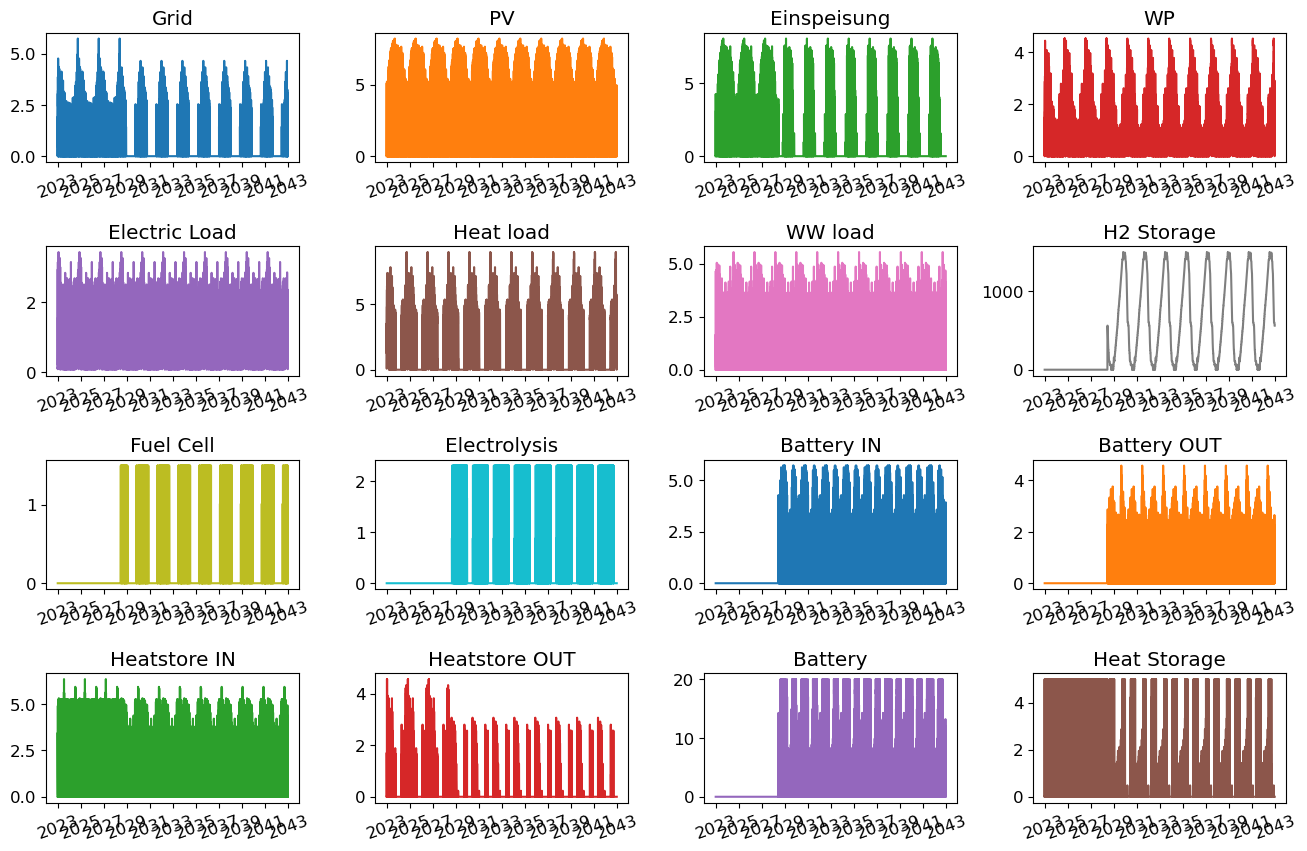

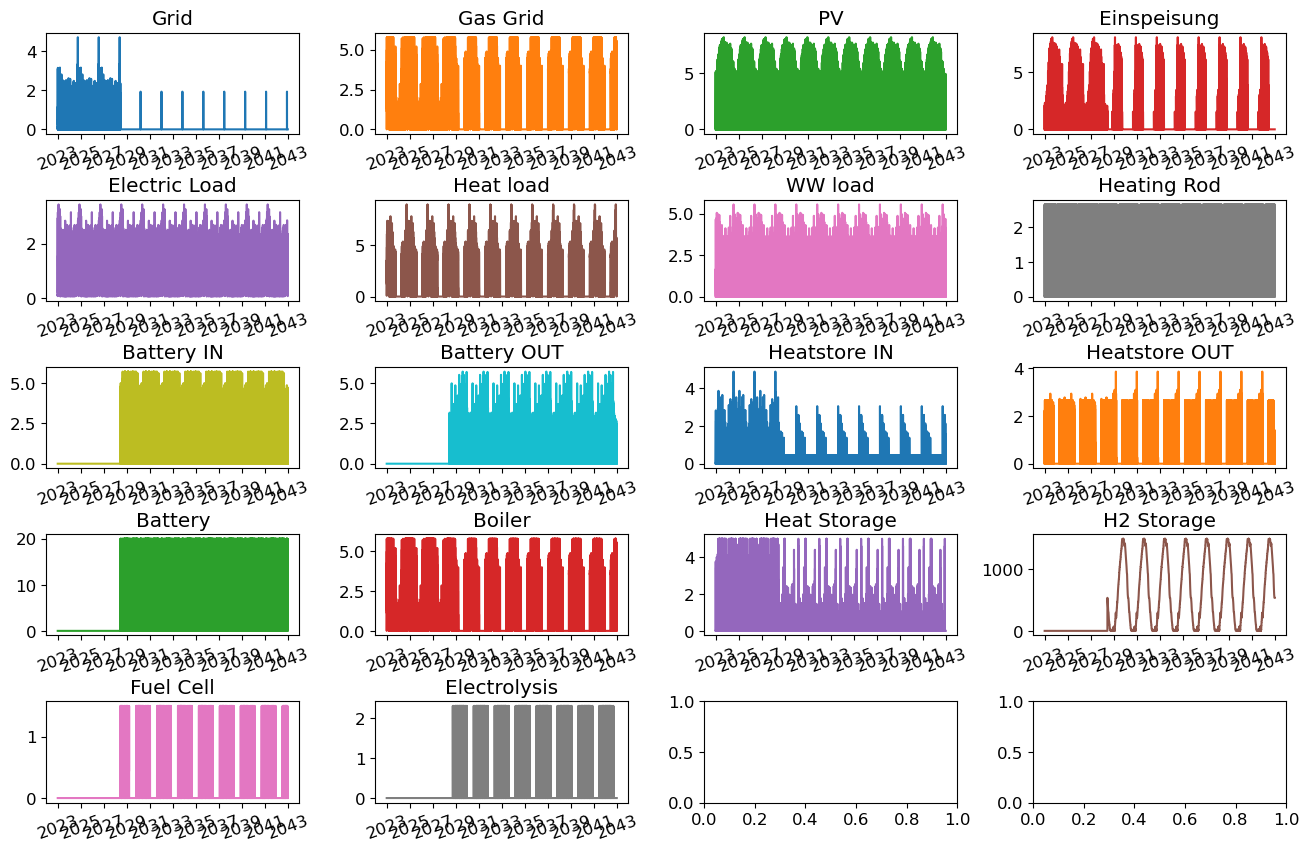

In [56]:
# scenario 5
# define result datasets
df_s5_res_gas = pd.DataFrame()
df_s5_res_ee = pd.DataFrame()

# setup period and reindex data
multi_years = range(2023, 2044, 2)
df_mdata_xy_r = reindex_data(df_mdata_xy, multi_years)
df_mseason_xy_r = reindex_data(df_mseason_xy, multi_years)
pv_params['p_max_pu_multi'] = df_mdata_xy_r['pv']
ely_params['p_max_pu_multi'] = df_mseason_xy_r['ely']
fc_params['p_max_pu_multi'] = df_mseason_xy_r['fc']
wp_params['efficiency_multi'] = df_mdata_xy_r['wp_COP_interp']
eload4m_r = df_mdata_xy_r['e_load_4p']
hload4m_r = df_mdata_xy_r['h_load_4p']
wwload4m_r = df_mdata_xy_r['ww_load_4p']

# setup networks
s5_gas_network = build_h2_network_gas_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2g=True,
                                        cost_data=df_cost_all_years, cost_scenario='min', 
                                        lifetime_h2=max_lifetime, init_build_year=s3a_h2_by_gas_min)
s5_gas_network.stores.loc['h2_storage', 'e_nom_extendable'] = False
s5_gas_network.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s5_gas_network.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s5_gas_network.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']
s5_gas_network.links.loc['gas_boiler', 'p_nom'] = p_nom_opt_gas_boiler
s5_gas_network.links.loc['gas_boiler', 'p_nom_extendable'] = False

s5_ee_network = build_h2_network_ee_m(eload4m_r, hload4m_r, wwload4m_r, multi_invest_h2=True,
                                      cost_data=df_cost_all_years, cost_scenario='min', 
                                      lifetime_h2=max_lifetime, init_build_year=s3a_h2_by_ee_min)
s5_ee_network.stores.loc['h2_storage', 'e_nom_extendable'] = False
s5_ee_network.stores.loc['h2_storage', 'e_nom_max'] = np.inf
s5_ee_network.links.loc['ely', 'p_nom_min'] = ely_params['p_nom']
s5_ee_network.links.loc['fc', 'p_nom_min'] = fc_params['p_nom']
s5_ee_network.links.loc['wp', 'p_nom'] = p_nom_opt_wp
s5_ee_network.links.loc['wp', 'p_nom_extendable'] = False

print("!----------------------------networks initialized------------------------------!")

s5_res_gas = {}
s5_res_ee = {}
corrected_payback_ee = []
corrected_payback_gas = []
payback_ratio_ee = []
payback_ratio_gas = []
# looping over h2_storage capacity (500, 1500, 2500 kWh)
for capacity in np.arange(h2_storage_params['e_nom_min'], h2_storage_params['e_nom_max']+1, 1000):
    
    print('Current Capacity: ', capacity)
    s5_gas_network.stores.loc['h2_storage', 'e_nom'] = capacity
    s5_gas_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    s5_res_gas[capacity] = result_summary_single_network(s5_gas_network, h2_gas=True, MI_analyse_network=True)
    df_s5_res_gas = df_s5_res_gas.append(result_summary_single_network(s5_gas_network, h2_gas=True,
                                                                       MI_analyse_network=True,
                                                                       sensitivity_variable=capacity))
    
    s5_ee_network.stores.loc['h2_storage', 'e_nom'] = capacity
    s5_ee_network.optimize(solver_name='gurobi', multi_investment_periods=True)
    s5_res_ee[capacity] = result_summary_single_network(s5_ee_network, h2=True, MI_analyse_network=True)
    df_s5_res_ee = df_s5_res_ee.append(result_summary_single_network(s5_ee_network, h2=True,
                                                                     MI_analyse_network=True,
                                                                     sensitivity_variable=capacity))
    print("!----------------------------recalculating payback periods------------------------------!")
    payback_ratio_1, corrected_payback_1 = compare_paypack_period(dataset_ref=ref_res_gas[2],
                                                                  dataset_h2=s5_res_gas[capacity][2],
                                                                  ref_installation_year=multi_years[0],
                                                                  h2_installation_year=s3a_h2_by_gas_min)
    payback_ratio_2, corrected_payback_2 = compare_paypack_period(dataset_ref=ref_res_ee[2],
                                                                  dataset_h2=s5_res_ee[capacity][2],
                                                                  ref_installation_year=multi_years[0],
                                                                  h2_installation_year=s3a_h2_by_ee_min)
    corrected_payback_gas.append(corrected_payback_1)
    payback_ratio_gas.append(payback_ratio_1)
    corrected_payback_ee.append(corrected_payback_2)
    payback_ratio_ee.append(payback_ratio_2)
    
df_s5_res_gas['corrected Payback Period [a]'] = corrected_payback_gas
df_s5_res_gas['Payback Ratio [h2/ref]'] = payback_ratio_gas
df_s5_res_ee['corrected Payback Period [a]'] = corrected_payback_ee
df_s5_res_ee['Payback Ratio [h2/ref]'] = payback_ratio_ee
print("!----------------------------results generated------------------------------!")
print("example results for 1500kWh: ")
plot_series_data(s5_res_ee[1500][0], MI_plot_series=True)
plot_series_data(s5_res_gas[1500][0], MI_plot_series=True)


%store s5_res_gas
%store s5_res_ee
%store df_s5_res_gas
%store df_s5_res_ee

del s5_gas_network
del s5_ee_network
del s5_res_gas
del s5_res_ee
del df_s5_res_gas
del df_s5_res_ee

# Auswertung der Szenarioanalysen

In [57]:
# Reference
%store -r ref_res_gas
%store -r ref_res_ee
%store -r ref_gas_pp
%store -r ref_ee_pp
%store -r co2_start_ref_gas
%store -r co2_start_ref_ee
%store -r p_nom_opt_gas_boiler
%store -r p_nom_opt_wp

# Globals cost data
%store -r df_cost_all_years
%store -r df_cost

In [58]:
# datasets Szenario 1 - Capital Cost H2-System
%store -r df_s1a_ee
%store -r df_s1a_gas
%store -r s1a_res_ee
%store -r s1a_res_gas

%store -r df_s1b_ee
%store -r df_s1b_gas
%store -r s1b_res_ee
%store -r s1b_res_gas

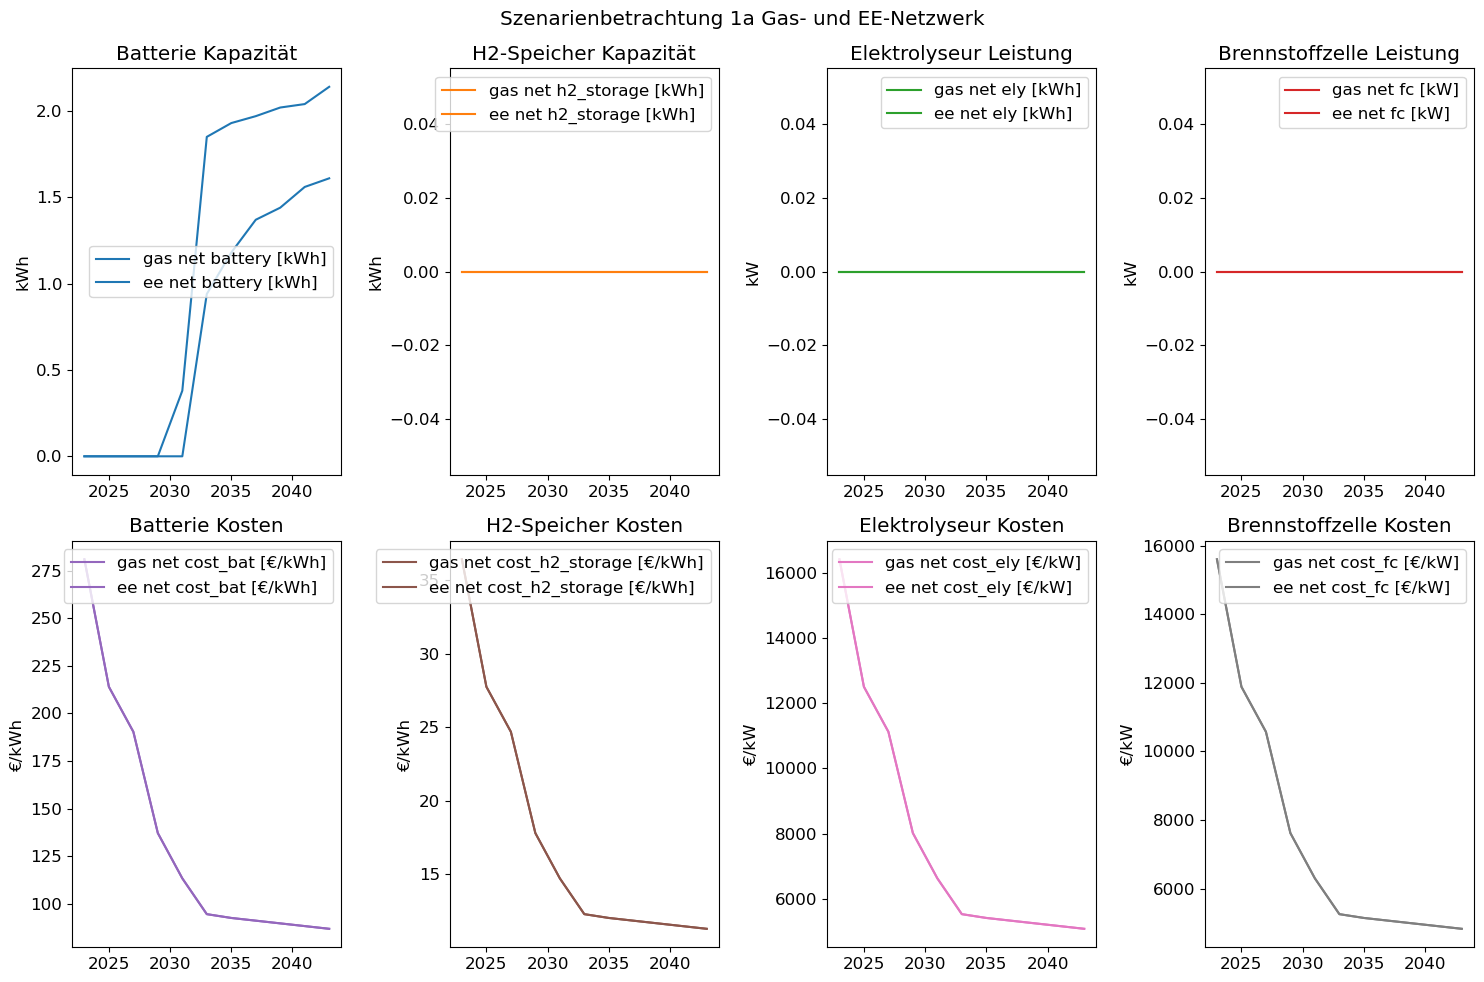

In [59]:
# scenario 1a

# H2 Komponenten
# rename columns for better clarity in plots
df_s1a_gas = df_s1a_gas.rename(columns={"battery [kWh]": "gas net battery [kWh]",
                                       "h2_storage [kWh]": "gas net h2_storage [kWh]",
                                       "ely [kW]": "gas net ely [kWh]",
                                       "fc [kW]": "gas net fc [kW]",
                                       "cost_bat [€/kWh]": "gas net cost_bat [€/kWh]",
                                       "cost_h2_storage [€/kWh]": "gas net cost_h2_storage [€/kWh]",
                                       "cost_ely [€/kW]": "gas net cost_ely [€/kW]",
                                       "cost_fc [€/kW]": "gas net cost_fc [€/kW]"})

df_s1a_ee = df_s1a_ee.rename(columns={"battery [kWh]": "ee net battery [kWh]",
                                       "h2_storage [kWh]": "ee net h2_storage [kWh]",
                                       "ely [kW]": "ee net ely [kWh]",
                                       "fc [kW]": "ee net fc [kW]",
                                       "cost_bat [€/kWh]": "ee net cost_bat [€/kWh]",
                                       "cost_h2_storage [€/kWh]": "ee net cost_h2_storage [€/kWh]",
                                       "cost_ely [€/kW]": "ee net cost_ely [€/kW]",
                                       "cost_fc [€/kW]": "ee net cost_fc [€/kW]"})
# H2 components subplots individual
fig, axes = plt.subplots(nrows=2, ncols=4, figsize = (15,10))
df_s1a_gas.plot(subplots=True, ax=axes)
df_s1a_ee.plot(subplots=True, ax = axes)

axes[0,0].set_ylabel('kWh')
axes[0,1].set_ylabel('kWh')
axes[0,2].set_ylabel('kW')
axes[0,3].set_ylabel('kW')
axes[1,0].set_ylabel('€/kWh')
axes[1,1].set_ylabel('€/kWh')
axes[1,2].set_ylabel('€/kW')
axes[1,3].set_ylabel('€/kW')

axes[0,0].set_title('Batterie Kapazität')
axes[0,1].set_title('H2-Speicher Kapazität')
axes[0,2].set_title('Elektrolyseur Leistung')
axes[0,3].set_title('Brennstoffzelle Leistung')
axes[1,0].set_title('Batterie Kosten')
axes[1,1].set_title('H2-Speicher Kosten')
axes[1,2].set_title('Elektrolyseur Kosten')
axes[1,3].set_title('Brennstoffzelle Kosten')

fig.suptitle('Szenarienbetrachtung 1a Gas- und EE-Netzwerk')
fig.tight_layout()

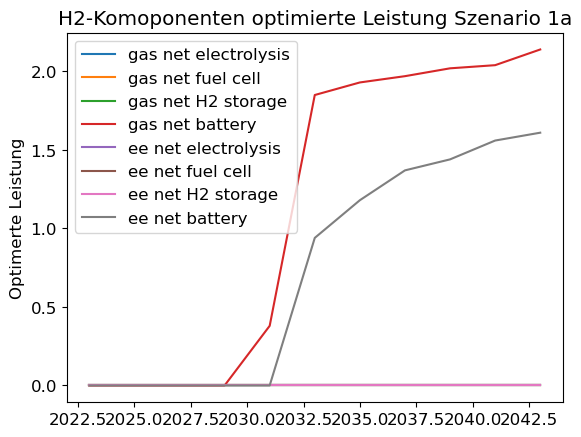

In [60]:
# scenario 1a H2 components optimized power 1a

plt.title('H2-Komoponenten optimierte Leistung Szenario 1a')

plt.ylabel('Optimerte Leistung')

opti_gas = df_s1a_gas.index
opti_ee = df_s1a_ee.index

opti_ely_gas = extract_specific_data("ely", s1a_res_gas, 1)
opti_fc_gas = extract_specific_data("fc", s1a_res_gas, 1)
opti_h2_storage_gas = extract_specific_data("h2_storage", s1a_res_gas, 1)
opti_battery_gas = extract_specific_data("battery", s1a_res_gas, 1)

opti_ely_ee = extract_specific_data("ely", s1a_res_ee, 1)
opti_fc_ee = extract_specific_data("fc", s1a_res_ee, 1)
opti_h2_storage_ee = extract_specific_data("h2_storage", s1a_res_ee, 1)
opti_battery_ee= extract_specific_data("battery", s1a_res_ee, 1)

plt.plot(opti_gas, opti_ely_gas, label = 'gas net electrolysis')
plt.plot(opti_gas, opti_fc_gas, label = 'gas net fuel cell')
plt.plot(opti_gas, opti_h2_storage_gas, label = 'gas net H2 storage')
plt.plot(opti_gas, opti_battery_gas, label = 'gas net battery')

plt.plot(opti_ee, opti_ely_ee, label = 'ee net electrolysis')
plt.plot(opti_ee, opti_fc_ee, label = 'ee net fuel cell')
plt.plot(opti_ee, opti_h2_storage_ee, label = 'ee net H2 storage')
plt.plot(opti_ee, opti_battery_ee, label = 'ee net battery')

plt.legend()
plt.show()

NameError: name 'ax' is not defined

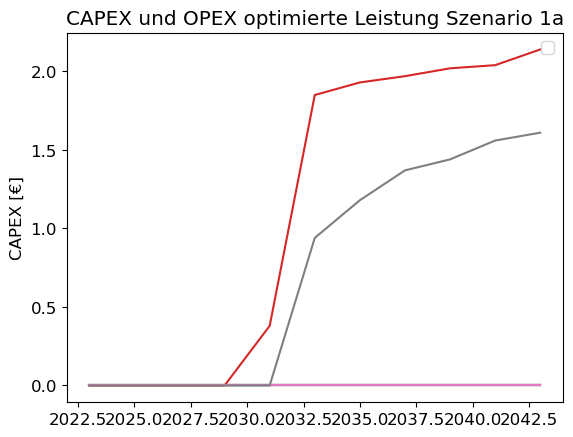

In [61]:
# CAPEX and OPEX from s1a

plt.title('CAPEX und OPEX optimierte Leistung Szenario 1a')

plt.ylabel('CAPEX [€]')

capex_ely_gas = extract_specific_data("ely", s1a_res_gas, 1)
capex_fc_gas = extract_specific_data("fc", s1a_res_gas, 1)
capex_h2_storage_gas = extract_specific_data("h2_storage", s1a_res_gas, 1)
capex_battery_gas = extract_specific_data("battery", s1a_res_gas, 1)

opex_ely_ee = extract_specific_data("ely", s1a_res_ee, 1)
opex_fc_ee = extract_specific_data("fc", s1a_res_ee, 1)
opex_h2_storage_ee = extract_specific_data("h2_storage", s1a_res_ee, 1)
opex_battery_ee= extract_specific_data("battery", s1a_res_ee, 1)

plt.legend()
plt.plot(opti_gas, opti_ely_gas, label = 'gas net electrolysis')
plt.plot(opti_gas, opti_fc_gas, label = 'gas net fuel cell')
plt.plot(opti_gas, opti_h2_storage_gas, label = 'gas net H2 storage')
plt.plot(opti_gas, opti_battery_gas, label = 'gas net battery')

plt.plot(opti_ee, opti_ely_ee, label = 'ee net electrolysis')
plt.plot(opti_ee, opti_fc_ee, label = 'ee net fuel cell')
plt.plot(opti_ee, opti_h2_storage_ee, label = 'ee net H2 storage')
plt.plot(opti_ee, opti_battery_ee, label = 'ee net battery')

secax_y = ax.secondary_yaxis('right', )
secax_y.set_ylabel('OPEX [€/a]')

opti_gas = df_s1a_gas.index
opti_ee = df_s1a_ee.index

plt.show()

[38.81, 38.81, 38.81, 38.81, 37.73, 34.28, 34.14, 34.06, 33.97, 33.92, 33.75]
[47.03, 47.03, 47.03, 47.03, 47.03, 43.5, 42.72, 42.1, 41.9, 41.55, 41.41]


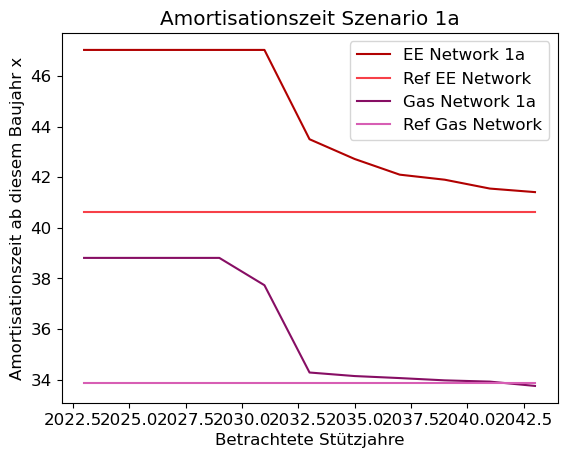

In [90]:
# plot payback period 1a

print(extract_specific_data('Payback Period [a]', s1a_res_gas, 2))
print(extract_specific_data('Payback Period [a]', s1a_res_ee, 2))

plt.title('Amortisationszeit Szenario 1a')

plt.xlabel('Betrachtete Stützjahre')
plt.ylabel('Amortisationszeit ab diesem Baujahr x')

s1a_payback_years = df_s1a_gas.index
s1a_payback_gas = extract_specific_data('Payback Period [a]', s1a_res_gas, 2)
s1a_payback_ee = extract_specific_data('Payback Period [a]', s1a_res_ee, 2)

ref_payback_gas = ref_res_gas[2].loc['Payback Period [a]', 'analytic values']
ref_payback_gas_years = []

for i in s1a_payback_gas:
    ref_payback_gas_years.append(ref_payback_gas)

ref_payback_ee = ref_res_ee[2].loc['Payback Period [a]', 'analytic values']
ref_payback_ee_years = []

for h in s1a_payback_gas:
    ref_payback_ee_years.append(ref_payback_ee)
    
plt.legend()
plt.plot(s1a_payback_years, s1a_payback_ee, '#b10101', label = 'EE Network 1a')
plt.plot(s1a_payback_years, ref_payback_ee_years, '#f74048', label = 'Ref EE Network')
plt.plot(s1a_payback_years, s1a_payback_gas, '#870e64', label = 'Gas Network 1a')
plt.plot(s1a_payback_years, ref_payback_gas_years, '#d75eb4', label = 'Ref Gas Network')

plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

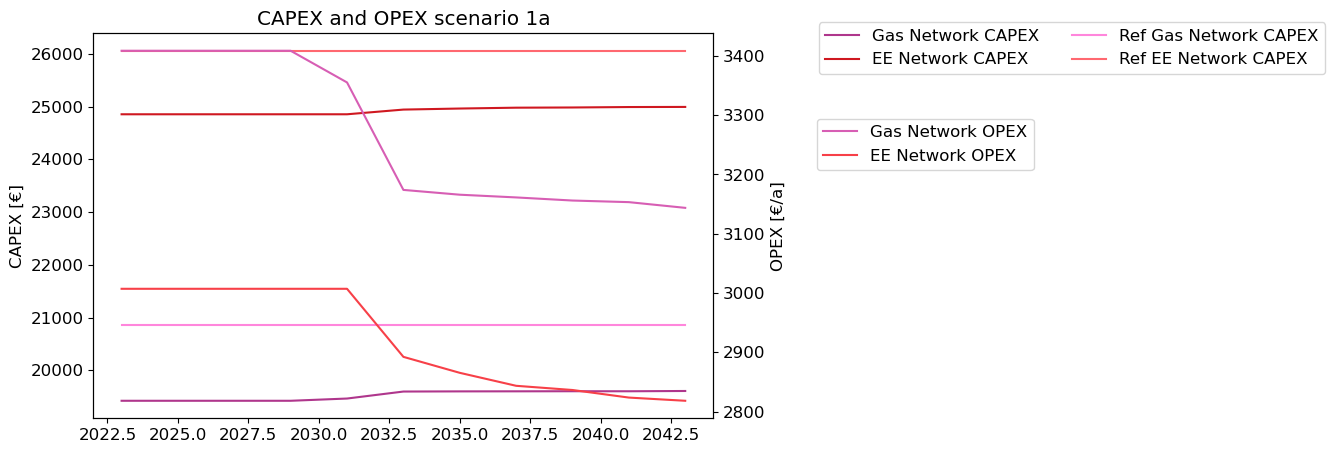

In [110]:
# plot Capex und Opex 1a

fig, ax = plt.subplots(figsize=(8,5))
ax2 = ax.twinx() 

plt.title('CAPEX and OPEX scenario 1a')

plt.xlabel('Betrachtete Stützjahre')
plt.ylabel('Kosten €')

x= df_s1a_gas.index
capex_opti_gas = extract_specific_data('CAPEX [€]', s1a_res_gas, 2)
capex_opti_ee = extract_specific_data('CAPEX [€]', s1a_res_ee, 2)
opex_opti_gas = extract_specific_data('OPEX [€/a]', s1a_res_gas, 2)
opex_opti_ee = extract_specific_data('OPEX [€/a]', s1a_res_ee, 2)

ref_capex_gas = ref_res_gas[2].loc['CAPEX [€]', 'analytic values']
ref_opex_gas = ref_res_gas[2].loc['OPEX [€/a]', 'analytic values']
ref_capex_gas_years = []
ref_opex_gas_years = []

for i in s1a_payback_gas:
    ref_capex_gas_years.append(ref_capex_gas)
    ref_opex_gas_years.append(ref_opex_gas)

ref_capex_ee = ref_res_ee[2].loc['CAPEX [€]', 'analytic values']
ref_opex_ee = ref_res_ee[2].loc['OPEX [€/a]', 'analytic values']
ref_capex_ee_years = []
ref_opex_ee_years = []

for h in s1a_payback_gas:
    ref_capex_ee_years.append(ref_capex_ee)
    ref_opex_ee_years.append(ref_opex_ee)


ax.plot(x, capex_opti_gas,'#af368c', label = 'Gas Network CAPEX')
ax.plot(x, capex_opti_ee, '#cf1820', label = 'EE Network CAPEX')
ax2.plot(x, opex_opti_gas, '#d75eb4', label = 'Gas Network OPEX')
ax2.plot(x, opex_opti_ee, '#f74048', label = 'EE Network OPEX')
ax.plot(s1a_payback_years, ref_capex_gas_years, '#ff86dc', label = 'Ref Gas Network CAPEX')
ax.plot(s1a_payback_years, ref_capex_ee_years, '#ff6870', label = 'Ref EE Network CAPEX')

#= ax.secondary_yaxis('right', ref_opex_gas_years)
ax.set_ylabel('CAPEX [€]')
ax2.set_ylabel('OPEX [€/a]')
ax.legend(bbox_to_anchor=(2.0, 1.05), ncol=2)
ax2.legend(bbox_to_anchor=(1.53, 0.80))
plt.show

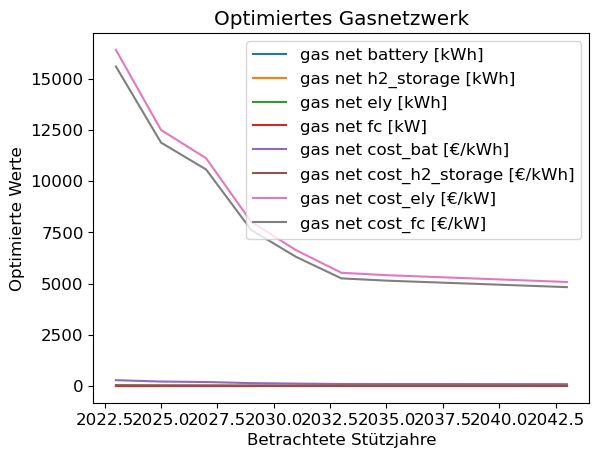

In [64]:
plt.title('Optimiertes Gasnetzwerk')

plt.ylabel('Optimierte Werte')
plt.xlabel('Betrachtete Stützjahre')
plt.plot(df_s1a_gas)

plt.legend(df_s1a_gas.columns)

plt.show()

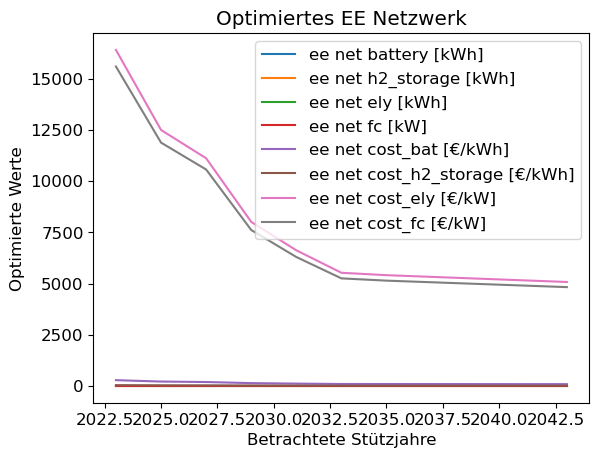

In [65]:
plt.title('Optimiertes EE Netzwerk')

plt.ylabel('Optimierte Werte')
plt.xlabel('Betrachtete Stützjahre')
plt.plot(df_s1a_ee)

plt.legend(df_s1a_ee.columns)

plt.show()

In [66]:
# datasets Szenario 2 - CO2
%store -r df_s2a_res_gas
%store -r s2a_res_gas_sum

%store -r df_s2b_res_ee
%store -r s2b_res_ee_sum

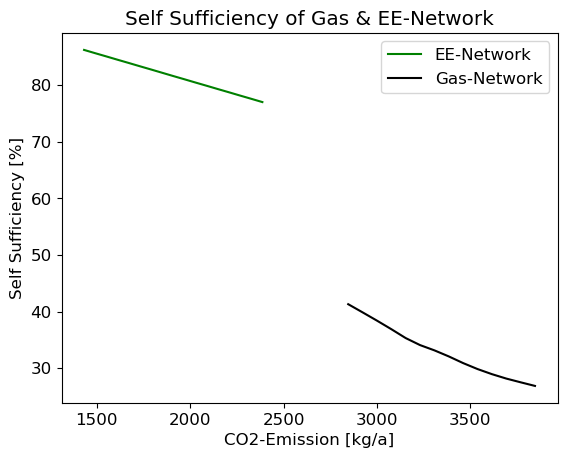

In [67]:
ax = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='green', ax=ax)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Self Sufficiency [%]', color='black', ax=ax)
ax.set(xlabel='CO2-Emission [kg/a]', ylabel='Self Sufficiency [%]', title='Self Sufficiency of Gas & EE-Network')
ax.legend(["EE-Network", "Gas-Network"])
plt.show()

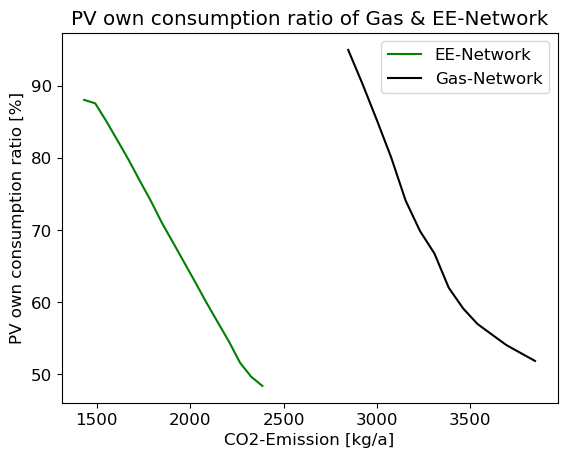

In [68]:
ax1 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='green', ax=ax1)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='PV own consumption ratio [%]', color='black', ax=ax1)
ax1.set(xlabel='CO2-Emission [kg/a]', ylabel='PV own consumption ratio [%]', title='PV own consumption ratio of Gas & EE-Network')
ax1.legend(["EE-Network", "Gas-Network"])
plt.show()

In [128]:
df_s2a_res_gas

CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
100.0              3846.24              10724.82          5564.16   
98.0               3769.32              10724.82          5681.86   
96.0               3692.39              10724.82          5800.90   
94.0               3615.47              10724.82          5956.43   
92.0               3538.54              10724.82          6113.08   
90.0               3461.62              10724.82          6344.40   
88.0               3384.69              10724.82          6651.61   
86.0               3307.77              10724.82          7162.82   
84.0               3230.84              10724.82          7495.36   
82.0               3153.92              10724.82          7948.25   
80.0               3076.99              10724.82          8586.17   
78.0               3000.07              10724.82          9143.49   
76.0               2923.14              10724.82          9681.97   
74.0               2846.22              10724.82         10192.01   
72.0               2846.22              10724.82         10192.01   

       PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
100.0                         51.88                5160.66   
98.0                          52.98                5042.96   
96.0                          54.09                4923.92   
94.0                          55.54                4768.39   
92.0                          57.00                4611.74   
90.0                          59.16                4380.42   
88.0                          62.02                4073.21   
86.0                          66.79                3562.00   
84.0                          69.89                3229.46   
82.0                          74.11                2776.57   
80.0                          80.06                2138.65   
78.0                          85.26                1581.33   
76.0                          90.28                1042.85   
74.0                          95.03                 532.81   
72.0                          95.03                 532.81   

       Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
100.0            23901.99                1359.14          16120.65   
98.0             23901.99                1160.27          16167.13   
96.0             23901.99                 967.24          16201.03   
94.0             23901.99                 796.87          16186.25   
92.0             23901.99                 654.11          16112.15   
90.0             23901.99                 539.28          15978.06   
88.0             23901.99                 453.58          15781.38   
86.0             23901.99                 346.04          15631.61   
84.0             23901.99                 207.58          15548.29   
82.0             23901.99                 134.79          15323.84   
80.0             23901.99                 128.65          14956.23   
78.0             23901.99                 110.87          14613.61   
76.0             23901.99                  83.89          14290.76   
74.0             23901.99                  53.04          13976.24   
72.0             23901.99                  53.04          13976.24   

       Ratio electric [%]  Ratio gas [%]  ...  H2 stored [kWh/a]  \
100.0                7.78          92.22  ...              -0.00   
98.0                 6.70          93.30  ...              -0.00   
96.0                 5.63          94.37  ...              -0.00   
94.0                 4.69          95.31  ...              -0.00   
92.0                 3.90          96.10  ...              -0.00   
90.0                 3.26          96.74  ...              -0.00   
88.0                 2.79          97.21  ...              -0.00   
86.0                 2.17          97.83  ...             175.96   
84.0                 1.32          98.68  ...             455.30   
82.0                 0.87          99.13  ...             780.64   
80.0                 0.85          99.15

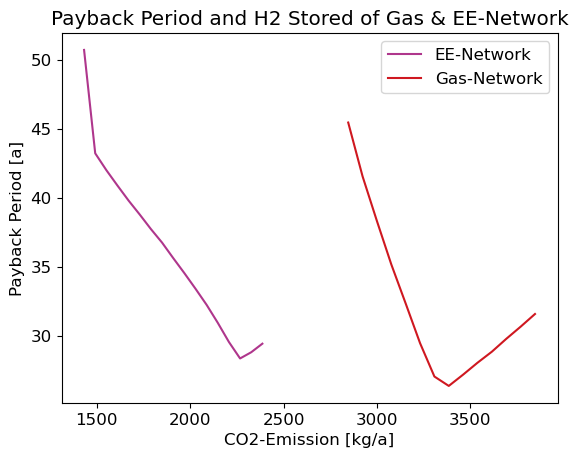

In [118]:
ax2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='#af368c', ax=ax2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='Payback Period [a]', color='#cf1820', ax=ax2)
ax2.set(xlabel='CO2-Emission [kg/a]', ylabel='Payback Period [a]', title='Payback Period and H2 Stored of Gas & EE-Network')
ax2.legend(["EE-Network", "Gas-Network"])
plt.show()

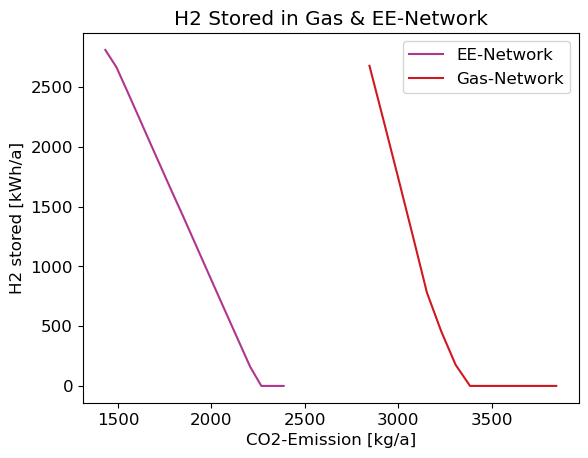

In [119]:
ax_h2 = plt.gca()
df_s2b_res_ee.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='#af368c', ax=ax_h2)
df_s2a_res_gas.plot(kind='line', x='CO2-Emission [kg/a]', y='H2 stored [kWh/a]', color='#cf1820', ax=ax_h2)
ax_h2.set(xlabel='CO2-Emission [kg/a]', ylabel='H2 stored [kWh/a]', title='H2 Stored in Gas & EE-Network')
ax_h2.legend(["EE-Network", "Gas-Network"])
plt.show()

In [71]:
# datasets Szenario 3 - Capital Cost H2-System according to CO2
%store -r s3a_co2_lim_gas
%store -r s3a_co2_lim_ee
%store -r s3b_co2_lim_gas
%store -r s3b_co2_lim_ee

%store -r df_s3a_ee
%store -r df_s3a_gas
%store -r s3a_res_ee
%store -r s3a_res_gas

%store -r df_s3b_ee
%store -r df_s3b_gas
%store -r s3b_res_ee
%store -r s3b_res_gas

%store -r s3a_h2_by_gas
%store -r s3a_h2_by_ee
%store -r s3b_h2_by_gas
%store -r s3b_h2_by_ee

%store -r df_cap_cost_pp

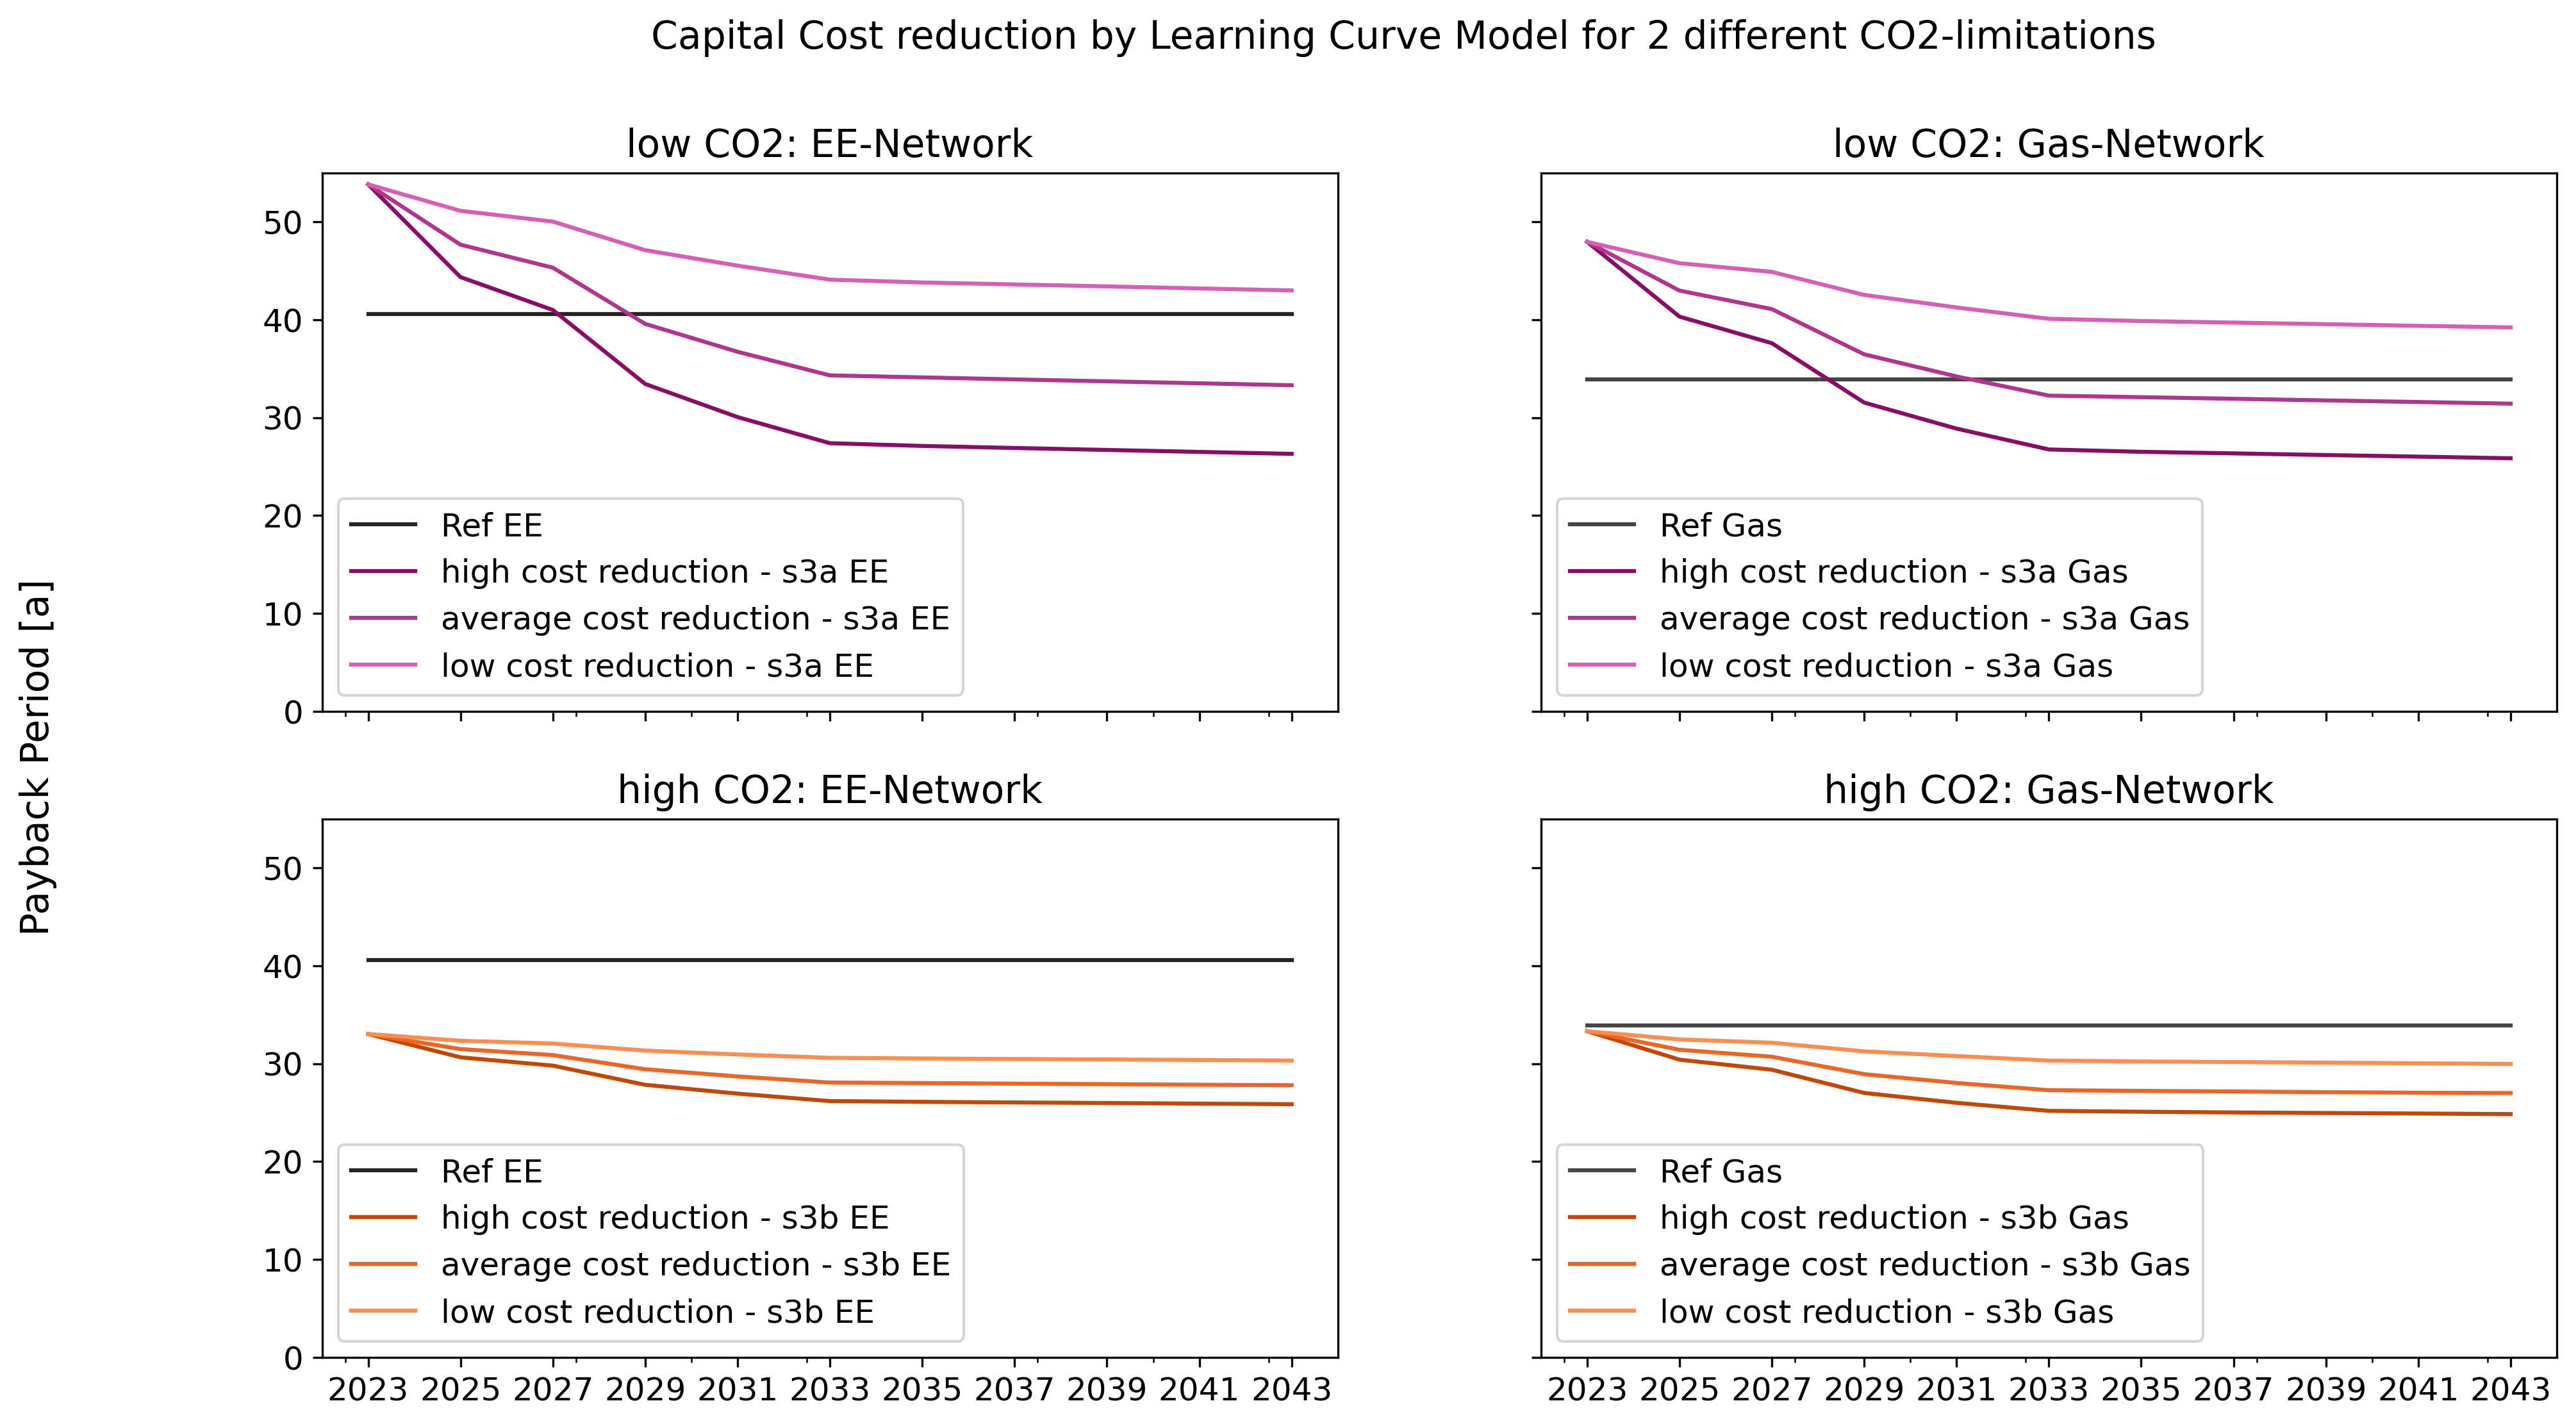

In [115]:
# scenario 3 Payback Period-Results
df_cap_cost_pp = df_cap_cost_pp.rename(columns={"pp_ref_ee": "Ref EE",
                                       "pp_s3a_ee_min": "high cost reduction - s3a EE",
                                       "pp_s3a_ee_std": "average cost reduction - s3a EE",
                                       "pp_s3a_ee_max": "low cost reduction - s3a EE",
                                       "pp_ref_gas": "Ref Gas",
                                       "pp_s3a_gas_min": "high cost reduction - s3a Gas",
                                       "pp_s3a_gas_std": "average cost reduction - s3a Gas",
                                       "pp_s3a_gas_max": "low cost reduction - s3a Gas",
                                       "pp_s3b_ee_min": "high cost reduction - s3b EE",
                                       "pp_s3b_ee_std": "average cost reduction - s3b EE",
                                       "pp_s3b_ee_max": "low cost reduction - s3b EE",
                                       "pp_s3b_gas_min": "high cost reduction - s3b Gas",
                                       "pp_s3b_gas_std": "average cost reduction - s3b Gas",
                                       "pp_s3b_gas_max": "low cost reduction - s3b Gas"})

fig_3pp, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,8), sharey=True, sharex=True, dpi=300)

df_cap_cost_pp.plot(y=["Ref EE", "high cost reduction - s3a EE", "average cost reduction - s3a EE", "low cost reduction - s3a EE"],
                    xticks=df_cap_cost_pp.year, ax=ax1, xlabel='', 
                    color=('#242424', '#870e64','#af368c','#d75eb4'))

df_cap_cost_pp.plot(y=["Ref Gas", "high cost reduction - s3a Gas", "average cost reduction - s3a Gas", "low cost reduction - s3a Gas"],
                    xticks=df_cap_cost_pp.year, ax=ax2, xlabel='', 
                    color=('#454545', '#870e64','#af368c','#d75eb4'))

df_cap_cost_pp.plot(y=["Ref EE", "high cost reduction - s3b EE", "average cost reduction - s3b EE", "low cost reduction - s3b EE"],
                    xticks=df_cap_cost_pp.year, ax=ax3, xlabel='', 
                    color=('#242424', '#c44701', '#ec6525', '#ff8d4d'))

df_cap_cost_pp.plot(y=["Ref Gas",  "high cost reduction - s3b Gas", "average cost reduction - s3b Gas", "low cost reduction - s3b Gas"],
                    xticks=df_cap_cost_pp.year, ax=ax4, xlabel='', 
                    color=('#454545', '#c44701', '#ec6525', '#ff8d4d'), )

ax1.set_title("low CO2: EE-Network")
ax1.set_title("low CO2: EE-Network")
ax2.set_title("low CO2: Gas-Network")
ax3.set_title("high CO2: EE-Network")
ax4.set_title("high CO2: Gas-Network")
ax1.set_ylim(0, 55)
ax2.set_ylim(0, 55)
ax3.set_ylim(0, 55)
ax4.set_ylim(0, 55)
fig_3pp.suptitle('Capital Cost reduction by Learning Curve Model for 2 different CO2-limitations')
fig_3pp.supylabel('Payback Period [a]')
plt.show()

In [74]:
# datasets Szenario 4 - Lifetime
%store -r s4a_res_gas
%store -r df_s4a_res_gas

%store -r s4b_res_gas
%store -r df_s4b_res_gas

no stored variable or alias s4b_res_gas
no stored variable or alias df_s4b_res_gas


In [75]:
# datasets scenario 5 - Results Application
%store -r s5_res_gas
%store -r s5_res_ee
%store -r df_s5_res_gas
%store -r df_s5_res_ee
df_s5_res_ee

CO2-Emission [kg/a]  PV generated [kWh/a]  PV used [kWh/a]  \
500.0               2378.92              10724.82          5595.26   
1500.0              2158.67              10724.82          6612.46   
2500.0              1940.77              10724.82          7658.17   

        PV own consumption ratio [%]  Amount Infeed [kWh/a]  \
500.0                          52.17                5129.56   
1500.0                         61.66                4112.36   
2500.0                         71.41                3066.65   

        Load Total [kWh/a]  Grid electric [kWh/a]  Grid gas [kWh/a]  \
500.0             23901.99                5481.39               0.0   
1500.0            23901.99                4973.89               0.0   
2500.0            23901.99                4471.82               0.0   

        Ratio electric [%]  Ratio gas [%]  ...  H2 used [kWh/a]  \
500.0                100.0            0.0  ...           588.67   
1500.0               100.0            0.0  ...          1301.43   
2500.0               100.0            0.0  ...          2015.40   

        Heat from H2 [kWh/a]  Self Sufficiency [%]  CAPEX [€]  OPEX [€/a]  \
500.0                 347.63                 77.07   66355.13     2192.56   
1500.0                774.48                 79.19   84141.82     1989.55   
2500.0               1201.68                 81.29  101928.51     1788.73   

        Revenue Infeed [€/a]  Revenue Savings [€/a]  Payback Period [a]  \
500.0                -364.20               -2238.10               42.35   
1500.0               -291.98               -2644.98               42.20   
2500.0               -217.73               -3063.27               41.97   

        corrected Payback Period [a]  Payback Ratio [h2/ref]  
500.0                          32.69                0.804910  
1500.0                         34.06                0.838642  
2500.0                         35.05                0.863019  

[3 rows x 24 columns]

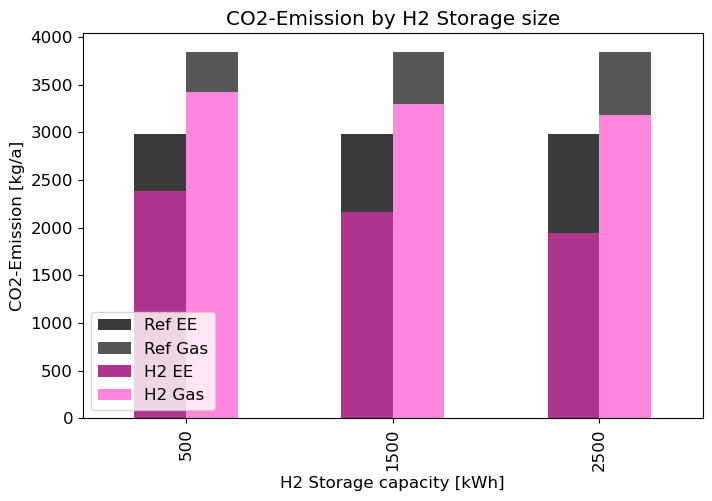

Ref EE  Ref Gas    H2 EE   H2 Gas
500   2983.21  3846.24  2378.92  3420.71
1500  2983.21  3846.24  2158.67  3295.91
2500  2983.21  3846.24  1940.77  3180.60

In [76]:
# scenario 5: CO2-Results
df5_co2 = pd.DataFrame(data={'Ref EE': [co2_start_ref_ee]*3,
                             'Ref Gas': [co2_start_ref_gas]*3, 
                             'H2 EE': df_s5_res_ee['CO2-Emission [kg/a]'], 
                             'H2 Gas': df_s5_res_gas['CO2-Emission [kg/a]']}, 
                       index=range(500, 2501, 1000))

fig_co2, ax_co2 = plt.subplots(figsize=(8,5))
df5_co2.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#454545'),  alpha=0.9, ax=ax_co2)
df5_co2.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#af358c', '#ff86dc'), ax=ax_co2)

ax_co2.set(xlabel='H2 Storage capacity [kWh]', ylabel='CO2-Emission [kg/a]', title='CO2-Emission by H2 Storage size')
ax_co2.legend(loc='lower left')
plt.show()
df5_co2

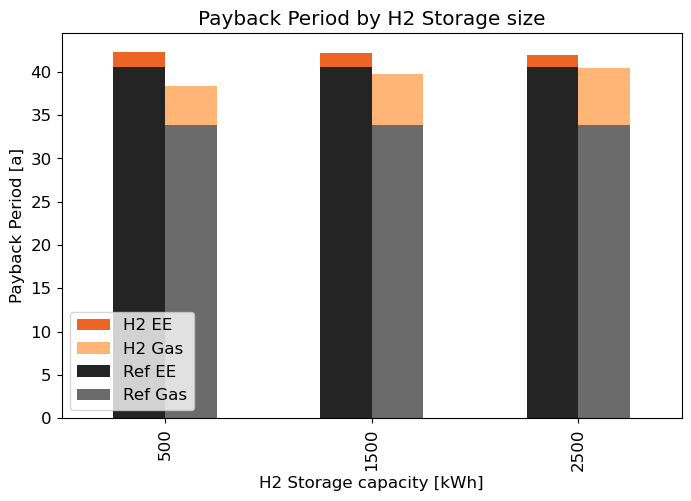

Ref EE  Ref Gas  H2 EE  H2 Gas
500    40.61    33.88  42.35   38.40
1500   40.61    33.88  42.20   39.74
2500   40.61    33.88  41.97   40.42

In [116]:
# scenario 5: Payback Period-Results
df5_pp = pd.DataFrame(data={'Ref EE': [ref_ee_pp]*3,
                            'Ref Gas': [ref_gas_pp]*3,
                            'H2 EE': df_s5_res_ee['Payback Period [a]'], 
                            'H2 Gas': df_s5_res_gas['Payback Period [a]']}, 
                       index=range(500, 2501, 1000))

fig_pp, ax_pp = plt.subplots(figsize=(8,5))
df5_pp.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#ec6525', '#ffb575'), ax=ax_pp)
df5_pp.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#6b6b6b'), ax=ax_pp)

ax_pp.set(xlabel='H2 Storage capacity [kWh]', ylabel='Payback Period [a]', title='Payback Period by H2 Storage size')
ax_pp.legend(loc='lower left')
plt.show()
df5_pp

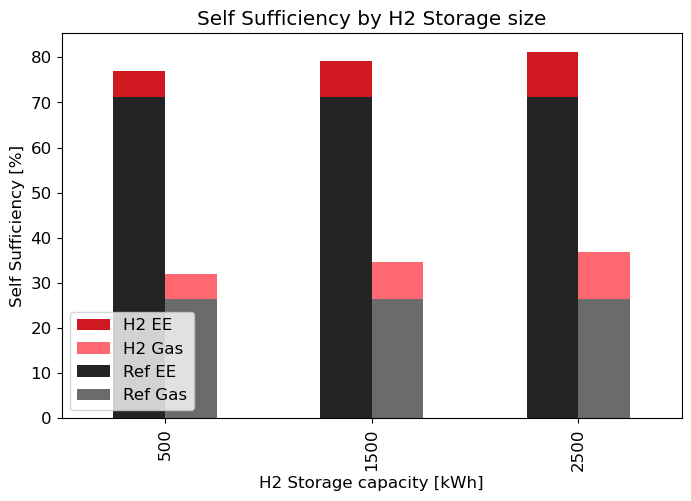

Ref EE  Ref Gas  H2 EE  H2 Gas
500    71.24    26.37  77.07   31.98
1500   71.24    26.37  79.19   34.56
2500   71.24    26.37  81.29   36.95

In [117]:
# scenario 5: Self Sufficiency-Results 
df5_suf = pd.DataFrame(data={'Ref EE': [ref_res_ee[2].loc['Self Sufficiency [%]', 'analytic values']]*3,
                            'Ref Gas': [ref_res_gas[2].loc['Self Sufficiency [%]', 'analytic values']]*3,
                            'H2 EE': df_s5_res_ee['Self Sufficiency [%]'], 
                            'H2 Gas': df_s5_res_gas['Self Sufficiency [%]']}, 
                       index=range(500, 2501, 1000))

fig_suf, ax_suf = plt.subplots(figsize=(8,5))
df5_suf.plot(kind='bar', y=['H2 EE', 'H2 Gas'], color=('#cf1820', '#ff6870'), ax=ax_suf)
df5_suf.plot(kind='bar', y=['Ref EE', 'Ref Gas'], color=('#242424', '#6b6b6b'), ax=ax_suf)


ax_suf.set(xlabel='H2 Storage capacity [kWh]', ylabel='Self Sufficiency [%]', title='Self Sufficiency by H2 Storage size')
ax_suf.legend(loc='lower left')
plt.show()
df5_suf

In [79]:
df = pd.concat(
    {
        period: n.get_active_assets(c, period) * n.df(c).p_nom_opt
        for period in n.investment_periods
    },
    axis=1,
)

NameError: name 'n' is not defined

# Einordnung der Sensitivitäten

### Sensitivität 1: Notwendige Kostenreduktion der Wasserstoffkomponenten

> Notwendige Bedingung: Nicht erfüllt!</br>
Keine Komponente des Wasserstoffsystems wurde auf eine Leistung dimensioniert.</br>
Das bedeutet, dass auch eine Reduzierung der Systemkosten um 78% gegenüber den aktuellen Preisen aus ökonomischer Sicht kein Anreiz für eine Saisonale Wasserstoffspeicherung besteht.


# Simulation mit ermittelten Werten für verschiedene Personenanzahlen

##### Grundparameter:
1. Ermittelte notwendige Kapitalkosten des Wasserstoffsystems
2. Ermittelte notwendige Lebensdauer des Wasserstoffsystems
3. Festlegung der Wasserstoffsystemdimensionierung aus vorangegangen Analysen
3. Variation der Lastprofile entsprechend 2-, 4-, 6-Personenhaushalt

**Ermittlung der CO2-Einsparung, des PV-Eigenverbrauchsanteils und des Autarkiegrades gegenüber Referenzszenarien**
- a: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem Gasbasierten Einfamilienhaus
- b: Erweiterung um ein saisonales Wasserstoffspeicher und-versorgungssystems ausgehend von einem erneuerbarbar versorgten Einfamilienhaus 



In [ ]:
# delete all stored variables
%store -z